In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def catboost_metric(model_cb, X_test, y_test ):
    y_pred_cb = model_cb.predict(X_test)
    y_pred_cb_proba = model_cb.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_pred_cb_proba)
    accuracy = accuracy_score(y_test, y_pred_cb)
    precision = precision_score(y_test, y_pred_cb)
    recall = recall_score(y_test, y_pred_cb)
    f1 = f1_score(y_test, y_pred_cb)

    metrics_cb = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc
        }
    return metrics_cb, y_pred_cb, y_pred_cb_proba

def lightgbm_metric( model, X_test, y_test):

    y_pred_lgb = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_lgb)   
    best_threshold = thresholds[(tpr - fpr).argmax()]
    print(best_threshold)

    roc_auc = roc_auc_score(y_test, y_pred_lgb)
    print(f'ROC AUC: {roc_auc:.4f}')
    y_pred = (y_pred_lgb >= best_threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    metrics = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc
        }
    return metrics, y_pred, y_pred_lgb

def plot_confusion_matrix(y_test, y_pred, title='Model'):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                cbar=False)
    plt.title(f'Confusion Matrix - {title}', fontsize=16, fontweight='bold')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
    return plt


import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем DataFrame деревьев
# tree_df = booster.trees_to_dataframe()

def visualize_tree_splits(tree_df, title):
    feature_counts = tree_df['split_feature'].value_counts()
    main_feature = feature_counts.index[0]
    main_feature_splits = tree_df.loc[tree_df['split_feature'] == main_feature, 'threshold']

    fig, axes = plt.subplots(3, 1, figsize=(10, 10))

    fig.suptitle(f"{title}", fontsize=16, fontweight='bold')
    sns.barplot(x=feature_counts.index, y=feature_counts.values, palette="viridis", ax=axes[0])
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
    axes[0].set_title('Частота использования признаков в split-ах')
    axes[0].set_ylabel('Число split-ов')
    axes[0].set_xlabel('Признак')

    sns.histplot(main_feature_splits, bins=20, color='orange', ax=axes[1])
    axes[1].set_title(f'Пороги split для признака {main_feature}')
    axes[1].set_xlabel('Порог split')
    axes[1].set_ylabel('Частота')
    
    gain_means = tree_df.groupby('split_feature')['split_gain'].mean().sort_values(ascending=False).head(15)
    sns.barplot(x=gain_means.values, y=gain_means.index, palette='mako')
    axes[2].set_title('Средний прирост (gain) по признакам')
    axes[2].set_xlabel('Средний split_gain')
    axes[2].set_ylabel('Признак')

    plt.tight_layout()
    plt.show()

# Загрузка данных

In [3]:
train = pd.read_csv('train.csv')
train.create_time = pd.to_datetime(train.create_time)
train.model_create_time = pd.to_datetime(train.model_create_time)

test = pd.read_csv('test.csv')
test.create_time = pd.to_datetime(test.create_time)
test.model_create_time = pd.to_datetime(test.model_create_time)

web = pd.read_csv('t1_webstat.csv')
web.sort_values('date_time', inplace=True)
web.date_time = pd.to_datetime(web.date_time)

In [4]:
display(web, train)

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
2268917,109996122,1975-10-17 13:42:56.953,2,1,11.0,722.0,NaN,NaN,NaN,NaN
2268918,109996122,1975-10-17 13:43:07.510,2,2,22.0,7196.0,NaN,NaN,NaN,NaN
2268919,109996122,1975-10-17 13:43:29.860,2,3,25.0,779.0,NaN,NaN,NaN,NaN
2269206,109996122,1975-10-17 13:43:54.757,2,4,9.0,7196.0,NaN,NaN,NaN,NaN
2267445,109996122,1975-10-17 13:44:03.803,2,5,11.0,723.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2267023,134622417,1976-02-16 22:55:29.327,3,120,26.0,NaN,NaN,NaN,NaN,NaN
2267024,134622417,1976-02-16 22:55:55.497,1,121,17.0,4271.0,31165696.0,NaN,NaN,NaN
2078414,134622417,1976-02-16 22:56:12.727,2,122,159.0,4271.0,NaN,NaN,NaN,NaN
2000326,134622417,1976-02-16 22:58:51.717,7,123,51.0,NaN,NaN,NaN,NaN,NaN


,order_id,create_time,good_id,price,utm_medium,utm_source,sessionkey_id,category_id,parent_id,root_id,model_id,is_moderated,rating_value,rating_count,description_length,goods_qty,pics_qty,model_create_time,is_callcenter
0,1269921,1975-12-26 09:30:08,9896348,753,5,8.0,123777004,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,1
1,1270034,1975-12-26 10:28:57,9896348,753,1,2.0,123781654,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,0
2,1268272,1975-12-25 11:24:28,9896348,753,2,3.0,123591002,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,1
3,1270544,1975-12-26 14:16:06,9896348,753,1,1.0,123832302,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,1
4,1270970,1975-12-26 18:21:47,9896348,753,3,56.0,123881603,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104590,1250981,1975-12-16 12:11:32,68657110,1497,4,1.0,121795335,2873,1229,1183,35231362,1,4.0,3.0,1183,12,1,1976-01-23 00:08:20,1
104591,1173775,1975-11-08 11:29:50,60391507,1354,1,2.0,114277105,2873,1229,1183,35231362,1,4.0,3.0,1183,12,1,1976-01-23 00:08:20,1
104592,1180920,1975-11-12 09:14:35,66971400,1452,2,NaN,114972131,2873,1229,1183,35231362,1,4.0,3.0,1183,12,1,1976-01-23 00:08:20,0
104593,1177882,1975-11-10 17:28:07,60391498,1433,4,2.0,114672813,2873,1229,1183,35231362,1,4.0,3.0,1183,12,1,1976-01-23 00:08:20,1


In [5]:
web['date_time'].info()

<class 'pandas.core.series.Series'>
Index: 3334243 entries, 2268917 to 2059781
Series name: date_time
Non-Null Count    Dtype         
--------------    -----         
3334243 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 50.9 MB


In [25]:
session_agg = web.groupby('sessionkey_id', sort=False).agg(
    product_sale_count=('product_in_sale', 'sum'),
    total_sec_dt=('date_time', lambda x: (x.iloc[-1] - x.iloc[0]).total_seconds()),
    total_sec_dur=('pageview_duration_sec', 'sum'),
    unique_pages_count=('pageview_number', 'nunique'),
    mean_sec_dur=('pageview_duration_sec', 'mean'),
    max_sec_dur=('pageview_duration_sec', 'max'),
    min_sec_dur=('pageview_duration_sec', 'min'),
    total_receipt=('price', 'sum'),
    weekday_first_visit=('date_time', lambda x: x.iloc[0].weekday()),
    day_period_type=('date_time', lambda x: 0 if 5 <= x.iloc[0].hour < 12 else
                                            1 if 12 <= x.iloc[0].hour < 18 else
                                            2 if 18 <= x.iloc[0].hour < 23 else
                                            3 if 0 <= x.iloc[0].hour < 5 else -1)
)

session_agg['sec_diff'] = session_agg['total_sec_dt'] - session_agg['total_sec_dur']
session_agg['density_sale'] = session_agg['product_sale_count'] / session_agg['unique_pages_count']
session_agg['sec_dur_diff'] = session_agg['max_sec_dur'] - session_agg['min_sec_dur']

session_agg.drop(['max_sec_dur', 'unique_pages_count', 'min_sec_dur', 'total_sec_dt', 'total_sec_dur'], axis=1, inplace=True)

session_agg

,product_sale_count,mean_sec_dur,total_receipt,weekday_first_visit,day_period_type,sec_diff,density_sale,sec_dur_diff
sessionkey_id,,,,,,,,
109996122,0.0,15.000000,0.0,4,1,-0.320,0.000000,16.0
110019268,1.0,82.500000,2986.0,4,1,0.560,0.333333,79.0
110020180,1.0,NaN,4490.0,4,1,0.000,1.000000,NaN
110040418,4.0,54.500000,2312.0,4,1,46.490,0.363636,265.0
110044482,1.0,NaN,4490.0,4,1,0.000,1.000000,NaN
...,...,...,...,...,...,...,...,...
134626779,0.0,22.000000,0.0,0,2,-22.000,0.000000,0.0
134627402,1.0,40.666667,411.0,0,2,54.784,0.142857,108.0
134628420,0.0,23.250000,0.0,0,2,180.624,0.000000,41.0


In [ ]:
X_tr = train.merge(session_agg, how='left', on='sessionkey_id', sort=False)
X_tr.sort_values('create_time', inplace=True)

cat_features = X_tr.select_dtypes(include='object').columns.tolist()


X_tr[cat_features] = X_tr[cat_features].fillna("missing")
X_tr = X_tr.fillna(0)

# X = X_tr.drop(columns=['is_callcenter'])
# y = X_tr['is_callcenter']

# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, 
#                                                       random_state=42, shuffle=False)

# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5,
#                                                   random_state=42, shuffle=False)

train_df, temp = train_test_split(X_tr, test_size=0.3, 
                                    random_state=42, shuffle=False)

val_df, test_df = train_test_split(temp, test_size=0.5,
                                                  random_state=42, shuffle=False)

In [27]:
X_tr[session_agg.columns].describe()

,product_sale_count,mean_sec_dur,total_receipt,weekday_first_visit,day_period_type,sec_diff,density_sale,sec_dur_diff
count,104595.000000,104595.000000,1.045950e+05,104595.000000,104595.000000,104595.000000,104595.000000,104595.000000
mean,5.095492,108.384084,9.211111e+03,2.488341,0.893274,190.365099,0.428692,401.089077
std,7.433088,187.292284,2.590043e+04,1.892720,0.721486,1169.971900,0.274643,704.312613
min,0.000000,-7618.545455,0.000000e+00,0.000000,-1.000000,-31455.620000,0.000000,0.000000
25%,1.000000,31.666667,9.985000e+02,1.000000,0.000000,-0.074000,0.250000,49.000000
50%,3.000000,64.300000,3.230000e+03,2.000000,1.000000,0.503000,0.400000,215.000000
75%,6.000000,126.290278,8.914000e+03,4.000000,1.000000,246.423500,0.538462,591.000000
max,216.000000,31730.000000,2.750789e+06,6.000000,3.000000,185359.293000,7.428571,52819.000000


In [12]:
train_df['is_callcenter'].value_counts()

is_callcenter
0    46816
1    26400
Name: count, dtype: int64

In [13]:
X_tr['day_period_type'].value_counts()

day_period_type
 1.0    55642
 0.0    29488
 2.0    17237
 3.0     1386
-1.0      842
Name: count, dtype: int64

<Axes: xlabel='is_callcenter', ylabel='sec_diff'>

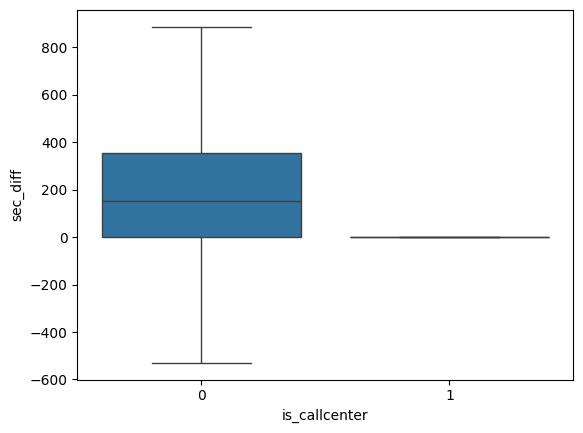

In [28]:
sns.boxplot(X_tr, y='sec_diff', x='is_callcenter', showfliers=False) # 0_0


<Axes: xlabel='is_callcenter', ylabel='density_sale'>

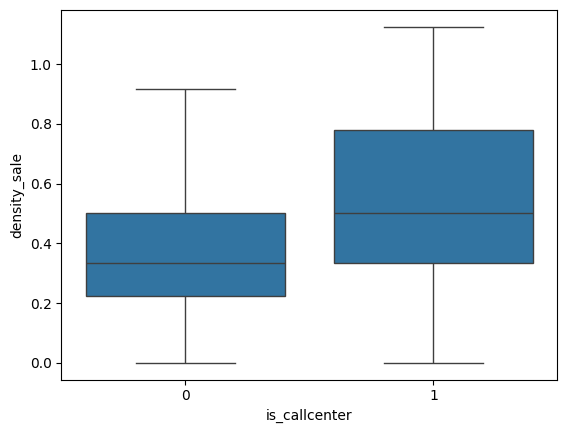

In [17]:
sns.boxplot(X_tr, y='density_sale', x='is_callcenter', showfliers=False) # 0_0


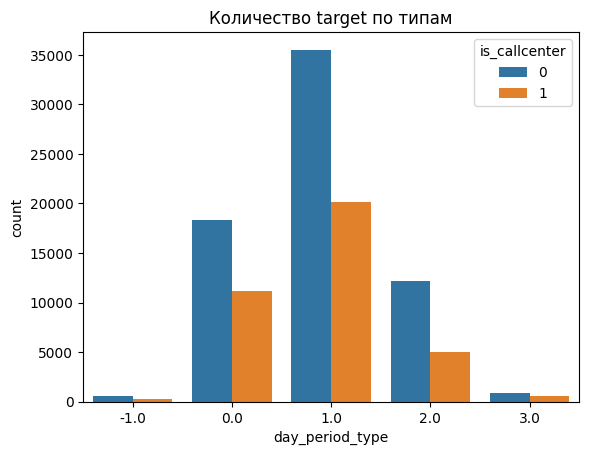

In [18]:

sns.countplot(x='day_period_type', hue='is_callcenter', data=X_tr)
plt.title('Количество target по типам')
plt.show()

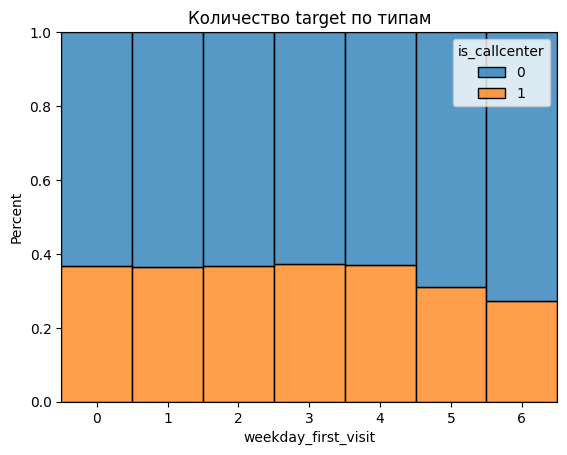

In [13]:

sns.histplot(x='weekday_first_visit', hue='is_callcenter', data=X_tr, stat='percent', discrete=True, multiple='fill')
plt.title('Количество target по типам')
plt.show()

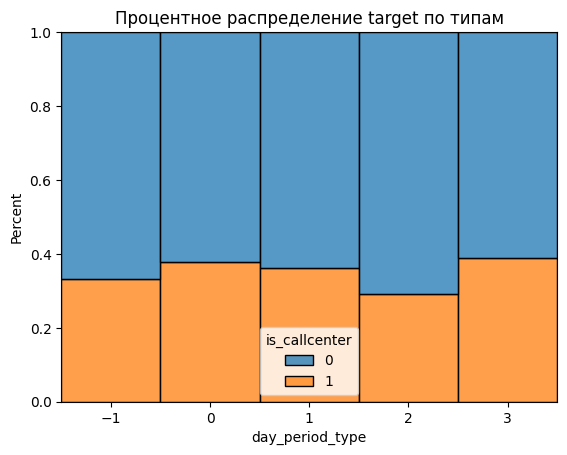

In [14]:
sns.histplot(x='day_period_type', hue='is_callcenter', data=X_tr, stat='percent', discrete=True, multiple='fill')
plt.title('Процентное распределение target по типам')
plt.show()

### Функция обучения модели catboost

In [40]:
from catboost import CatBoostClassifier, Pool
from sklearn.compose import ColumnTransformer
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import StandardScaler

params = {"score_function": 'L2',
          "depth": 6,
          "eta": 0.15,
          "eval_metric": 'AUC',
          "iterations": 1000,
          "verbose": 50,
          "use_best_model":True,
          "random_seed":42,
          "early_stopping_rounds":200
          }

def catboost_train_model(train, valid, test, features, params=params, plot=True):
    X_tr, y_tr = train[features], train['is_callcenter']
    X_val, y_val = valid[features], valid['is_callcenter']
    X_test, y_test = test[features], test['is_callcenter']

    cat_cols = X_tr.select_dtypes(include='object').columns.tolist()
    num_features = X_tr.select_dtypes(['float', 'int']).columns.tolist()

    preprocessor = ColumnTransformer([
        ('catboost', CatBoostEncoder(), cat_cols),
        ('scaler', StandardScaler(), num_features),
        ],
        remainder='drop',
        verbose_feature_names_out=False
    )

    X_tr_prepared = preprocessor.fit_transform(X_tr, y_tr)
    X_val_prepared = preprocessor.transform(X_val)
    X_test_prepared = preprocessor.transform(X_test)

    train_pool_baseline = Pool(X_tr_prepared, y_tr)
    valid_pool_baseline = Pool(X_val_prepared, y_val)

    model_cb= CatBoostClassifier(**params)

    model_cb.fit(train_pool_baseline, eval_set=valid_pool_baseline, plot=plot)
    metrics_cb_baseline, y_pred_cb, y_pred_cb_proba = catboost_metric(model_cb, X_test_prepared, y_test)
    print(metrics_cb_baseline)
    if plot:
        plot_confusion_matrix(y_test, y_pred_cb, title='CatBoost')
    return model_cb, metrics_cb_baseline

### Функция обучения модели Lightgbm


In [ ]:
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import StandardScaler

params_lgbm = {
    "learning_rate": 0.1,
    "max_leaves": 40, 
    "objective": 'binary',
    "early_stopping_rounds": 200,
    "random_seed":42
}

def lightgbm_train_model(train, valid, test, features, params=params_lgbm):

    X_tr, y_tr = train[features], train['is_callcenter']
    X_val, y_val = valid[features], valid['is_callcenter']
    X_test, y_test = test[features], test['is_callcenter']

    cat_cols = X_tr.select_dtypes(include='object').columns.tolist()
    num_features = X_tr.select_dtypes(['float', 'int']).columns.tolist()

    preprocessor = ColumnTransformer([
        ('catboost', CatBoostEncoder(), cat_cols),
        ('scaler', StandardScaler(), num_features),
        ],
        remainder='drop',
        verbose_feature_names_out=False
    )

    X_tr_prepared = preprocessor.fit_transform(X_tr, y_tr)
    X_val_prepared = preprocessor.transform(X_val)
    X_test_prepared = preprocessor.transform(X_test)

    model_lgbm = lgb.LGBMClassifier(
        **params
    )
    model_lgbm.fit(X_tr_prepared, 
                    y_tr, 
                    eval_set=[(X_val_prepared, y_val)], 
                    eval_metric=['auc', 'cross_entropy'],
                    feature_name=features.tolist()
                    )
    
    metrics_lgb, y_pred_lgb_bin, y_pred_lgb_proba = lightgbm_metric(model_lgbm, X_test_prepared, y_test)
    plot_confusion_matrix(y_test, y_pred_lgb_bin, title='LightGBM')
    print(metrics_lgb)
    return model_lgbm

In [21]:
train_df[['day_period_type', 'weekday_first_visit']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 73216 entries, 87721 to 70481
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   day_period_type      73216 non-null  float64
 1   weekday_first_visit  73216 non-null  float64
dtypes: float64(2)
memory usage: 1.7 MB


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8757219	best: 0.8757219 (0)	total: 8.07ms	remaining: 4.59s
50:	test: 0.8927819	best: 0.8928260 (49)	total: 309ms	remaining: 3.15s
100:	test: 0.8931103	best: 0.8931583 (94)	total: 616ms	remaining: 2.86s
150:	test: 0.8930866	best: 0.8931583 (94)	total: 935ms	remaining: 2.59s
Stopped by overfitting detector  (80 iterations wait)

bestTest = 0.8931583353
bestIteration = 94

Shrink model to first 95 iterations.
{'Accuracy': 0.8279158699808795, 'Precision': 0.6936608031861932, 'Recall': 0.8303535955502582, 'F1-Score': 0.755877034358047, 'ROC-AUC': 0.8926670823087689}


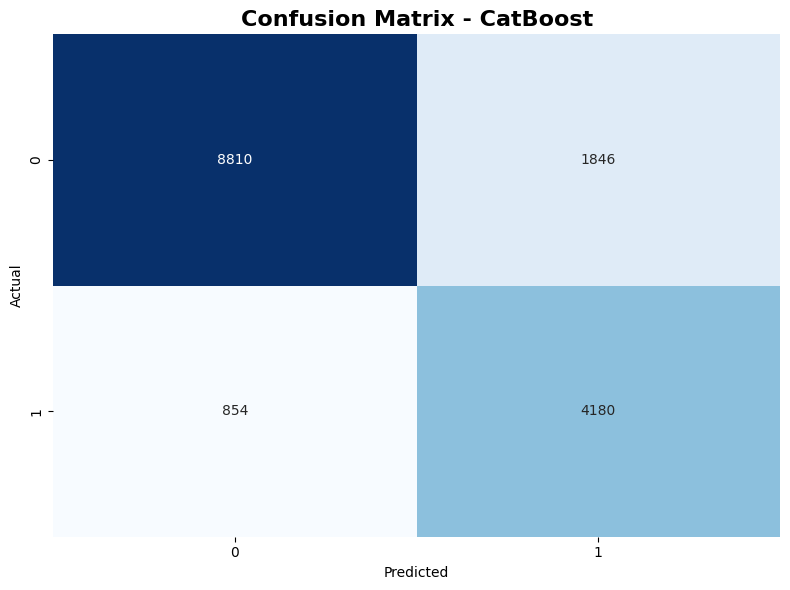

In [29]:
# params = {"score_function": 'L2',
#           "depth": 5,
#           "eta": 0.15,
#           "eval_metric": 'AUC',
#           "iterations": 500,
#           "verbose": 50}


features = session_agg.columns
model_cd = catboost_train_model(train_df, val_df, test_df, features, params)


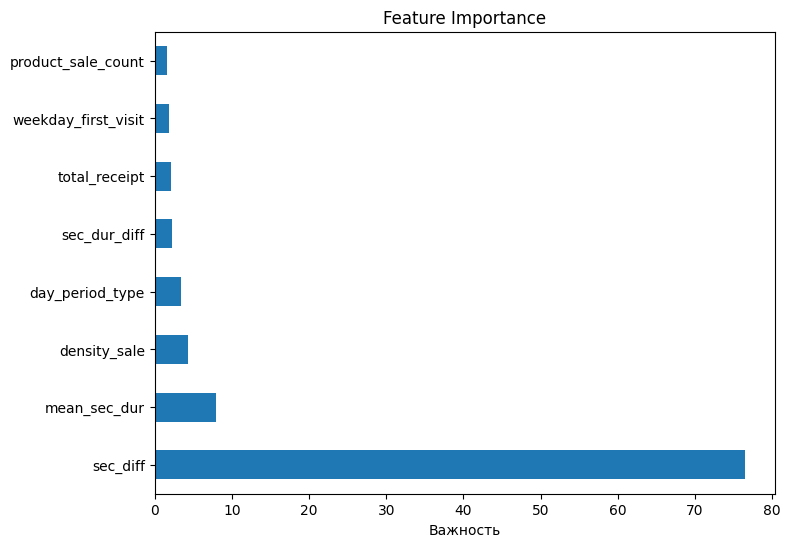

In [30]:
importances = pd.Series(model_cd.feature_importances_, index=features)
importances.nlargest(10).plot(kind='barh', figsize=(8, 6))
plt.title('Feature Importance')
plt.xlabel('Важность')
plt.show()

[LightGBM] [Warning] num_leaves is set=31, max_leaves=40 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] early_stopping_round is set=80, early_stopping_rounds=80 will be ignored. Current value: early_stopping_round=80
[LightGBM] [Warning] num_leaves is set=31, max_leaves=40 will be ignored. Current value: num_leaves=31
[LightGBM] [Info] Number of positive: 26400, number of negative: 46816
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 73216.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 73216, number of used features: 8
[LightGBM] [Warning] num_leaves is set=31, max_leaves=40 will be ignored. Current 

f:\Машинное обучение с ментором\Проект 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


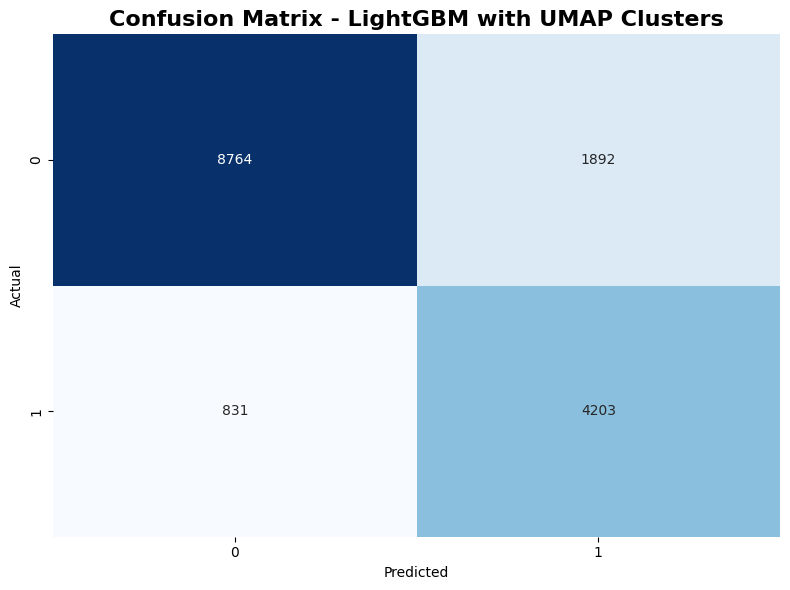

C:\Users\Armen\AppData\Local\Temp\ipykernel_63640\1943011296.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_counts.index, y=feature_counts.values, palette="viridis", ax=axes[0])


{'Accuracy': 0.8264499681325685, 'Precision': 0.6895816242821985, 'Recall': 0.83492252681764, 'F1-Score': 0.755323928475155, 'ROC-AUC': 0.8286849871325437}


C:\Users\Armen\AppData\Local\Temp\ipykernel_63640\1943011296.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
C:\Users\Armen\AppData\Local\Temp\ipykernel_63640\1943011296.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gain_means.values, y=gain_means.index, palette='mako')


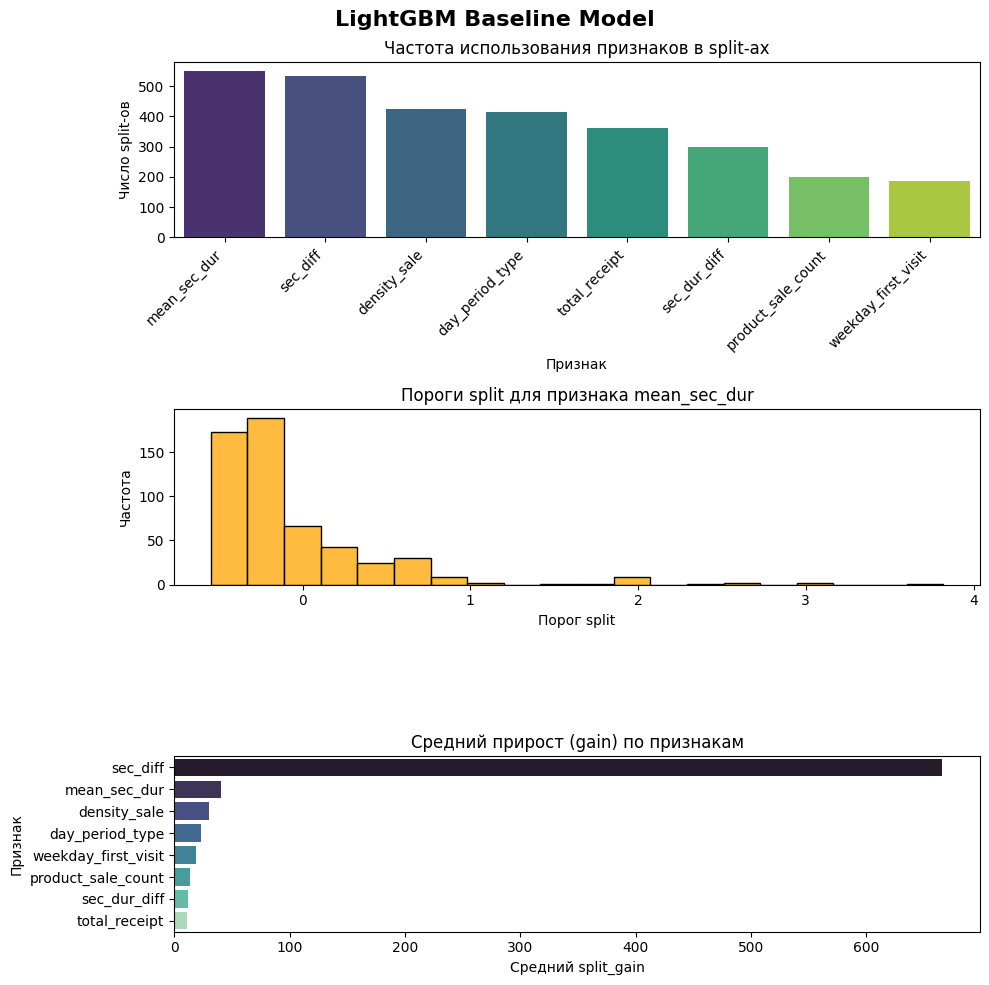

In [31]:

features = session_agg.columns
model_lgbm = lightgbm_train_model(train_df, val_df, test_df, features, params_lgbm)
tree_df = model_lgbm.booster_.trees_to_dataframe()
visualize_tree_splits(tree_df, title='LightGBM Baseline Model')

# Кластеризация

In [69]:
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold

features = session_agg.columns
X_tr, y_tr = train_df[features], train_df['is_callcenter']
X_temp, y_temp = temp[features], temp['is_callcenter']

k = 4
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
kmeans.fit(X_tr)

cluster_id_tr = kmeans.labels_
cluster_id_te = kmeans.predict(X_temp)

dist_tr = kmeans.transform(X_tr)   # (n_train, k)
dist_te = kmeans.transform(X_temp)   # (n_test,  k)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cluster_rate_oof = np.zeros(len(X_tr), dtype=float)
y_tr_np = np.asarray(y_tr)

for tr_idx, val_idx in skf.split(X_tr, y_tr):
    df_tr = pd.DataFrame({'c': cluster_id_tr[tr_idx], 'y': y_tr_np[tr_idx]})
    rate_map = df_tr.groupby('c')['y'].mean()
    global_rate = df_tr['y'].mean()
    val_c = pd.Series(cluster_id_tr[val_idx])
    cluster_rate_oof[val_idx] = val_c.map(rate_map).fillna(global_rate).values

# Для test берём частоты из полного train
df_full_tr = pd.DataFrame({'c': cluster_id_tr, 'y': y_tr_np})
rate_map_full = df_full_tr.groupby('c')['y'].mean()
global_rate_full = df_full_tr['y'].mean()
cluster_rate_te = pd.Series(cluster_id_te).map(rate_map_full).fillna(global_rate_full).values


Xtr_feat = X_tr.copy()
Xtemp_feat = X_temp.copy()

Xtr_feat['cluster_id'] = cluster_id_tr
Xtemp_feat['cluster_id'] = cluster_id_te

for j in range(k):
    Xtr_feat[f'dist_c{j}'] = dist_tr[:, j]
    Xtemp_feat[f'dist_c{j}'] = dist_te[:, j]

Xtr_feat['cluster_rate'] = cluster_rate_oof
Xtemp_feat['cluster_rate'] = cluster_rate_te




In [70]:
features_clust = Xtr_feat.columns
Xtr_feat['is_callcenter'] = y_tr
Xtemp_feat['is_callcenter'] = y_temp

val_df_clust, test_df_clust = train_test_split(Xtemp_feat, test_size=0.5,
                                                  random_state=42, shuffle=False)

In [71]:
features_clust

Index(['product_sale_count', 'mean_sec_dur', 'total_receipt',
       'weekday_first_visit', 'day_period_type', 'sec_diff', 'density_sale',
       'sec_dur_diff', 'cluster_id', 'dist_c0', 'dist_c1', 'dist_c2',
       'dist_c3', 'cluster_rate'],
      dtype='object')

In [72]:
Xtr_feat[features_clust].info()

<class 'pandas.core.frame.DataFrame'>
Index: 73216 entries, 87721 to 70481
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_sale_count   73216 non-null  float64
 1   mean_sec_dur         73216 non-null  float64
 2   total_receipt        73216 non-null  float64
 3   weekday_first_visit  73216 non-null  float64
 4   day_period_type      73216 non-null  float64
 5   sec_diff             73216 non-null  float64
 6   density_sale         73216 non-null  float64
 7   sec_dur_diff         73216 non-null  float64
 8   cluster_id           73216 non-null  int32  
 9   dist_c0              73216 non-null  float64
 10  dist_c1              73216 non-null  float64
 11  dist_c2              73216 non-null  float64
 12  dist_c3              73216 non-null  float64
 13  cluster_rate         73216 non-null  float64
dtypes: float64(13), int32(1)
memory usage: 8.1 MB


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8757219	best: 0.8757219 (0)	total: 7.98ms	remaining: 7.98s
50:	test: 0.8924613	best: 0.8924643 (49)	total: 313ms	remaining: 5.83s
100:	test: 0.8931068	best: 0.8931122 (97)	total: 625ms	remaining: 5.56s
150:	test: 0.8929426	best: 0.8931300 (104)	total: 939ms	remaining: 5.28s
200:	test: 0.8923445	best: 0.8931300 (104)	total: 1.27s	remaining: 5.06s
250:	test: 0.8922187	best: 0.8931300 (104)	total: 1.61s	remaining: 4.79s
300:	test: 0.8918501	best: 0.8931300 (104)	total: 1.95s	remaining: 4.53s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8931300008
bestIteration = 104

Shrink model to first 105 iterations.
{'Accuracy': 0.8277884002549395, 'Precision': 0.6926635822868473, 'Recall': 0.8327373857767183, 'F1-Score': 0.7562691683204041, 'ROC-AUC': 0.8924515155053744}


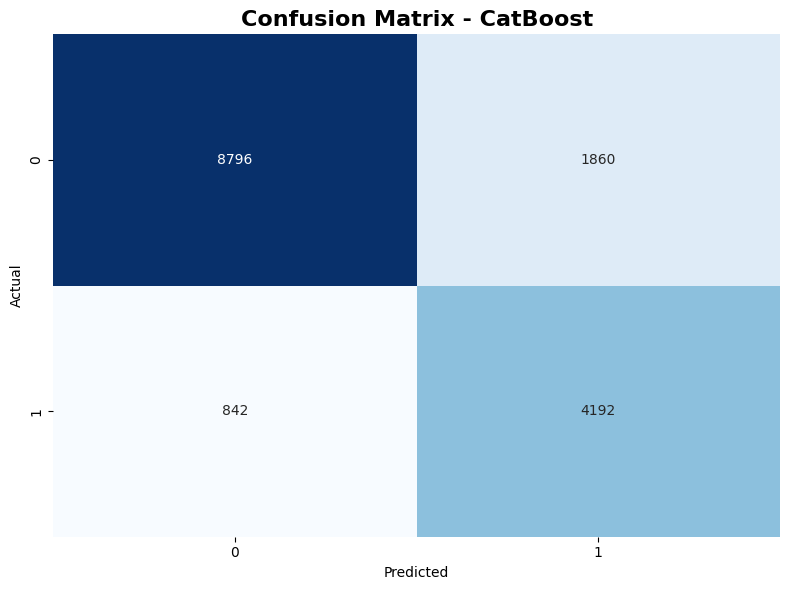

In [ ]:

model_cd_clust = catboost_train_model(Xtr_feat, val_df_clust, test_df_clust, features_clust, params)

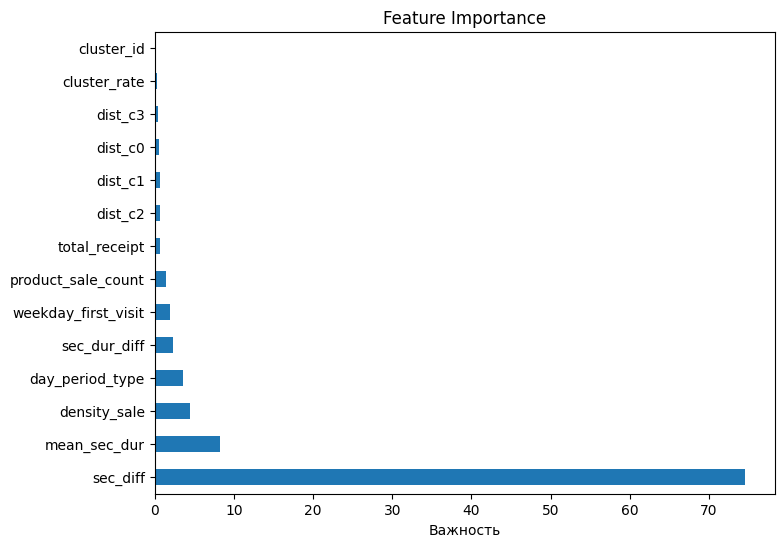

In [74]:
importances = pd.Series(model_cd_clust.feature_importances_, index=features_clust)
importances.nlargest(15).plot(kind='barh', figsize=(8, 6))
plt.title('Feature Importance')
plt.xlabel('Важность')
plt.show()

[LightGBM] [Warning] num_leaves is set=31, max_leaves=40 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] num_leaves is set=31, max_leaves=40 will be ignored. Current value: num_leaves=31
[LightGBM] [Info] Number of positive: 26400, number of negative: 46816
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 73216.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2421
[LightGBM] [Info] Number of data points in the train set: 73216, number of used features: 14
[LightGBM] [Warning] num_leaves is set=31, max_leaves=40 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] early_stopping_rou

f:\Машинное обучение с ментором\Проект 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


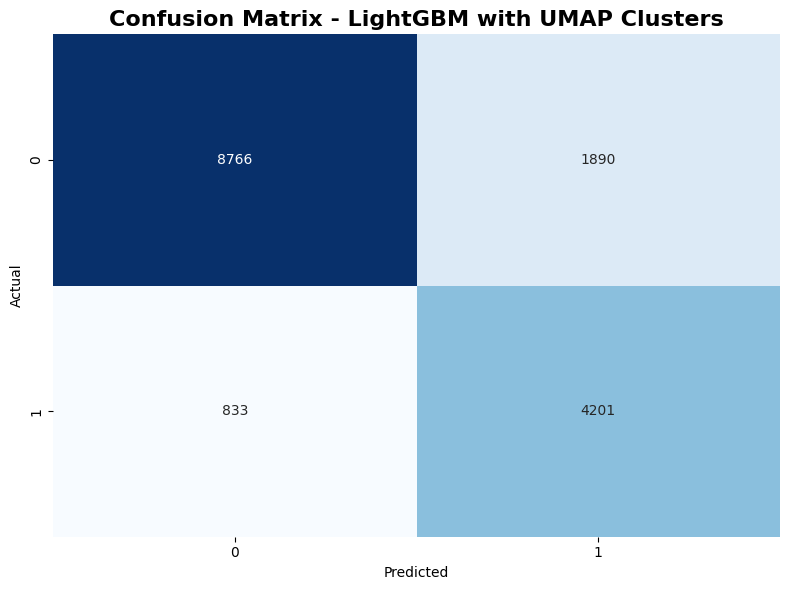

C:\Users\Armen\AppData\Local\Temp\ipykernel_63640\1943011296.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_counts.index, y=feature_counts.values, palette="viridis", ax=axes[0])
C:\Users\Armen\AppData\Local\Temp\ipykernel_63640\1943011296.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')


{'Accuracy': 0.8264499681325685, 'Precision': 0.6897061237891972, 'Recall': 0.8345252284465634, 'F1-Score': 0.7552359550561798, 'ROC-AUC': 0.8285801817908492}


C:\Users\Armen\AppData\Local\Temp\ipykernel_63640\1943011296.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gain_means.values, y=gain_means.index, palette='mako')


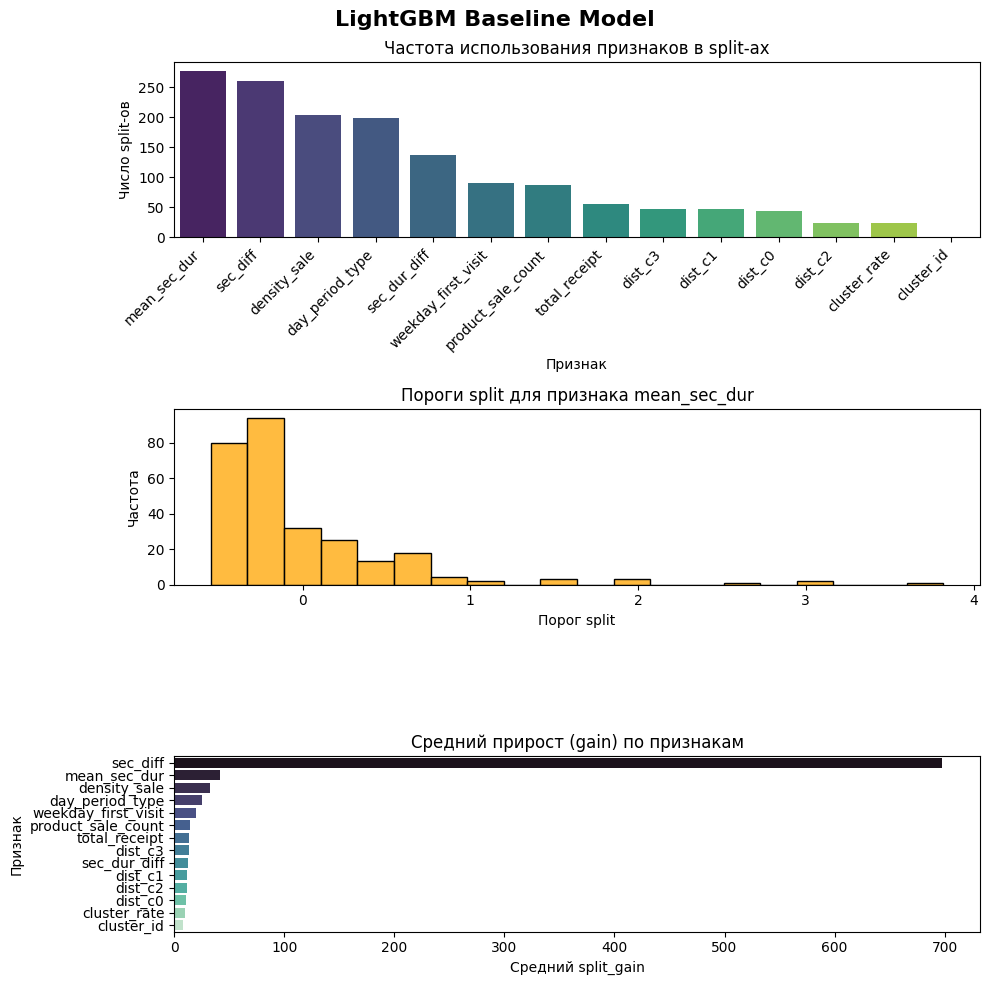

In [78]:
features = session_agg.columns
model_lgbm_cluster = lightgbm_train_model(Xtr_feat, val_df_clust, test_df_clust, features_clust, params_lgbm)
tree_df = model_lgbm_cluster.booster_.trees_to_dataframe()
visualize_tree_splits(tree_df, title='LightGBM Baseline Model')

# AutoFeatClassifier

In [141]:
from autofeat import AutoFeatClassifier

features = session_agg.columns
X_tr, y_tr = train_df[features], train_df['is_callcenter']
X_temp, y_temp = temp[features], temp['is_callcenter']

afreg = AutoFeatClassifier(feateng_steps=3, transformations=['1/', 'log', 'abs', 'sqrt'], max_gb=16,)
X_train_transformed = afreg.fit_transform(X_tr[:5000], y_tr[:5000])
X_test_transformed = afreg.transform(X_temp[:1500])

# перед concat нужно сбросить индекс - иначе несоответствие!
train_df_autofeat = pd.concat([X_train_transformed,
                               y_tr[:5000].reset_index(drop=True)], axis=1)
temp_df_autofeat = pd.concat([X_test_transformed.reset_index(drop=True),
                              y_temp[:1500].reset_index(drop=True)], axis=1)


f:\Машинное обучение с ментором\Проект 1\.venv\Lib\site-packages\autofeat\featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:
f:\Машинное обучение с ментором\Проект 1\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [142]:
features_autofeat = [col for col in train_df_autofeat.columns if col != 'is_callcenter']
val_df_autofeat, test_df_autofeat = train_test_split(temp_df_autofeat, test_size=0.5,
                                                  random_state=42, shuffle=False)

In [154]:
print(features_autofeat)

['product_sale_count', 'mean_sec_dur', 'total_receipt', 'weekday_first_visit', 'day_period_type', 'sec_diff', 'density_sale', 'sec_dur_diff', 'sqrt(-sec_diff + Abs(sec_diff))', 'sqrt(density_sale + Abs(sec_diff))', 'sqrt(density_sale*sqrt(sec_dur_diff))', 'sec_dur_diff**(1/4)*sqrt(Abs(mean_sec_dur))', 'sqrt(product_sale_count)*sqrt(Abs(mean_sec_dur))', 'sqrt(-sqrt(density_sale) + sqrt(product_sale_count))', 'sqrt(density_sale*sqrt(total_receipt))', 'mean_sec_dur*sec_dur_diff', 'Abs(density_sale*sec_diff)', 'mean_sec_dur*Abs(mean_sec_dur)', 'product_sale_count*total_receipt', 'sqrt(sec_dur_diff + Abs(sec_diff))', 'sqrt(total_receipt)*sqrt(Abs(sec_diff))', 'weekday_first_visit*Abs(day_period_type)', 'sqrt(product_sale_count + sqrt(sec_dur_diff))', 'sec_diff*weekday_first_visit', 'sqrt(mean_sec_dur + Abs(sec_diff))', 'sec_dur_diff**(1/4)*sqrt(Abs(sec_diff))', 'sec_dur_diff*Abs(mean_sec_dur)', 'sec_dur_diff*weekday_first_visit', 'sqrt(density_sale)*Abs(day_period_type)', 'Abs(density_sale 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8715084	best: 0.8715084 (0)	total: 2.32ms	remaining: 2.31s
50:	test: 0.9036266	best: 0.9039335 (48)	total: 105ms	remaining: 1.96s
100:	test: 0.9029565	best: 0.9057191 (87)	total: 209ms	remaining: 1.86s
150:	test: 0.9001977	best: 0.9057191 (87)	total: 313ms	remaining: 1.76s
200:	test: 0.8973864	best: 0.9057191 (87)	total: 420ms	remaining: 1.67s
250:	test: 0.8963869	best: 0.9057191 (87)	total: 524ms	remaining: 1.56s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9057191414
bestIteration = 87

Shrink model to first 88 iterations.
{'Accuracy': 0.8093333333333333, 'Precision': 0.7365079365079366, 'Recall': 0.7945205479452054, 'F1-Score': 0.7644151565074135, 'ROC-AUC': 0.8782751091703057}


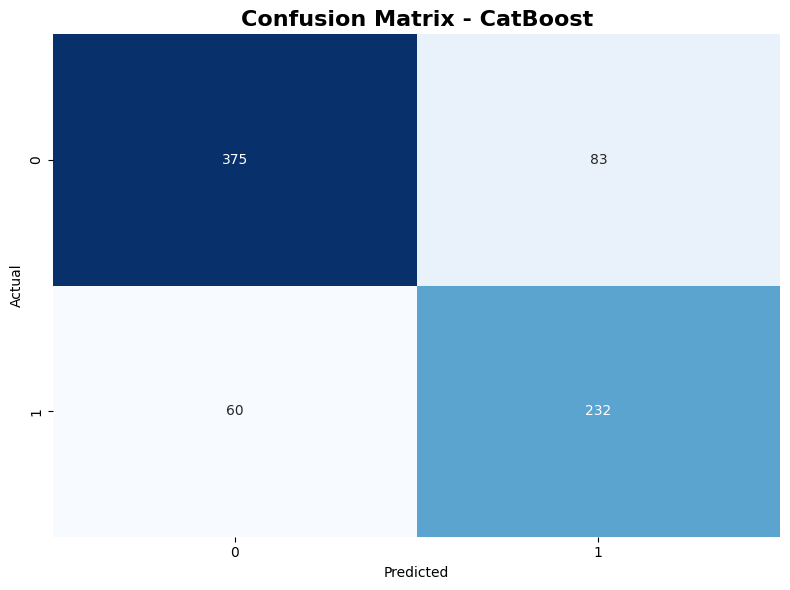

In [144]:
model_cd_autofeat = catboost_train_model(train_df_autofeat, val_df_autofeat, test_df_autofeat, features_autofeat, params)


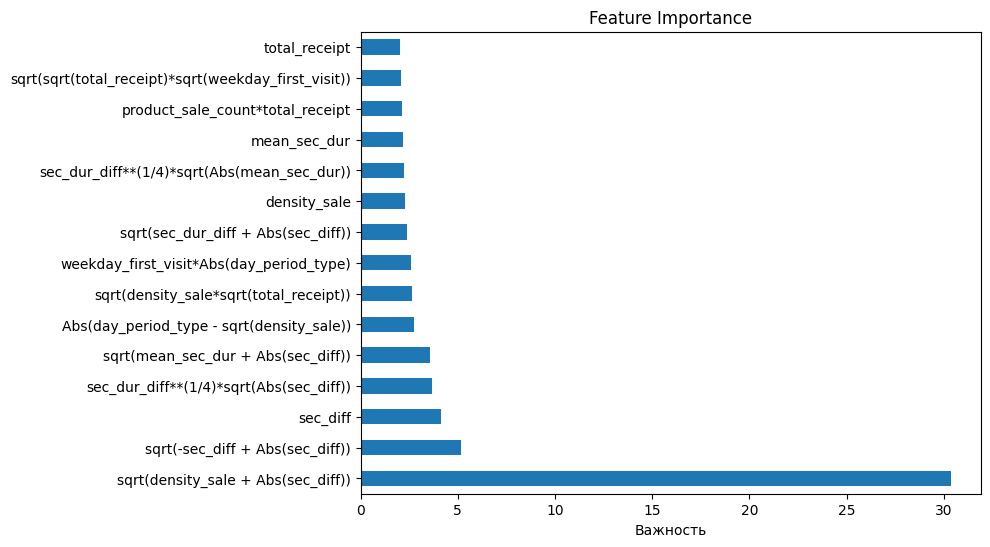

In [145]:
importances = pd.Series(model_cd_autofeat.feature_importances_, index=features_autofeat)
importances.nlargest(15).plot(kind='barh', figsize=(8, 6))
plt.title('Feature Importance')
plt.xlabel('Важность')
plt.show()

2025-11-10 05:31:00,352 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-10 05:31:00,359 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='is_callcenter', ylabel='sqrt(density_sale + Abs(sec_diff))'>

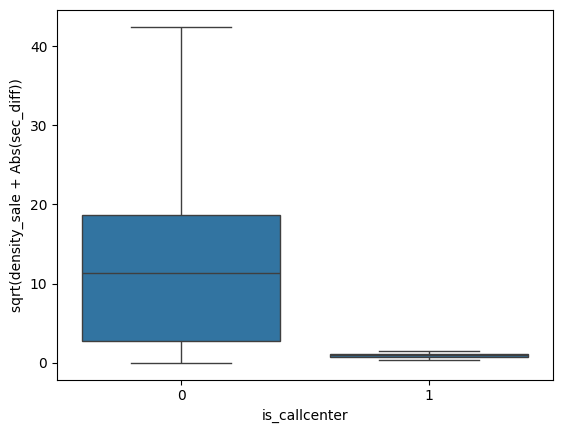

In [ ]:
sns.boxplot(train_df_autofeat, y='sqrt(density_sale + Abs(sec_diff))', x='is_callcenter', showfliers=False) # 0_0


2025-11-10 05:32:48,868 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-10 05:32:48,875 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='is_callcenter', ylabel='sec_diff'>

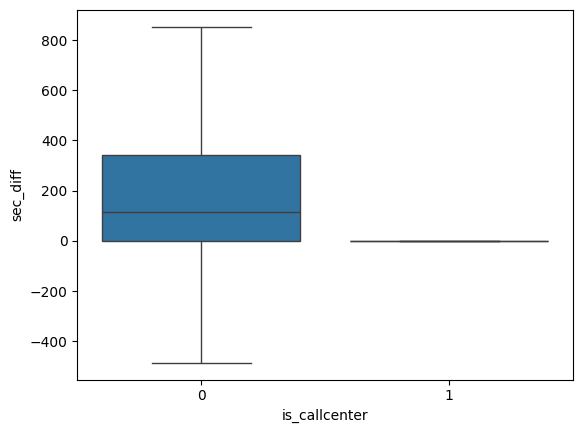

In [153]:
sns.boxplot(train_df_autofeat, y='sec_diff', x='is_callcenter', showfliers=False) # 0_0


2025-11-10 05:11:42,273 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-10 05:11:42,279 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='is_callcenter', ylabel='Abs(sec_diff - sec_dur_diff)'>

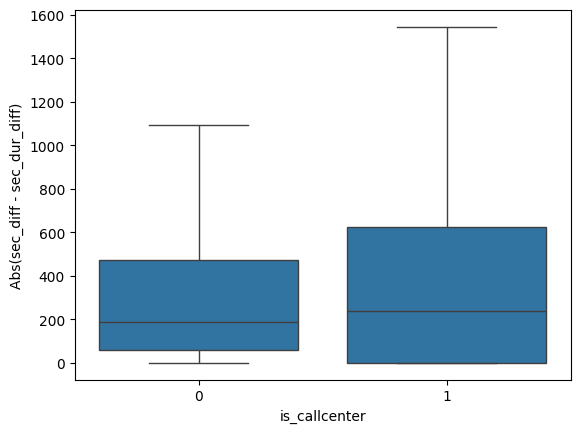

In [138]:
sns.boxplot(train_df_autofeat, y='Abs(sec_diff - sec_dur_diff)', x='is_callcenter', showfliers=False) # 0_0


2025-11-10 05:34:31,953 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-10 05:34:31,960 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='is_callcenter', ylabel='Abs(day_period_type - sqrt(density_sale))'>

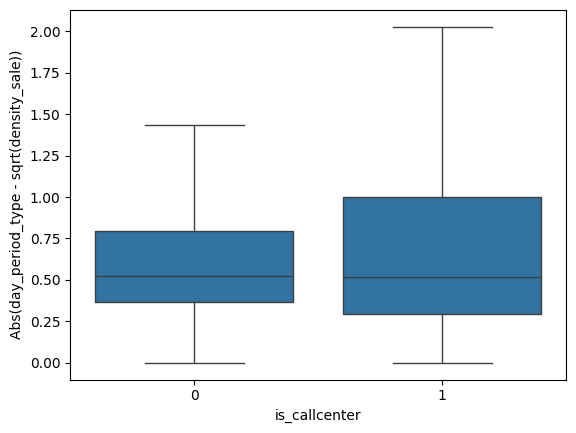

In [155]:
sns.boxplot(train_df_autofeat, y='Abs(day_period_type - sqrt(density_sale))', x='is_callcenter', showfliers=False) # 0_0


# Агрегируем новые признаки


In [ ]:
'mean_sec_dur', 'total_receipt', 'weekday_first_visit', 'day_period_type', 'sec_diff', 'density_sale', 'sec_dur_diff', 'sqrt(-sec_diff + Abs(sec_diff))', 'sec_dur_diff**(1/4)*sqrt(Abs(mean_sec_dur))', 'sqrt(density_sale*sqrt(total_receipt))', 'product_sale_count*total_receipt', 'sqrt(sec_dur_diff + Abs(sec_diff))', 'weekday_first_visit*Abs(day_period_type)', 'sqrt(mean_sec_dur + Abs(sec_diff))', 'sec_dur_diff**(1/4)*sqrt(Abs(sec_diff))','Abs(day_period_type - sqrt(density_sale))', 'sqrt(sqrt(total_receipt)*sqrt(weekday_first_visit))'

In [4]:
session_agg = web.groupby('sessionkey_id', sort=False).agg(
    product_sale_count=('product_in_sale', 'sum'),
    total_sec_dt=('date_time', lambda x: (x.iloc[-1] - x.iloc[0]).total_seconds()),
    total_sec_dur=('pageview_duration_sec', 'sum'),
    unique_pages_count=('pageview_number', 'nunique'),
    mean_sec_dur=('pageview_duration_sec', 'mean'),
    max_sec_dur=('pageview_duration_sec', 'max'),
    min_sec_dur=('pageview_duration_sec', 'min'),
    total_receipt=('price', 'sum'),
    weekday_first_visit=('date_time', lambda x: x.iloc[0].weekday()),
    day_period_type=('date_time', lambda x: 0 if 5 <= x.iloc[0].hour < 12 else
                                            1 if 12 <= x.iloc[0].hour < 18 else
                                            2 if 18 <= x.iloc[0].hour < 23 else
                                            3 if 0 <= x.iloc[0].hour < 5 else -1)
)

session_agg['sec_diff'] = session_agg['total_sec_dt'] - session_agg['total_sec_dur']
session_agg['density_sale'] = session_agg['product_sale_count'] / session_agg['unique_pages_count']
session_agg['sec_dur_diff'] = session_agg['max_sec_dur'] - session_agg['min_sec_dur']
session_agg['sqrt(-sec_diff + Abs(sec_diff))'] = np.sqrt(np.abs(session_agg['sec_diff']))
session_agg['sec_dur_diff**(1/4)*sqrt(Abs(mean_sec_dur))'] = np.power(session_agg['sec_dur_diff'], 1/4) * np.sqrt(np.abs(session_agg['mean_sec_dur']))
session_agg['sqrt(density_sale*sqrt(total_receipt))'] = np.sqrt(session_agg['density_sale'] * np.sqrt(session_agg['total_receipt']))
session_agg['product_sale_count*total_receipt'] = session_agg['product_sale_count'] * session_agg['total_receipt']
session_agg['sqrt(sec_dur_diff + Abs(sec_diff))'] = np.sqrt(session_agg['sec_dur_diff'] + np.abs(session_agg['sec_diff']))
session_agg['weekday_first_visit*Abs(day_period_type)'] = session_agg['weekday_first_visit'] * np.abs(session_agg['day_period_type'])
session_agg['sqrt(mean_sec_dur + Abs(sec_diff))'] = np.sqrt(session_agg['mean_sec_dur'] + np.abs(session_agg['sec_diff']))
session_agg['sec_dur_diff**(1/4)*sqrt(Abs(sec_diff))'] = np.power(session_agg['sec_dur_diff'], 1/4) * np.sqrt(np.abs(session_agg['sec_diff']))
session_agg['Abs(day_period_type - sqrt(density_sale))'] = np.abs(session_agg['day_period_type'] - np.sqrt(session_agg['density_sale']))
session_agg['sqrt(sqrt(total_receipt)*sqrt(weekday_first_visit))'] = np.sqrt(np.sqrt(session_agg['total_receipt']) * np.sqrt(session_agg['weekday_first_visit']))


session_agg.drop(['max_sec_dur', 'unique_pages_count', 'min_sec_dur', 'total_sec_dt', 'total_sec_dur'], axis=1, inplace=True)

session_agg

,product_sale_count,mean_sec_dur,total_receipt,weekday_first_visit,day_period_type,sec_diff,density_sale,sec_dur_diff,sqrt(-sec_diff + Abs(sec_diff)),sec_dur_diff**(1/4)*sqrt(Abs(mean_sec_dur)),sqrt(density_sale*sqrt(total_receipt)),product_sale_count*total_receipt,sqrt(sec_dur_diff + Abs(sec_diff)),weekday_first_visit*Abs(day_period_type),sqrt(mean_sec_dur + Abs(sec_diff)),sec_dur_diff**(1/4)*sqrt(Abs(sec_diff)),Abs(day_period_type - sqrt(density_sale)),sqrt(sqrt(total_receipt)*sqrt(weekday_first_visit))
sessionkey_id,,,,,,,,,,,,,,,,,,
109996122,0.0,15.000000,0.0,4,1,-0.320,0.000000,16.0,0.565685,7.745967,0.000000,0.0,4.039802,4,3.914077,1.131371,1.000000,0.000000
110019268,1.0,82.500000,2986.0,4,1,0.560,0.333333,79.0,0.748331,27.079070,4.267876,2986.0,8.919641,4,9.113726,2.231006,0.422650,10.454119
110020180,1.0,NaN,4490.0,4,1,0.000,1.000000,NaN,0.000000,NaN,8.185809,4490.0,NaN,4,NaN,NaN,0.000000,11.576482
110040418,4.0,54.500000,2312.0,4,1,46.490,0.363636,265.0,6.818358,29.785831,4.181486,9248.0,17.649079,4,10.049378,27.510041,0.396977,9.806453
110044482,1.0,NaN,4490.0,4,1,0.000,1.000000,NaN,0.000000,NaN,8.185809,4490.0,NaN,4,NaN,NaN,0.000000,11.576482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134626779,0.0,22.000000,0.0,0,2,-22.000,0.000000,0.0,4.690416,0.000000,0.000000,0.0,4.690416,0,6.633250,0.000000,2.000000,0.000000
134627402,1.0,40.666667,411.0,0,2,54.784,0.142857,108.0,7.401621,20.557733,1.701811,411.0,12.758683,0,9.769886,23.860680,1.622036,0.000000
134628420,0.0,23.250000,0.0,0,2,180.624,0.000000,41.0,13.439643,12.201338,0.000000,0.0,14.887041,0,14.278445,34.008204,2.000000,0.000000


In [5]:
X_tr = train.merge(session_agg, how='left', on='sessionkey_id', sort=False)
X_tr.sort_values('create_time', inplace=True)

cat_features = X_tr.select_dtypes(include='object').columns.tolist()


X_tr[cat_features] = X_tr[cat_features].fillna("missing")
X_tr = X_tr.fillna(0)

# X = X_tr.drop(columns=['is_callcenter'])
# y = X_tr['is_callcenter']

# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, 
#                                                       random_state=42, shuffle=False)

# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5,
#                                                   random_state=42, shuffle=False)

train_df, temp = train_test_split(X_tr, test_size=0.3, 
                                    random_state=42, shuffle=False)

val_df, test_df = train_test_split(temp, test_size=0.5,
                                                  random_state=42, shuffle=False)

<Axes: xlabel='is_callcenter', ylabel='sqrt(-sec_diff + Abs(sec_diff))'>

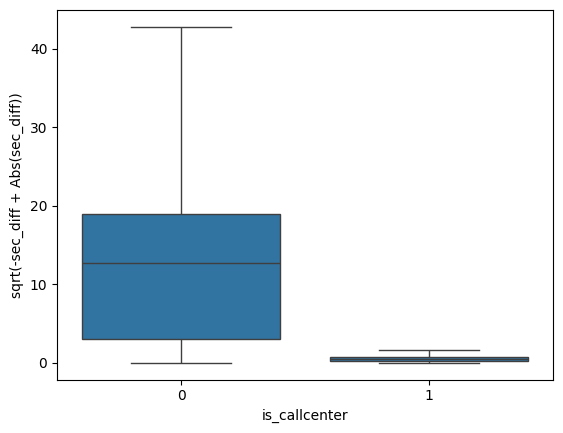

In [7]:
sns.boxplot(X_tr, y='sqrt(-sec_diff + Abs(sec_diff))', x='is_callcenter', showfliers=False) # 0_0


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8693241	best: 0.8693241 (0)	total: 10.5ms	remaining: 10.5s
50:	test: 0.8916020	best: 0.8916020 (50)	total: 316ms	remaining: 5.89s
100:	test: 0.8922479	best: 0.8923355 (96)	total: 602ms	remaining: 5.36s
150:	test: 0.8924869	best: 0.8925389 (144)	total: 910ms	remaining: 5.12s
200:	test: 0.8925050	best: 0.8926360 (188)	total: 1.23s	remaining: 4.88s
250:	test: 0.8926351	best: 0.8926431 (249)	total: 1.53s	remaining: 4.56s
300:	test: 0.8925618	best: 0.8926431 (249)	total: 1.83s	remaining: 4.26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8926431287
bestIteration = 249

Shrink model to first 250 iterations.
{'Accuracy': 0.8278521351179094, 'Precision': 0.6927143565174294, 'Recall': 0.8329360349622567, 'F1-Score': 0.7563813475241273, 'ROC-AUC': 0.8921546788892588}


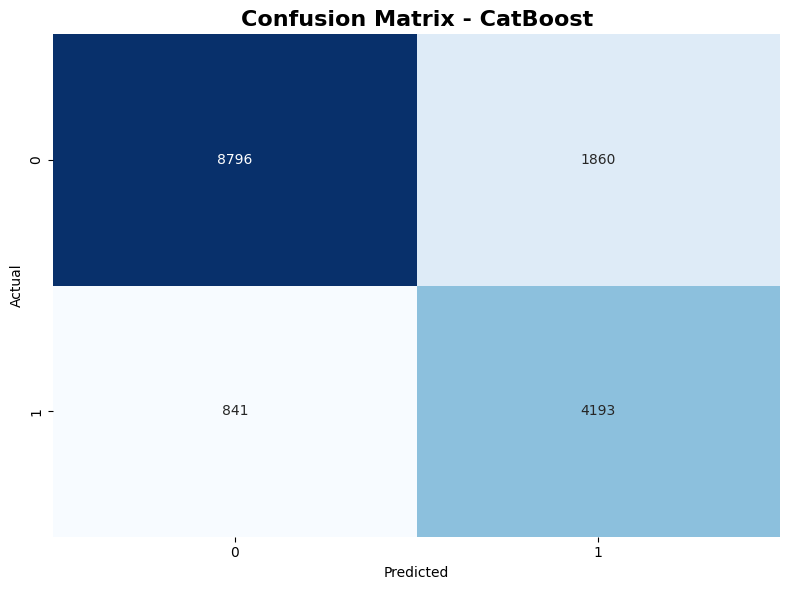

In [36]:

params = {"score_function": 'L2',
          "depth": 4,
          "eta": 0.1,
          "eval_metric": 'AUC',
          "iterations": 1000,
          "verbose": 50,
          "use_best_model":True,
          "random_seed":42,
          "early_stopping_rounds":100
          }
features_autofeat = [col for col in session_agg.columns if col != 'is_callcenter']

model_cd_autofeat = catboost_train_model(train_df, val_df, test_df, features_autofeat, params)

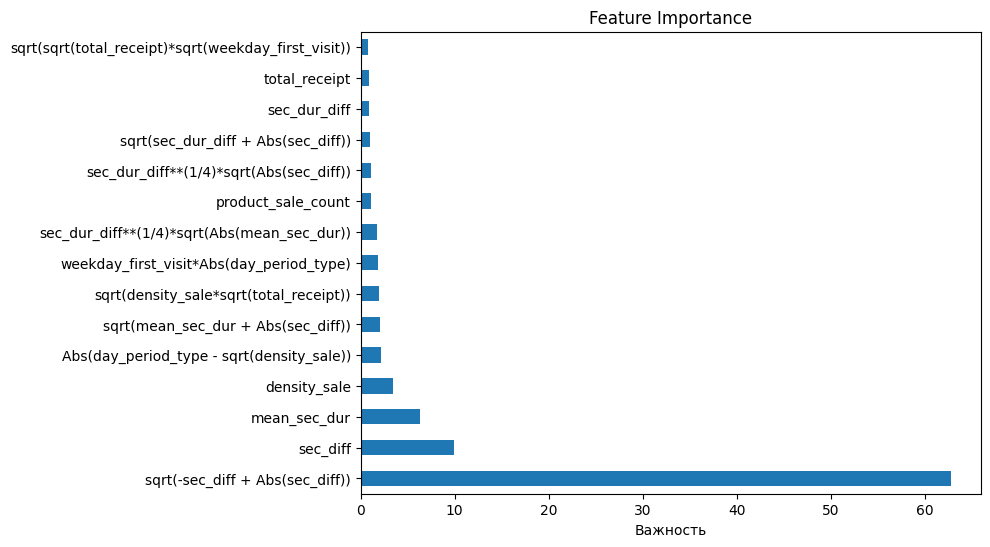

In [34]:
importances = pd.Series(model_cd_autofeat.feature_importances_, index=features_autofeat)
importances.nlargest(15).plot(kind='barh', figsize=(8, 6))
plt.title('Feature Importance')
plt.xlabel('Важность')
plt.show()

[LightGBM] [Warning] num_leaves is set=31, max_leaves=40 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] num_leaves is set=31, max_leaves=40 will be ignored. Current value: num_leaves=31
[LightGBM] [Info] Number of positive: 26400, number of negative: 46816
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 73216.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3683
[LightGBM] [Info] Number of data points in the train set: 73216, number of used features: 1

f:\Машинное обучение с ментором\Проект 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


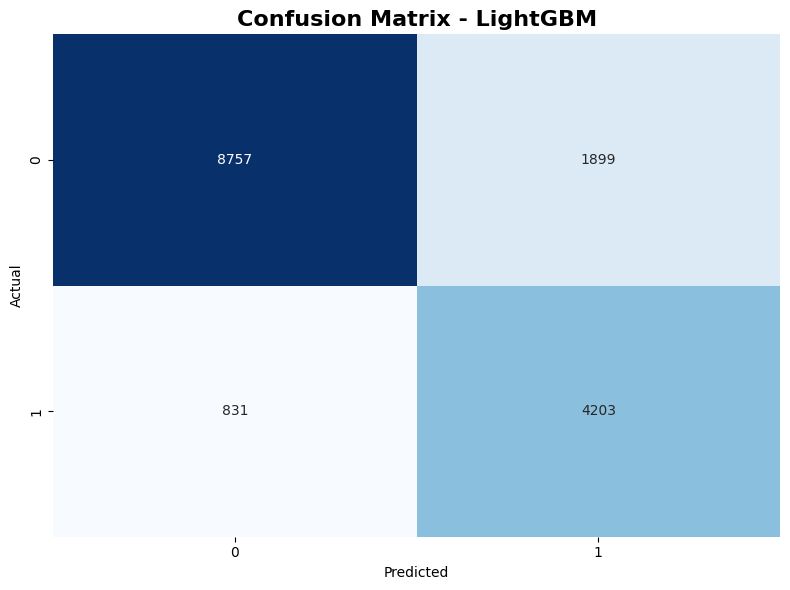

{'Accuracy': 0.8260038240917782, 'Precision': 0.6887905604719764, 'Recall': 0.83492252681764, 'F1-Score': 0.7548491379310345, 'ROC-AUC': 0.8283565336790903}


C:\Users\Armen\AppData\Local\Temp\ipykernel_15136\1943011296.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_counts.index, y=feature_counts.values, palette="viridis", ax=axes[0])
C:\Users\Armen\AppData\Local\Temp\ipykernel_15136\1943011296.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
C:\Users\Armen\AppData\Local\Temp\ipykernel_15136\1943011296.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gain_means.values, y=gain_means.index, palette='mako')


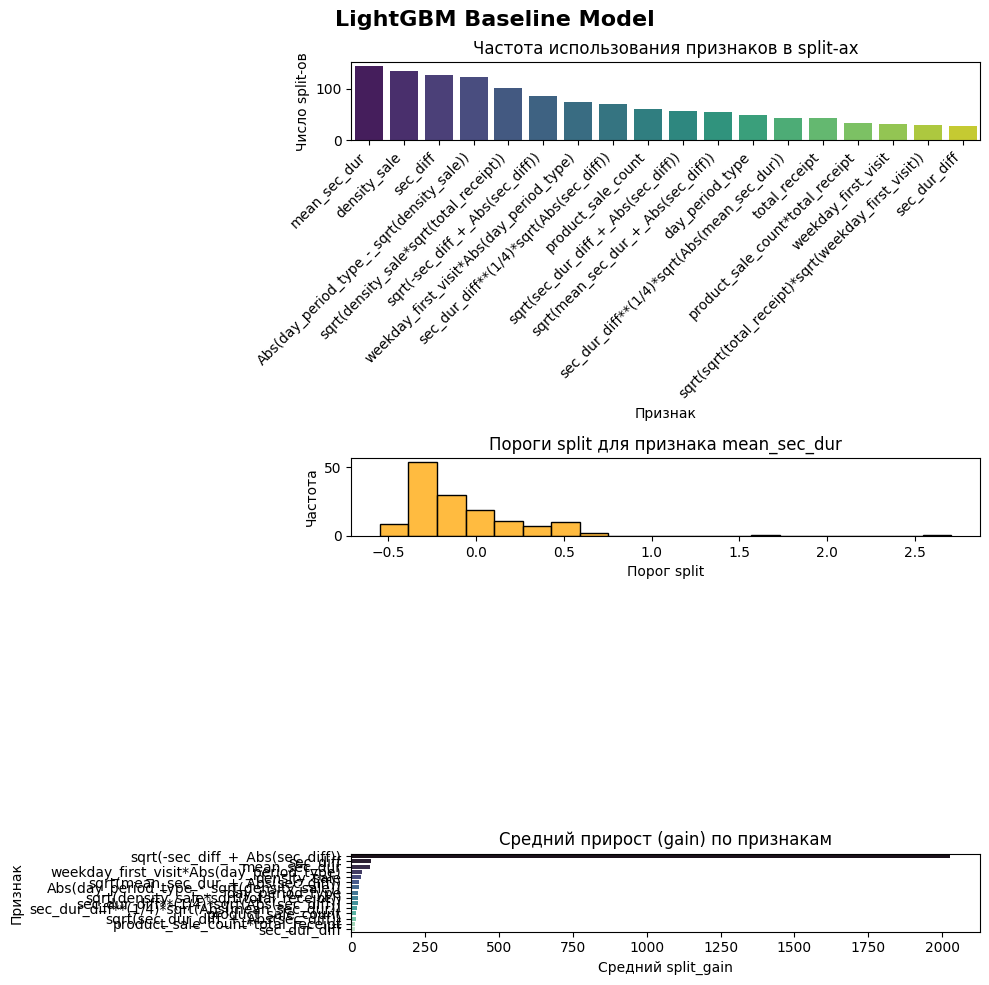

In [27]:
features_autofeat = pd.Series(features_autofeat)

model_lgbm_autofeat = lightgbm_train_model(train_df, val_df, test_df, features_autofeat, params_lgbm)
tree_df = model_lgbm_autofeat.booster_.trees_to_dataframe()
visualize_tree_splits(tree_df, title='LightGBM Baseline Model')

# Optuna


In [42]:
import optuna

features_autofeat = [col for col in session_agg.columns if col != 'is_callcenter']

def objective(trial):
    # предлагаем гиперпараметры
    param = {
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, log=True),
    "depth": trial.suggest_int("depth", 1, 12),
    "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 5),
    "random_strength": trial.suggest_float("random_strength", 0.1, 5),
    "loss_function": "Logloss",
    "task_type": "CPU",
    "random_seed": 0,
    "iterations": 300,
    "verbose": False,
    }
    # создаём и обучаем модель
    
    model_cd_autofeat, metrics = catboost_train_model(train_df, val_df, test_df, features_autofeat, param, plot=False)
    f1_score = metrics['F1-Score']

    return f1_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

# выводим результаты
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params) 

[I 2025-11-10 23:17:10,869] A new study created in memory with name: no-name-f5ffa393-9cf1-4242-8361-a5458aff83c1
[I 2025-11-10 23:17:12,655] Trial 0 finished with value: 0.7538775148453426 and parameters: {'learning_rate': 0.014147117377471933, 'depth': 3, 'l2_leaf_reg': 2.0857188480097597, 'random_strength': 3.891882953125557}. Best is trial 0 with value: 0.7538775148453426.


{'Accuracy': 0.8230082855321861, 'Precision': 0.6805888942230757, 'Recall': 0.844854986094557, 'F1-Score': 0.7538775148453426, 'ROC-AUC': 0.8875117109063773}


[I 2025-11-10 23:17:14,222] Trial 1 finished with value: 0.75489400090212 and parameters: {'learning_rate': 0.1482907021764832, 'depth': 2, 'l2_leaf_reg': 2.7280512018380825, 'random_strength': 4.607521089971867}. Best is trial 1 with value: 0.75489400090212.


{'Accuracy': 0.8268323773103888, 'Precision': 0.6914559576929433, 'Recall': 0.8311481922924115, 'F1-Score': 0.75489400090212, 'ROC-AUC': 0.8913093945405478}


[I 2025-11-10 23:17:17,774] Trial 2 finished with value: 0.7556078147612156 and parameters: {'learning_rate': 0.09148855471453157, 'depth': 8, 'l2_leaf_reg': 4.04296441592975, 'random_strength': 2.7930240027035014}. Best is trial 2 with value: 0.7556078147612156.


{'Accuracy': 0.8277884002549395, 'Precision': 0.693623380936566, 'Recall': 0.8297576479936433, 'F1-Score': 0.7556078147612156, 'ROC-AUC': 0.8920868592818086}


[I 2025-11-10 23:17:19,838] Trial 3 finished with value: 0.7558643089137496 and parameters: {'learning_rate': 0.09936901730820967, 'depth': 4, 'l2_leaf_reg': 4.778663873330303, 'random_strength': 0.30442264171399325}. Best is trial 3 with value: 0.7558643089137496.


{'Accuracy': 0.8275334608030592, 'Precision': 0.692396694214876, 'Recall': 0.8321414382201033, 'F1-Score': 0.7558643089137496, 'ROC-AUC': 0.8923395609554728}


[I 2025-11-10 23:17:34,159] Trial 4 finished with value: 0.7535390199637023 and parameters: {'learning_rate': 0.08152163929748599, 'depth': 10, 'l2_leaf_reg': 1.4732806642159697, 'random_strength': 4.100133835084027}. Best is trial 3 with value: 0.7558643089137496.


{'Accuracy': 0.8268961121733588, 'Precision': 0.6936184430337454, 'Recall': 0.8247914183551848, 'F1-Score': 0.7535390199637023, 'ROC-AUC': 0.8907997687795065}


[I 2025-11-10 23:18:32,011] Trial 5 finished with value: 0.7550317316409791 and parameters: {'learning_rate': 0.021773777237951975, 'depth': 12, 'l2_leaf_reg': 1.1430963974659323, 'random_strength': 3.6631959262725258}. Best is trial 3 with value: 0.7558643089137496.


{'Accuracy': 0.8277884002549395, 'Precision': 0.694462975316878, 'Recall': 0.8271752085816448, 'F1-Score': 0.7550317316409791, 'ROC-AUC': 0.8911482157813356}


[I 2025-11-10 23:18:45,675] Trial 6 finished with value: 0.7556602064843325 and parameters: {'learning_rate': 0.015223887358021871, 'depth': 10, 'l2_leaf_reg': 0.21984323500365185, 'random_strength': 2.3132626910001037}. Best is trial 3 with value: 0.7558643089137496.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6944074567243675, 'Recall': 0.8287644020659515, 'F1-Score': 0.7556602064843325, 'ROC-AUC': 0.8912859335795867}


[I 2025-11-10 23:18:59,470] Trial 7 finished with value: 0.7546117160082786 and parameters: {'learning_rate': 0.2569998461881596, 'depth': 10, 'l2_leaf_reg': 0.14211692375367235, 'random_strength': 4.662982357931575}. Best is trial 3 with value: 0.7558643089137496.


{'Accuracy': 0.8261950286806883, 'Precision': 0.6897516038822175, 'Recall': 0.8329360349622567, 'F1-Score': 0.7546117160082786, 'ROC-AUC': 0.8878822113979297}


[I 2025-11-10 23:19:28,768] Trial 8 finished with value: 0.7553678914742611 and parameters: {'learning_rate': 0.3767163127207276, 'depth': 11, 'l2_leaf_reg': 4.523700523741111, 'random_strength': 2.506616723162221}. Best is trial 3 with value: 0.7558643089137496.


{'Accuracy': 0.8264499681325685, 'Precision': 0.6895194357880925, 'Recall': 0.8351211760031784, 'F1-Score': 0.7553678914742611, 'ROC-AUC': 0.8887701952548496}


[I 2025-11-10 23:20:26,565] Trial 9 finished with value: 0.7545083824195741 and parameters: {'learning_rate': 0.04584433107477967, 'depth': 12, 'l2_leaf_reg': 1.166912491507406, 'random_strength': 3.7782433347625477}. Best is trial 3 with value: 0.7558643089137496.


{'Accuracy': 0.8273422562141491, 'Precision': 0.693717713714381, 'Recall': 0.8269765593961065, 'F1-Score': 0.7545083824195741, 'ROC-AUC': 0.8900143718659065}


[I 2025-11-10 23:20:29,394] Trial 10 finished with value: 0.7581782035062353 and parameters: {'learning_rate': 0.18372909354858627, 'depth': 5, 'l2_leaf_reg': 3.6712473140698414, 'random_strength': 0.3393504719423869}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.8294455066921607, 'Precision': 0.6954575596816976, 'Recall': 0.8333333333333334, 'F1-Score': 0.7581782035062353, 'ROC-AUC': 0.8921551449393375}


[I 2025-11-10 23:20:32,244] Trial 11 finished with value: 0.7568005764727076 and parameters: {'learning_rate': 0.19438492143300834, 'depth': 5, 'l2_leaf_reg': 3.495688069165183, 'random_strength': 0.11834778130032417}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6923203691496375, 'Recall': 0.8345252284465634, 'F1-Score': 0.7568005764727076, 'ROC-AUC': 0.8919488804955134}


[I 2025-11-10 23:20:35,396] Trial 12 finished with value: 0.7557961208840775 and parameters: {'learning_rate': 0.19978843280873412, 'depth': 6, 'l2_leaf_reg': 3.4473877407298885, 'random_strength': 0.16240219080169727}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.8274697259400893, 'Precision': 0.6922822673938192, 'Recall': 0.8321414382201033, 'F1-Score': 0.7557961208840775, 'ROC-AUC': 0.8915728806130325}


[I 2025-11-10 23:20:38,263] Trial 13 finished with value: 0.7533934590507425 and parameters: {'learning_rate': 0.4444956178080417, 'depth': 5, 'l2_leaf_reg': 3.3381377198317637, 'random_strength': 1.1430106760228345}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.8274697259400893, 'Precision': 0.695776543833081, 'Recall': 0.821414382201033, 'F1-Score': 0.7533934590507425, 'ROC-AUC': 0.8917973210099253}


[I 2025-11-10 23:20:40,120] Trial 14 finished with value: 0.7522741322970944 and parameters: {'learning_rate': 0.04093019353732539, 'depth': 1, 'l2_leaf_reg': 3.678940248176613, 'random_strength': 1.1150046377549143}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.8212237093690249, 'Precision': 0.6772141834949913, 'Recall': 0.846046881207787, 'F1-Score': 0.7522741322970944, 'ROC-AUC': 0.8860344626509704}


[I 2025-11-10 23:20:43,578] Trial 15 finished with value: 0.755092802172929 and parameters: {'learning_rate': 0.16247075921915194, 'depth': 7, 'l2_leaf_reg': 2.7053536126753808, 'random_strength': 0.8858940875566321}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.8275971956660293, 'Precision': 0.6937281650307769, 'Recall': 0.8283671036948749, 'F1-Score': 0.755092802172929, 'ROC-AUC': 0.8917819972833382}


[I 2025-11-10 23:20:46,367] Trial 16 finished with value: 0.7552055042549339 and parameters: {'learning_rate': 0.2835267373285111, 'depth': 5, 'l2_leaf_reg': 4.086779258329707, 'random_strength': 1.973235572259989}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.8276609305289994, 'Precision': 0.6937791084497671, 'Recall': 0.8285657528804132, 'F1-Score': 0.7552055042549339, 'ROC-AUC': 0.8916261874210325}


[I 2025-11-10 23:20:50,409] Trial 17 finished with value: 0.7551889785189885 and parameters: {'learning_rate': 0.04683771516674783, 'depth': 8, 'l2_leaf_reg': 3.0962207893028624, 'random_strength': 1.659008063735616}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6944490748458076, 'Recall': 0.8275725069527214, 'F1-Score': 0.7551889785189885, 'ROC-AUC': 0.8922534442219334}


[I 2025-11-10 23:20:52,924] Trial 18 finished with value: 0.7552536231884058 and parameters: {'learning_rate': 0.1229792512566177, 'depth': 4, 'l2_leaf_reg': 1.9481596082942734, 'random_strength': 0.5668807073790503}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6941391941391941, 'Recall': 0.8281684545093365, 'F1-Score': 0.7552536231884058, 'ROC-AUC': 0.8922476745219594}


[I 2025-11-10 23:20:56,373] Trial 19 finished with value: 0.7561990950226244 and parameters: {'learning_rate': 0.24412935991141804, 'depth': 7, 'l2_leaf_reg': 4.038993584938534, 'random_strength': 1.757991776591993}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.8282982791586998, 'Precision': 0.6944813829787234, 'Recall': 0.8299562971791815, 'F1-Score': 0.7561990950226244, 'ROC-AUC': 0.8908783355017711}


[I 2025-11-10 23:20:58,588] Trial 20 finished with value: 0.7533550961189699 and parameters: {'learning_rate': 0.06307772025762529, 'depth': 3, 'l2_leaf_reg': 4.988954812641346, 'random_strength': 2.972706243025107}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.8266411727214786, 'Precision': 0.6930263596930264, 'Recall': 0.8251887167262614, 'F1-Score': 0.7533550961189699, 'ROC-AUC': 0.8916005826297096}


[I 2025-11-10 23:21:01,727] Trial 21 finished with value: 0.7541043083900226 and parameters: {'learning_rate': 0.23770312911748895, 'depth': 6, 'l2_leaf_reg': 4.040880057289304, 'random_strength': 1.5677636810907256}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.827214786488209, 'Precision': 0.6938741445501586, 'Recall': 0.8257846642828764, 'F1-Score': 0.7541043083900226, 'ROC-AUC': 0.8917321112829157}


[I 2025-11-10 23:21:05,782] Trial 22 finished with value: 0.7546384288170875 and parameters: {'learning_rate': 0.3410690804661006, 'depth': 8, 'l2_leaf_reg': 4.430045201088389, 'random_strength': 0.6828332980444952}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.827214786488209, 'Precision': 0.6931005818786368, 'Recall': 0.8281684545093365, 'F1-Score': 0.7546384288170875, 'ROC-AUC': 0.8908291578974684}


[I 2025-11-10 23:21:09,256] Trial 23 finished with value: 0.7566645723005117 and parameters: {'learning_rate': 0.4856052650172209, 'depth': 7, 'l2_leaf_reg': 2.9987076249791165, 'random_strength': 0.10770232880414765}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.827214786488209, 'Precision': 0.6901915834288521, 'Recall': 0.8373063170441001, 'F1-Score': 0.7566645723005117, 'ROC-AUC': 0.8894709108691528}


[I 2025-11-10 23:21:12,047] Trial 24 finished with value: 0.7536754757824479 and parameters: {'learning_rate': 0.44387742315667134, 'depth': 5, 'l2_leaf_reg': 3.0490350390770846, 'random_strength': 0.13137710852059672}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.8259400892288081, 'Precision': 0.6902362464893441, 'Recall': 0.8299562971791815, 'F1-Score': 0.7536754757824479, 'ROC-AUC': 0.8905471696368598}


[I 2025-11-10 23:21:14,591] Trial 25 finished with value: 0.7543352601156069 and parameters: {'learning_rate': 0.4999550830346902, 'depth': 4, 'l2_leaf_reg': 2.2564228391170533, 'random_strength': 0.546180484479705}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.8266411727214786, 'Precision': 0.6916197416363035, 'Recall': 0.8295589988081049, 'F1-Score': 0.7543352601156069, 'ROC-AUC': 0.8906986918384415}


[I 2025-11-10 23:21:17,715] Trial 26 finished with value: 0.7547066848567531 and parameters: {'learning_rate': 0.1857002579478013, 'depth': 6, 'l2_leaf_reg': 3.550658774304751, 'random_strength': 1.2484245557850244}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6960241570206341, 'Recall': 0.8241954707985697, 'F1-Score': 0.7547066848567531, 'ROC-AUC': 0.8924770457286846}


[I 2025-11-10 23:21:21,132] Trial 27 finished with value: 0.7549968345844261 and parameters: {'learning_rate': 0.12610607072526214, 'depth': 7, 'l2_leaf_reg': 2.8844022783721135, 'random_strength': 0.755934338179215}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6930101278432674, 'Recall': 0.8291617004370282, 'F1-Score': 0.7549968345844261, 'ROC-AUC': 0.8916408027515}


[I 2025-11-10 23:21:26,358] Trial 28 finished with value: 0.7569519682195739 and parameters: {'learning_rate': 0.3332214895358235, 'depth': 9, 'l2_leaf_reg': 2.3738065985622563, 'random_strength': 0.10162502495336445}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.8284257488846399, 'Precision': 0.6938099966898378, 'Recall': 0.8327373857767183, 'F1-Score': 0.7569519682195739, 'ROC-AUC': 0.8896528102148632}


[I 2025-11-10 23:21:31,480] Trial 29 finished with value: 0.7547306473517429 and parameters: {'learning_rate': 0.3344930860657697, 'depth': 9, 'l2_leaf_reg': 2.276297617499283, 'random_strength': 1.3355722333105557}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6933954416902346, 'Recall': 0.8279698053237982, 'F1-Score': 0.7547306473517429, 'ROC-AUC': 0.8895807402306956}


[I 2025-11-10 23:21:33,661] Trial 30 finished with value: 0.7530651167014804 and parameters: {'learning_rate': 0.06162705304523526, 'depth': 3, 'l2_leaf_reg': 1.845097689170653, 'random_strength': 0.44426402758425876}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.8267049075844487, 'Precision': 0.6936590262673582, 'Recall': 0.8235995232419547, 'F1-Score': 0.7530651167014804, 'ROC-AUC': 0.8917674565208833}


[I 2025-11-10 23:21:38,814] Trial 31 finished with value: 0.7552674230145867 and parameters: {'learning_rate': 0.3171756346431223, 'depth': 9, 'l2_leaf_reg': 2.4192300299260747, 'random_strength': 0.16494266869324622}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.8267686424474188, 'Precision': 0.6907114624505929, 'Recall': 0.833134684147795, 'F1-Score': 0.7552674230145867, 'ROC-AUC': 0.8909556532098248}


[I 2025-11-10 23:21:41,611] Trial 32 finished with value: 0.7534308824865945 and parameters: {'learning_rate': 0.21749139673494644, 'depth': 5, 'l2_leaf_reg': 3.187178223218504, 'random_strength': 1.0103595470091347}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.827087316762269, 'Precision': 0.6944211760763948, 'Recall': 0.8234008740564164, 'F1-Score': 0.7534308824865945, 'ROC-AUC': 0.8920337202518371}


[I 2025-11-10 23:21:46,743] Trial 33 finished with value: 0.756864161849711 and parameters: {'learning_rate': 0.14727605314655934, 'depth': 9, 'l2_leaf_reg': 3.804420162914049, 'random_strength': 0.4240939962191119}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.8284257488846399, 'Precision': 0.6939383901954289, 'Recall': 0.8323400874056416, 'F1-Score': 0.756864161849711, 'ROC-AUC': 0.8920688604277698}


[I 2025-11-10 23:21:51,876] Trial 34 finished with value: 0.7568301067486882 and parameters: {'learning_rate': 0.1251946928100155, 'depth': 9, 'l2_leaf_reg': 3.6681385842103325, 'random_strength': 0.46545091817112216}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.8286806883365201, 'Precision': 0.6948504983388705, 'Recall': 0.8309495431068733, 'F1-Score': 0.7568301067486882, 'ROC-AUC': 0.8922084237843325}


[I 2025-11-10 23:21:56,994] Trial 35 finished with value: 0.7563222543352601 and parameters: {'learning_rate': 0.1272998766768494, 'depth': 9, 'l2_leaf_reg': 3.736131354845685, 'random_strength': 0.7207628840196807}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6934415369327592, 'Recall': 0.8317441398490266, 'F1-Score': 0.7563222543352601, 'ROC-AUC': 0.8920198692434985}


[I 2025-11-10 23:22:25,981] Trial 36 finished with value: 0.7580122434281599 and parameters: {'learning_rate': 0.10243334634876317, 'depth': 11, 'l2_leaf_reg': 4.458558760030674, 'random_strength': 0.4593961708683448}. Best is trial 10 with value: 0.7581782035062353.


{'Accuracy': 0.8286806883365201, 'Precision': 0.6931182087586434, 'Recall': 0.8363130711164084, 'F1-Score': 0.7580122434281599, 'ROC-AUC': 0.8917978336650118}


[I 2025-11-10 23:22:54,841] Trial 37 finished with value: 0.7582229431377849 and parameters: {'learning_rate': 0.09490172187278427, 'depth': 11, 'l2_leaf_reg': 4.4076886694506205, 'random_strength': 0.43485873508342476}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8289993626513703, 'Precision': 0.6938809170377701, 'Recall': 0.8357171235597934, 'F1-Score': 0.7582229431377849, 'ROC-AUC': 0.8915914294061643}


[I 2025-11-10 23:23:23,705] Trial 38 finished with value: 0.7559083528775031 and parameters: {'learning_rate': 0.086249068134744, 'depth': 11, 'l2_leaf_reg': 4.402908637316757, 'random_strength': 3.1488366746940657}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8275334608030592, 'Precision': 0.692333113020489, 'Recall': 0.8323400874056416, 'F1-Score': 0.7559083528775031, 'ROC-AUC': 0.890653401091795}


[I 2025-11-10 23:23:52,516] Trial 39 finished with value: 0.7551595599599964 and parameters: {'learning_rate': 0.10107677896472103, 'depth': 11, 'l2_leaf_reg': 4.883058784046637, 'random_strength': 4.2151699354098575}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6962279966471081, 'Recall': 0.8249900675407231, 'F1-Score': 0.7551595599599964, 'ROC-AUC': 0.8901721111755379}


[I 2025-11-10 23:24:50,201] Trial 40 finished with value: 0.756531959135702 and parameters: {'learning_rate': 0.035041497167291304, 'depth': 12, 'l2_leaf_reg': 4.670331457075567, 'random_strength': 2.1210900685731886}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6942093910735025, 'Recall': 0.8311481922924115, 'F1-Score': 0.756531959135702, 'ROC-AUC': 0.8917233122574302}


[I 2025-11-10 23:25:04,464] Trial 41 finished with value: 0.7544400144980066 and parameters: {'learning_rate': 0.1499701816621129, 'depth': 10, 'l2_leaf_reg': 4.254080354675046, 'random_strength': 0.41333766440920633}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6936021326224592, 'Recall': 0.8269765593961065, 'F1-Score': 0.7544400144980066, 'ROC-AUC': 0.8906441826212386}


[I 2025-11-10 23:25:33,388] Trial 42 finished with value: 0.7569375395462352 and parameters: {'learning_rate': 0.0751966723617206, 'depth': 11, 'l2_leaf_reg': 3.884743987106838, 'random_strength': 0.8480153208825786}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.82861695347355, 'Precision': 0.6944766959694808, 'Recall': 0.8317441398490266, 'F1-Score': 0.7569375395462352, 'ROC-AUC': 0.8913472378069368}


[I 2025-11-10 23:26:01,972] Trial 43 finished with value: 0.7558129014747127 and parameters: {'learning_rate': 0.0722398681587528, 'depth': 11, 'l2_leaf_reg': 4.632789667655091, 'random_strength': 0.9006902928259392}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6939690978567868, 'Recall': 0.8297576479936433, 'F1-Score': 0.7558129014747127, 'ROC-AUC': 0.8910708421472725}


[I 2025-11-10 23:26:59,665] Trial 44 finished with value: 0.7553671297131517 and parameters: {'learning_rate': 0.01057316518662293, 'depth': 12, 'l2_leaf_reg': 3.8745537049156042, 'random_strength': 0.8892531803839896}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.827151051625239, 'Precision': 0.6918374091209517, 'Recall': 0.8317441398490266, 'F1-Score': 0.7553671297131517, 'ROC-AUC': 0.8918102119551017}


[I 2025-11-10 23:27:13,867] Trial 45 finished with value: 0.7534146785649244 and parameters: {'learning_rate': 0.10005593874141475, 'depth': 10, 'l2_leaf_reg': 4.223785246356835, 'random_strength': 1.4315350047879902}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6955279085406859, 'Recall': 0.8218116805721096, 'F1-Score': 0.7534146785649244, 'ROC-AUC': 0.8911970485085801}


[I 2025-11-10 23:27:45,937] Trial 46 finished with value: 0.7561501167175435 and parameters: {'learning_rate': 0.05394918017019729, 'depth': 11, 'l2_leaf_reg': 1.4613916491081211, 'random_strength': 0.3281711156823439}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8268961121733588, 'Precision': 0.689875491480996, 'Recall': 0.8365117203019468, 'F1-Score': 0.7561501167175435, 'ROC-AUC': 0.8915105976805172}


[I 2025-11-10 23:28:44,581] Trial 47 finished with value: 0.7567323332730888 and parameters: {'learning_rate': 0.08642177643201736, 'depth': 12, 'l2_leaf_reg': 2.6508964281091956, 'random_strength': 0.6759250114557246}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8284257488846399, 'Precision': 0.694131299734748, 'Recall': 0.8317441398490266, 'F1-Score': 0.7567323332730888, 'ROC-AUC': 0.8909445798599553}


[I 2025-11-10 23:28:58,760] Trial 48 finished with value: 0.7559438040345822 and parameters: {'learning_rate': 0.030889791022954416, 'depth': 10, 'l2_leaf_reg': 0.7130361308641973, 'random_strength': 0.30069021443544575}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6914332784184514, 'Recall': 0.83373063170441, 'F1-Score': 0.7559438040345822, 'ROC-AUC': 0.8919888489502613}


[I 2025-11-10 23:29:30,729] Trial 49 finished with value: 0.7570295602018745 and parameters: {'learning_rate': 0.17348489757363575, 'depth': 11, 'l2_leaf_reg': 3.3355532497990485, 'random_strength': 1.1430469741261347}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8281708094327597, 'Precision': 0.6928406466512702, 'Recall': 0.834326579261025, 'F1-Score': 0.7570295602018745, 'ROC-AUC': 0.8909371696637044}


[I 2025-11-10 23:30:29,855] Trial 50 finished with value: 0.7563675636756367 and parameters: {'learning_rate': 0.16016291886805223, 'depth': 12, 'l2_leaf_reg': 3.380309188559097, 'random_strength': 1.0127895455802096}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8274697259400893, 'Precision': 0.6914596017771927, 'Recall': 0.8347238776321018, 'F1-Score': 0.7563675636756367, 'ROC-AUC': 0.8899539438127042}


[I 2025-11-10 23:31:00,339] Trial 51 finished with value: 0.7559679308170435 and parameters: {'learning_rate': 0.10638318970424679, 'depth': 11, 'l2_leaf_reg': 4.349427098649796, 'random_strength': 0.7731105826068234}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8273422562141491, 'Precision': 0.691610351079611, 'Recall': 0.8335319825188717, 'F1-Score': 0.7559679308170435, 'ROC-AUC': 0.8906102914595168}


[I 2025-11-10 23:31:30,658] Trial 52 finished with value: 0.7571467219767337 and parameters: {'learning_rate': 0.07115193342815308, 'depth': 11, 'l2_leaf_reg': 3.9728159843916995, 'random_strength': 0.29458344260301206}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6933113129644921, 'Recall': 0.8339292808899483, 'F1-Score': 0.7571467219767337, 'ROC-AUC': 0.8922904392771795}


[I 2025-11-10 23:31:44,795] Trial 53 finished with value: 0.7567958096270206 and parameters: {'learning_rate': 0.2793350646040688, 'depth': 10, 'l2_leaf_reg': 4.631106284344134, 'random_strength': 0.615231471914853}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6938234807087266, 'Recall': 0.8323400874056416, 'F1-Score': 0.7567958096270206, 'ROC-AUC': 0.890544103027342}


[I 2025-11-10 23:32:43,652] Trial 54 finished with value: 0.7544554455445545 and parameters: {'learning_rate': 0.18373156711858452, 'depth': 12, 'l2_leaf_reg': 4.11781226293528, 'random_strength': 0.3015642838748832}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8261312938177183, 'Precision': 0.6897630019749835, 'Recall': 0.8325387365911799, 'F1-Score': 0.7544554455445545, 'ROC-AUC': 0.8897069745550079}


[I 2025-11-10 23:32:47,786] Trial 55 finished with value: 0.7557687087141435 and parameters: {'learning_rate': 0.06224415034232672, 'depth': 8, 'l2_leaf_reg': 3.290081242115475, 'random_strength': 0.28070807305328704}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6940335715472827, 'Recall': 0.8295589988081049, 'F1-Score': 0.7557687087141435, 'ROC-AUC': 0.8920703611090233}


[I 2025-11-10 23:33:17,920] Trial 56 finished with value: 0.7577393808495321 and parameters: {'learning_rate': 0.39460878392859017, 'depth': 11, 'l2_leaf_reg': 4.7985674385949135, 'random_strength': 1.1241407149730922}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8284257488846399, 'Precision': 0.6926620598881211, 'Recall': 0.8363130711164084, 'F1-Score': 0.7577393808495321, 'ROC-AUC': 0.8901855427388056}


[I 2025-11-10 23:33:48,125] Trial 57 finished with value: 0.7546421489093204 and parameters: {'learning_rate': 0.11144529156428279, 'depth': 11, 'l2_leaf_reg': 4.514080823725084, 'random_strength': 1.8976152993758002}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8265137029955386, 'Precision': 0.6907590759075908, 'Recall': 0.8315454906634883, 'F1-Score': 0.7546421489093204, 'ROC-AUC': 0.8912657908951861}


[I 2025-11-10 23:33:50,186] Trial 58 finished with value: 0.7511533242876527 and parameters: {'learning_rate': 0.050451648671549276, 'depth': 2, 'l2_leaf_reg': 4.760440329309132, 'random_strength': 4.929473457896526}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8246653919694072, 'Precision': 0.6895864474339811, 'Recall': 0.8247914183551848, 'F1-Score': 0.7511533242876527, 'ROC-AUC': 0.8889927621304259}


[I 2025-11-10 23:34:04,372] Trial 59 finished with value: 0.7539610271353123 and parameters: {'learning_rate': 0.08010604167361018, 'depth': 10, 'l2_leaf_reg': 4.927439779499027, 'random_strength': 1.5226090705972637}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6960322797579018, 'Recall': 0.8224076281287247, 'F1-Score': 0.7539610271353123, 'ROC-AUC': 0.891348524105154}


[I 2025-11-10 23:34:33,345] Trial 60 finished with value: 0.755037498870516 and parameters: {'learning_rate': 0.21518764708397128, 'depth': 11, 'l2_leaf_reg': 3.961992848105436, 'random_strength': 1.2174168360371722}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.827214786488209, 'Precision': 0.6925244488645782, 'Recall': 0.8299562971791815, 'F1-Score': 0.755037498870516, 'ROC-AUC': 0.8900671753398214}


[I 2025-11-10 23:35:32,320] Trial 61 finished with value: 0.7565860700108265 and parameters: {'learning_rate': 0.28075119424336353, 'depth': 12, 'l2_leaf_reg': 2.8627627397005515, 'random_strength': 1.0321021865087288}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6930578512396695, 'Recall': 0.8329360349622567, 'F1-Score': 0.7565860700108265, 'ROC-AUC': 0.8895674298404485}


[I 2025-11-10 23:35:46,560] Trial 62 finished with value: 0.7555835734870316 and parameters: {'learning_rate': 0.40225900860199415, 'depth': 10, 'l2_leaf_reg': 3.590286373646979, 'random_strength': 0.5473076762286789}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8270235818992989, 'Precision': 0.6911037891268533, 'Recall': 0.8333333333333334, 'F1-Score': 0.7555835734870316, 'ROC-AUC': 0.8906994095555627}


[I 2025-11-10 23:36:15,460] Trial 63 finished with value: 0.7532210109018831 and parameters: {'learning_rate': 0.392827820023733, 'depth': 11, 'l2_leaf_reg': 4.268829095294303, 'random_strength': 0.1159523127441891}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8254302103250478, 'Precision': 0.6892003297609234, 'Recall': 0.8303535955502582, 'F1-Score': 0.7532210109018831, 'ROC-AUC': 0.8887113424509133}


[I 2025-11-10 23:36:29,655] Trial 64 finished with value: 0.7563116460048864 and parameters: {'learning_rate': 0.23468307320979448, 'depth': 10, 'l2_leaf_reg': 4.499762070685263, 'random_strength': 3.4384973860715533}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6945321588831643, 'Recall': 0.8301549463647199, 'F1-Score': 0.7563116460048864, 'ROC-AUC': 0.890380668585749}


[I 2025-11-10 23:37:28,588] Trial 65 finished with value: 0.7538308096835615 and parameters: {'learning_rate': 0.17917303035480886, 'depth': 12, 'l2_leaf_reg': 4.113012868880674, 'random_strength': 2.6643331423720946}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8269598470363289, 'Precision': 0.6934111759799834, 'Recall': 0.8257846642828764, 'F1-Score': 0.7538308096835615, 'ROC-AUC': 0.8894784235964214}


[I 2025-11-10 23:37:31,744] Trial 66 finished with value: 0.7553422672944585 and parameters: {'learning_rate': 0.317772125307265, 'depth': 6, 'l2_leaf_reg': 2.066247652343815, 'random_strength': 2.4332702485832813}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6940099833610649, 'Recall': 0.8285657528804132, 'F1-Score': 0.7553422672944585, 'ROC-AUC': 0.8913400047097156}


[I 2025-11-10 23:37:45,837] Trial 67 finished with value: 0.7543321299638989 and parameters: {'learning_rate': 0.1450921387848444, 'depth': 10, 'l2_leaf_reg': 2.5274231527769486, 'random_strength': 0.2852549686418321}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8265137029955386, 'Precision': 0.6912007939133311, 'Recall': 0.8301549463647199, 'F1-Score': 0.7543321299638989, 'ROC-AUC': 0.8906879540446286}


[I 2025-11-10 23:37:48,424] Trial 68 finished with value: 0.7547169811320755 and parameters: {'learning_rate': 0.11547156925548543, 'depth': 4, 'l2_leaf_reg': 4.851095549128188, 'random_strength': 0.557036424826328}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8268323773103888, 'Precision': 0.6917094158530531, 'Recall': 0.8303535955502582, 'F1-Score': 0.7547169811320755, 'ROC-AUC': 0.8922964047181866}


[I 2025-11-10 23:37:52,542] Trial 69 finished with value: 0.7560093981565155 and parameters: {'learning_rate': 0.09265107225345107, 'depth': 8, 'l2_leaf_reg': 3.21656151483345, 'random_strength': 1.1118122454947101}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6934681697612732, 'Recall': 0.8309495431068733, 'F1-Score': 0.7560093981565155, 'ROC-AUC': 0.8921388797915913}


[I 2025-11-10 23:37:57,815] Trial 70 finished with value: 0.7518248175182481 and parameters: {'learning_rate': 0.4521247345120717, 'depth': 9, 'l2_leaf_reg': 3.461184913651465, 'random_strength': 1.7823749807367428}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8266411727214786, 'Precision': 0.6952413094836315, 'Recall': 0.8184346444179579, 'F1-Score': 0.7518248175182481, 'ROC-AUC': 0.8897373610201381}


[I 2025-11-10 23:38:29,643] Trial 71 finished with value: 0.7575020275750203 and parameters: {'learning_rate': 0.07968438969469596, 'depth': 11, 'l2_leaf_reg': 3.9835563188368943, 'random_strength': 0.7641003427462421}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8284894837476099, 'Precision': 0.6932211776348343, 'Recall': 0.83492252681764, 'F1-Score': 0.7575020275750203, 'ROC-AUC': 0.8912997752669236}


[I 2025-11-10 23:39:01,323] Trial 72 finished with value: 0.754249547920434 and parameters: {'learning_rate': 0.06946976816076629, 'depth': 11, 'l2_leaf_reg': 3.9443582209542303, 'random_strength': 1.3093274134368371}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8267686424474188, 'Precision': 0.6921672751410555, 'Recall': 0.8285657528804132, 'F1-Score': 0.754249547920434, 'ROC-AUC': 0.8911811655218984}


[I 2025-11-10 23:39:33,442] Trial 73 finished with value: 0.7568836327525503 and parameters: {'learning_rate': 0.05532248730203604, 'depth': 11, 'l2_leaf_reg': 3.7441527979048104, 'random_strength': 0.6551359224939273}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6936951845110044, 'Recall': 0.8327373857767183, 'F1-Score': 0.7568836327525503, 'ROC-AUC': 0.8917667947297715}


[I 2025-11-10 23:40:30,149] Trial 74 finished with value: 0.7535369919798144 and parameters: {'learning_rate': 0.35367756655182647, 'depth': 12, 'l2_leaf_reg': 4.743466626063738, 'random_strength': 0.4616768217806436}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.825685149776928, 'Precision': 0.6895926109186871, 'Recall': 0.8305522447357966, 'F1-Score': 0.7535369919798144, 'ROC-AUC': 0.8887263026584391}


[I 2025-11-10 23:41:01,996] Trial 75 finished with value: 0.7569721115537849 and parameters: {'learning_rate': 0.09009754340787571, 'depth': 11, 'l2_leaf_reg': 4.189331584569115, 'random_strength': 0.8066047425866417}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8289356277884002, 'Precision': 0.6955074875207987, 'Recall': 0.8303535955502582, 'F1-Score': 0.7569721115537849, 'ROC-AUC': 0.8912618201485157}


[I 2025-11-10 23:41:33,880] Trial 76 finished with value: 0.7556879739978332 and parameters: {'learning_rate': 0.09193017282529396, 'depth': 11, 'l2_leaf_reg': 4.2021425147846045, 'random_strength': 0.8210924927353485}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8275334608030592, 'Precision': 0.6926514399205561, 'Recall': 0.8313468414779499, 'F1-Score': 0.7556879739978332, 'ROC-AUC': 0.8911195443804949}


[I 2025-11-10 23:42:32,910] Trial 77 finished with value: 0.7557720057720058 and parameters: {'learning_rate': 0.13575081914701187, 'depth': 12, 'l2_leaf_reg': 4.381632164091017, 'random_strength': 0.9542724562370136}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6921043937892303, 'Recall': 0.8323400874056416, 'F1-Score': 0.7557720057720058, 'ROC-AUC': 0.8910751670920025}


[I 2025-11-10 23:42:46,961] Trial 78 finished with value: 0.755652016639537 and parameters: {'learning_rate': 0.041131359369155705, 'depth': 10, 'l2_leaf_reg': 4.587558456017995, 'random_strength': 1.4152529284957653}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6935590969455512, 'Recall': 0.8299562971791815, 'F1-Score': 0.755652016639537, 'ROC-AUC': 0.891497986365388}


[I 2025-11-10 23:43:17,045] Trial 79 finished with value: 0.7574961500135882 and parameters: {'learning_rate': 0.07809552377900772, 'depth': 11, 'l2_leaf_reg': 3.61854459123704, 'random_strength': 1.1409291504656038}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8293817718291906, 'Precision': 0.6962531223980016, 'Recall': 0.8305522447357966, 'F1-Score': 0.7574961500135882, 'ROC-AUC': 0.8908049512563815}


[I 2025-11-10 23:43:19,946] Trial 80 finished with value: 0.7566588150027179 and parameters: {'learning_rate': 0.06760387522266428, 'depth': 5, 'l2_leaf_reg': 3.5936340057741223, 'random_strength': 1.1678603521496291}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8288081580624602, 'Precision': 0.6955363091272485, 'Recall': 0.8295589988081049, 'F1-Score': 0.7566588150027179, 'ROC-AUC': 0.8922682459724325}


[I 2025-11-10 23:43:50,054] Trial 81 finished with value: 0.7576058499593753 and parameters: {'learning_rate': 0.07952617428303327, 'depth': 11, 'l2_leaf_reg': 3.974735319893866, 'random_strength': 0.770310411187628}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8288718929254302, 'Precision': 0.6943571073969883, 'Recall': 0.8335319825188717, 'F1-Score': 0.7576058499593753, 'ROC-AUC': 0.8910500749557663}


[I 2025-11-10 23:44:20,402] Trial 82 finished with value: 0.75662955923613 and parameters: {'learning_rate': 0.07830418300750883, 'depth': 11, 'l2_leaf_reg': 4.012588184299401, 'random_strength': 0.4021969379630615}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.82861695347355, 'Precision': 0.6949293433083957, 'Recall': 0.8303535955502582, 'F1-Score': 0.75662955923613, 'ROC-AUC': 0.8911860776897279}


[I 2025-11-10 23:44:34,472] Trial 83 finished with value: 0.755363259419506 and parameters: {'learning_rate': 0.057661010311086815, 'depth': 10, 'l2_leaf_reg': 3.7581476191547143, 'random_strength': 0.6686528937905523}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8270235818992989, 'Precision': 0.6914191419141914, 'Recall': 0.8323400874056416, 'F1-Score': 0.755363259419506, 'ROC-AUC': 0.8915200771391177}


[I 2025-11-10 23:45:33,339] Trial 84 finished with value: 0.756936936936937 and parameters: {'learning_rate': 0.08110566060027162, 'depth': 12, 'l2_leaf_reg': 3.8935977258392658, 'random_strength': 1.0998149419884249}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6925486317177711, 'Recall': 0.8345252284465634, 'F1-Score': 0.756936936936937, 'ROC-AUC': 0.8909347648452981}


[I 2025-11-10 23:46:03,647] Trial 85 finished with value: 0.7548124717577949 and parameters: {'learning_rate': 0.06607490327700012, 'depth': 11, 'l2_leaf_reg': 3.4820932090347094, 'random_strength': 0.2088916704295826}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.827087316762269, 'Precision': 0.6924224838335268, 'Recall': 0.8295589988081049, 'F1-Score': 0.7548124717577949, 'ROC-AUC': 0.8906502039882552}


[I 2025-11-10 23:46:33,822] Trial 86 finished with value: 0.7554269175108539 and parameters: {'learning_rate': 0.10260500960233408, 'depth': 11, 'l2_leaf_reg': 4.337085938318246, 'random_strength': 1.5871817014981024}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8276609305289994, 'Precision': 0.6934573231484557, 'Recall': 0.8295589988081049, 'F1-Score': 0.7554269175108539, 'ROC-AUC': 0.8911686753797899}


[I 2025-11-10 23:47:32,735] Trial 87 finished with value: 0.7553469903438318 and parameters: {'learning_rate': 0.11686167133470501, 'depth': 12, 'l2_leaf_reg': 4.999538655800626, 'random_strength': 0.5323650164039453}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.827214786488209, 'Precision': 0.6920787167190342, 'Recall': 0.8313468414779499, 'F1-Score': 0.7553469903438318, 'ROC-AUC': 0.8910513239699771}


[I 2025-11-10 23:47:46,861] Trial 88 finished with value: 0.7554711521070718 and parameters: {'learning_rate': 0.07385421973085315, 'depth': 10, 'l2_leaf_reg': 3.618210597525542, 'random_strength': 0.9384162707363101}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8276609305289994, 'Precision': 0.6933930942895087, 'Recall': 0.8297576479936433, 'F1-Score': 0.7554711521070718, 'ROC-AUC': 0.8917337797421975}


[I 2025-11-10 23:47:49,440] Trial 89 finished with value: 0.7557845263919016 and parameters: {'learning_rate': 0.1650131966965878, 'depth': 4, 'l2_leaf_reg': 3.8298092666438683, 'random_strength': 0.7514770415485204}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6933665008291874, 'Recall': 0.8305522447357966, 'F1-Score': 0.7557845263919016, 'ROC-AUC': 0.8918397874930951}


[I 2025-11-10 23:48:19,789] Trial 90 finished with value: 0.7554151624548736 and parameters: {'learning_rate': 0.04930915723496563, 'depth': 11, 'l2_leaf_reg': 4.072009381302699, 'random_strength': 0.3645657226069155}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6921931855772412, 'Recall': 0.8313468414779499, 'F1-Score': 0.7554151624548736, 'ROC-AUC': 0.8918484933085649}


[I 2025-11-10 23:48:50,086] Trial 91 finished with value: 0.7549046198354579 and parameters: {'learning_rate': 0.08924500420946953, 'depth': 11, 'l2_leaf_reg': 4.184472648014432, 'random_strength': 0.870694540681003}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.827214786488209, 'Precision': 0.6927161108345777, 'Recall': 0.8293603496225666, 'F1-Score': 0.7549046198354579, 'ROC-AUC': 0.8906739818632696}


[I 2025-11-10 23:49:20,407] Trial 92 finished with value: 0.7564682467884929 and parameters: {'learning_rate': 0.09504074048013686, 'depth': 11, 'l2_leaf_reg': 4.45387232506989, 'random_strength': 0.735690891105858}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8284257488846399, 'Precision': 0.6945182724252492, 'Recall': 0.8305522447357966, 'F1-Score': 0.7564682467884929, 'ROC-AUC': 0.8909371789847059}


[I 2025-11-10 23:50:18,979] Trial 93 finished with value: 0.7549728752260397 and parameters: {'learning_rate': 0.059864055752306904, 'depth': 12, 'l2_leaf_reg': 3.981089617741891, 'random_strength': 0.5171676174461681}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6928310653833388, 'Recall': 0.8293603496225666, 'F1-Score': 0.7549728752260397, 'ROC-AUC': 0.8920400026068978}


[I 2025-11-10 23:50:33,341] Trial 94 finished with value: 0.7566056452340157 and parameters: {'learning_rate': 0.08617118600159218, 'depth': 10, 'l2_leaf_reg': 3.3476515811652905, 'random_strength': 1.3230952723193856}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6928158546655656, 'Recall': 0.8333333333333334, 'F1-Score': 0.7566056452340157, 'ROC-AUC': 0.8915816143915072}


[I 2025-11-10 23:51:03,619] Trial 95 finished with value: 0.7563465534375282 and parameters: {'learning_rate': 0.07371890638688507, 'depth': 11, 'l2_leaf_reg': 4.310301753427614, 'random_strength': 1.0201828188471183}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6936205468102734, 'Recall': 0.8315454906634883, 'F1-Score': 0.7563465534375282, 'ROC-AUC': 0.8919217284179293}


[I 2025-11-10 23:51:05,494] Trial 96 finished with value: 0.751417004048583 and parameters: {'learning_rate': 0.13525243724005973, 'depth': 1, 'l2_leaf_reg': 3.672541782475031, 'random_strength': 0.2460527115506221}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8239005736137668, 'Precision': 0.6867291563887519, 'Recall': 0.8295589988081049, 'F1-Score': 0.751417004048583, 'ROC-AUC': 0.8880980671523729}


[I 2025-11-10 23:51:35,870] Trial 97 finished with value: 0.7557162223226389 and parameters: {'learning_rate': 0.10966569153755287, 'depth': 11, 'l2_leaf_reg': 4.584112809767154, 'random_strength': 0.769124163421875}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6932515337423313, 'Recall': 0.8305522447357966, 'F1-Score': 0.7557162223226389, 'ROC-AUC': 0.890477765459142}


[I 2025-11-10 23:51:49,964] Trial 98 finished with value: 0.7560180995475113 and parameters: {'learning_rate': 0.09915817874371954, 'depth': 10, 'l2_leaf_reg': 4.1456345056901895, 'random_strength': 1.1958385704719547}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8281708094327597, 'Precision': 0.6943151595744681, 'Recall': 0.8297576479936433, 'F1-Score': 0.7560180995475113, 'ROC-AUC': 0.8910575503990283}


[I 2025-11-10 23:52:48,565] Trial 99 finished with value: 0.7546623212022452 and parameters: {'learning_rate': 0.021603003485802255, 'depth': 12, 'l2_leaf_reg': 4.753909885768071, 'random_strength': 1.4491652444598844}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6932801064537591, 'Recall': 0.8279698053237982, 'F1-Score': 0.7546623212022452, 'ROC-AUC': 0.891560651458968}


[I 2025-11-10 23:53:18,860] Trial 100 finished with value: 0.7551537070524412 and parameters: {'learning_rate': 0.08333191885164513, 'depth': 11, 'l2_leaf_reg': 3.123905621594379, 'random_strength': 0.669965362922939}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6929970129439097, 'Recall': 0.8295589988081049, 'F1-Score': 0.7551537070524412, 'ROC-AUC': 0.8906166390615885}


[I 2025-11-10 23:53:24,166] Trial 101 finished with value: 0.7559239571132534 and parameters: {'learning_rate': 0.21877231604466368, 'depth': 9, 'l2_leaf_reg': 2.949136957455226, 'random_strength': 0.1768194996726521}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6916735366859027, 'Recall': 0.8333333333333334, 'F1-Score': 0.7559239571132534, 'ROC-AUC': 0.891056133606789}


[I 2025-11-10 23:53:26,529] Trial 102 finished with value: 0.7546760639739767 and parameters: {'learning_rate': 0.2869930509477554, 'depth': 3, 'l2_leaf_reg': 3.8308513848258876, 'random_strength': 0.4084406782947282}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8269598470363289, 'Precision': 0.6921929388363998, 'Recall': 0.8295589988081049, 'F1-Score': 0.7546760639739767, 'ROC-AUC': 0.8916395723792923}


[I 2025-11-10 23:53:40,779] Trial 103 finished with value: 0.7548743992019589 and parameters: {'learning_rate': 0.4150921443041732, 'depth': 10, 'l2_leaf_reg': 2.5367640825115276, 'random_strength': 0.5997427805135673}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6944768897046555, 'Recall': 0.8267779102105681, 'F1-Score': 0.7548743992019589, 'ROC-AUC': 0.8887388207635526}


[I 2025-11-10 23:54:11,005] Trial 104 finished with value: 0.7544207867195958 and parameters: {'learning_rate': 0.3655141068131443, 'depth': 11, 'l2_leaf_reg': 2.1924792348167217, 'random_strength': 0.25474138119017775}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8265137029955386, 'Precision': 0.6910743801652892, 'Recall': 0.8305522447357966, 'F1-Score': 0.7544207867195958, 'ROC-AUC': 0.8888885719748354}


[I 2025-11-10 23:54:14,200] Trial 105 finished with value: 0.7566931982633864 and parameters: {'learning_rate': 0.06657274449691507, 'depth': 6, 'l2_leaf_reg': 4.444711353892207, 'random_strength': 0.46505263236351685}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.82855321861058, 'Precision': 0.6946197276652275, 'Recall': 0.8309495431068733, 'F1-Score': 0.7566931982633864, 'ROC-AUC': 0.8922625228774662}


[I 2025-11-10 23:54:19,399] Trial 106 finished with value: 0.7575620767494357 and parameters: {'learning_rate': 0.2645835209046351, 'depth': 9, 'l2_leaf_reg': 2.765812304726114, 'random_strength': 0.11134880135700626}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8288718929254302, 'Precision': 0.6944214534017547, 'Recall': 0.8333333333333334, 'F1-Score': 0.7575620767494357, 'ROC-AUC': 0.8913791435953236}


[I 2025-11-10 23:54:49,619] Trial 107 finished with value: 0.7562949640287769 and parameters: {'learning_rate': 0.1320035295914334, 'depth': 11, 'l2_leaf_reg': 3.5385024011407413, 'random_strength': 0.34642879771871005}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6909300032862307, 'Recall': 0.8353198251887167, 'F1-Score': 0.7562949640287769, 'ROC-AUC': 0.8910954682334301}


[I 2025-11-10 23:55:48,303] Trial 108 finished with value: 0.7566204287515763 and parameters: {'learning_rate': 0.26099826364956, 'depth': 12, 'l2_leaf_reg': 2.728586616353886, 'random_strength': 2.2398220004745797}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6921555702043507, 'Recall': 0.834326579261025, 'F1-Score': 0.7566204287515763, 'ROC-AUC': 0.8897829593598365}


[I 2025-11-10 23:56:02,405] Trial 109 finished with value: 0.7562873168083951 and parameters: {'learning_rate': 0.12038175067351406, 'depth': 10, 'l2_leaf_reg': 3.2611706640384175, 'random_strength': 0.8349546277788447}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8282982791586998, 'Precision': 0.6943521594684385, 'Recall': 0.8303535955502582, 'F1-Score': 0.7562873168083951, 'ROC-AUC': 0.8912194189123569}


[I 2025-11-10 23:56:04,495] Trial 110 finished with value: 0.7552586440371942 and parameters: {'learning_rate': 0.3022622498077522, 'depth': 2, 'l2_leaf_reg': 4.017686711568855, 'random_strength': 0.583890158705178}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.827214786488209, 'Precision': 0.692205858017541, 'Recall': 0.8309495431068733, 'F1-Score': 0.7552586440371942, 'ROC-AUC': 0.8911088997966977}


[I 2025-11-10 23:56:09,719] Trial 111 finished with value: 0.7579382927048665 and parameters: {'learning_rate': 0.25108553413155044, 'depth': 9, 'l2_leaf_reg': 3.41889602717823, 'random_strength': 0.16055318889942224}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8284894837476099, 'Precision': 0.6925858951175407, 'Recall': 0.8369090186730235, 'F1-Score': 0.7579382927048665, 'ROC-AUC': 0.8909591485854149}


[I 2025-11-10 23:56:13,888] Trial 112 finished with value: 0.7539855072463768 and parameters: {'learning_rate': 0.17422321853387435, 'depth': 8, 'l2_leaf_reg': 3.371557491726577, 'random_strength': 0.18644311995303114}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8268961121733588, 'Precision': 0.6929736929736929, 'Recall': 0.8267779102105681, 'F1-Score': 0.7539855072463768, 'ROC-AUC': 0.8910684932548758}


[I 2025-11-10 23:56:44,149] Trial 113 finished with value: 0.7549656915854099 and parameters: {'learning_rate': 0.2015867795648551, 'depth': 11, 'l2_leaf_reg': 3.6914427190357495, 'random_strength': 0.35562205919891404}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8270235818992989, 'Precision': 0.6919894074809666, 'Recall': 0.8305522447357966, 'F1-Score': 0.7549656915854099, 'ROC-AUC': 0.8906144020212108}


[I 2025-11-10 23:56:47,705] Trial 114 finished with value: 0.7571712069276565 and parameters: {'learning_rate': 0.25334327623400377, 'depth': 7, 'l2_leaf_reg': 4.2123029537624985, 'random_strength': 4.139830034113369}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8284257488846399, 'Precision': 0.6934897554527429, 'Recall': 0.83373063170441, 'F1-Score': 0.7571712069276565, 'ROC-AUC': 0.8912033308636407}


[I 2025-11-10 23:56:51,202] Trial 115 finished with value: 0.7538738738738738 and parameters: {'learning_rate': 0.2489346209608453, 'depth': 7, 'l2_leaf_reg': 3.0916890461876525, 'random_strength': 3.247837161782484}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8258763543658381, 'Precision': 0.6897461259479064, 'Recall': 0.8311481922924115, 'F1-Score': 0.7538738738738738, 'ROC-AUC': 0.8902769351592354}


[I 2025-11-10 23:56:54,701] Trial 116 finished with value: 0.7544812601846822 and parameters: {'learning_rate': 0.2242697692474855, 'depth': 7, 'l2_leaf_reg': 0.42500896218179474, 'random_strength': 3.9112351496184865}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.827151051625239, 'Precision': 0.6931137724550899, 'Recall': 0.8277711561382598, 'F1-Score': 0.7544812601846822, 'ROC-AUC': 0.8902203566796831}


[I 2025-11-10 23:56:57,916] Trial 117 finished with value: 0.7569475875803385 and parameters: {'learning_rate': 0.2671202526818576, 'depth': 6, 'l2_leaf_reg': 3.4157905560252084, 'random_strength': 4.1641236724514705}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8288718929254302, 'Precision': 0.6953267919507733, 'Recall': 0.8305522447357966, 'F1-Score': 0.7569475875803385, 'ROC-AUC': 0.8913489435502248}


[I 2025-11-10 23:57:00,793] Trial 118 finished with value: 0.7579307858687816 and parameters: {'learning_rate': 0.20252935492534785, 'depth': 5, 'l2_leaf_reg': 4.678917954542102, 'random_strength': 4.577030388122605}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8288081580624602, 'Precision': 0.6936654569449027, 'Recall': 0.8353198251887167, 'F1-Score': 0.7579307858687816, 'ROC-AUC': 0.8918445039198912}


[I 2025-11-10 23:57:04,866] Trial 119 finished with value: 0.7543177502486662 and parameters: {'learning_rate': 0.18999867509528245, 'depth': 8, 'l2_leaf_reg': 4.840661026762461, 'random_strength': 4.576117733763783}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8268323773103888, 'Precision': 0.6922821576763486, 'Recall': 0.8285657528804132, 'F1-Score': 0.7543177502486662, 'ROC-AUC': 0.8907448401172328}


[I 2025-11-10 23:57:10,070] Trial 120 finished with value: 0.7508408326515771 and parameters: {'learning_rate': 0.20117343962598286, 'depth': 9, 'l2_leaf_reg': 4.678584747507578, 'random_strength': 4.619544194842735}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8253027405991077, 'Precision': 0.6921401039048097, 'Recall': 0.8204211362733412, 'F1-Score': 0.7508408326515771, 'ROC-AUC': 0.8906757342115655}


[I 2025-11-10 23:57:12,959] Trial 121 finished with value: 0.7537333695357046 and parameters: {'learning_rate': 0.23393808576777464, 'depth': 5, 'l2_leaf_reg': 4.52796822995935, 'random_strength': 4.716023035829422}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8265774378585086, 'Precision': 0.6922693266832918, 'Recall': 0.8271752085816448, 'F1-Score': 0.7537333695357046, 'ROC-AUC': 0.8912920667986222}


[I 2025-11-10 23:57:15,828] Trial 122 finished with value: 0.7564981949458484 and parameters: {'learning_rate': 0.15448069622361976, 'depth': 5, 'l2_leaf_reg': 4.260982258007075, 'random_strength': 0.14303917250175002}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6931855772411512, 'Recall': 0.8325387365911799, 'F1-Score': 0.7564981949458484, 'ROC-AUC': 0.8921725192862708}


[I 2025-11-10 23:57:18,441] Trial 123 finished with value: 0.7538614397976696 and parameters: {'learning_rate': 0.16903816808396568, 'depth': 4, 'l2_leaf_reg': 3.769125542820331, 'random_strength': 0.5062270879537673}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8263224984066284, 'Precision': 0.6912373695544144, 'Recall': 0.8289630512514898, 'F1-Score': 0.7538614397976696, 'ROC-AUC': 0.8918976802338691}


[I 2025-11-10 23:57:21,653] Trial 124 finished with value: 0.7568740955137482 and parameters: {'learning_rate': 0.2005376521635995, 'depth': 6, 'l2_leaf_reg': 1.701590672154986, 'random_strength': 0.10035351922888794}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8286806883365201, 'Precision': 0.6947857854533378, 'Recall': 0.8311481922924115, 'F1-Score': 0.7568740955137482, 'ROC-AUC': 0.8921147477185171}


[I 2025-11-10 23:57:24,251] Trial 125 finished with value: 0.7545602311721149 and parameters: {'learning_rate': 0.3001820608621023, 'depth': 4, 'l2_leaf_reg': 3.9151685911199317, 'random_strength': 2.987700019371598}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8267686424474188, 'Precision': 0.6917218543046357, 'Recall': 0.8299562971791815, 'F1-Score': 0.7545602311721149, 'ROC-AUC': 0.8913641461037914}


[I 2025-11-10 23:57:27,127] Trial 126 finished with value: 0.7555675773149401 and parameters: {'learning_rate': 0.2560900448055019, 'depth': 5, 'l2_leaf_reg': 3.5153135495600165, 'random_strength': 4.991852688571275}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.827214786488209, 'Precision': 0.6917615981508998, 'Recall': 0.8323400874056416, 'F1-Score': 0.7555675773149401, 'ROC-AUC': 0.891723405467446}


[I 2025-11-10 23:57:30,646] Trial 127 finished with value: 0.7549632852869187 and parameters: {'learning_rate': 0.0792456607185135, 'depth': 7, 'l2_leaf_reg': 4.375445467038942, 'random_strength': 4.4603723944507365}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6943471735867934, 'Recall': 0.8271752085816448, 'F1-Score': 0.7549632852869187, 'ROC-AUC': 0.8921135639513172}


[I 2025-11-10 23:57:34,744] Trial 128 finished with value: 0.7544496912459135 and parameters: {'learning_rate': 0.2103231220604287, 'depth': 8, 'l2_leaf_reg': 4.6983762828699245, 'random_strength': 3.978698685675041}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8276609305289994, 'Precision': 0.694881231180997, 'Recall': 0.8251887167262614, 'F1-Score': 0.7544496912459135, 'ROC-AUC': 0.8913826203289106}


[I 2025-11-10 23:57:48,940] Trial 129 finished with value: 0.7507697880818692 and parameters: {'learning_rate': 0.34431903691632987, 'depth': 10, 'l2_leaf_reg': 4.096810027658836, 'random_strength': 4.377807829807363}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8246016571064372, 'Precision': 0.6899134487350199, 'Recall': 0.8234008740564164, 'F1-Score': 0.7507697880818692, 'ROC-AUC': 0.8897087175823022}


[I 2025-11-10 23:58:47,829] Trial 130 finished with value: 0.7563871896365599 and parameters: {'learning_rate': 0.31763416878483414, 'depth': 12, 'l2_leaf_reg': 4.560535239717537, 'random_strength': 4.283807635424173}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8274059910771192, 'Precision': 0.691219993423216, 'Recall': 0.8351211760031784, 'F1-Score': 0.7563871896365599, 'ROC-AUC': 0.8882576893043223}


[I 2025-11-10 23:59:17,734] Trial 131 finished with value: 0.7543843707405725 and parameters: {'learning_rate': 0.09551767106925424, 'depth': 11, 'l2_leaf_reg': 4.202696016498589, 'random_strength': 4.796086783148442}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6951934349355217, 'Recall': 0.8245927691696464, 'F1-Score': 0.7543843707405725, 'ROC-AUC': 0.8905163823686618}


[I 2025-11-10 23:59:48,158] Trial 132 finished with value: 0.7562736956129266 and parameters: {'learning_rate': 0.07027372650362683, 'depth': 11, 'l2_leaf_reg': 3.9671446535680537, 'random_strength': 1.106970734781795}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6930840502978161, 'Recall': 0.8321414382201033, 'F1-Score': 0.7562736956129266, 'ROC-AUC': 0.8913462404597685}


[I 2025-11-11 00:00:18,363] Trial 133 finished with value: 0.7552777022741687 and parameters: {'learning_rate': 0.07569674773139382, 'depth': 11, 'l2_leaf_reg': 4.304308625513897, 'random_strength': 0.982546675623378}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6943195069132101, 'Recall': 0.8279698053237982, 'F1-Score': 0.7552777022741687, 'ROC-AUC': 0.891556494292266}


[I 2025-11-11 00:00:48,813] Trial 134 finished with value: 0.7556512378902045 and parameters: {'learning_rate': 0.22668561245711705, 'depth': 11, 'l2_leaf_reg': 4.441891945376186, 'random_strength': 0.2987565736318165}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8263862332695985, 'Precision': 0.6889106967615309, 'Recall': 0.8367103694874851, 'F1-Score': 0.7556512378902045, 'ROC-AUC': 0.8909667079176912}


[I 2025-11-11 00:01:03,010] Trial 135 finished with value: 0.7552700624264905 and parameters: {'learning_rate': 0.06356041012399251, 'depth': 10, 'l2_leaf_reg': 4.088622311937785, 'random_strength': 0.43396371239972453}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8275971956660293, 'Precision': 0.6934706761920585, 'Recall': 0.8291617004370282, 'F1-Score': 0.7552700624264905, 'ROC-AUC': 0.8922379620383196}


[I 2025-11-11 00:02:02,229] Trial 136 finished with value: 0.7555956678700361 and parameters: {'learning_rate': 0.10644114765274243, 'depth': 12, 'l2_leaf_reg': 3.9003686444678203, 'random_strength': 0.7108879704887212}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6923585841878929, 'Recall': 0.8315454906634883, 'F1-Score': 0.7555956678700361, 'ROC-AUC': 0.8905490897631838}


[I 2025-11-11 00:02:30,992] Trial 137 finished with value: 0.7538878842676311 and parameters: {'learning_rate': 0.08726966551749904, 'depth': 11, 'l2_leaf_reg': 3.6625263335468254, 'random_strength': 0.9082746170707525}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8265137029955386, 'Precision': 0.6918353800199137, 'Recall': 0.8281684545093365, 'F1-Score': 0.7538878842676311, 'ROC-AUC': 0.8909708278003867}


[I 2025-11-11 00:02:59,745] Trial 138 finished with value: 0.754529883710448 and parameters: {'learning_rate': 0.24161117495440984, 'depth': 11, 'l2_leaf_reg': 4.90479068170303, 'random_strength': 0.23713432905862952}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8264499681325685, 'Precision': 0.6907080376299719, 'Recall': 0.8313468414779499, 'F1-Score': 0.754529883710448, 'ROC-AUC': 0.8897096030774518}


[I 2025-11-11 00:03:05,026] Trial 139 finished with value: 0.7547647005690543 and parameters: {'learning_rate': 0.18166818513412022, 'depth': 9, 'l2_leaf_reg': 3.836753356704583, 'random_strength': 0.617441442624761}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8269598470363289, 'Precision': 0.6920655954944509, 'Recall': 0.8299562971791815, 'F1-Score': 0.7547647005690543, 'ROC-AUC': 0.8917749226431437}


[I 2025-11-11 00:03:07,909] Trial 140 finished with value: 0.7532983914693656 and parameters: {'learning_rate': 0.14850195974337782, 'depth': 5, 'l2_leaf_reg': 2.7973387305213717, 'random_strength': 3.665521286199866}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8260038240917782, 'Precision': 0.6909814323607427, 'Recall': 0.8279698053237982, 'F1-Score': 0.7532983914693656, 'ROC-AUC': 0.8920953320722391}


[I 2025-11-11 00:03:13,094] Trial 141 finished with value: 0.7541013323665368 and parameters: {'learning_rate': 0.3878496555246586, 'depth': 9, 'l2_leaf_reg': 2.4841480482066003, 'random_strength': 0.3613460326946743}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.827087316762269, 'Precision': 0.6934489081513585, 'Recall': 0.8263806118394914, 'F1-Score': 0.7541013323665368, 'ROC-AUC': 0.8896703803028297}


[I 2025-11-11 00:03:18,333] Trial 142 finished with value: 0.7561614155457254 and parameters: {'learning_rate': 0.4458495353624228, 'depth': 9, 'l2_leaf_reg': 2.3515476283408647, 'random_strength': 0.19628114990237733}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6930332616250207, 'Recall': 0.831942789034565, 'F1-Score': 0.7561614155457254, 'ROC-AUC': 0.8897921405463867}


[I 2025-11-11 00:03:32,500] Trial 143 finished with value: 0.755092802172929 and parameters: {'learning_rate': 0.2735612009569451, 'depth': 10, 'l2_leaf_reg': 4.274019694493569, 'random_strength': 0.4966141886991605}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8275971956660293, 'Precision': 0.6937281650307769, 'Recall': 0.8283671036948749, 'F1-Score': 0.755092802172929, 'ROC-AUC': 0.8912204349015285}


[I 2025-11-11 00:04:01,419] Trial 144 finished with value: 0.7555075982375685 and parameters: {'learning_rate': 0.3214228880296583, 'depth': 11, 'l2_leaf_reg': 2.078971020375449, 'random_strength': 1.2486796237690936}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8267049075844487, 'Precision': 0.6901593560046, 'Recall': 0.8345252284465634, 'F1-Score': 0.7555075982375685, 'ROC-AUC': 0.8893924746409102}


[I 2025-11-11 00:04:30,342] Trial 145 finished with value: 0.7563373928732522 and parameters: {'learning_rate': 0.0826630914996637, 'depth': 11, 'l2_leaf_reg': 2.2053459421403327, 'random_strength': 0.30181979777277457}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6927780532143447, 'Recall': 0.8327373857767183, 'F1-Score': 0.7563373928732522, 'ROC-AUC': 0.8910993364490831}


[I 2025-11-11 00:04:34,456] Trial 146 finished with value: 0.7550671110710747 and parameters: {'learning_rate': 0.4810521794513918, 'depth': 8, 'l2_leaf_reg': 4.159030425505361, 'random_strength': 0.13893921163967787}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8267049075844487, 'Precision': 0.6907862205373331, 'Recall': 0.8325387365911799, 'F1-Score': 0.7550671110710747, 'ROC-AUC': 0.8896428926691887}


[I 2025-11-11 00:04:48,601] Trial 147 finished with value: 0.7542702214188883 and parameters: {'learning_rate': 0.3418165556690075, 'depth': 10, 'l2_leaf_reg': 4.792541427997576, 'random_strength': 0.8042659159749684}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8267049075844487, 'Precision': 0.6919250538882441, 'Recall': 0.8289630512514898, 'F1-Score': 0.7542702214188883, 'ROC-AUC': 0.8889570999784051}


[I 2025-11-11 00:05:17,255] Trial 148 finished with value: 0.7570051355978016 and parameters: {'learning_rate': 0.07314700769244296, 'depth': 11, 'l2_leaf_reg': 2.668092363600377, 'random_strength': 0.39836502669151563}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6926628194558945, 'Recall': 0.8345252284465634, 'F1-Score': 0.7570051355978016, 'ROC-AUC': 0.8910965028646047}


[I 2025-11-11 00:05:46,131] Trial 149 finished with value: 0.7549010750745325 and parameters: {'learning_rate': 0.056163264620390375, 'depth': 11, 'l2_leaf_reg': 2.945536080661412, 'random_strength': 0.6009452532474483}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.827087316762269, 'Precision': 0.6922949461474731, 'Recall': 0.8299562971791815, 'F1-Score': 0.7549010750745325, 'ROC-AUC': 0.8917572873081664}


[I 2025-11-11 00:06:45,317] Trial 150 finished with value: 0.7566835260115607 and parameters: {'learning_rate': 0.07087248965268292, 'depth': 12, 'l2_leaf_reg': 2.6589749934359186, 'random_strength': 0.4148837144855836}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8282982791586998, 'Precision': 0.6937727724412057, 'Recall': 0.8321414382201033, 'F1-Score': 0.7566835260115607, 'ROC-AUC': 0.8911271316757758}


[I 2025-11-11 00:07:15,518] Trial 151 finished with value: 0.7558443902879322 and parameters: {'learning_rate': 0.09402924960866449, 'depth': 11, 'l2_leaf_reg': 3.1438073150318115, 'random_strength': 0.24235183585086925}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8275971956660293, 'Precision': 0.6926385442514474, 'Recall': 0.8317441398490266, 'F1-Score': 0.7558443902879322, 'ROC-AUC': 0.8907770534986715}


[I 2025-11-11 00:07:45,832] Trial 152 finished with value: 0.7557079685948922 and parameters: {'learning_rate': 0.07518782770143437, 'depth': 11, 'l2_leaf_reg': 2.3133322300347188, 'random_strength': 0.10869977449478542}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8274697259400893, 'Precision': 0.6924094592359847, 'Recall': 0.8317441398490266, 'F1-Score': 0.7557079685948922, 'ROC-AUC': 0.8914997946396934}


[I 2025-11-11 00:08:16,053] Trial 153 finished with value: 0.7544207867195958 and parameters: {'learning_rate': 0.08886868684925944, 'depth': 11, 'l2_leaf_reg': 2.433328348547019, 'random_strength': 0.48374536943820634}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8265137029955386, 'Precision': 0.6910743801652892, 'Recall': 0.8305522447357966, 'F1-Score': 0.7544207867195958, 'ROC-AUC': 0.8915687234463308}


[I 2025-11-11 00:08:21,242] Trial 154 finished with value: 0.7557812641697651 and parameters: {'learning_rate': 0.29375717446960425, 'depth': 9, 'l2_leaf_reg': 2.7733535280913713, 'random_strength': 0.34740002104530365}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6953111963957951, 'Recall': 0.8277711561382598, 'F1-Score': 0.7557812641697651, 'ROC-AUC': 0.8901954136794721}


[I 2025-11-11 00:09:19,641] Trial 155 finished with value: 0.7544985984266208 and parameters: {'learning_rate': 0.06147595541281087, 'depth': 12, 'l2_leaf_reg': 2.5702826525569287, 'random_strength': 2.6030694215963552}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8269598470363289, 'Precision': 0.692448132780083, 'Recall': 0.8287644020659515, 'F1-Score': 0.7544985984266208, 'ROC-AUC': 0.8903820667359851}


[I 2025-11-11 00:09:33,820] Trial 156 finished with value: 0.7553950338600451 and parameters: {'learning_rate': 0.1016471482411787, 'depth': 10, 'l2_leaf_reg': 3.297400141093941, 'random_strength': 0.6472772463107498}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6924350273133587, 'Recall': 0.8309495431068733, 'F1-Score': 0.7553950338600451, 'ROC-AUC': 0.8909707252693695}


[I 2025-11-11 00:10:02,547] Trial 157 finished with value: 0.7573708412226129 and parameters: {'learning_rate': 0.24791799727613345, 'depth': 11, 'l2_leaf_reg': 3.6024140563921305, 'random_strength': 0.2518958720494078}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8284894837476099, 'Precision': 0.6934125804853888, 'Recall': 0.834326579261025, 'F1-Score': 0.7573708412226129, 'ROC-AUC': 0.8901794561247778}


[I 2025-11-11 00:10:31,403] Trial 158 finished with value: 0.7567177637511271 and parameters: {'learning_rate': 0.2520259091388988, 'depth': 11, 'l2_leaf_reg': 3.5397289018109137, 'random_strength': 1.0881013139958347}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6928665785997358, 'Recall': 0.8335319825188717, 'F1-Score': 0.7567177637511271, 'ROC-AUC': 0.891540928219638}


[I 2025-11-11 00:10:59,927] Trial 159 finished with value: 0.7569275205343442 and parameters: {'learning_rate': 0.07973335644283053, 'depth': 11, 'l2_leaf_reg': 3.7360530676465573, 'random_strength': 1.7271731066097025}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8283620140216699, 'Precision': 0.693631100082713, 'Recall': 0.8329360349622567, 'F1-Score': 0.7569275205343442, 'ROC-AUC': 0.8913887908319523}


[I 2025-11-11 00:11:58,850] Trial 160 finished with value: 0.7564794816414687 and parameters: {'learning_rate': 0.19294999883436809, 'depth': 12, 'l2_leaf_reg': 4.055544076446833, 'random_strength': 0.5396417941142374}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8275334608030592, 'Precision': 0.6915103652517275, 'Recall': 0.83492252681764, 'F1-Score': 0.7564794816414687, 'ROC-AUC': 0.8902460640020234}


[I 2025-11-11 00:12:27,643] Trial 161 finished with value: 0.7544888568077236 and parameters: {'learning_rate': 0.21579765612451215, 'depth': 11, 'l2_leaf_reg': 3.4354783165943785, 'random_strength': 0.24447899531587344}. Best is trial 37 with value: 0.7582229431377849.


{'Accuracy': 0.8265774378585086, 'Precision': 0.6911886262192097, 'Recall': 0.8305522447357966, 'F1-Score': 0.7544888568077236, 'ROC-AUC': 0.890188702558339}


[I 2025-11-11 00:12:56,288] Trial 162 finished with value: 0.7588070997387152 and parameters: {'learning_rate': 0.2741900346457438, 'depth': 11, 'l2_leaf_reg': 3.5840794875944466, 'random_strength': 0.38710857082227723}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8293817718291906, 'Precision': 0.6943116240725474, 'Recall': 0.8365117203019468, 'F1-Score': 0.7588070997387152, 'ROC-AUC': 0.8902787807175471}


[I 2025-11-11 00:13:24,958] Trial 163 finished with value: 0.7552864630399422 and parameters: {'learning_rate': 0.23951876038835046, 'depth': 11, 'l2_leaf_reg': 3.649048997955247, 'random_strength': 0.3966023972990428}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6928050397877984, 'Recall': 0.8301549463647199, 'F1-Score': 0.7552864630399422, 'ROC-AUC': 0.8903675818995396}


[I 2025-11-11 00:13:55,277] Trial 164 finished with value: 0.755495251017639 and parameters: {'learning_rate': 0.26223470888237466, 'depth': 11, 'l2_leaf_reg': 3.5923473772538914, 'random_strength': 0.7369217582673631}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6935724962630793, 'Recall': 0.8295589988081049, 'F1-Score': 0.755495251017639, 'ROC-AUC': 0.8906509310263779}


[I 2025-11-11 00:14:25,534] Trial 165 finished with value: 0.7565374211000901 and parameters: {'learning_rate': 0.06662906785375738, 'depth': 11, 'l2_leaf_reg': 3.7650791393826477, 'random_strength': 0.3279915191882642}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6927014531043593, 'Recall': 0.8333333333333334, 'F1-Score': 0.7565374211000901, 'ROC-AUC': 0.8914753642945688}


[I 2025-11-11 00:14:56,131] Trial 166 finished with value: 0.7560360360360361 and parameters: {'learning_rate': 0.2727928574717317, 'depth': 11, 'l2_leaf_reg': 3.462639645412368, 'random_strength': 0.49249338262058984}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6917243653148698, 'Recall': 0.8335319825188717, 'F1-Score': 0.7560360360360361, 'ROC-AUC': 0.8900647891634185}


[I 2025-11-11 00:15:10,320] Trial 167 finished with value: 0.7552295571855474 and parameters: {'learning_rate': 0.2064249453676217, 'depth': 10, 'l2_leaf_reg': 3.248649378140681, 'random_strength': 0.8552584108149206}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6939590614078882, 'Recall': 0.8283671036948749, 'F1-Score': 0.7552295571855474, 'ROC-AUC': 0.8911254911794989}


[I 2025-11-11 00:15:13,502] Trial 168 finished with value: 0.7551334237901403 and parameters: {'learning_rate': 0.23117738868357354, 'depth': 6, 'l2_leaf_reg': 4.380860584538455, 'random_strength': 4.040670249189355}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8274697259400893, 'Precision': 0.6932403255273211, 'Recall': 0.8291617004370282, 'F1-Score': 0.7551334237901403, 'ROC-AUC': 0.8918873805271302}


[I 2025-11-11 00:15:16,370] Trial 169 finished with value: 0.7545873632830155 and parameters: {'learning_rate': 0.1655396502899484, 'depth': 5, 'l2_leaf_reg': 3.970101356907649, 'random_strength': 2.820200167162348}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8269598470363289, 'Precision': 0.6923204511527616, 'Recall': 0.8291617004370282, 'F1-Score': 0.7545873632830155, 'ROC-AUC': 0.8920520266989279}


[I 2025-11-11 00:15:46,552] Trial 170 finished with value: 0.7550113378684807 and parameters: {'learning_rate': 0.0809748046662735, 'depth': 11, 'l2_leaf_reg': 3.853529181882526, 'random_strength': 3.4253226004911266}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6947087297613086, 'Recall': 0.8267779102105681, 'F1-Score': 0.7550113378684807, 'ROC-AUC': 0.891109002327715}


[I 2025-11-11 00:16:16,913] Trial 171 finished with value: 0.7560733315271381 and parameters: {'learning_rate': 0.3062570597162097, 'depth': 11, 'l2_leaf_reg': 4.485078487789294, 'random_strength': 0.22021244983295857}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6931611193906276, 'Recall': 0.8315454906634883, 'F1-Score': 0.7560733315271381, 'ROC-AUC': 0.8903553620664766}


[I 2025-11-11 00:16:31,105] Trial 172 finished with value: 0.754320875938829 and parameters: {'learning_rate': 0.4143346812971098, 'depth': 10, 'l2_leaf_reg': 4.631486380420773, 'random_strength': 0.11035134321209486}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8269598470363289, 'Precision': 0.6927040053182649, 'Recall': 0.8279698053237982, 'F1-Score': 0.754320875938829, 'ROC-AUC': 0.8893135257575813}


[I 2025-11-11 00:17:01,253] Trial 173 finished with value: 0.7558600793364587 and parameters: {'learning_rate': 0.37490729714821625, 'depth': 11, 'l2_leaf_reg': 3.353449009058158, 'random_strength': 0.4098881196658002}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6919775503466491, 'Recall': 0.8327373857767183, 'F1-Score': 0.7558600793364587, 'ROC-AUC': 0.889299339193186}


[I 2025-11-11 00:17:59,910] Trial 174 finished with value: 0.7558516384587685 and parameters: {'learning_rate': 0.2973789329091135, 'depth': 12, 'l2_leaf_reg': 2.5901009981944956, 'random_strength': 0.2771155524401241}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.827151051625239, 'Precision': 0.6911425749094501, 'Recall': 0.8339292808899483, 'F1-Score': 0.7558516384587685, 'ROC-AUC': 0.8901264941938363}


[I 2025-11-11 00:18:04,020] Trial 175 finished with value: 0.7572516316171138 and parameters: {'learning_rate': 0.07473501577970897, 'depth': 8, 'l2_leaf_reg': 3.592344142383409, 'random_strength': 0.583134450357553}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8293180369662205, 'Precision': 0.6963987995998666, 'Recall': 0.8297576479936433, 'F1-Score': 0.7572516316171138, 'ROC-AUC': 0.8917802076510359}


[I 2025-11-11 00:18:08,093] Trial 176 finished with value: 0.7557770729497055 and parameters: {'learning_rate': 0.07010283401471784, 'depth': 8, 'l2_leaf_reg': 3.5957455565274508, 'random_strength': 2.0169740661171702}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8282345442957297, 'Precision': 0.6948841859690051, 'Recall': 0.8283671036948749, 'F1-Score': 0.7557770729497055, 'ROC-AUC': 0.8915336671594121}


[I 2025-11-11 00:18:11,627] Trial 177 finished with value: 0.7564625850340136 and parameters: {'learning_rate': 0.08568458547137041, 'depth': 7, 'l2_leaf_reg': 3.7131672689061057, 'random_strength': 0.568821242433421}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8288718929254302, 'Precision': 0.6960440660991487, 'Recall': 0.8283671036948749, 'F1-Score': 0.7564625850340136, 'ROC-AUC': 0.8918039296000411}


[I 2025-11-11 00:18:15,100] Trial 178 finished with value: 0.7560423644428351 and parameters: {'learning_rate': 0.07790733349733812, 'depth': 7, 'l2_leaf_reg': 3.468749519233021, 'random_strength': 0.719219371992972}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8282345442957297, 'Precision': 0.6944952602694162, 'Recall': 0.8295589988081049, 'F1-Score': 0.7560423644428351, 'ROC-AUC': 0.8922477397689703}


[I 2025-11-11 00:18:19,225] Trial 179 finished with value: 0.7570590888588182 and parameters: {'learning_rate': 0.09803809312465152, 'depth': 8, 'l2_leaf_reg': 4.189701087769843, 'random_strength': 0.9717184498599409}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6934391009750455, 'Recall': 0.8335319825188717, 'F1-Score': 0.7570590888588182, 'ROC-AUC': 0.8921711211360347}


[I 2025-11-11 00:18:23,323] Trial 180 finished with value: 0.7557403724462123 and parameters: {'learning_rate': 0.10931164285308805, 'depth': 8, 'l2_leaf_reg': 3.8144110950889454, 'random_strength': 1.0278098028010518}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6934306569343066, 'Recall': 0.8303535955502582, 'F1-Score': 0.7557403724462123, 'ROC-AUC': 0.8919318417046367}


[I 2025-11-11 00:18:27,473] Trial 181 finished with value: 0.7567323332730888 and parameters: {'learning_rate': 0.09440630466125466, 'depth': 8, 'l2_leaf_reg': 4.192232983112038, 'random_strength': 0.9708959719375339}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8284257488846399, 'Precision': 0.694131299734748, 'Recall': 0.8317441398490266, 'F1-Score': 0.7567323332730888, 'ROC-AUC': 0.8920758418579485}


[I 2025-11-11 00:18:30,676] Trial 182 finished with value: 0.7565617389735727 and parameters: {'learning_rate': 0.08835431801959816, 'depth': 6, 'l2_leaf_reg': 4.299336350195655, 'random_strength': 0.872164807338615}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8279796048438496, 'Precision': 0.692879563852635, 'Recall': 0.833134684147795, 'F1-Score': 0.7565617389735727, 'ROC-AUC': 0.8924610788529888}


[I 2025-11-11 00:18:34,772] Trial 183 finished with value: 0.7545008183306056 and parameters: {'learning_rate': 0.07598105388017008, 'depth': 8, 'l2_leaf_reg': 4.0989911831397725, 'random_strength': 1.1544063347465194}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6956740442655935, 'Recall': 0.8241954707985697, 'F1-Score': 0.7545008183306056, 'ROC-AUC': 0.89211796346406}


[I 2025-11-11 00:18:38,305] Trial 184 finished with value: 0.7543684925305568 and parameters: {'learning_rate': 0.1203481855169217, 'depth': 7, 'l2_leaf_reg': 3.9486152465738, 'random_strength': 0.623966381641975}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.827087316762269, 'Precision': 0.6930627183496922, 'Recall': 0.8275725069527214, 'F1-Score': 0.7543684925305568, 'ROC-AUC': 0.8921488905472815}


[I 2025-11-11 00:19:08,769] Trial 185 finished with value: 0.7573342991669685 and parameters: {'learning_rate': 0.09852167136017827, 'depth': 11, 'l2_leaf_reg': 3.027982109597109, 'random_strength': 0.7927093135823029}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8291905672402804, 'Precision': 0.6958402662229617, 'Recall': 0.8307508939213349, 'F1-Score': 0.7573342991669685, 'ROC-AUC': 0.8905553627972431}


[I 2025-11-11 00:19:40,697] Trial 186 finished with value: 0.756159420289855 and parameters: {'learning_rate': 0.10065307157672854, 'depth': 11, 'l2_leaf_reg': 3.012789170014968, 'random_strength': 1.3039464940478496}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8284257488846399, 'Precision': 0.694971694971695, 'Recall': 0.8291617004370282, 'F1-Score': 0.756159420289855, 'ROC-AUC': 0.8915126855848696}


[I 2025-11-11 00:20:13,557] Trial 187 finished with value: 0.7565908270133622 and parameters: {'learning_rate': 0.11158898543608645, 'depth': 11, 'l2_leaf_reg': 2.8997107386198806, 'random_strength': 0.9380571999530704}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8281708094327597, 'Precision': 0.6934789804700431, 'Recall': 0.8323400874056416, 'F1-Score': 0.7565908270133622, 'ROC-AUC': 0.8913728239562566}


[I 2025-11-11 00:20:44,166] Trial 188 finished with value: 0.7580269058295964 and parameters: {'learning_rate': 0.1837706140414938, 'depth': 11, 'l2_leaf_reg': 2.811541518385765, 'random_strength': 0.4521600000484905}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6909744931327665, 'Recall': 0.8394914580850219, 'F1-Score': 0.7580269058295964, 'ROC-AUC': 0.8914989650705533}


[I 2025-11-11 00:20:58,255] Trial 189 finished with value: 0.7540126239855726 and parameters: {'learning_rate': 0.18059426077296079, 'depth': 10, 'l2_leaf_reg': 2.8112025590534717, 'random_strength': 0.4803780167765377}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8261312938177183, 'Precision': 0.6903896961690885, 'Recall': 0.8305522447357966, 'F1-Score': 0.7540126239855726, 'ROC-AUC': 0.8912420503041779}


[I 2025-11-11 00:21:03,907] Trial 190 finished with value: 0.7512948659700136 and parameters: {'learning_rate': 0.2175320348866766, 'depth': 9, 'l2_leaf_reg': 3.143703460100996, 'random_strength': 4.850122110009156}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8255576800509878, 'Precision': 0.6923463406464578, 'Recall': 0.8212157330154947, 'F1-Score': 0.7512948659700136, 'ROC-AUC': 0.890129234568299}


[I 2025-11-11 00:21:32,102] Trial 191 finished with value: 0.7556956325979288 and parameters: {'learning_rate': 0.1417186349618973, 'depth': 11, 'l2_leaf_reg': 2.7075970950679404, 'random_strength': 0.353348312823514}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.827087316762269, 'Precision': 0.6911546697413935, 'Recall': 0.8335319825188717, 'F1-Score': 0.7556956325979288, 'ROC-AUC': 0.8909369739226712}


[I 2025-11-11 00:21:59,877] Trial 192 finished with value: 0.756240425340182 and parameters: {'learning_rate': 0.15796868025072786, 'depth': 11, 'l2_leaf_reg': 3.5641840790099457, 'random_strength': 0.6641362795348784}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8275971956660293, 'Precision': 0.6920666336796966, 'Recall': 0.8335319825188717, 'F1-Score': 0.756240425340182, 'ROC-AUC': 0.8904081096143819}


[I 2025-11-11 00:22:27,783] Trial 193 finished with value: 0.7574475744757447 and parameters: {'learning_rate': 0.19379599441419543, 'depth': 11, 'l2_leaf_reg': 3.045984862957041, 'random_strength': 0.43268421679448477}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8282345442957297, 'Precision': 0.6924469310515057, 'Recall': 0.8359157727453318, 'F1-Score': 0.7574475744757447, 'ROC-AUC': 0.8905662031220731}


[I 2025-11-11 00:22:55,630] Trial 194 finished with value: 0.7566982408660352 and parameters: {'learning_rate': 0.18401362676428432, 'depth': 11, 'l2_leaf_reg': 3.004357894163611, 'random_strength': 0.530980971492774}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6931085770946951, 'Recall': 0.833134684147795, 'F1-Score': 0.7566982408660352, 'ROC-AUC': 0.8907132046378917}


[I 2025-11-11 00:22:58,701] Trial 195 finished with value: 0.7557653895042673 and parameters: {'learning_rate': 0.2420855962247165, 'depth': 5, 'l2_leaf_reg': 3.2160698376495125, 'random_strength': 0.7907102444320633}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.82855321861058, 'Precision': 0.6959866220735786, 'Recall': 0.8267779102105681, 'F1-Score': 0.7557653895042673, 'ROC-AUC': 0.8909259378568078}


[I 2025-11-11 00:23:26,517] Trial 196 finished with value: 0.7551479183526661 and parameters: {'learning_rate': 0.1958263152718709, 'depth': 11, 'l2_leaf_reg': 3.367609607705791, 'random_strength': 0.20480556940987565}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8264499681325685, 'Precision': 0.6898307869229505, 'Recall': 0.8341279300754867, 'F1-Score': 0.7551479183526661, 'ROC-AUC': 0.8907706406495889}


[I 2025-11-11 00:23:30,336] Trial 197 finished with value: 0.7570253908014819 and parameters: {'learning_rate': 0.17317608839552023, 'depth': 7, 'l2_leaf_reg': 3.648831420945113, 'random_strength': 0.2934110094088481}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.82861695347355, 'Precision': 0.6943477540195591, 'Recall': 0.8321414382201033, 'F1-Score': 0.7570253908014819, 'ROC-AUC': 0.8918232333943001}


[I 2025-11-11 00:23:58,005] Trial 198 finished with value: 0.7559480894015862 and parameters: {'learning_rate': 0.2036764343346239, 'depth': 11, 'l2_leaf_reg': 3.0857918376282885, 'random_strength': 0.4223328445935409}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6918508742989112, 'Recall': 0.833134684147795, 'F1-Score': 0.7559480894015862, 'ROC-AUC': 0.8903354617281167}


[I 2025-11-11 00:24:50,070] Trial 199 finished with value: 0.7547816672681342 and parameters: {'learning_rate': 0.22360907522739992, 'depth': 12, 'l2_leaf_reg': 2.9219723750375977, 'random_strength': 4.465791156435017}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8267686424474188, 'Precision': 0.6914049586776859, 'Recall': 0.8309495431068733, 'F1-Score': 0.7547816672681342, 'ROC-AUC': 0.8884942749662654}


[I 2025-11-11 00:25:16,942] Trial 200 finished with value: 0.7561614155457254 and parameters: {'learning_rate': 0.25677174815990483, 'depth': 11, 'l2_leaf_reg': 3.5305091541188975, 'random_strength': 0.6873653502102498}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6930332616250207, 'Recall': 0.831942789034565, 'F1-Score': 0.7561614155457254, 'ROC-AUC': 0.8893400719700629}


[I 2025-11-11 00:25:20,663] Trial 201 finished with value: 0.7549800796812749 and parameters: {'learning_rate': 0.17437320029519074, 'depth': 7, 'l2_leaf_reg': 3.635933608064688, 'random_strength': 0.22507336889229212}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8275334608030592, 'Precision': 0.6936772046589018, 'Recall': 0.8281684545093365, 'F1-Score': 0.7549800796812749, 'ROC-AUC': 0.8919416194352874}


[I 2025-11-11 00:25:24,447] Trial 202 finished with value: 0.7561569688768606 and parameters: {'learning_rate': 0.16445699077882103, 'depth': 7, 'l2_leaf_reg': 3.7161718106684622, 'random_strength': 0.34694484318789326}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6926127912741695, 'Recall': 0.8325387365911799, 'F1-Score': 0.7561569688768606, 'ROC-AUC': 0.8920910816955216}


[I 2025-11-11 00:25:28,244] Trial 203 finished with value: 0.7557919408636077 and parameters: {'learning_rate': 0.19464466589045287, 'depth': 7, 'l2_leaf_reg': 3.4173714228095586, 'random_strength': 0.28318075317881874}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6918633437861034, 'Recall': 0.8327373857767183, 'F1-Score': 0.7557919408636077, 'ROC-AUC': 0.8918834657064691}


[I 2025-11-11 00:25:32,607] Trial 204 finished with value: 0.7539531941808981 and parameters: {'learning_rate': 0.2771120034657963, 'depth': 8, 'l2_leaf_reg': 3.222680935575173, 'random_strength': 0.5580528192313621}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8264499681325685, 'Precision': 0.6915299187800431, 'Recall': 0.8287644020659515, 'F1-Score': 0.7539531941808981, 'ROC-AUC': 0.890649598123153}


[I 2025-11-11 00:25:36,377] Trial 205 finished with value: 0.7576440876702444 and parameters: {'learning_rate': 0.1793041540825942, 'depth': 7, 'l2_leaf_reg': 2.84399667390525, 'random_strength': 0.44373983597666}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8287444231994902, 'Precision': 0.6938708078638691, 'Recall': 0.834326579261025, 'F1-Score': 0.7576440876702444, 'ROC-AUC': 0.8917295573284846}


[I 2025-11-11 00:25:40,680] Trial 206 finished with value: 0.7565509112340194 and parameters: {'learning_rate': 0.20863687975558884, 'depth': 8, 'l2_leaf_reg': 2.867899529398197, 'random_strength': 0.47981555843996193}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8288718929254302, 'Precision': 0.6959132610508757, 'Recall': 0.8287644020659515, 'F1-Score': 0.7565509112340194, 'ROC-AUC': 0.8912996074888954}


[I 2025-11-11 00:26:07,017] Trial 207 finished with value: 0.7551889785189885 and parameters: {'learning_rate': 0.15294642566467942, 'depth': 11, 'l2_leaf_reg': 2.82528746770321, 'random_strength': 3.804284618321534}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6944490748458076, 'Recall': 0.8275725069527214, 'F1-Score': 0.7551889785189885, 'ROC-AUC': 0.8904926417776537}


[I 2025-11-11 00:26:10,423] Trial 208 finished with value: 0.7556161891768985 and parameters: {'learning_rate': 0.09580633752082958, 'depth': 6, 'l2_leaf_reg': 2.968296667352338, 'random_strength': 1.0440778187071018}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8287444231994902, 'Precision': 0.6968629424593189, 'Recall': 0.8251887167262614, 'F1-Score': 0.7556161891768985, 'ROC-AUC': 0.8924887342646579}


[I 2025-11-11 00:26:36,761] Trial 209 finished with value: 0.7565819031359511 and parameters: {'learning_rate': 0.23945921343195442, 'depth': 11, 'l2_leaf_reg': 4.559708334587383, 'random_strength': 1.2256972775297852}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6907301066447908, 'Recall': 0.8363130711164084, 'F1-Score': 0.7565819031359511, 'ROC-AUC': 0.8904745031085912}


[I 2025-11-11 00:26:50,273] Trial 210 finished with value: 0.7537043729671123 and parameters: {'learning_rate': 0.1883327891567741, 'depth': 10, 'l2_leaf_reg': 3.0770176460622394, 'random_strength': 0.6259328205203047}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8262587635436583, 'Precision': 0.6912495856811403, 'Recall': 0.8285657528804132, 'F1-Score': 0.7537043729671123, 'ROC-AUC': 0.8905932619896417}


[I 2025-11-11 00:27:16,543] Trial 211 finished with value: 0.7586640330400432 and parameters: {'learning_rate': 0.1669958915020018, 'depth': 11, 'l2_leaf_reg': 3.6722039379630327, 'random_strength': 0.3152356749342079}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8286806883365201, 'Precision': 0.6921690694626474, 'Recall': 0.8392928088994835, 'F1-Score': 0.7586640330400432, 'ROC-AUC': 0.8916252459998734}


[I 2025-11-11 00:27:42,979] Trial 212 finished with value: 0.7577695703089812 and parameters: {'learning_rate': 0.1791641670973939, 'depth': 11, 'l2_leaf_reg': 3.800893631127934, 'random_strength': 0.4202324047566927}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.82861695347355, 'Precision': 0.6932586121641668, 'Recall': 0.8355184743742551, 'F1-Score': 0.7577695703089812, 'ROC-AUC': 0.8913548437442209}


[I 2025-11-11 00:28:09,399] Trial 213 finished with value: 0.7574145857748129 and parameters: {'learning_rate': 0.22327623469870886, 'depth': 11, 'l2_leaf_reg': 3.915285832074949, 'random_strength': 0.4488100088435284}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8284894837476099, 'Precision': 0.6933487374154151, 'Recall': 0.8345252284465634, 'F1-Score': 0.7574145857748129, 'ROC-AUC': 0.8906139825761399}


[I 2025-11-11 00:28:35,829] Trial 214 finished with value: 0.7568778564387489 and parameters: {'learning_rate': 0.2130644073220727, 'depth': 11, 'l2_leaf_reg': 3.789451960232402, 'random_strength': 0.42588008252889}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.827087316762269, 'Precision': 0.689469387755102, 'Recall': 0.8388955105284068, 'F1-Score': 0.7568778564387489, 'ROC-AUC': 0.8913756761827382}


[I 2025-11-11 00:29:02,180] Trial 215 finished with value: 0.7574966231427285 and parameters: {'learning_rate': 0.18708684179303683, 'depth': 11, 'l2_leaf_reg': 3.872113504759576, 'random_strength': 0.4583886420787222}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6928018448361061, 'Recall': 0.8355184743742551, 'F1-Score': 0.7574966231427285, 'ROC-AUC': 0.8903115160750739}


[I 2025-11-11 00:29:28,523] Trial 216 finished with value: 0.756849007455313 and parameters: {'learning_rate': 0.1873608639139981, 'depth': 11, 'l2_leaf_reg': 3.882978674163564, 'random_strength': 0.4985210081718788}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8274697259400893, 'Precision': 0.690768978521069, 'Recall': 0.8369090186730235, 'F1-Score': 0.756849007455313, 'ROC-AUC': 0.8910613067626625}


[I 2025-11-11 00:29:54,946] Trial 217 finished with value: 0.7560601964494909 and parameters: {'learning_rate': 0.22169057984242066, 'depth': 11, 'l2_leaf_reg': 3.855744937433767, 'random_strength': 0.3658945295337352}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8274697259400893, 'Precision': 0.6919016988289626, 'Recall': 0.8333333333333334, 'F1-Score': 0.7560601964494909, 'ROC-AUC': 0.8905594174329275}


[I 2025-11-11 00:30:21,498] Trial 218 finished with value: 0.7576576576576577 and parameters: {'learning_rate': 0.17110486145922854, 'depth': 11, 'l2_leaf_reg': 3.738997908266912, 'random_strength': 0.5689446872898657}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.82855321861058, 'Precision': 0.6932080448400924, 'Recall': 0.8353198251887167, 'F1-Score': 0.7576576576576577, 'ROC-AUC': 0.8911764490951023}


[I 2025-11-11 00:30:47,999] Trial 219 finished with value: 0.7576192183578343 and parameters: {'learning_rate': 0.17959965347990398, 'depth': 11, 'l2_leaf_reg': 3.7183376627491826, 'random_strength': 0.5620499156787496}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8276609305289994, 'Precision': 0.690297288467821, 'Recall': 0.8394914580850219, 'F1-Score': 0.7576192183578343, 'ROC-AUC': 0.8908233136294818}


[I 2025-11-11 00:31:14,438] Trial 220 finished with value: 0.7561722832942872 and parameters: {'learning_rate': 0.15904268749532136, 'depth': 11, 'l2_leaf_reg': 3.7585778513364647, 'random_strength': 0.45241042315465374}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8275334608030592, 'Precision': 0.691952506596306, 'Recall': 0.8335319825188717, 'F1-Score': 0.7561722832942872, 'ROC-AUC': 0.8919521801300705}


[I 2025-11-11 00:31:40,974] Trial 221 finished with value: 0.7574060693641619 and parameters: {'learning_rate': 0.1717053170722304, 'depth': 11, 'l2_leaf_reg': 3.665409665982228, 'random_strength': 0.5783290866757925}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8288081580624602, 'Precision': 0.6944352434580987, 'Recall': 0.8329360349622567, 'F1-Score': 0.7574060693641619, 'ROC-AUC': 0.8911454567648698}


[I 2025-11-11 00:32:07,394] Trial 222 finished with value: 0.7564449251847846 and parameters: {'learning_rate': 0.1732786863659575, 'depth': 11, 'l2_leaf_reg': 3.6739162492192947, 'random_strength': 0.5459718030075817}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6924092409240924, 'Recall': 0.8335319825188717, 'F1-Score': 0.7564449251847846, 'ROC-AUC': 0.8913171030088491}


[I 2025-11-11 00:32:33,902] Trial 223 finished with value: 0.7560931576096769 and parameters: {'learning_rate': 0.14499607282549032, 'depth': 11, 'l2_leaf_reg': 3.787842117946785, 'random_strength': 0.41347408868649255}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6929185969556585, 'Recall': 0.831942789034565, 'F1-Score': 0.7560931576096769, 'ROC-AUC': 0.8909592417954306}


[I 2025-11-11 00:33:00,335] Trial 224 finished with value: 0.7564310127720814 and parameters: {'learning_rate': 0.1787589982546192, 'depth': 11, 'l2_leaf_reg': 3.9349295173522676, 'random_strength': 0.6631867143012651}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6911571334648258, 'Recall': 0.8353198251887167, 'F1-Score': 0.7564310127720814, 'ROC-AUC': 0.8901483426215249}


[I 2025-11-11 00:33:26,833] Trial 225 finished with value: 0.7556997386681085 and parameters: {'learning_rate': 0.16333653822837219, 'depth': 11, 'l2_leaf_reg': 3.6542425904358677, 'random_strength': 0.3320039558153052}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.827214786488209, 'Precision': 0.6915718291274946, 'Recall': 0.8329360349622567, 'F1-Score': 0.7556997386681085, 'ROC-AUC': 0.8913100563316594}


[I 2025-11-11 00:33:54,093] Trial 226 finished with value: 0.7549585286693112 and parameters: {'learning_rate': 0.19278603769592734, 'depth': 11, 'l2_leaf_reg': 3.5199675934556995, 'random_strength': 0.5494848236196139}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8267686424474188, 'Precision': 0.6911521954440409, 'Recall': 0.8317441398490266, 'F1-Score': 0.7549585286693112, 'ROC-AUC': 0.8914143303762643}


[I 2025-11-11 00:34:21,465] Trial 227 finished with value: 0.756980724193839 and parameters: {'learning_rate': 0.20104008928030326, 'depth': 11, 'l2_leaf_reg': 3.7532656867909266, 'random_strength': 0.16536917767413006}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6924851680949242, 'Recall': 0.8347238776321018, 'F1-Score': 0.756980724193839, 'ROC-AUC': 0.890311338976044}


[I 2025-11-11 00:35:14,306] Trial 228 finished with value: 0.7560534875316227 and parameters: {'learning_rate': 0.1750137929411858, 'depth': 12, 'l2_leaf_reg': 4.788492512409511, 'random_strength': 0.7434679827758193}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6934040437520715, 'Recall': 0.8311481922924115, 'F1-Score': 0.7560534875316227, 'ROC-AUC': 0.8899916659060729}


[I 2025-11-11 00:35:42,548] Trial 229 finished with value: 0.7574007220216606 and parameters: {'learning_rate': 0.15742276892957477, 'depth': 11, 'l2_leaf_reg': 3.8234240677359628, 'random_strength': 0.46317442130900577}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8286806883365201, 'Precision': 0.6940125702944095, 'Recall': 0.8335319825188717, 'F1-Score': 0.7574007220216606, 'ROC-AUC': 0.89145754253956}


[I 2025-11-11 00:36:11,013] Trial 230 finished with value: 0.7562979683972912 and parameters: {'learning_rate': 0.13500791092072936, 'depth': 11, 'l2_leaf_reg': 3.8426891475090605, 'random_strength': 0.444331266216285}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6932627048501904, 'Recall': 0.831942789034565, 'F1-Score': 0.7562979683972912, 'ROC-AUC': 0.8916842292978318}


[I 2025-11-11 00:36:39,423] Trial 231 finished with value: 0.7583904727535186 and parameters: {'learning_rate': 0.1509513460295194, 'depth': 11, 'l2_leaf_reg': 4.017432005130568, 'random_strength': 0.2916787490254025}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8293180369662205, 'Precision': 0.6947107438016529, 'Recall': 0.83492252681764, 'F1-Score': 0.7583904727535186, 'ROC-AUC': 0.8901969702867348}


[I 2025-11-11 00:37:07,503] Trial 232 finished with value: 0.7564402810304449 and parameters: {'learning_rate': 0.15219032014481998, 'depth': 11, 'l2_leaf_reg': 3.9677283301945745, 'random_strength': 0.29624932817840627}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8276609305289994, 'Precision': 0.6919907712590639, 'Recall': 0.8341279300754867, 'F1-Score': 0.7564402810304449, 'ROC-AUC': 0.8910918516848195}


[I 2025-11-11 00:37:35,779] Trial 233 finished with value: 0.7583236112357534 and parameters: {'learning_rate': 0.16270817530573597, 'depth': 11, 'l2_leaf_reg': 4.020484980639664, 'random_strength': 0.21065288178960795}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6916025536094287, 'Recall': 0.8392928088994835, 'F1-Score': 0.7583236112357534, 'ROC-AUC': 0.8910159694110081}


[I 2025-11-11 00:38:04,088] Trial 234 finished with value: 0.7550836782436566 and parameters: {'learning_rate': 0.16578548918456207, 'depth': 11, 'l2_leaf_reg': 4.022416298177741, 'random_strength': 0.40661023512593275}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8265137029955386, 'Precision': 0.6901315789473684, 'Recall': 0.8335319825188717, 'F1-Score': 0.7550836782436566, 'ROC-AUC': 0.890555605143284}


[I 2025-11-11 00:38:32,339] Trial 235 finished with value: 0.7566931982633864 and parameters: {'learning_rate': 0.14317097969470133, 'depth': 11, 'l2_leaf_reg': 3.8800172260271846, 'random_strength': 0.1046046584141544}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.82855321861058, 'Precision': 0.6946197276652275, 'Recall': 0.8309495431068733, 'F1-Score': 0.7566931982633864, 'ROC-AUC': 0.890965598718504}


[I 2025-11-11 00:39:00,525] Trial 236 finished with value: 0.757001722106408 and parameters: {'learning_rate': 0.15871064096487952, 'depth': 11, 'l2_leaf_reg': 3.996406914290389, 'random_strength': 0.486522110468592}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8291268323773104, 'Precision': 0.6961160193365561, 'Recall': 0.8295589988081049, 'F1-Score': 0.757001722106408, 'ROC-AUC': 0.891178751382491}


[I 2025-11-11 00:39:28,658] Trial 237 finished with value: 0.7569749708441733 and parameters: {'learning_rate': 0.17868552736327503, 'depth': 11, 'l2_leaf_reg': 3.7156921859980234, 'random_strength': 0.20136407598775918}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8273422562141491, 'Precision': 0.690168493374775, 'Recall': 0.8381009137862535, 'F1-Score': 0.7569749708441733, 'ROC-AUC': 0.8905847891992111}


[I 2025-11-11 00:39:56,850] Trial 238 finished with value: 0.7577449567723343 and parameters: {'learning_rate': 0.15123977750169038, 'depth': 11, 'l2_leaf_reg': 3.824245343600598, 'random_strength': 0.3410373145975997}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.82855321861058, 'Precision': 0.6930807248764416, 'Recall': 0.8357171235597934, 'F1-Score': 0.7577449567723343, 'ROC-AUC': 0.8913963688062316}


[I 2025-11-11 00:40:49,637] Trial 239 finished with value: 0.7534481204363112 and parameters: {'learning_rate': 0.18440745130714628, 'depth': 12, 'l2_leaf_reg': 4.0601447869604455, 'random_strength': 0.35197115957820274}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.825685149776928, 'Precision': 0.6897177752104308, 'Recall': 0.8301549463647199, 'F1-Score': 0.7534481204363112, 'ROC-AUC': 0.8898108011915371}


[I 2025-11-11 00:41:03,608] Trial 240 finished with value: 0.7581722954668593 and parameters: {'learning_rate': 0.16731415783824768, 'depth': 10, 'l2_leaf_reg': 3.907946136706005, 'random_strength': 0.27396852405529487}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8293180369662205, 'Precision': 0.6950331125827814, 'Recall': 0.8339292808899483, 'F1-Score': 0.7581722954668593, 'ROC-AUC': 0.8914450057924431}


[I 2025-11-11 00:41:31,951] Trial 241 finished with value: 0.7560843699296917 and parameters: {'learning_rate': 0.16729579285485835, 'depth': 11, 'l2_leaf_reg': 3.8902602531332606, 'random_strength': 0.2443582030301521}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8275334608030592, 'Precision': 0.692079207920792, 'Recall': 0.833134684147795, 'F1-Score': 0.7560843699296917, 'ROC-AUC': 0.8909698957002294}


[I 2025-11-11 00:41:46,167] Trial 242 finished with value: 0.7570043103448276 and parameters: {'learning_rate': 0.13044515957573788, 'depth': 10, 'l2_leaf_reg': 3.9189938760669034, 'random_strength': 0.36243864398946685}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8275334608030592, 'Precision': 0.6907571288102261, 'Recall': 0.8373063170441001, 'F1-Score': 0.7570043103448276, 'ROC-AUC': 0.8913674177753439}


[I 2025-11-11 00:42:00,385] Trial 243 finished with value: 0.7562386980108499 and parameters: {'learning_rate': 0.1905483771712678, 'depth': 10, 'l2_leaf_reg': 3.7908401166460384, 'random_strength': 0.19775512581888416}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8281708094327597, 'Precision': 0.6939926983073349, 'Recall': 0.8307508939213349, 'F1-Score': 0.7562386980108499, 'ROC-AUC': 0.8915592999137396}


[I 2025-11-11 00:42:28,864] Trial 244 finished with value: 0.757792031800524 and parameters: {'learning_rate': 0.15048947231503593, 'depth': 11, 'l2_leaf_reg': 4.899206744566249, 'random_strength': 0.5853709358947763}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8291268323773104, 'Precision': 0.6949461474730737, 'Recall': 0.833134684147795, 'F1-Score': 0.757792031800524, 'ROC-AUC': 0.8915337230854216}


[I 2025-11-11 00:42:57,192] Trial 245 finished with value: 0.7573708412226129 and parameters: {'learning_rate': 0.13936348573575558, 'depth': 11, 'l2_leaf_reg': 4.039672099712613, 'random_strength': 0.3077563301735848}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8284894837476099, 'Precision': 0.6934125804853888, 'Recall': 0.834326579261025, 'F1-Score': 0.7573708412226129, 'ROC-AUC': 0.8907245482968068}


[I 2025-11-11 00:43:11,004] Trial 246 finished with value: 0.7547614728822782 and parameters: {'learning_rate': 0.15348394530845139, 'depth': 10, 'l2_leaf_reg': 4.933775710152477, 'random_strength': 0.30486275280671327}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8276609305289994, 'Precision': 0.6944259012016022, 'Recall': 0.8265792610250298, 'F1-Score': 0.7547614728822782, 'ROC-AUC': 0.8908171990524494}


[I 2025-11-11 00:43:39,519] Trial 247 finished with value: 0.7565381504448638 and parameters: {'learning_rate': 0.20536542877246142, 'depth': 11, 'l2_leaf_reg': 4.708149183747683, 'random_strength': 0.49276139768189986}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8273422562141491, 'Precision': 0.690792712949286, 'Recall': 0.83611442193087, 'F1-Score': 0.7565381504448638, 'ROC-AUC': 0.891305125521827}


[I 2025-11-11 00:43:42,124] Trial 248 finished with value: 0.7553056412116815 and parameters: {'learning_rate': 0.15050691338930988, 'depth': 3, 'l2_leaf_reg': 1.077833557820278, 'random_strength': 0.39679584212174973}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6949265687583445, 'Recall': 0.8271752085816448, 'F1-Score': 0.7553056412116815, 'ROC-AUC': 0.8915384488332194}


[I 2025-11-11 00:43:45,324] Trial 249 finished with value: 0.7554426705370102 and parameters: {'learning_rate': 0.18468555490303273, 'depth': 5, 'l2_leaf_reg': 4.789101805316787, 'random_strength': 0.10418985876176887}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8281708094327597, 'Precision': 0.6951585976627713, 'Recall': 0.8271752085816448, 'F1-Score': 0.7554426705370102, 'ROC-AUC': 0.8920929458958363}


[I 2025-11-11 00:44:13,219] Trial 250 finished with value: 0.7567469988266089 and parameters: {'learning_rate': 0.16855648711569599, 'depth': 11, 'l2_leaf_reg': 4.102509733378936, 'random_strength': 2.3587361000285516}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8282345442957297, 'Precision': 0.6934656741108354, 'Recall': 0.8327373857767183, 'F1-Score': 0.7567469988266089, 'ROC-AUC': 0.8905872406226251}


[I 2025-11-11 00:44:41,452] Trial 251 finished with value: 0.7556197526406067 and parameters: {'learning_rate': 0.19723910760151728, 'depth': 11, 'l2_leaf_reg': 4.918486596271765, 'random_strength': 0.5959510666230227}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8274697259400893, 'Precision': 0.6925368194605328, 'Recall': 0.8313468414779499, 'F1-Score': 0.7556197526406067, 'ROC-AUC': 0.8906591428287645}


[I 2025-11-11 00:45:09,918] Trial 252 finished with value: 0.755407354001442 and parameters: {'learning_rate': 0.013344464531687033, 'depth': 11, 'l2_leaf_reg': 4.880532268440412, 'random_strength': 0.22299340363377973}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8270235818992989, 'Precision': 0.6913559881227318, 'Recall': 0.8325387365911799, 'F1-Score': 0.755407354001442, 'ROC-AUC': 0.8922318474612873}


[I 2025-11-11 00:45:23,822] Trial 253 finished with value: 0.7554912772304077 and parameters: {'learning_rate': 0.12349856741104555, 'depth': 10, 'l2_leaf_reg': 4.997618239751558, 'random_strength': 0.3793682022535712}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8275971956660293, 'Precision': 0.693149776082269, 'Recall': 0.8301549463647199, 'F1-Score': 0.7554912772304077, 'ROC-AUC': 0.8917204786729518}


[I 2025-11-11 00:45:51,542] Trial 254 finished with value: 0.7552422270426609 and parameters: {'learning_rate': 0.14752510893288712, 'depth': 11, 'l2_leaf_reg': 3.9220934651140062, 'random_strength': 0.5223210355266901}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6928689883913765, 'Recall': 0.8299562971791815, 'F1-Score': 0.7552422270426609, 'ROC-AUC': 0.8900565680400305}


[I 2025-11-11 00:46:48,200] Trial 255 finished with value: 0.7563373928732522 and parameters: {'learning_rate': 0.16527464017389148, 'depth': 12, 'l2_leaf_reg': 4.625277000097499, 'random_strength': 0.2989700155815167}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6927780532143447, 'Recall': 0.8327373857767183, 'F1-Score': 0.7563373928732522, 'ROC-AUC': 0.8906419735438658}


[I 2025-11-11 00:46:51,447] Trial 256 finished with value: 0.7551739719837325 and parameters: {'learning_rate': 0.1786207316876538, 'depth': 4, 'l2_leaf_reg': 2.7639224670665596, 'random_strength': 0.42993647436843285}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6927541037970486, 'Recall': 0.8299562971791815, 'F1-Score': 0.7551739719837325, 'ROC-AUC': 0.891927637932927}


[I 2025-11-11 00:47:19,550] Trial 257 finished with value: 0.758004870569135 and parameters: {'learning_rate': 0.20892882413151917, 'depth': 11, 'l2_leaf_reg': 3.72790963752883, 'random_strength': 0.19841682337292021}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8289993626513703, 'Precision': 0.6942012225342805, 'Recall': 0.8347238776321018, 'F1-Score': 0.758004870569135, 'ROC-AUC': 0.8901992725741237}


[I 2025-11-11 00:47:46,212] Trial 258 finished with value: 0.7575730337078652 and parameters: {'learning_rate': 0.18893096906431933, 'depth': 11, 'l2_leaf_reg': 3.7218985714842208, 'random_strength': 0.17053552818240142}. Best is trial 162 with value: 0.7588070997387152.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6918404202922345, 'Recall': 0.8371076678585618, 'F1-Score': 0.7575730337078652, 'ROC-AUC': 0.8900454667271563}


[I 2025-11-11 00:48:12,697] Trial 259 finished with value: 0.7594662820050487 and parameters: {'learning_rate': 0.1589553257697647, 'depth': 11, 'l2_leaf_reg': 3.699886006461527, 'random_strength': 0.16531972287417077}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.829955385595921, 'Precision': 0.6952789699570815, 'Recall': 0.8367103694874851, 'F1-Score': 0.7594662820050487, 'ROC-AUC': 0.8902355592332499}


[I 2025-11-11 00:48:26,007] Trial 260 finished with value: 0.7569025991546002 and parameters: {'learning_rate': 0.16091800408688545, 'depth': 10, 'l2_leaf_reg': 3.722005318137501, 'random_strength': 0.1827706574674946}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6915365653245686, 'Recall': 0.8359157727453318, 'F1-Score': 0.7569025991546002, 'ROC-AUC': 0.8915490561330103}


[I 2025-11-11 00:48:52,697] Trial 261 finished with value: 0.756497328624468 and parameters: {'learning_rate': 0.14001685467124259, 'depth': 11, 'l2_leaf_reg': 3.7777619819504484, 'random_strength': 0.1922673205467172}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.82861695347355, 'Precision': 0.6951239806956232, 'Recall': 0.8297576479936433, 'F1-Score': 0.756497328624468, 'ROC-AUC': 0.8905815827746697}


[I 2025-11-11 00:49:19,941] Trial 262 finished with value: 0.7560162235241099 and parameters: {'learning_rate': 0.1787963853693208, 'depth': 11, 'l2_leaf_reg': 3.697606790451983, 'random_strength': 0.1315755943600936}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8274697259400893, 'Precision': 0.6919650222735522, 'Recall': 0.833134684147795, 'F1-Score': 0.7560162235241099, 'ROC-AUC': 0.8901064447194514}


[I 2025-11-11 00:49:46,793] Trial 263 finished with value: 0.7556715880446525 and parameters: {'learning_rate': 0.1554676683563995, 'depth': 11, 'l2_leaf_reg': 3.8597140840495063, 'random_strength': 0.281458236370689}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8270235818992989, 'Precision': 0.6909779387553506, 'Recall': 0.83373063170441, 'F1-Score': 0.7556715880446525, 'ROC-AUC': 0.8906052021926575}


[I 2025-11-11 00:50:14,316] Trial 264 finished with value: 0.7554632472458009 and parameters: {'learning_rate': 0.2059299425830616, 'depth': 11, 'l2_leaf_reg': 3.5629179911604134, 'random_strength': 0.22118769116691517}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6925496688741721, 'Recall': 0.8309495431068733, 'F1-Score': 0.7554632472458009, 'ROC-AUC': 0.8906433716941018}


[I 2025-11-11 00:51:08,590] Trial 265 finished with value: 0.7557328015952144 and parameters: {'learning_rate': 0.13211849945949233, 'depth': 12, 'l2_leaf_reg': 3.7938691851805673, 'random_strength': 0.1875984792954988}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8282345442957297, 'Precision': 0.6949491581930322, 'Recall': 0.8281684545093365, 'F1-Score': 0.7557328015952144, 'ROC-AUC': 0.8906800218722895}


[I 2025-11-11 00:51:35,914] Trial 266 finished with value: 0.7535001354891157 and parameters: {'learning_rate': 0.1706797557647668, 'depth': 11, 'l2_leaf_reg': 4.000152774703749, 'random_strength': 0.10740426688186405}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8260675589547483, 'Precision': 0.6909060791783999, 'Recall': 0.8285657528804132, 'F1-Score': 0.7535001354891157, 'ROC-AUC': 0.8903556137335189}


[I 2025-11-11 00:52:02,486] Trial 267 finished with value: 0.7562769010043041 and parameters: {'learning_rate': 0.18357520427036397, 'depth': 11, 'l2_leaf_reg': 3.641982626677831, 'random_strength': 0.2887423012158086}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8267686424474188, 'Precision': 0.6892775416802877, 'Recall': 0.8377036154151768, 'F1-Score': 0.7562769010043041, 'ROC-AUC': 0.8902102527139772}


[I 2025-11-11 00:52:15,852] Trial 268 finished with value: 0.755407354001442 and parameters: {'learning_rate': 0.15020866748722264, 'depth': 10, 'l2_leaf_reg': 3.7192968422307726, 'random_strength': 0.3346575501784418}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8270235818992989, 'Precision': 0.6913559881227318, 'Recall': 0.8325387365911799, 'F1-Score': 0.755407354001442, 'ROC-AUC': 0.8908781863657458}


[I 2025-11-11 00:52:19,018] Trial 269 finished with value: 0.755302825164726 and parameters: {'learning_rate': 0.19095215553299588, 'depth': 5, 'l2_leaf_reg': 4.691150399596112, 'random_strength': 0.24077527394207432}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.827214786488209, 'Precision': 0.6921422663358148, 'Recall': 0.8311481922924115, 'F1-Score': 0.755302825164726, 'ROC-AUC': 0.8922596613299831}


[I 2025-11-11 00:52:45,611] Trial 270 finished with value: 0.7568007230004519 and parameters: {'learning_rate': 0.16727891790059377, 'depth': 11, 'l2_leaf_reg': 4.825556195013455, 'random_strength': 0.10158293735782968}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8284894837476099, 'Precision': 0.6942463936328968, 'Recall': 0.8317441398490266, 'F1-Score': 0.7568007230004519, 'ROC-AUC': 0.8909968893207869}


[I 2025-11-11 00:53:12,209] Trial 271 finished with value: 0.7578265563152213 and parameters: {'learning_rate': 0.21064374440446265, 'depth': 11, 'l2_leaf_reg': 3.812777151826709, 'random_strength': 0.6376476387824171}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8284257488846399, 'Precision': 0.6925353502137455, 'Recall': 0.8367103694874851, 'F1-Score': 0.7578265563152213, 'ROC-AUC': 0.89064738904578}


[I 2025-11-11 00:54:04,452] Trial 272 finished with value: 0.7554274389694622 and parameters: {'learning_rate': 0.21267203148649216, 'depth': 12, 'l2_leaf_reg': 3.4905230896725596, 'random_strength': 0.7154335508999194}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8269598470363289, 'Precision': 0.6911158727542442, 'Recall': 0.8329360349622567, 'F1-Score': 0.7554274389694622, 'ROC-AUC': 0.8899845912658785}


[I 2025-11-11 00:54:31,090] Trial 273 finished with value: 0.756975697569757 and parameters: {'learning_rate': 0.142496362458316, 'depth': 11, 'l2_leaf_reg': 3.591331055224855, 'random_strength': 0.6271767525394618}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6920671494404214, 'Recall': 0.8353198251887167, 'F1-Score': 0.756975697569757, 'ROC-AUC': 0.8906080730611422}


[I 2025-11-11 00:54:57,704] Trial 274 finished with value: 0.7575975543966913 and parameters: {'learning_rate': 0.23135391389933754, 'depth': 11, 'l2_leaf_reg': 3.7915116058294474, 'random_strength': 0.32228278659072973}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8281708094327597, 'Precision': 0.6920170827858082, 'Recall': 0.8369090186730235, 'F1-Score': 0.7575975543966913, 'ROC-AUC': 0.8907208385381805}


[I 2025-11-11 00:55:24,355] Trial 275 finished with value: 0.7555715312724659 and parameters: {'learning_rate': 0.2273194833889152, 'depth': 11, 'l2_leaf_reg': 3.792657753543129, 'random_strength': 0.33102267817420805}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8266411727214786, 'Precision': 0.6898588775845094, 'Recall': 0.8351211760031784, 'F1-Score': 0.7555715312724659, 'ROC-AUC': 0.8905051319197624}


[I 2025-11-11 00:55:38,245] Trial 276 finished with value: 0.7573357335733574 and parameters: {'learning_rate': 0.2304611969710886, 'depth': 10, 'l2_leaf_reg': 3.717231744885578, 'random_strength': 0.23265484383905466}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8281708094327597, 'Precision': 0.6923963133640553, 'Recall': 0.8357171235597934, 'F1-Score': 0.7573357335733574, 'ROC-AUC': 0.8909166075342326}


[I 2025-11-11 00:55:44,058] Trial 277 finished with value: 0.7563025210084033 and parameters: {'learning_rate': 0.20223210412534184, 'depth': 9, 'l2_leaf_reg': 3.6545921832606907, 'random_strength': 0.3240530954923311}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6936847339632024, 'Recall': 0.8313468414779499, 'F1-Score': 0.7563025210084033, 'ROC-AUC': 0.891595828918907}


[I 2025-11-11 00:56:10,631] Trial 278 finished with value: 0.7568931338979996 and parameters: {'learning_rate': 0.21867645509959777, 'depth': 11, 'l2_leaf_reg': 3.530024734123846, 'random_strength': 0.5663237347646654}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6926121372031663, 'Recall': 0.834326579261025, 'F1-Score': 0.7568931338979996, 'ROC-AUC': 0.8900091427840238}


[I 2025-11-11 00:56:37,357] Trial 279 finished with value: 0.7552219911384392 and parameters: {'learning_rate': 0.2466491086064183, 'depth': 11, 'l2_leaf_reg': 3.814603726924857, 'random_strength': 0.17939438528120027}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8274697259400893, 'Precision': 0.6931120331950208, 'Recall': 0.8295589988081049, 'F1-Score': 0.7552219911384392, 'ROC-AUC': 0.8901863909499487}


[I 2025-11-11 00:57:03,818] Trial 280 finished with value: 0.7564021924701231 and parameters: {'learning_rate': 0.20189876910139531, 'depth': 11, 'l2_leaf_reg': 4.514317868297133, 'random_strength': 0.37143428791743255}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.827214786488209, 'Precision': 0.690566037735849, 'Recall': 0.83611442193087, 'F1-Score': 0.7564021924701231, 'ROC-AUC': 0.8912131179152931}


[I 2025-11-11 00:57:17,130] Trial 281 finished with value: 0.7535109830752611 and parameters: {'learning_rate': 0.2752175497934861, 'depth': 10, 'l2_leaf_reg': 3.7229680421759968, 'random_strength': 0.2614681994477279}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8254939451880179, 'Precision': 0.6890023049061574, 'Recall': 0.8313468414779499, 'F1-Score': 0.7535109830752611, 'ROC-AUC': 0.8910026590207609}


[I 2025-11-11 00:57:43,644] Trial 282 finished with value: 0.7574123989218329 and parameters: {'learning_rate': 0.15800768234685938, 'depth': 11, 'l2_leaf_reg': 3.9521164710153514, 'random_strength': 0.10613342301869358}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6914370078740157, 'Recall': 0.8373063170441001, 'F1-Score': 0.7574123989218329, 'ROC-AUC': 0.8910526475522005}


[I 2025-11-11 00:58:36,406] Trial 283 finished with value: 0.7565421404078686 and parameters: {'learning_rate': 0.16973921158561078, 'depth': 12, 'l2_leaf_reg': 3.6005327416760946, 'random_strength': 0.5185731745221539}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6931216931216931, 'Recall': 0.8327373857767183, 'F1-Score': 0.7565421404078686, 'ROC-AUC': 0.8901597608484527}


[I 2025-11-11 00:59:03,102] Trial 284 finished with value: 0.7565515994939455 and parameters: {'learning_rate': 0.03135738873735228, 'depth': 11, 'l2_leaf_reg': 3.8475082569460466, 'random_strength': 0.36941983040943244}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8282982791586998, 'Precision': 0.6939655172413793, 'Recall': 0.8315454906634883, 'F1-Score': 0.7565515994939455, 'ROC-AUC': 0.8919822776441517}


[I 2025-11-11 00:59:29,663] Trial 285 finished with value: 0.7555675287356322 and parameters: {'learning_rate': 0.18611373314221644, 'depth': 11, 'l2_leaf_reg': 2.6425618998722387, 'random_strength': 0.24126081024365992}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8265137029955386, 'Precision': 0.689446083251393, 'Recall': 0.8357171235597934, 'F1-Score': 0.7555675287356322, 'ROC-AUC': 0.8900494561158298}


[I 2025-11-11 00:59:32,600] Trial 286 finished with value: 0.7556838686394803 and parameters: {'learning_rate': 0.12757807971194793, 'depth': 4, 'l2_leaf_reg': 4.714067929226373, 'random_strength': 0.4517502295973208}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6922314049586776, 'Recall': 0.831942789034565, 'F1-Score': 0.7556838686394803, 'ROC-AUC': 0.8922994340436979}


[I 2025-11-11 00:59:38,634] Trial 287 finished with value: 0.7539437896645512 and parameters: {'learning_rate': 0.20394849888021038, 'depth': 9, 'l2_leaf_reg': 1.9145270999230337, 'random_strength': 0.36056832835305985}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8270235818992989, 'Precision': 0.6934623082054703, 'Recall': 0.8259833134684148, 'F1-Score': 0.7539437896645512, 'ROC-AUC': 0.890706418948746}


[I 2025-11-11 00:59:52,005] Trial 288 finished with value: 0.7559938478241202 and parameters: {'learning_rate': 0.17656740264724502, 'depth': 10, 'l2_leaf_reg': 4.093713524128701, 'random_strength': 0.5430525394664247}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6941352384116963, 'Recall': 0.8299562971791815, 'F1-Score': 0.7559938478241202, 'ROC-AUC': 0.8907257693480131}


[I 2025-11-11 01:00:18,528] Trial 289 finished with value: 0.7548363767853914 and parameters: {'learning_rate': 0.22594504163347057, 'depth': 11, 'l2_leaf_reg': 3.7593152240458414, 'random_strength': 0.19199323574328914}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.827151051625239, 'Precision': 0.692601194426012, 'Recall': 0.8293603496225666, 'F1-Score': 0.7548363767853914, 'ROC-AUC': 0.8899161564723246}


[I 2025-11-11 01:00:45,275] Trial 290 finished with value: 0.755801305293691 and parameters: {'learning_rate': 0.14645306875976502, 'depth': 11, 'l2_leaf_reg': 3.877990412795435, 'random_strength': 0.29615229178424407}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8282982791586998, 'Precision': 0.6950650216738913, 'Recall': 0.8281684545093365, 'F1-Score': 0.755801305293691, 'ROC-AUC': 0.8907892733317346}


[I 2025-11-11 01:01:11,775] Trial 291 finished with value: 0.7580558055805581 and parameters: {'learning_rate': 0.2617431725065091, 'depth': 11, 'l2_leaf_reg': 3.4789319895901154, 'random_strength': 0.6493981978062038}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8286806883365201, 'Precision': 0.6930546412113232, 'Recall': 0.8365117203019468, 'F1-Score': 0.7580558055805581, 'ROC-AUC': 0.8899197916629382}


[I 2025-11-11 01:02:04,507] Trial 292 finished with value: 0.7558486134947159 and parameters: {'learning_rate': 0.16080706254422303, 'depth': 12, 'l2_leaf_reg': 3.6365596791788963, 'random_strength': 0.6466169100605674}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6930594666224946, 'Recall': 0.8311481922924115, 'F1-Score': 0.7558486134947159, 'ROC-AUC': 0.8903903810693888}


[I 2025-11-11 01:02:07,734] Trial 293 finished with value: 0.7549285585096762 and parameters: {'learning_rate': 0.19334015654041084, 'depth': 5, 'l2_leaf_reg': 3.4455138461478962, 'random_strength': 0.6747845256062891}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6928950863213812, 'Recall': 0.8291617004370282, 'F1-Score': 0.7549285585096762, 'ROC-AUC': 0.8917893981585876}


[I 2025-11-11 01:02:34,261] Trial 294 finished with value: 0.7574529406466721 and parameters: {'learning_rate': 0.24060553114623076, 'depth': 11, 'l2_leaf_reg': 3.4823663306723707, 'random_strength': 0.5711713487701306}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6928653814466963, 'Recall': 0.8353198251887167, 'F1-Score': 0.7574529406466721, 'ROC-AUC': 0.8903076758224254}


[I 2025-11-11 01:03:00,947] Trial 295 finished with value: 0.7564841498559077 and parameters: {'learning_rate': 0.022446818658246947, 'depth': 11, 'l2_leaf_reg': 3.331201177473572, 'random_strength': 0.4798969522980362}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8276609305289994, 'Precision': 0.6919275123558485, 'Recall': 0.834326579261025, 'F1-Score': 0.7564841498559077, 'ROC-AUC': 0.8923580911066011}


[I 2025-11-11 01:03:27,643] Trial 296 finished with value: 0.7565374211000901 and parameters: {'learning_rate': 0.21619466847574556, 'depth': 11, 'l2_leaf_reg': 3.5543765719284353, 'random_strength': 0.40145745720007836}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6927014531043593, 'Recall': 0.8333333333333334, 'F1-Score': 0.7565374211000901, 'ROC-AUC': 0.8913544522621548}


[I 2025-11-11 01:03:54,626] Trial 297 finished with value: 0.7565718401152323 and parameters: {'learning_rate': 0.17577149083010113, 'depth': 11, 'l2_leaf_reg': 3.677722010408014, 'random_strength': 0.663638988442171}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8276609305289994, 'Precision': 0.6918011195258479, 'Recall': 0.8347238776321018, 'F1-Score': 0.7565718401152323, 'ROC-AUC': 0.8901385648908742}


[I 2025-11-11 01:04:21,077] Trial 298 finished with value: 0.7582089552238805 and parameters: {'learning_rate': 0.15552677431677164, 'depth': 11, 'l2_leaf_reg': 4.415487230832408, 'random_strength': 0.5006853407274245}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8296367112810707, 'Precision': 0.6960637767812655, 'Recall': 0.8325387365911799, 'F1-Score': 0.7582089552238805, 'ROC-AUC': 0.8905403093797014}


[I 2025-11-11 01:04:47,604] Trial 299 finished with value: 0.7583723442563918 and parameters: {'learning_rate': 0.15273211988871455, 'depth': 11, 'l2_leaf_reg': 4.427404455291305, 'random_strength': 0.5527755981031659}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8289356277884002, 'Precision': 0.6934474810668423, 'Recall': 0.8367103694874851, 'F1-Score': 0.7583723442563918, 'ROC-AUC': 0.8914509712334504}


[I 2025-11-11 01:05:39,533] Trial 300 finished with value: 0.7563131313131313 and parameters: {'learning_rate': 0.13499638970865532, 'depth': 12, 'l2_leaf_reg': 4.259579862074939, 'random_strength': 0.5838603841584842}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6925999339279815, 'Recall': 0.8329360349622567, 'F1-Score': 0.7563131313131313, 'ROC-AUC': 0.890370611225051}


[I 2025-11-11 01:06:05,810] Trial 301 finished with value: 0.7561767357980163 and parameters: {'learning_rate': 0.15194326368260994, 'depth': 11, 'l2_leaf_reg': 4.311507201011044, 'random_strength': 0.7826917606571873}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8276609305289994, 'Precision': 0.6923712021136064, 'Recall': 0.8329360349622567, 'F1-Score': 0.7561767357980163, 'ROC-AUC': 0.8915338162954373}


[I 2025-11-11 01:06:32,144] Trial 302 finished with value: 0.7559920706433592 and parameters: {'learning_rate': 0.146300371860525, 'depth': 11, 'l2_leaf_reg': 4.423881987045898, 'random_strength': 0.5171105345182652}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6917875989445911, 'Recall': 0.8333333333333334, 'F1-Score': 0.7559920706433592, 'ROC-AUC': 0.8906360081028586}


[I 2025-11-11 01:06:45,571] Trial 303 finished with value: 0.7547543938711131 and parameters: {'learning_rate': 0.16328731695607646, 'depth': 10, 'l2_leaf_reg': 4.530760090149659, 'random_strength': 0.7161828364909649}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8265774378585086, 'Precision': 0.6908100973436727, 'Recall': 0.8317441398490266, 'F1-Score': 0.7547543938711131, 'ROC-AUC': 0.8908975833700208}


[I 2025-11-11 01:07:11,864] Trial 304 finished with value: 0.7552536231884058 and parameters: {'learning_rate': 0.12217816466694227, 'depth': 11, 'l2_leaf_reg': 4.423106403699539, 'random_strength': 0.5961834294971712}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6941391941391941, 'Recall': 0.8281684545093365, 'F1-Score': 0.7552536231884058, 'ROC-AUC': 0.891517970592762}


[I 2025-11-11 01:07:38,151] Trial 305 finished with value: 0.7578075780757808 and parameters: {'learning_rate': 0.13696709013548822, 'depth': 11, 'l2_leaf_reg': 4.501487773741767, 'random_strength': 0.4925672089560952}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8284894837476099, 'Precision': 0.69277604080961, 'Recall': 0.8363130711164084, 'F1-Score': 0.7578075780757808, 'ROC-AUC': 0.8909514680801184}


[I 2025-11-11 01:08:30,086] Trial 306 finished with value: 0.7560137457044673 and parameters: {'learning_rate': 0.13915232622788426, 'depth': 12, 'l2_leaf_reg': 4.632298186071314, 'random_strength': 0.4948948130506043}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6938911022576362, 'Recall': 0.8303535955502582, 'F1-Score': 0.7560137457044673, 'ROC-AUC': 0.8913129644841504}


[I 2025-11-11 01:08:56,478] Trial 307 finished with value: 0.7574422160266211 and parameters: {'learning_rate': 0.15450046153777672, 'depth': 11, 'l2_leaf_reg': 4.459921643292876, 'random_strength': 0.3970052012206048}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6920295809367296, 'Recall': 0.8365117203019468, 'F1-Score': 0.7574422160266211, 'ROC-AUC': 0.8909007338685526}


[I 2025-11-11 01:09:22,775] Trial 308 finished with value: 0.7572745346105187 and parameters: {'learning_rate': 0.1310767182479035, 'depth': 11, 'l2_leaf_reg': 4.610351997526725, 'random_strength': 0.4730215260618293}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8288081580624602, 'Precision': 0.6946286472148541, 'Recall': 0.8323400874056416, 'F1-Score': 0.7572745346105187, 'ROC-AUC': 0.8905338033206032}


[I 2025-11-11 01:09:25,966] Trial 309 finished with value: 0.7546862265688672 and parameters: {'learning_rate': 0.14060498903604757, 'depth': 5, 'l2_leaf_reg': 4.379184483907017, 'random_strength': 0.4284285670118724}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6934598102845732, 'Recall': 0.8277711561382598, 'F1-Score': 0.7546862265688672, 'ROC-AUC': 0.8923337446504908}


[I 2025-11-11 01:09:52,461] Trial 310 finished with value: 0.7563616675690309 and parameters: {'learning_rate': 0.16410495353040536, 'depth': 11, 'l2_leaf_reg': 4.480140845227993, 'random_strength': 0.6210109224058151}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6929563492063492, 'Recall': 0.8325387365911799, 'F1-Score': 0.7563616675690309, 'ROC-AUC': 0.8908457026752616}


[I 2025-11-11 01:10:18,677] Trial 311 finished with value: 0.7546897546897547 and parameters: {'learning_rate': 0.11754895645387362, 'depth': 11, 'l2_leaf_reg': 4.368286641835387, 'random_strength': 2.726221821986987}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8266411727214786, 'Precision': 0.6911133135117278, 'Recall': 0.8311481922924115, 'F1-Score': 0.7546897546897547, 'ROC-AUC': 0.8905627450304894}


[I 2025-11-11 01:10:44,962] Trial 312 finished with value: 0.7568301067486882 and parameters: {'learning_rate': 0.15461026070432946, 'depth': 11, 'l2_leaf_reg': 4.642044055847828, 'random_strength': 2.194216165474635}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8286806883365201, 'Precision': 0.6948504983388705, 'Recall': 0.8309495431068733, 'F1-Score': 0.7568301067486882, 'ROC-AUC': 0.8910798089507862}


[I 2025-11-11 01:10:58,274] Trial 313 finished with value: 0.7551927437641723 and parameters: {'learning_rate': 0.1702296087783033, 'depth': 10, 'l2_leaf_reg': 4.801084834796013, 'random_strength': 0.5378655084776505}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6948756468035386, 'Recall': 0.8269765593961065, 'F1-Score': 0.7551927437641723, 'ROC-AUC': 0.8900870849991828}


[I 2025-11-11 01:11:24,732] Trial 314 finished with value: 0.7568691250903832 and parameters: {'learning_rate': 0.1488515469682916, 'depth': 11, 'l2_leaf_reg': 4.553913332352901, 'random_strength': 0.3689709789907418}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.82855321861058, 'Precision': 0.6943615257048092, 'Recall': 0.8317441398490266, 'F1-Score': 0.7568691250903832, 'ROC-AUC': 0.8911679669836702}


[I 2025-11-11 01:11:51,179] Trial 315 finished with value: 0.7557845263919016 and parameters: {'learning_rate': 0.17808458684704642, 'depth': 11, 'l2_leaf_reg': 4.759495939896356, 'random_strength': 0.4566785710117494}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6933665008291874, 'Recall': 0.8305522447357966, 'F1-Score': 0.7557845263919016, 'ROC-AUC': 0.8911495486845605}


[I 2025-11-11 01:12:43,140] Trial 316 finished with value: 0.7561239193083573 and parameters: {'learning_rate': 0.16136507872406816, 'depth': 12, 'l2_leaf_reg': 4.560322465051024, 'random_strength': 0.6328297292027354}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6915980230642504, 'Recall': 0.8339292808899483, 'F1-Score': 0.7561239193083573, 'ROC-AUC': 0.8914078336381674}


[I 2025-11-11 01:13:09,391] Trial 317 finished with value: 0.7546183653239614 and parameters: {'learning_rate': 0.49686870371312364, 'depth': 11, 'l2_leaf_reg': 4.28330356524171, 'random_strength': 0.27233140456386423}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8264499681325685, 'Precision': 0.6905822200230909, 'Recall': 0.8317441398490266, 'F1-Score': 0.7546183653239614, 'ROC-AUC': 0.8879382212963858}


[I 2025-11-11 01:13:35,650] Trial 318 finished with value: 0.7561773255813954 and parameters: {'learning_rate': 0.143319901221056, 'depth': 11, 'l2_leaf_reg': 4.860133746015457, 'random_strength': 3.4261613037658614}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8289356277884002, 'Precision': 0.6966856377636425, 'Recall': 0.8267779102105681, 'F1-Score': 0.7561773255813954, 'ROC-AUC': 0.8908232577034723}


[I 2025-11-11 01:13:49,030] Trial 319 finished with value: 0.7535026665461448 and parameters: {'learning_rate': 0.13310945791004541, 'depth': 10, 'l2_leaf_reg': 4.469183607798933, 'random_strength': 0.4047104251184525}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8261950286806883, 'Precision': 0.6913252612373528, 'Recall': 0.8279698053237982, 'F1-Score': 0.7535026665461448, 'ROC-AUC': 0.8917508651380821}


[I 2025-11-11 01:14:15,453] Trial 320 finished with value: 0.7567713976164681 and parameters: {'learning_rate': 0.1660852799317611, 'depth': 11, 'l2_leaf_reg': 3.4082277640341876, 'random_strength': 0.5315756640062796}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8282982791586998, 'Precision': 0.6936444885799404, 'Recall': 0.8325387365911799, 'F1-Score': 0.7567713976164681, 'ROC-AUC': 0.8912122603831485}


[I 2025-11-11 01:14:41,914] Trial 321 finished with value: 0.7581922938422758 and parameters: {'learning_rate': 0.17604017104201536, 'depth': 11, 'l2_leaf_reg': 4.348900664432446, 'random_strength': 0.3001078053171624}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8288081580624602, 'Precision': 0.6932828449127428, 'Recall': 0.8365117203019468, 'F1-Score': 0.7581922938422758, 'ROC-AUC': 0.8903364590752851}


[I 2025-11-11 01:14:44,227] Trial 322 finished with value: 0.7543764663418155 and parameters: {'learning_rate': 0.1568596419079262, 'depth': 2, 'l2_leaf_reg': 4.416255832861139, 'random_strength': 0.29491491920453095}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8265137029955386, 'Precision': 0.6911375661375662, 'Recall': 0.8303535955502582, 'F1-Score': 0.7543764663418155, 'ROC-AUC': 0.8913812874256856}


[I 2025-11-11 01:15:10,499] Trial 323 finished with value: 0.7556159420289855 and parameters: {'learning_rate': 0.1769981958523502, 'depth': 11, 'l2_leaf_reg': 4.544233428997931, 'random_strength': 3.2719102427421554}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6944721944721944, 'Recall': 0.8285657528804132, 'F1-Score': 0.7556159420289855, 'ROC-AUC': 0.8907271302142429}


[I 2025-11-11 01:16:02,677] Trial 324 finished with value: 0.7558443902879322 and parameters: {'learning_rate': 0.14823781352959256, 'depth': 12, 'l2_leaf_reg': 4.208122237636355, 'random_strength': 1.8631952239596399}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8275971956660293, 'Precision': 0.6926385442514474, 'Recall': 0.8317441398490266, 'F1-Score': 0.7558443902879322, 'ROC-AUC': 0.8906701509316229}


[I 2025-11-11 01:16:06,192] Trial 325 finished with value: 0.7565178168696437 and parameters: {'learning_rate': 0.19788428391483212, 'depth': 6, 'l2_leaf_reg': 4.345629942809825, 'random_strength': 0.32535226254932803}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6929433151545199, 'Recall': 0.8329360349622567, 'F1-Score': 0.7565178168696437, 'ROC-AUC': 0.8923966707321147}


[I 2025-11-11 01:16:32,534] Trial 326 finished with value: 0.7560360360360361 and parameters: {'learning_rate': 0.12399496445387417, 'depth': 11, 'l2_leaf_reg': 4.693326746490083, 'random_strength': 0.23708327446886893}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6917243653148698, 'Recall': 0.8335319825188717, 'F1-Score': 0.7560360360360361, 'ROC-AUC': 0.8903088316266207}


[I 2025-11-11 01:16:59,098] Trial 327 finished with value: 0.7574167872648335 and parameters: {'learning_rate': 0.18484815840772661, 'depth': 11, 'l2_leaf_reg': 4.159446752946582, 'random_strength': 0.4109269051150184}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8290630975143404, 'Precision': 0.6952839588176686, 'Recall': 0.8317441398490266, 'F1-Score': 0.7574167872648335, 'ROC-AUC': 0.8907105947574512}


[I 2025-11-11 01:17:25,468] Trial 328 finished with value: 0.7588939926146087 and parameters: {'learning_rate': 0.16914042970485815, 'depth': 11, 'l2_leaf_reg': 4.408042844628645, 'random_strength': 0.3354572111752345}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8293817718291906, 'Precision': 0.6941835557752513, 'Recall': 0.8369090186730235, 'F1-Score': 0.7588939926146087, 'ROC-AUC': 0.8909746773740367}


[I 2025-11-11 01:17:51,944] Trial 329 finished with value: 0.7568737041377446 and parameters: {'learning_rate': 0.14186626270016797, 'depth': 11, 'l2_leaf_reg': 4.321749574137974, 'random_strength': 0.236887039146962}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6928536062056445, 'Recall': 0.8339292808899483, 'F1-Score': 0.7568737041377446, 'ROC-AUC': 0.8905767358538514}


[I 2025-11-11 01:18:05,185] Trial 330 finished with value: 0.7566109012412304 and parameters: {'learning_rate': 0.3353114967047317, 'depth': 10, 'l2_leaf_reg': 4.423694002703921, 'random_strength': 0.35061651280069306}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8275334608030592, 'Precision': 0.6913214990138067, 'Recall': 0.8355184743742551, 'F1-Score': 0.7566109012412304, 'ROC-AUC': 0.8903092976766994}


[I 2025-11-11 01:18:31,521] Trial 331 finished with value: 0.755703850662819 and parameters: {'learning_rate': 0.15812031854635478, 'depth': 11, 'l2_leaf_reg': 4.508578346722625, 'random_strength': 0.10363606994798727}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6919900908340215, 'Recall': 0.8323400874056416, 'F1-Score': 0.755703850662819, 'ROC-AUC': 0.890220887976773}


[I 2025-11-11 01:18:57,975] Trial 332 finished with value: 0.7573078311079032 and parameters: {'learning_rate': 0.16905020199044787, 'depth': 11, 'l2_leaf_reg': 4.610105867142837, 'random_strength': 0.26286362513974704}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.82855321861058, 'Precision': 0.6937190082644628, 'Recall': 0.83373063170441, 'F1-Score': 0.7573078311079032, 'ROC-AUC': 0.8907593902006894}


[I 2025-11-11 01:19:49,865] Trial 333 finished with value: 0.7553306830502349 and parameters: {'learning_rate': 0.15221519324209387, 'depth': 12, 'l2_leaf_reg': 4.252712259115477, 'random_strength': 2.457806768499272}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6927411335764004, 'Recall': 0.8303535955502582, 'F1-Score': 0.7553306830502349, 'ROC-AUC': 0.8899478012726673}


[I 2025-11-11 01:20:16,089] Trial 334 finished with value: 0.7561480947662372 and parameters: {'learning_rate': 0.13547711463361087, 'depth': 11, 'l2_leaf_reg': 4.371320590520119, 'random_strength': 1.5277123116795597}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8274697259400893, 'Precision': 0.6917751771880666, 'Recall': 0.83373063170441, 'F1-Score': 0.7561480947662372, 'ROC-AUC': 0.8910945454542742}


[I 2025-11-11 01:20:42,572] Trial 335 finished with value: 0.7543986939960095 and parameters: {'learning_rate': 0.2876047801530628, 'depth': 11, 'l2_leaf_reg': 4.1142099198594115, 'random_strength': 2.8743905864690475}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6940921228304406, 'Recall': 0.8261819626539532, 'F1-Score': 0.7543986939960095, 'ROC-AUC': 0.8887449633035897}


[I 2025-11-11 01:20:55,942] Trial 336 finished with value: 0.7542257977040586 and parameters: {'learning_rate': 0.16763612367757116, 'depth': 10, 'l2_leaf_reg': 0.2737037871079311, 'random_strength': 0.18708021312551584}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8267049075844487, 'Precision': 0.6919887211809587, 'Recall': 0.8287644020659515, 'F1-Score': 0.7542257977040586, 'ROC-AUC': 0.8890472154216195}


[I 2025-11-11 01:21:22,231] Trial 337 finished with value: 0.7591162205855937 and parameters: {'learning_rate': 0.19343675718261963, 'depth': 11, 'l2_leaf_reg': 4.4706294531801145, 'random_strength': 0.3583977380163874}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8290630975143404, 'Precision': 0.6927868852459016, 'Recall': 0.8394914580850219, 'F1-Score': 0.7591162205855937, 'ROC-AUC': 0.8909458754791741}


[I 2025-11-11 01:21:48,573] Trial 338 finished with value: 0.756926952141058 and parameters: {'learning_rate': 0.20305661394105293, 'depth': 11, 'l2_leaf_reg': 4.4654117328392156, 'random_strength': 0.33712100363975517}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6917132522196646, 'Recall': 0.8357171235597934, 'F1-Score': 0.756926952141058, 'ROC-AUC': 0.8900404520283096}


[I 2025-11-11 01:22:14,913] Trial 339 finished with value: 0.7561129658034829 and parameters: {'learning_rate': 0.20773186360709828, 'depth': 11, 'l2_leaf_reg': 4.590616659181597, 'random_strength': 0.4045069270965045}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6926764754504877, 'Recall': 0.8323400874056416, 'F1-Score': 0.7561129658034829, 'ROC-AUC': 0.8911685076017615}


[I 2025-11-11 01:23:07,307] Trial 340 finished with value: 0.7560379918588874 and parameters: {'learning_rate': 0.19371163172395828, 'depth': 12, 'l2_leaf_reg': 4.3120609309648605, 'random_strength': 0.1955912873855225}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6940707523667164, 'Recall': 0.8301549463647199, 'F1-Score': 0.7560379918588874, 'ROC-AUC': 0.8901272491949638}


[I 2025-11-11 01:23:33,525] Trial 341 finished with value: 0.7560997569100567 and parameters: {'learning_rate': 0.18638341211555706, 'depth': 11, 'l2_leaf_reg': 4.746309353615905, 'random_strength': 0.2887657669329402}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6914210439650914, 'Recall': 0.8341279300754867, 'F1-Score': 0.7560997569100567, 'ROC-AUC': 0.8898259757820992}


[I 2025-11-11 01:23:59,852] Trial 342 finished with value: 0.7560025369212648 and parameters: {'learning_rate': 0.11241951186175307, 'depth': 11, 'l2_leaf_reg': 4.933447538343678, 'random_strength': 3.5891291832790486}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6949858404131267, 'Recall': 0.8287644020659515, 'F1-Score': 0.7560025369212648, 'ROC-AUC': 0.890183277735423}


[I 2025-11-11 01:24:26,137] Trial 343 finished with value: 0.7508803611738148 and parameters: {'learning_rate': 0.44405831939633794, 'depth': 11, 'l2_leaf_reg': 4.459192394242634, 'random_strength': 0.4568903298678033}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8241555130656469, 'Precision': 0.6882966396292005, 'Recall': 0.8259833134684148, 'F1-Score': 0.7508803611738148, 'ROC-AUC': 0.8883445237549826}


[I 2025-11-11 01:24:39,404] Trial 344 finished with value: 0.7550063142702508 and parameters: {'learning_rate': 0.25814968005762456, 'depth': 10, 'l2_leaf_reg': 1.639793545203215, 'random_strength': 0.3325173960782566}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8268961121733588, 'Precision': 0.6915069398545935, 'Recall': 0.8313468414779499, 'F1-Score': 0.7550063142702508, 'ROC-AUC': 0.8903345482699625}


[I 2025-11-11 01:25:05,954] Trial 345 finished with value: 0.756664265129683 and parameters: {'learning_rate': 0.36120702380062647, 'depth': 11, 'l2_leaf_reg': 4.212021572318182, 'random_strength': 0.20327248851362328}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6920922570016474, 'Recall': 0.8345252284465634, 'F1-Score': 0.756664265129683, 'ROC-AUC': 0.8889883160126754}


[I 2025-11-11 01:25:08,878] Trial 346 finished with value: 0.7541102077687444 and parameters: {'learning_rate': 0.21599140654737736, 'depth': 4, 'l2_leaf_reg': 4.545882977716752, 'random_strength': 0.4981353873320753}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8265137029955386, 'Precision': 0.6915175612988734, 'Recall': 0.8291617004370282, 'F1-Score': 0.7541102077687444, 'ROC-AUC': 0.8920408228550363}


[I 2025-11-11 01:26:01,123] Trial 347 finished with value: 0.7588882873127595 and parameters: {'learning_rate': 0.1565888397845, 'depth': 12, 'l2_leaf_reg': 4.660836127389112, 'random_strength': 0.3817253240660943}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8297004461440408, 'Precision': 0.6952711640211641, 'Recall': 0.8353198251887167, 'F1-Score': 0.7588882873127595, 'ROC-AUC': 0.8910862311208705}


[I 2025-11-11 01:26:53,314] Trial 348 finished with value: 0.7558202490525175 and parameters: {'learning_rate': 0.12825334210100348, 'depth': 12, 'l2_leaf_reg': 4.364289776011725, 'random_strength': 0.39184969897896726}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8275334608030592, 'Precision': 0.6924603174603174, 'Recall': 0.831942789034565, 'F1-Score': 0.7558202490525175, 'ROC-AUC': 0.8906851670651581}


[I 2025-11-11 01:27:45,372] Trial 349 finished with value: 0.7561901319356588 and parameters: {'learning_rate': 0.1482213239457533, 'depth': 12, 'l2_leaf_reg': 4.46638854123619, 'random_strength': 0.29140065418692185}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6936339522546419, 'Recall': 0.8311481922924115, 'F1-Score': 0.7561901319356588, 'ROC-AUC': 0.8902611360615682}


[I 2025-11-11 01:28:37,329] Trial 350 finished with value: 0.7542764051045343 and parameters: {'learning_rate': 0.16484368308891184, 'depth': 12, 'l2_leaf_reg': 4.670307723238596, 'random_strength': 0.38499445392483167}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8269598470363289, 'Precision': 0.6927680798004987, 'Recall': 0.8277711561382598, 'F1-Score': 0.7542764051045343, 'ROC-AUC': 0.8898188265738921}


[I 2025-11-11 01:29:29,410] Trial 351 finished with value: 0.7584279790877952 and parameters: {'learning_rate': 0.13891795473767768, 'depth': 12, 'l2_leaf_reg': 4.582751845942681, 'random_strength': 0.17898961573820435}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8291905672402804, 'Precision': 0.6942244224422442, 'Recall': 0.8357171235597934, 'F1-Score': 0.7584279790877952, 'ROC-AUC': 0.8909555693208107}


[I 2025-11-11 01:30:21,531] Trial 352 finished with value: 0.7569475875803385 and parameters: {'learning_rate': 0.1364018123763506, 'depth': 12, 'l2_leaf_reg': 4.668923038498563, 'random_strength': 0.16069563604180026}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8288718929254302, 'Precision': 0.6953267919507733, 'Recall': 0.8305522447357966, 'F1-Score': 0.7569475875803385, 'ROC-AUC': 0.8907730081839884}


[I 2025-11-11 01:31:13,859] Trial 353 finished with value: 0.754406580493537 and parameters: {'learning_rate': 0.11635648349486499, 'depth': 12, 'l2_leaf_reg': 4.578973827222693, 'random_strength': 0.20229296967900737}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8268323773103888, 'Precision': 0.6921545861668602, 'Recall': 0.8289630512514898, 'F1-Score': 0.754406580493537, 'ROC-AUC': 0.890235932073313}


[I 2025-11-11 01:32:05,837] Trial 354 finished with value: 0.7531221719457013 and parameters: {'learning_rate': 0.2641697238745619, 'depth': 12, 'l2_leaf_reg': 4.414484476851944, 'random_strength': 0.24908713658048645}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8261312938177183, 'Precision': 0.691655585106383, 'Recall': 0.8265792610250298, 'F1-Score': 0.7531221719457013, 'ROC-AUC': 0.8894672383945328}


[I 2025-11-11 01:32:57,960] Trial 355 finished with value: 0.7562189054726368 and parameters: {'learning_rate': 0.1576645320991929, 'depth': 12, 'l2_leaf_reg': 4.521497712147601, 'random_strength': 0.4958251324550383}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8282345442957297, 'Precision': 0.6942368377345955, 'Recall': 0.8303535955502582, 'F1-Score': 0.7562189054726368, 'ROC-AUC': 0.8905191507061293}


[I 2025-11-11 01:33:01,128] Trial 356 finished with value: 0.7561683599419449 and parameters: {'learning_rate': 0.18019617862553255, 'depth': 5, 'l2_leaf_reg': 4.312590170787617, 'random_strength': 0.10444408759659324}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8286806883365201, 'Precision': 0.6958263772954925, 'Recall': 0.8279698053237982, 'F1-Score': 0.7561683599419449, 'ROC-AUC': 0.8914858317793359}


[I 2025-11-11 01:33:53,286] Trial 357 finished with value: 0.756990799206206 and parameters: {'learning_rate': 0.12801717927591894, 'depth': 12, 'l2_leaf_reg': 4.55615718771433, 'random_strength': 0.27235474978601903}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8282982791586998, 'Precision': 0.6933245208195637, 'Recall': 0.8335319825188717, 'F1-Score': 0.756990799206206, 'ROC-AUC': 0.8914349111477389}


[I 2025-11-11 01:34:45,299] Trial 358 finished with value: 0.7564738789136516 and parameters: {'learning_rate': 0.19108398038238808, 'depth': 12, 'l2_leaf_reg': 4.71858150334518, 'random_strength': 0.42994682408433244}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6930071086129939, 'Recall': 0.8327373857767183, 'F1-Score': 0.7564738789136516, 'ROC-AUC': 0.8909331150280195}


[I 2025-11-11 01:35:37,438] Trial 359 finished with value: 0.7568981064021642 and parameters: {'learning_rate': 0.13930498297919763, 'depth': 12, 'l2_leaf_reg': 4.386860938764412, 'random_strength': 0.32224102049543485}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8281708094327597, 'Precision': 0.6930317040951123, 'Recall': 0.83373063170441, 'F1-Score': 0.7568981064021642, 'ROC-AUC': 0.8904662353801954}


[I 2025-11-11 01:35:50,752] Trial 360 finished with value: 0.7530283854637497 and parameters: {'learning_rate': 0.2980744386879587, 'depth': 10, 'l2_leaf_reg': 4.6181561005051845, 'random_strength': 3.096882129824578}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8258763543658381, 'Precision': 0.6909422694094227, 'Recall': 0.8273738577671832, 'F1-Score': 0.7530283854637497, 'ROC-AUC': 0.8896637623917124}


[I 2025-11-11 01:36:42,547] Trial 361 finished with value: 0.7563570784490532 and parameters: {'learning_rate': 0.17438155683888681, 'depth': 12, 'l2_leaf_reg': 4.238554790614888, 'random_strength': 0.19754217420698275}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6925363276089829, 'Recall': 0.833134684147795, 'F1-Score': 0.7563570784490532, 'ROC-AUC': 0.8896654681350004}


[I 2025-11-11 01:37:09,037] Trial 362 finished with value: 0.7573556120595714 and parameters: {'learning_rate': 0.15709887433278477, 'depth': 11, 'l2_leaf_reg': 4.49212265544818, 'random_strength': 0.4862698178647211}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8297004461440408, 'Precision': 0.6975577116092339, 'Recall': 0.8283671036948749, 'F1-Score': 0.7573556120595714, 'ROC-AUC': 0.8918271482149611}


[I 2025-11-11 01:37:22,246] Trial 363 finished with value: 0.7555115630342841 and parameters: {'learning_rate': 0.24541497934728804, 'depth': 10, 'l2_leaf_reg': 4.065593358111052, 'random_strength': 0.6455479796178343}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8268323773103888, 'Precision': 0.6905741075834841, 'Recall': 0.8339292808899483, 'F1-Score': 0.7555115630342841, 'ROC-AUC': 0.8909289578613178}


[I 2025-11-11 01:37:25,386] Trial 364 finished with value: 0.7570926776546879 and parameters: {'learning_rate': 0.14497941967260636, 'depth': 5, 'l2_leaf_reg': 3.5096421887676805, 'random_strength': 0.10205842937406459}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6925358378645576, 'Recall': 0.83492252681764, 'F1-Score': 0.7570926776546879, 'ROC-AUC': 0.8918910436807488}


[I 2025-11-11 01:37:51,823] Trial 365 finished with value: 0.7572571223150895 and parameters: {'learning_rate': 0.2150197867015456, 'depth': 11, 'l2_leaf_reg': 4.378164259182354, 'random_strength': 0.3572709294968305}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6914492040045954, 'Recall': 0.8369090186730235, 'F1-Score': 0.7572571223150895, 'ROC-AUC': 0.8911944665911442}


[I 2025-11-11 01:38:18,220] Trial 366 finished with value: 0.7574804564650912 and parameters: {'learning_rate': 0.16836461574257847, 'depth': 11, 'l2_leaf_reg': 4.758408224870259, 'random_strength': 0.577630993705623}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6915504511894995, 'Recall': 0.8373063170441001, 'F1-Score': 0.7574804564650912, 'ROC-AUC': 0.8913231150548642}


[I 2025-11-11 01:38:44,632] Trial 367 finished with value: 0.7569663630624943 and parameters: {'learning_rate': 0.177948752536898, 'depth': 11, 'l2_leaf_reg': 4.1840987944509855, 'random_strength': 0.2643296076557921}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8282345442957297, 'Precision': 0.6931461601981833, 'Recall': 0.83373063170441, 'F1-Score': 0.7569663630624943, 'ROC-AUC': 0.8912687642946882}


[I 2025-11-11 01:38:57,967] Trial 368 finished with value: 0.7556715880446525 and parameters: {'learning_rate': 0.1950494740565598, 'depth': 10, 'l2_leaf_reg': 4.61695140430731, 'random_strength': 0.4364416850005066}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8270235818992989, 'Precision': 0.6909779387553506, 'Recall': 0.83373063170441, 'F1-Score': 0.7556715880446525, 'ROC-AUC': 0.8913911863293568}


[I 2025-11-11 01:39:50,182] Trial 369 finished with value: 0.7556438504605382 and parameters: {'learning_rate': 0.1574928119248412, 'depth': 12, 'l2_leaf_reg': 3.5796633669060203, 'random_strength': 0.1970201804708916}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8275334608030592, 'Precision': 0.6927152317880795, 'Recall': 0.8311481922924115, 'F1-Score': 0.7556438504605382, 'ROC-AUC': 0.8901578780061349}


[I 2025-11-11 01:40:16,598] Trial 370 finished with value: 0.7550964936123947 and parameters: {'learning_rate': 0.14458323628627112, 'depth': 11, 'l2_leaf_reg': 4.439244569844731, 'random_strength': 0.514668659065965}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6941529235382309, 'Recall': 0.8277711561382598, 'F1-Score': 0.7550964936123947, 'ROC-AUC': 0.8904642313648572}


[I 2025-11-11 01:40:43,050] Trial 371 finished with value: 0.7572275094271862 and parameters: {'learning_rate': 0.2783307107540565, 'depth': 11, 'l2_leaf_reg': 3.9842295056323884, 'random_strength': 0.35759061367096545}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8276609305289994, 'Precision': 0.6908584534731324, 'Recall': 0.8377036154151768, 'F1-Score': 0.7572275094271862, 'ROC-AUC': 0.8907753477553835}


[I 2025-11-11 01:41:09,731] Trial 372 finished with value: 0.7544780170074181 and parameters: {'learning_rate': 0.2039454513410308, 'depth': 11, 'l2_leaf_reg': 3.38480967108928, 'random_strength': 0.2833676262664079}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8270235818992989, 'Precision': 0.6926910299003323, 'Recall': 0.8283671036948749, 'F1-Score': 0.7544780170074181, 'ROC-AUC': 0.8902840750464409}


[I 2025-11-11 01:41:36,124] Trial 373 finished with value: 0.7558486134947159 and parameters: {'learning_rate': 0.1243607403489713, 'depth': 11, 'l2_leaf_reg': 4.29792252969598, 'random_strength': 0.6803840927323727}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6930594666224946, 'Recall': 0.8311481922924115, 'F1-Score': 0.7558486134947159, 'ROC-AUC': 0.8915272543103294}


[I 2025-11-11 01:41:49,512] Trial 374 finished with value: 0.7568301067486882 and parameters: {'learning_rate': 0.10690857904434506, 'depth': 10, 'l2_leaf_reg': 4.5063496274099135, 'random_strength': 0.42129363957049776}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8286806883365201, 'Precision': 0.6948504983388705, 'Recall': 0.8309495431068733, 'F1-Score': 0.7568301067486882, 'ROC-AUC': 0.8913909346623143}


[I 2025-11-11 01:42:16,003] Trial 375 finished with value: 0.7547644732110752 and parameters: {'learning_rate': 0.164354806091969, 'depth': 11, 'l2_leaf_reg': 0.9198758110078773, 'random_strength': 0.18540101349115268}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8261312938177183, 'Precision': 0.6893267651888342, 'Recall': 0.8339292808899483, 'F1-Score': 0.7547644732110752, 'ROC-AUC': 0.888935652353784}


[I 2025-11-11 01:43:08,341] Trial 376 finished with value: 0.7554593033748421 and parameters: {'learning_rate': 0.2300636680943849, 'depth': 12, 'l2_leaf_reg': 3.4843130192006724, 'random_strength': 0.5543693645747882}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6921296296296297, 'Recall': 0.8315454906634883, 'F1-Score': 0.7554593033748421, 'ROC-AUC': 0.8892631271020723}


[I 2025-11-11 01:43:34,729] Trial 377 finished with value: 0.7552472750202684 and parameters: {'learning_rate': 0.1858644291818137, 'depth': 11, 'l2_leaf_reg': 4.877244716005313, 'random_strength': 0.10534527082908751}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8268323773103888, 'Precision': 0.6909510466457887, 'Recall': 0.8327373857767183, 'F1-Score': 0.7552472750202684, 'ROC-AUC': 0.8901136684956709}


[I 2025-11-11 01:44:01,400] Trial 378 finished with value: 0.7579061176682584 and parameters: {'learning_rate': 0.13450282941823294, 'depth': 11, 'l2_leaf_reg': 4.6514713931293, 'random_strength': 0.32554526223720603}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8287444231994902, 'Precision': 0.693487221764221, 'Recall': 0.8355184743742551, 'F1-Score': 0.7579061176682584, 'ROC-AUC': 0.8914207059413406}


[I 2025-11-11 01:44:27,873] Trial 379 finished with value: 0.7552662507910677 and parameters: {'learning_rate': 0.13231263715710484, 'depth': 11, 'l2_leaf_reg': 4.633591847667264, 'random_strength': 0.2817887811577909}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8274697259400893, 'Precision': 0.6930479508876721, 'Recall': 0.8297576479936433, 'F1-Score': 0.7552662507910677, 'ROC-AUC': 0.8911156854858435}


[I 2025-11-11 01:44:41,173] Trial 380 finished with value: 0.75792897804283 and parameters: {'learning_rate': 0.13892340143492388, 'depth': 10, 'l2_leaf_reg': 4.801675398383283, 'random_strength': 0.34289536048124597}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8292543021032505, 'Precision': 0.6951765290900049, 'Recall': 0.833134684147795, 'F1-Score': 0.75792897804283, 'ROC-AUC': 0.8921263430444747}


[I 2025-11-11 01:44:54,481] Trial 381 finished with value: 0.7546417896929626 and parameters: {'learning_rate': 0.1188496024256575, 'depth': 10, 'l2_leaf_reg': 4.748747734989112, 'random_strength': 0.3330301254734821}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6935242217413018, 'Recall': 0.8275725069527214, 'F1-Score': 0.7546417896929626, 'ROC-AUC': 0.8918297674164033}


[I 2025-11-11 01:45:07,886] Trial 382 finished with value: 0.753929539295393 and parameters: {'learning_rate': 0.1346914993397063, 'depth': 10, 'l2_leaf_reg': 4.655873577949606, 'random_strength': 0.1940934508051686}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8263862332695985, 'Precision': 0.691351888667992, 'Recall': 0.8289630512514898, 'F1-Score': 0.753929539295393, 'ROC-AUC': 0.8905325636273937}


[I 2025-11-11 01:45:21,154] Trial 383 finished with value: 0.7579669585627877 and parameters: {'learning_rate': 0.14167689269167585, 'depth': 10, 'l2_leaf_reg': 4.544311673438582, 'random_strength': 0.28046123127239786}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8291268323773104, 'Precision': 0.6946880688399801, 'Recall': 0.8339292808899483, 'F1-Score': 0.7579669585627877, 'ROC-AUC': 0.8911616473446033}


[I 2025-11-11 01:45:26,848] Trial 384 finished with value: 0.7555796512153249 and parameters: {'learning_rate': 0.15055339593445186, 'depth': 9, 'l2_leaf_reg': 4.712027536189893, 'random_strength': 0.24669771227760892}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8275971956660293, 'Precision': 0.6930217139068456, 'Recall': 0.8305522447357966, 'F1-Score': 0.7555796512153249, 'ROC-AUC': 0.8917222589842524}


[I 2025-11-11 01:45:40,138] Trial 385 finished with value: 0.7557728878022276 and parameters: {'learning_rate': 0.12588150685765673, 'depth': 10, 'l2_leaf_reg': 4.644644592005027, 'random_strength': 0.29798449422081763}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6944583125312032, 'Recall': 0.8289630512514898, 'F1-Score': 0.7557728878022276, 'ROC-AUC': 0.8915196204100405}


[I 2025-11-11 01:45:53,439] Trial 386 finished with value: 0.7576631806707537 and parameters: {'learning_rate': 0.1442169303413398, 'depth': 10, 'l2_leaf_reg': 4.566592878972982, 'random_strength': 0.19959717078575834}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8286806883365201, 'Precision': 0.6936282601518653, 'Recall': 0.8347238776321018, 'F1-Score': 0.7576631806707537, 'ROC-AUC': 0.8915355593227315}


[I 2025-11-11 01:45:59,155] Trial 387 finished with value: 0.7581416328371673 and parameters: {'learning_rate': 0.11582517519444771, 'depth': 9, 'l2_leaf_reg': 4.397522986152812, 'random_strength': 0.3279920787471742}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8291268323773104, 'Precision': 0.6944306726160965, 'Recall': 0.8347238776321018, 'F1-Score': 0.7581416328371673, 'ROC-AUC': 0.8916520625214011}


[I 2025-11-11 01:46:04,912] Trial 388 finished with value: 0.7578701205252744 and parameters: {'learning_rate': 0.09999816650068061, 'depth': 9, 'l2_leaf_reg': 4.385037007828973, 'random_strength': 0.10896534333586971}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8284257488846399, 'Precision': 0.6924720578566732, 'Recall': 0.8369090186730235, 'F1-Score': 0.7578701205252744, 'ROC-AUC': 0.8923955988169338}


[I 2025-11-11 01:46:10,602] Trial 389 finished with value: 0.7585086214679064 and parameters: {'learning_rate': 0.11597600534869126, 'depth': 9, 'l2_leaf_reg': 4.47366843290048, 'random_strength': 0.3561015980369466}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8295092415551306, 'Precision': 0.695184511004468, 'Recall': 0.8345252284465634, 'F1-Score': 0.7585086214679064, 'ROC-AUC': 0.8925155228231807}


[I 2025-11-11 01:46:16,298] Trial 390 finished with value: 0.7575867052023122 and parameters: {'learning_rate': 0.11468054211606676, 'depth': 9, 'l2_leaf_reg': 4.255865122284779, 'random_strength': 0.37466102104137555}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8289356277884002, 'Precision': 0.694600861212322, 'Recall': 0.833134684147795, 'F1-Score': 0.7575867052023122, 'ROC-AUC': 0.8926296864504552}


[I 2025-11-11 01:46:21,966] Trial 391 finished with value: 0.7555675773149401 and parameters: {'learning_rate': 0.11563609458274161, 'depth': 9, 'l2_leaf_reg': 4.404707632346298, 'random_strength': 0.2303183606137495}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.827214786488209, 'Precision': 0.6917615981508998, 'Recall': 0.8323400874056416, 'F1-Score': 0.7555675773149401, 'ROC-AUC': 0.8926058899334376}


[I 2025-11-11 01:46:27,645] Trial 392 finished with value: 0.7588889894146386 and parameters: {'learning_rate': 0.11155993252024231, 'depth': 9, 'l2_leaf_reg': 4.5095356144304395, 'random_strength': 0.3841275856864811}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8301465901848311, 'Precision': 0.6967934872902476, 'Recall': 0.833134684147795, 'F1-Score': 0.7588889894146386, 'ROC-AUC': 0.892310870912629}


[I 2025-11-11 01:46:33,370] Trial 393 finished with value: 0.7558927120021675 and parameters: {'learning_rate': 0.12344788103424102, 'depth': 9, 'l2_leaf_reg': 4.469492827592871, 'random_strength': 0.40960523309681973}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6929955290611028, 'Recall': 0.8313468414779499, 'F1-Score': 0.7558927120021675, 'ROC-AUC': 0.8925239303666003}


[I 2025-11-11 01:46:36,513] Trial 394 finished with value: 0.7557678442682048 and parameters: {'learning_rate': 0.10348993607304316, 'depth': 5, 'l2_leaf_reg': 4.330266786450773, 'random_strength': 0.2595595685149368}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6916859122401847, 'Recall': 0.8329360349622567, 'F1-Score': 0.7557678442682048, 'ROC-AUC': 0.8925291501274816}


[I 2025-11-11 01:46:42,188] Trial 395 finished with value: 0.7561041535273448 and parameters: {'learning_rate': 0.10503983192768165, 'depth': 9, 'l2_leaf_reg': 4.4988685961554244, 'random_strength': 0.17674638149813823}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8274697259400893, 'Precision': 0.691838417147568, 'Recall': 0.8335319825188717, 'F1-Score': 0.7561041535273448, 'ROC-AUC': 0.8922687027015097}


[I 2025-11-11 01:46:47,907] Trial 396 finished with value: 0.7564402810304449 and parameters: {'learning_rate': 0.107301595279437, 'depth': 9, 'l2_leaf_reg': 4.318588597487488, 'random_strength': 0.39748801789510746}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8276609305289994, 'Precision': 0.6919907712590639, 'Recall': 0.8341279300754867, 'F1-Score': 0.7564402810304449, 'ROC-AUC': 0.8914336807755312}


[I 2025-11-11 01:46:53,500] Trial 397 finished with value: 0.7569175304191077 and parameters: {'learning_rate': 0.11377866711135368, 'depth': 9, 'l2_leaf_reg': 4.169525074756122, 'random_strength': 0.2704067137836901}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6927899686520376, 'Recall': 0.8341279300754867, 'F1-Score': 0.7569175304191077, 'ROC-AUC': 0.8914987040825091}


[I 2025-11-11 01:46:56,386] Trial 398 finished with value: 0.7559168925022584 and parameters: {'learning_rate': 0.1091363289682167, 'depth': 4, 'l2_leaf_reg': 4.551356822232026, 'random_strength': 4.266379048613181}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6931742876076872, 'Recall': 0.8311481922924115, 'F1-Score': 0.7559168925022584, 'ROC-AUC': 0.8923789142241169}


[I 2025-11-11 01:47:01,961] Trial 399 finished with value: 0.7578378378378379 and parameters: {'learning_rate': 0.09992255156515824, 'depth': 9, 'l2_leaf_reg': 4.442059052637753, 'random_strength': 0.44619007402112976}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8286806883365201, 'Precision': 0.6933728981206726, 'Recall': 0.8355184743742551, 'F1-Score': 0.7578378378378379, 'ROC-AUC': 0.8921579878448174}


[I 2025-11-11 01:47:07,560] Trial 400 finished with value: 0.7555193630112197 and parameters: {'learning_rate': 0.10902392108498989, 'depth': 9, 'l2_leaf_reg': 4.38196713910279, 'random_strength': 0.18682626119830917}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6937520771020272, 'Recall': 0.8293603496225666, 'F1-Score': 0.7555193630112197, 'ROC-AUC': 0.8914350229997579}


[I 2025-11-11 01:47:13,196] Trial 401 finished with value: 0.7563497822931785 and parameters: {'learning_rate': 0.09203937374128628, 'depth': 9, 'l2_leaf_reg': 4.537337176244699, 'random_strength': 0.3367463996133797}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8288081580624602, 'Precision': 0.6959933222036728, 'Recall': 0.8281684545093365, 'F1-Score': 0.7563497822931785, 'ROC-AUC': 0.892767805051774}


[I 2025-11-11 01:47:18,828] Trial 402 finished with value: 0.7568935900913119 and parameters: {'learning_rate': 0.16097041169958884, 'depth': 9, 'l2_leaf_reg': 4.233110072920245, 'random_strength': 0.11168422226147254}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.82861695347355, 'Precision': 0.6945412311265969, 'Recall': 0.8315454906634883, 'F1-Score': 0.7568935900913119, 'ROC-AUC': 0.8914980516123989}


[I 2025-11-11 01:47:24,425] Trial 403 finished with value: 0.7555234917485797 and parameters: {'learning_rate': 0.12050745533989293, 'depth': 9, 'l2_leaf_reg': 4.41556603375144, 'random_strength': 0.27695184414074325}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.827214786488209, 'Precision': 0.6918249380677126, 'Recall': 0.8321414382201033, 'F1-Score': 0.7555234917485797, 'ROC-AUC': 0.8920552610864739}


[I 2025-11-11 01:47:30,042] Trial 404 finished with value: 0.7542526239594644 and parameters: {'learning_rate': 0.12275059043253599, 'depth': 9, 'l2_leaf_reg': 3.2916139533175333, 'random_strength': 1.6600836236100642}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8268961121733588, 'Precision': 0.6925888999667663, 'Recall': 0.8279698053237982, 'F1-Score': 0.7542526239594644, 'ROC-AUC': 0.8917639145402851}


[I 2025-11-11 01:47:35,660] Trial 405 finished with value: 0.7557168784029038 and parameters: {'learning_rate': 0.319882296437782, 'depth': 9, 'l2_leaf_reg': 4.309783731860263, 'random_strength': 0.4729053232943378}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8284257488846399, 'Precision': 0.6956231206147678, 'Recall': 0.8271752085816448, 'F1-Score': 0.7557168784029038, 'ROC-AUC': 0.8900460912342616}


[I 2025-11-11 01:47:41,293] Trial 406 finished with value: 0.7561218035601337 and parameters: {'learning_rate': 0.17121922344441398, 'depth': 9, 'l2_leaf_reg': 4.137466374568695, 'random_strength': 0.37840052186176665}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6935189789491132, 'Recall': 0.8311481922924115, 'F1-Score': 0.7561218035601337, 'ROC-AUC': 0.891822189442124}


[I 2025-11-11 01:47:45,753] Trial 407 finished with value: 0.7541546242774566 and parameters: {'learning_rate': 0.25414739523511154, 'depth': 8, 'l2_leaf_reg': 4.49938569857112, 'random_strength': 0.23462298899093392}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8265137029955386, 'Precision': 0.6914541238820802, 'Recall': 0.8293603496225666, 'F1-Score': 0.7541546242774566, 'ROC-AUC': 0.891741050123425}


[I 2025-11-11 01:48:37,674] Trial 408 finished with value: 0.7554593033748421 and parameters: {'learning_rate': 0.15636128435301624, 'depth': 12, 'l2_leaf_reg': 4.586542379186707, 'random_strength': 0.1020833488515204}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6921296296296297, 'Recall': 0.8315454906634883, 'F1-Score': 0.7554593033748421, 'ROC-AUC': 0.8903563314506402}


[I 2025-11-11 01:48:50,943] Trial 409 finished with value: 0.75464583894425 and parameters: {'learning_rate': 0.1109690757785143, 'depth': 10, 'l2_leaf_reg': 4.288413619938749, 'random_strength': 0.3368374376884278}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8258126195028681, 'Precision': 0.6884520884520885, 'Recall': 0.83492252681764, 'F1-Score': 0.75464583894425, 'ROC-AUC': 0.8916556417860052}


[I 2025-11-11 01:49:43,054] Trial 410 finished with value: 0.7558443902879322 and parameters: {'learning_rate': 0.12622432854135562, 'depth': 12, 'l2_leaf_reg': 4.447923567396506, 'random_strength': 0.48112595120806156}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8275971956660293, 'Precision': 0.6926385442514474, 'Recall': 0.8317441398490266, 'F1-Score': 0.7558443902879322, 'ROC-AUC': 0.8909956962325853}


[I 2025-11-11 01:49:56,350] Trial 411 finished with value: 0.7552989988274555 and parameters: {'learning_rate': 0.17379324886375974, 'depth': 10, 'l2_leaf_reg': 4.554912034204576, 'random_strength': 0.39229564123436733}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.827087316762269, 'Precision': 0.6917231125061952, 'Recall': 0.8317441398490266, 'F1-Score': 0.7552989988274555, 'ROC-AUC': 0.8905495371712595}


[I 2025-11-11 01:49:58,455] Trial 412 finished with value: 0.7522265764161026 and parameters: {'learning_rate': 0.09212845858245995, 'depth': 1, 'l2_leaf_reg': 4.391196077372655, 'random_strength': 2.013099677598184}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8226896112173359, 'Precision': 0.6817888278979658, 'Recall': 0.8388955105284068, 'F1-Score': 0.7522265764161026, 'ROC-AUC': 0.8873549223389062}


[I 2025-11-11 01:50:00,974] Trial 413 finished with value: 0.7510428685541848 and parameters: {'learning_rate': 0.010365592652832321, 'depth': 3, 'l2_leaf_reg': 4.4869288796752, 'random_strength': 0.27126924151914966}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8212237093690249, 'Precision': 0.6788063532809241, 'Recall': 0.8404847040127136, 'F1-Score': 0.7510428685541848, 'ROC-AUC': 0.8882818773034059}


[I 2025-11-11 01:50:06,635] Trial 414 finished with value: 0.757679180887372 and parameters: {'learning_rate': 0.27969745505477683, 'depth': 9, 'l2_leaf_reg': 3.598667024375203, 'random_strength': 0.18486269415292186}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6914754098360656, 'Recall': 0.8379022646007152, 'F1-Score': 0.757679180887372, 'ROC-AUC': 0.8916630240192517}


[I 2025-11-11 01:50:10,088] Trial 415 finished with value: 0.756786102062975 and parameters: {'learning_rate': 0.04474492998189254, 'depth': 6, 'l2_leaf_reg': 4.092918511687403, 'random_strength': 0.460700677361957}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8286806883365201, 'Precision': 0.6949152542372882, 'Recall': 0.8307508939213349, 'F1-Score': 0.756786102062975, 'ROC-AUC': 0.8929329265946518}


[I 2025-11-11 01:50:14,542] Trial 416 finished with value: 0.7558528428093646 and parameters: {'learning_rate': 0.1477210362442956, 'depth': 8, 'l2_leaf_reg': 4.233972597904854, 'random_strength': 0.324852734217135}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8278521351179094, 'Precision': 0.693481506054072, 'Recall': 0.8305522447357966, 'F1-Score': 0.7558528428093646, 'ROC-AUC': 0.8920694290088659}


[I 2025-11-11 01:50:17,684] Trial 417 finished with value: 0.7559367945823928 and parameters: {'learning_rate': 0.18836619646181588, 'depth': 5, 'l2_leaf_reg': 4.624763107789474, 'random_strength': 0.2033457422617707}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6929316338354577, 'Recall': 0.8315454906634883, 'F1-Score': 0.7559367945823928, 'ROC-AUC': 0.8920573769538311}


[I 2025-11-11 01:50:30,961] Trial 418 finished with value: 0.7551479183526661 and parameters: {'learning_rate': 0.16506067037485977, 'depth': 10, 'l2_leaf_reg': 4.354242731750548, 'random_strength': 0.36056423733928217}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8264499681325685, 'Precision': 0.6898307869229505, 'Recall': 0.8341279300754867, 'F1-Score': 0.7551479183526661, 'ROC-AUC': 0.8914177138998354}


[I 2025-11-11 01:51:23,249] Trial 419 finished with value: 0.7540835664651204 and parameters: {'learning_rate': 0.15652115221277846, 'depth': 12, 'l2_leaf_reg': 4.569672404765692, 'random_strength': 0.5452622405032943}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8263224984066284, 'Precision': 0.6909211179097073, 'Recall': 0.8299562971791815, 'F1-Score': 0.7540835664651204, 'ROC-AUC': 0.8901931766390945}


[I 2025-11-11 01:51:36,443] Trial 420 finished with value: 0.7533315202610824 and parameters: {'learning_rate': 0.13157668897311345, 'depth': 10, 'l2_leaf_reg': 3.413872369998841, 'random_strength': 0.4478395306249705}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8265774378585086, 'Precision': 0.6928464232116058, 'Recall': 0.8253873659117997, 'F1-Score': 0.7533315202610824, 'ROC-AUC': 0.8917908429138315}


[I 2025-11-11 01:52:28,439] Trial 421 finished with value: 0.7563917897011163 and parameters: {'learning_rate': 0.1972862059961309, 'depth': 12, 'l2_leaf_reg': 4.4601705101893785, 'random_strength': 0.28782413983736405}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8275334608030592, 'Precision': 0.6916364833717484, 'Recall': 0.8345252284465634, 'F1-Score': 0.7563917897011163, 'ROC-AUC': 0.890568589298476}


[I 2025-11-11 01:52:31,570] Trial 422 finished with value: 0.7556638685801967 and parameters: {'learning_rate': 0.1024804343049465, 'depth': 5, 'l2_leaf_reg': 3.5244214983614786, 'random_strength': 0.203406831450226}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8274697259400893, 'Precision': 0.6924731182795699, 'Recall': 0.8315454906634883, 'F1-Score': 0.7556638685801967, 'ROC-AUC': 0.8922224798547057}


[I 2025-11-11 01:52:44,746] Trial 423 finished with value: 0.756443881703898 and parameters: {'learning_rate': 0.022389337438222856, 'depth': 10, 'l2_leaf_reg': 4.023617198778704, 'random_strength': 0.4342440818117548}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6943383695832641, 'Recall': 0.8307508939213349, 'F1-Score': 0.756443881703898, 'ROC-AUC': 0.8923991407975317}


[I 2025-11-11 01:53:11,230] Trial 424 finished with value: 0.7560316888728844 and parameters: {'learning_rate': 0.17782091918537238, 'depth': 11, 'l2_leaf_reg': 4.714174019040777, 'random_strength': 0.2719338149043204}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6913072110635495, 'Recall': 0.8341279300754867, 'F1-Score': 0.7560316888728844, 'ROC-AUC': 0.8906609231400651}


[I 2025-11-11 01:53:37,519] Trial 425 finished with value: 0.7583348351054244 and parameters: {'learning_rate': 0.23295669886666548, 'depth': 11, 'l2_leaf_reg': 3.6409085128233754, 'random_strength': 0.5254580773244187}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8290630975143404, 'Precision': 0.6939313984168866, 'Recall': 0.8359157727453318, 'F1-Score': 0.7583348351054244, 'ROC-AUC': 0.8904262948884523}


[I 2025-11-11 01:54:03,939] Trial 426 finished with value: 0.755939524838013 and parameters: {'learning_rate': 0.24209749111967918, 'depth': 11, 'l2_leaf_reg': 3.6468395081343616, 'random_strength': 0.5503209840323184}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.827151051625239, 'Precision': 0.6910167818361304, 'Recall': 0.834326579261025, 'F1-Score': 0.755939524838013, 'ROC-AUC': 0.8903200354705122}


[I 2025-11-11 01:54:30,268] Trial 427 finished with value: 0.7572082996496902 and parameters: {'learning_rate': 0.22371201375995853, 'depth': 11, 'l2_leaf_reg': 3.5850744998825914, 'random_strength': 0.5113445098097135}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8277246653919694, 'Precision': 0.691096901131333, 'Recall': 0.8373063170441001, 'F1-Score': 0.7572082996496902, 'ROC-AUC': 0.8916704901415121}


[I 2025-11-11 01:54:56,674] Trial 428 finished with value: 0.7533850875609316 and parameters: {'learning_rate': 0.26007663013259696, 'depth': 11, 'l2_leaf_reg': 3.4837877411747438, 'random_strength': 0.3871460129110561}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8258763543658381, 'Precision': 0.6904367968232958, 'Recall': 0.8289630512514898, 'F1-Score': 0.7533850875609316, 'ROC-AUC': 0.8898834024727945}


[I 2025-11-11 01:55:23,012] Trial 429 finished with value: 0.7577606316167235 and parameters: {'learning_rate': 0.2459828715663248, 'depth': 11, 'l2_leaf_reg': 3.6625722601163697, 'random_strength': 0.3547598501820374}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6909358638743456, 'Recall': 0.8388955105284068, 'F1-Score': 0.7577606316167235, 'ROC-AUC': 0.890572196526085}


[I 2025-11-11 01:56:15,081] Trial 430 finished with value: 0.7546965317919075 and parameters: {'learning_rate': 0.14216839054109826, 'depth': 12, 'l2_leaf_reg': 4.155134780263837, 'random_strength': 0.5975768527044594}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8268961121733588, 'Precision': 0.69195097714475, 'Recall': 0.8299562971791815, 'F1-Score': 0.7546965317919075, 'ROC-AUC': 0.8904354853960037}


[I 2025-11-11 01:56:41,581] Trial 431 finished with value: 0.7562798235347078 and parameters: {'learning_rate': 0.11849256205313313, 'depth': 11, 'l2_leaf_reg': 3.2949603331363915, 'random_strength': 0.11770590802910916}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8274697259400893, 'Precision': 0.6915857072287173, 'Recall': 0.834326579261025, 'F1-Score': 0.7562798235347078, 'ROC-AUC': 0.8913181749240301}


[I 2025-11-11 01:57:08,008] Trial 432 finished with value: 0.7553671297131517 and parameters: {'learning_rate': 0.3015473671561018, 'depth': 11, 'l2_leaf_reg': 3.9040531467738533, 'random_strength': 0.4252966258451716}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.827151051625239, 'Precision': 0.6918374091209517, 'Recall': 0.8317441398490266, 'F1-Score': 0.7553671297131517, 'ROC-AUC': 0.8908499250889745}


[I 2025-11-11 01:57:13,693] Trial 433 finished with value: 0.7560137457044673 and parameters: {'learning_rate': 0.1525826117444489, 'depth': 9, 'l2_leaf_reg': 4.313486542330166, 'random_strength': 0.28169165430710197}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6938911022576362, 'Recall': 0.8303535955502582, 'F1-Score': 0.7560137457044673, 'ROC-AUC': 0.892537445818882}


[I 2025-11-11 01:58:05,768] Trial 434 finished with value: 0.7570590888588182 and parameters: {'learning_rate': 0.22289415223897244, 'depth': 12, 'l2_leaf_reg': 3.621133575278996, 'random_strength': 0.5074758956327964}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6934391009750455, 'Recall': 0.8335319825188717, 'F1-Score': 0.7570590888588182, 'ROC-AUC': 0.8914422094919712}


[I 2025-11-11 01:58:32,163] Trial 435 finished with value: 0.7553469903438318 and parameters: {'learning_rate': 0.26906144908470814, 'depth': 11, 'l2_leaf_reg': 3.492848833996136, 'random_strength': 0.18048109728034972}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.827214786488209, 'Precision': 0.6920787167190342, 'Recall': 0.8313468414779499, 'F1-Score': 0.7553469903438318, 'ROC-AUC': 0.8885497442466305}


[I 2025-11-11 01:58:58,584] Trial 436 finished with value: 0.7568931338979996 and parameters: {'learning_rate': 0.01986997936540607, 'depth': 11, 'l2_leaf_reg': 2.189763406549516, 'random_strength': 0.3504053575909844}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6926121372031663, 'Recall': 0.834326579261025, 'F1-Score': 0.7568931338979996, 'ROC-AUC': 0.8919693960199772}


[I 2025-11-11 01:59:11,905] Trial 437 finished with value: 0.7550229750427967 and parameters: {'learning_rate': 0.16473491016521122, 'depth': 10, 'l2_leaf_reg': 3.3784488254500777, 'random_strength': 0.706595530275745}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8267049075844487, 'Precision': 0.6908491343775762, 'Recall': 0.8323400874056416, 'F1-Score': 0.7550229750427967, 'ROC-AUC': 0.8907853119060659}


[I 2025-11-11 01:59:38,330] Trial 438 finished with value: 0.7557403724462123 and parameters: {'learning_rate': 0.13139865523925093, 'depth': 11, 'l2_leaf_reg': 4.395140399047627, 'random_strength': 0.2586828454569587}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6934306569343066, 'Recall': 0.8303535955502582, 'F1-Score': 0.7557403724462123, 'ROC-AUC': 0.8909245956325813}


[I 2025-11-11 01:59:42,788] Trial 439 finished with value: 0.7569225218724632 and parameters: {'learning_rate': 0.14287660246343237, 'depth': 8, 'l2_leaf_reg': 3.9994457094735227, 'random_strength': 0.1019274530032224}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8282345442957297, 'Precision': 0.6932099785230464, 'Recall': 0.8335319825188717, 'F1-Score': 0.7569225218724632, 'ROC-AUC': 0.891432897811399}


[I 2025-11-11 02:00:34,718] Trial 440 finished with value: 0.7575566182441578 and parameters: {'learning_rate': 0.18378520573411422, 'depth': 12, 'l2_leaf_reg': 4.254513076294233, 'random_strength': 0.47541814295675666}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8287444231994902, 'Precision': 0.6939990081005125, 'Recall': 0.8339292808899483, 'F1-Score': 0.7575566182441578, 'ROC-AUC': 0.8902272076158398}


[I 2025-11-11 02:01:01,319] Trial 441 finished with value: 0.7559168925022584 and parameters: {'learning_rate': 0.11583423217460025, 'depth': 11, 'l2_leaf_reg': 3.6996509144793417, 'random_strength': 0.5828497421390172}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6931742876076872, 'Recall': 0.8311481922924115, 'F1-Score': 0.7559168925022584, 'ROC-AUC': 0.8915776622868399}


[I 2025-11-11 02:01:14,517] Trial 442 finished with value: 0.754086516752461 and parameters: {'learning_rate': 0.2346981039649717, 'depth': 10, 'l2_leaf_reg': 4.46048021211716, 'random_strength': 0.34885149130534165}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8264499681325685, 'Precision': 0.6913396257658553, 'Recall': 0.8293603496225666, 'F1-Score': 0.754086516752461, 'ROC-AUC': 0.89043854268452}


[I 2025-11-11 02:01:41,031] Trial 443 finished with value: 0.7548224265368668 and parameters: {'learning_rate': 0.16328998825384072, 'depth': 11, 'l2_leaf_reg': 4.371695874927288, 'random_strength': 0.26198154948474295}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8266411727214786, 'Precision': 0.6909240924092409, 'Recall': 0.8317441398490266, 'F1-Score': 0.7548224265368668, 'ROC-AUC': 0.8909022438708076}


[I 2025-11-11 02:02:07,602] Trial 444 finished with value: 0.7560733315271381 and parameters: {'learning_rate': 0.09755119980496822, 'depth': 11, 'l2_leaf_reg': 3.5583044276472733, 'random_strength': 0.41827630228149393}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6931611193906276, 'Recall': 0.8315454906634883, 'F1-Score': 0.7560733315271381, 'ROC-AUC': 0.8909971409878293}


[I 2025-11-11 02:02:13,292] Trial 445 finished with value: 0.7567372690401082 and parameters: {'learning_rate': 0.20946325467957536, 'depth': 9, 'l2_leaf_reg': 3.9146282634867187, 'random_strength': 0.5102326822535334}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6926249793763405, 'Recall': 0.8339292808899483, 'F1-Score': 0.7567372690401082, 'ROC-AUC': 0.8923618474702354}


[I 2025-11-11 02:02:39,671] Trial 446 finished with value: 0.7554352728912945 and parameters: {'learning_rate': 0.1498814116950772, 'depth': 11, 'l2_leaf_reg': 4.527796843322975, 'random_strength': 0.16811528222441566}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.827214786488209, 'Precision': 0.6919517435134689, 'Recall': 0.8317441398490266, 'F1-Score': 0.7554352728912945, 'ROC-AUC': 0.8909344852152511}


[I 2025-11-11 02:02:52,948] Trial 447 finished with value: 0.756202804746494 and parameters: {'learning_rate': 0.1884729697830916, 'depth': 10, 'l2_leaf_reg': 3.197376207689217, 'random_strength': 0.34179794029727995}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.827151051625239, 'Precision': 0.69064039408867, 'Recall': 0.8355184743742551, 'F1-Score': 0.756202804746494, 'ROC-AUC': 0.8913975059684238}


[I 2025-11-11 02:03:45,408] Trial 448 finished with value: 0.7537616001441572 and parameters: {'learning_rate': 0.28726816425016966, 'depth': 12, 'l2_leaf_reg': 3.7636963710046336, 'random_strength': 0.2107649973210681}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8258126195028681, 'Precision': 0.6896949711459192, 'Recall': 0.8309495431068733, 'F1-Score': 0.7537616001441572, 'ROC-AUC': 0.8893513410609656}


[I 2025-11-11 02:04:12,240] Trial 449 finished with value: 0.7555877296172292 and parameters: {'learning_rate': 0.1081361086625566, 'depth': 11, 'l2_leaf_reg': 4.154637242453765, 'random_strength': 0.6338874572710499}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6938673757686554, 'Recall': 0.8293603496225666, 'F1-Score': 0.7555877296172292, 'ROC-AUC': 0.8910042901960364}


[I 2025-11-11 02:04:38,644] Trial 450 finished with value: 0.7568200234086612 and parameters: {'learning_rate': 0.1713546210272023, 'depth': 11, 'l2_leaf_reg': 4.3395290110030045, 'random_strength': 0.42762420654476174}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6920796970195949, 'Recall': 0.83492252681764, 'F1-Score': 0.7568200234086612, 'ROC-AUC': 0.8910214967649414}


[I 2025-11-11 02:04:44,287] Trial 451 finished with value: 0.7567713976164681 and parameters: {'learning_rate': 0.13097672923648146, 'depth': 9, 'l2_leaf_reg': 4.559343743009175, 'random_strength': 0.30019718395757256}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8282982791586998, 'Precision': 0.6936444885799404, 'Recall': 0.8325387365911799, 'F1-Score': 0.7567713976164681, 'ROC-AUC': 0.8919359149823244}


[I 2025-11-11 02:05:10,684] Trial 452 finished with value: 0.7548567814222463 and parameters: {'learning_rate': 0.1430404902690002, 'depth': 11, 'l2_leaf_reg': 3.653784725059475, 'random_strength': 0.506139591757983}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.827087316762269, 'Precision': 0.692358693850489, 'Recall': 0.8297576479936433, 'F1-Score': 0.7548567814222463, 'ROC-AUC': 0.8910627701599096}


[I 2025-11-11 02:06:03,045] Trial 453 finished with value: 0.7557396236607545 and parameters: {'learning_rate': 0.15754609319751012, 'depth': 12, 'l2_leaf_reg': 3.42075906075472, 'random_strength': 0.1988849163086061}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.827087316762269, 'Precision': 0.6910917174378396, 'Recall': 0.83373063170441, 'F1-Score': 0.7557396236607545, 'ROC-AUC': 0.8899867071332357}


[I 2025-11-11 02:06:16,220] Trial 454 finished with value: 0.7565037357097849 and parameters: {'learning_rate': 0.20207530776291072, 'depth': 10, 'l2_leaf_reg': 4.219321764511872, 'random_strength': 0.3623895473150695}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8275971956660293, 'Precision': 0.6916872427983539, 'Recall': 0.8347238776321018, 'F1-Score': 0.7565037357097849, 'ROC-AUC': 0.891534039999475}


[I 2025-11-11 02:06:42,513] Trial 455 finished with value: 0.7581816551600467 and parameters: {'learning_rate': 0.2619800852255677, 'depth': 11, 'l2_leaf_reg': 4.459683339166629, 'random_strength': 0.2699662597539804}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6909625755842458, 'Recall': 0.8398887564560985, 'F1-Score': 0.7581816551600467, 'ROC-AUC': 0.8909029056619193}


[I 2025-11-11 02:07:09,060] Trial 456 finished with value: 0.757068251395642 and parameters: {'learning_rate': 0.17563303421871632, 'depth': 11, 'l2_leaf_reg': 4.404056001649958, 'random_strength': 0.41872429097575814}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6923583662714098, 'Recall': 0.8351211760031784, 'F1-Score': 0.757068251395642, 'ROC-AUC': 0.8916072937508427}


[I 2025-11-11 02:07:35,340] Trial 457 finished with value: 0.7569030860855441 and parameters: {'learning_rate': 0.08775420979854522, 'depth': 11, 'l2_leaf_reg': 4.4651549900132075, 'random_strength': 0.5730604180379008}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8282982791586998, 'Precision': 0.6934523809523809, 'Recall': 0.833134684147795, 'F1-Score': 0.7569030860855441, 'ROC-AUC': 0.8913114358398923}


[I 2025-11-11 02:08:01,781] Trial 458 finished with value: 0.7559877543670088 and parameters: {'learning_rate': 0.12035028235845002, 'depth': 11, 'l2_leaf_reg': 4.288879799396929, 'random_strength': 0.2921525877562254}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6913702239789197, 'Recall': 0.8339292808899483, 'F1-Score': 0.7559877543670088, 'ROC-AUC': 0.8910630218269522}


[I 2025-11-11 02:08:28,039] Trial 459 finished with value: 0.7549143372407574 and parameters: {'learning_rate': 0.266273117978046, 'depth': 11, 'l2_leaf_reg': 4.593745776015514, 'random_strength': 0.47305831895992184}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8267686424474188, 'Precision': 0.6912153236459709, 'Recall': 0.8315454906634883, 'F1-Score': 0.7549143372407574, 'ROC-AUC': 0.8907594181636941}


[I 2025-11-11 02:08:54,411] Trial 460 finished with value: 0.7552422270426609 and parameters: {'learning_rate': 0.15387634334675251, 'depth': 11, 'l2_leaf_reg': 4.50262929838291, 'random_strength': 0.7303347297402113}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6928689883913765, 'Recall': 0.8299562971791815, 'F1-Score': 0.7552422270426609, 'ROC-AUC': 0.8912064533991679}


[I 2025-11-11 02:09:20,799] Trial 461 finished with value: 0.7559946115850921 and parameters: {'learning_rate': 0.1362063610798051, 'depth': 11, 'l2_leaf_reg': 1.754341592994423, 'random_strength': 0.38951581934436574}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8268323773103888, 'Precision': 0.6898869037862645, 'Recall': 0.83611442193087, 'F1-Score': 0.7559946115850921, 'ROC-AUC': 0.8909188166116055}


[I 2025-11-11 02:10:13,014] Trial 462 finished with value: 0.7535077396578257 and parameters: {'learning_rate': 0.16865244688037062, 'depth': 12, 'l2_leaf_reg': 4.660551908435494, 'random_strength': 0.2673287972893979}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8264499681325685, 'Precision': 0.6921669715616166, 'Recall': 0.8267779102105681, 'F1-Score': 0.7535077396578257, 'ROC-AUC': 0.8899948723306144}


[I 2025-11-11 02:10:39,378] Trial 463 finished with value: 0.756742130423018 and parameters: {'learning_rate': 0.3129133836773351, 'depth': 11, 'l2_leaf_reg': 4.426078593604025, 'random_strength': 0.511401154449462}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6930447711878407, 'Recall': 0.8333333333333334, 'F1-Score': 0.756742130423018, 'ROC-AUC': 0.8901894762014697}


[I 2025-11-11 02:11:05,907] Trial 464 finished with value: 0.7567616627337085 and parameters: {'learning_rate': 0.1908271686291892, 'depth': 11, 'l2_leaf_reg': 4.0504098837360605, 'random_strength': 0.36946211258664935}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8291905672402804, 'Precision': 0.6966911764705882, 'Recall': 0.8281684545093365, 'F1-Score': 0.7567616627337085, 'ROC-AUC': 0.8912527880979907}


[I 2025-11-11 02:11:57,644] Trial 465 finished with value: 0.7552750225428314 and parameters: {'learning_rate': 0.12764717028322684, 'depth': 12, 'l2_leaf_reg': 4.330847918508856, 'random_strength': 0.6241204872582427}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8270235818992989, 'Precision': 0.691545574636724, 'Recall': 0.831942789034565, 'F1-Score': 0.7552750225428314, 'ROC-AUC': 0.8901219455450684}


[I 2025-11-11 02:12:23,899] Trial 466 finished with value: 0.754249547920434 and parameters: {'learning_rate': 0.1468328133580087, 'depth': 11, 'l2_leaf_reg': 4.543407657925272, 'random_strength': 0.23870298384087132}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8267686424474188, 'Precision': 0.6921672751410555, 'Recall': 0.8285657528804132, 'F1-Score': 0.754249547920434, 'ROC-AUC': 0.8908132655897851}


[I 2025-11-11 02:12:50,127] Trial 467 finished with value: 0.757981832898642 and parameters: {'learning_rate': 0.23193297865164988, 'depth': 11, 'l2_leaf_reg': 3.8602352640214117, 'random_strength': 0.4345553828244102}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8284894837476099, 'Precision': 0.6925225965488907, 'Recall': 0.8371076678585618, 'F1-Score': 0.757981832898642, 'ROC-AUC': 0.8907889191336749}


[I 2025-11-11 02:13:16,605] Trial 468 finished with value: 0.7561283345349675 and parameters: {'learning_rate': 0.22768167615001939, 'depth': 11, 'l2_leaf_reg': 3.9902818266582427, 'random_strength': 0.5167416599071469}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8275334608030592, 'Precision': 0.6920158363576377, 'Recall': 0.8333333333333334, 'F1-Score': 0.7561283345349675, 'ROC-AUC': 0.8909991077191615}


[I 2025-11-11 02:13:42,894] Trial 469 finished with value: 0.7561875618756188 and parameters: {'learning_rate': 0.2513271992449412, 'depth': 11, 'l2_leaf_reg': 3.8959027277407214, 'random_strength': 0.43522322043472006}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6912950468981405, 'Recall': 0.8345252284465634, 'F1-Score': 0.7561875618756188, 'ROC-AUC': 0.8902684344058004}


[I 2025-11-11 02:14:09,280] Trial 470 finished with value: 0.7575593952483801 and parameters: {'learning_rate': 0.24074353869097515, 'depth': 11, 'l2_leaf_reg': 3.839807581964553, 'random_strength': 0.6197230571353693}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8282982791586998, 'Precision': 0.692497532082922, 'Recall': 0.83611442193087, 'F1-Score': 0.7575593952483801, 'ROC-AUC': 0.8897963816021027}


[I 2025-11-11 02:14:35,723] Trial 471 finished with value: 0.7570185666875953 and parameters: {'learning_rate': 0.2150568518304809, 'depth': 11, 'l2_leaf_reg': 3.753062761563352, 'random_strength': 0.4330275776721202}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6901062959934587, 'Recall': 0.8382995629717919, 'F1-Score': 0.7570185666875953, 'ROC-AUC': 0.8902353541712154}


[I 2025-11-11 02:15:02,204] Trial 472 finished with value: 0.7546657003080268 and parameters: {'learning_rate': 0.27466569691344717, 'depth': 11, 'l2_leaf_reg': 3.837993781413375, 'random_strength': 0.7792989373795214}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6937041972018654, 'Recall': 0.8273738577671832, 'F1-Score': 0.7546657003080268, 'ROC-AUC': 0.8895453577087218}


[I 2025-11-11 02:15:28,616] Trial 473 finished with value: 0.7554675546755467 and parameters: {'learning_rate': 0.21319839924748865, 'depth': 11, 'l2_leaf_reg': 4.114124100533833, 'random_strength': 0.5523251585236532}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8268323773103888, 'Precision': 0.6906368273819319, 'Recall': 0.83373063170441, 'F1-Score': 0.7554675546755467, 'ROC-AUC': 0.8901078615116904}


[I 2025-11-11 02:16:20,371] Trial 474 finished with value: 0.7554151624548736 and parameters: {'learning_rate': 0.23262615045534799, 'depth': 12, 'l2_leaf_reg': 1.5277689251447923, 'random_strength': 0.35033650140184636}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6921931855772412, 'Recall': 0.8313468414779499, 'F1-Score': 0.7554151624548736, 'ROC-AUC': 0.8887538835020957}


[I 2025-11-11 02:16:46,721] Trial 475 finished with value: 0.75441936361164 and parameters: {'learning_rate': 0.1877520783680342, 'depth': 11, 'l2_leaf_reg': 3.9640937848593056, 'random_strength': 2.5721833481102214}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6938469234617308, 'Recall': 0.8265792610250298, 'F1-Score': 0.75441936361164, 'ROC-AUC': 0.8902135337065312}


[I 2025-11-11 02:17:13,222] Trial 476 finished with value: 0.7544112351458409 and parameters: {'learning_rate': 0.2891637164684554, 'depth': 11, 'l2_leaf_reg': 3.7845680797777645, 'random_strength': 0.17227490595405606}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8261312938177183, 'Precision': 0.6898254856766546, 'Recall': 0.8323400874056416, 'F1-Score': 0.7544112351458409, 'ROC-AUC': 0.8892268311219443}


[I 2025-11-11 02:18:05,067] Trial 477 finished with value: 0.7548055229672412 and parameters: {'learning_rate': 0.20201384898957953, 'depth': 12, 'l2_leaf_reg': 3.7207718824972926, 'random_strength': 0.450923649019936}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8268323773103888, 'Precision': 0.6915826029436084, 'Recall': 0.8307508939213349, 'F1-Score': 0.7548055229672412, 'ROC-AUC': 0.8906421226798908}


[I 2025-11-11 02:18:31,419] Trial 478 finished with value: 0.7570152485789047 and parameters: {'learning_rate': 0.10404186220171797, 'depth': 11, 'l2_leaf_reg': 4.231050377149464, 'random_strength': 0.3284893597515711}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6935030583567532, 'Recall': 0.8333333333333334, 'F1-Score': 0.7570152485789047, 'ROC-AUC': 0.8912794648044946}


[I 2025-11-11 02:18:57,759] Trial 479 finished with value: 0.7547476939772111 and parameters: {'learning_rate': 0.2557254466798051, 'depth': 11, 'l2_leaf_reg': 3.9165057663826746, 'random_strength': 0.6524743317470938}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.827151051625239, 'Precision': 0.6927290836653387, 'Recall': 0.8289630512514898, 'F1-Score': 0.7547476939772111, 'ROC-AUC': 0.8902130676564527}


[I 2025-11-11 02:19:24,129] Trial 480 finished with value: 0.7560887605989536 and parameters: {'learning_rate': 0.17486340847494297, 'depth': 11, 'l2_leaf_reg': 0.6139307910160066, 'random_strength': 0.5260286663524552}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8276609305289994, 'Precision': 0.6924983476536682, 'Recall': 0.8325387365911799, 'F1-Score': 0.7560887605989536, 'ROC-AUC': 0.8897920846203773}


[I 2025-11-11 02:20:16,189] Trial 481 finished with value: 0.7567324955116697 and parameters: {'learning_rate': 0.23475657677054734, 'depth': 12, 'l2_leaf_reg': 4.077274583880767, 'random_strength': 0.29331790226268906}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6903046184081232, 'Recall': 0.8373063170441001, 'F1-Score': 0.7567324955116697, 'ROC-AUC': 0.8900526252563647}


[I 2025-11-11 02:20:42,560] Trial 482 finished with value: 0.7579061176682584 and parameters: {'learning_rate': 0.09635463928620089, 'depth': 11, 'l2_leaf_reg': 3.688873599206276, 'random_strength': 0.40092354335640146}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8287444231994902, 'Precision': 0.693487221764221, 'Recall': 0.8355184743742551, 'F1-Score': 0.7579061176682584, 'ROC-AUC': 0.8913152667715392}


[I 2025-11-11 02:21:09,087] Trial 483 finished with value: 0.7559480894015862 and parameters: {'learning_rate': 0.19646965523286533, 'depth': 11, 'l2_leaf_reg': 4.382423489528213, 'random_strength': 0.2369890561958517}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6918508742989112, 'Recall': 0.833134684147795, 'F1-Score': 0.7559480894015862, 'ROC-AUC': 0.8906490575050616}


[I 2025-11-11 02:21:35,451] Trial 484 finished with value: 0.755867278122471 and parameters: {'learning_rate': 0.16261304885893177, 'depth': 11, 'l2_leaf_reg': 2.419837912446882, 'random_strength': 0.17629340953328201}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8269598470363289, 'Precision': 0.6904879250862493, 'Recall': 0.83492252681764, 'F1-Score': 0.755867278122471, 'ROC-AUC': 0.8908600943016916}


[I 2025-11-11 02:22:01,904] Trial 485 finished with value: 0.7550359712230216 and parameters: {'learning_rate': 0.18296147104519, 'depth': 11, 'l2_leaf_reg': 3.60986191977412, 'random_strength': 0.3723075495683006}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8263862332695985, 'Precision': 0.6897798225435425, 'Recall': 0.8339292808899483, 'F1-Score': 0.7550359712230216, 'ROC-AUC': 0.8905440191383278}


[I 2025-11-11 02:22:53,535] Trial 486 finished with value: 0.7566351776878093 and parameters: {'learning_rate': 0.11031349235137573, 'depth': 12, 'l2_leaf_reg': 4.166422154502238, 'random_strength': 0.5626630323348757}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8275971956660293, 'Precision': 0.6914981088636737, 'Recall': 0.8353198251887167, 'F1-Score': 0.7566351776878093, 'ROC-AUC': 0.8914170427877222}


[I 2025-11-11 02:23:06,920] Trial 487 finished with value: 0.7564505978602895 and parameters: {'learning_rate': 0.2584719029541165, 'depth': 10, 'l2_leaf_reg': 4.449798563845678, 'random_strength': 0.10583276282130043}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6909180489407127, 'Recall': 0.8357171235597934, 'F1-Score': 0.7564505978602895, 'ROC-AUC': 0.8906854466952052}


[I 2025-11-11 02:23:33,302] Trial 488 finished with value: 0.7578777269054673 and parameters: {'learning_rate': 0.21448051712178545, 'depth': 11, 'l2_leaf_reg': 3.8626634131105826, 'random_strength': 0.4799699411210956}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6914004914004914, 'Recall': 0.8384982121573301, 'F1-Score': 0.7578777269054673, 'ROC-AUC': 0.8907089822241789}


[I 2025-11-11 02:23:59,743] Trial 489 finished with value: 0.7571698282837364 and parameters: {'learning_rate': 0.1703201975939213, 'depth': 11, 'l2_leaf_reg': 4.28909010192626, 'random_strength': 0.31032113752756735}. Best is trial 259 with value: 0.7594662820050487.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6915749712596485, 'Recall': 0.8365117203019468, 'F1-Score': 0.7571698282837364, 'ROC-AUC': 0.8911625141977496}


[I 2025-11-11 02:24:26,121] Trial 490 finished with value: 0.759577515216613 and parameters: {'learning_rate': 0.15690776455777547, 'depth': 11, 'l2_leaf_reg': 4.658682964293202, 'random_strength': 0.41756160113138774}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8288081580624602, 'Precision': 0.691267513848159, 'Recall': 0.8428684942391736, 'F1-Score': 0.759577515216613, 'ROC-AUC': 0.8912488080303187}


[I 2025-11-11 02:25:17,830] Trial 491 finished with value: 0.7571222502704652 and parameters: {'learning_rate': 0.16237355879460774, 'depth': 12, 'l2_leaf_reg': 4.737780849298123, 'random_strength': 0.24553669764323005}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8282982791586998, 'Precision': 0.6931330472103004, 'Recall': 0.8341279300754867, 'F1-Score': 0.7571222502704652, 'ROC-AUC': 0.890189643979498}


[I 2025-11-11 02:25:44,155] Trial 492 finished with value: 0.7560075600756008 and parameters: {'learning_rate': 0.15125457190719507, 'depth': 11, 'l2_leaf_reg': 4.700412672957035, 'random_strength': 0.6867456526961178}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827214786488209, 'Precision': 0.6911304920190884, 'Recall': 0.834326579261025, 'F1-Score': 0.7560075600756008, 'ROC-AUC': 0.8910405954971659}


[I 2025-11-11 02:25:57,465] Trial 493 finished with value: 0.7574744828832084 and parameters: {'learning_rate': 0.15606583960092443, 'depth': 10, 'l2_leaf_reg': 4.6414143136874415, 'random_strength': 0.37469741443124016}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8288718929254302, 'Precision': 0.6945502733145602, 'Recall': 0.8329360349622567, 'F1-Score': 0.7574744828832084, 'ROC-AUC': 0.8924504435901932}


[I 2025-11-11 02:26:23,755] Trial 494 finished with value: 0.7531411009671879 and parameters: {'learning_rate': 0.17549673265243776, 'depth': 11, 'l2_leaf_reg': 4.791590209511486, 'random_strength': 0.1823424146527236}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8259400892288081, 'Precision': 0.6909935312655499, 'Recall': 0.8275725069527214, 'F1-Score': 0.7531411009671879, 'ROC-AUC': 0.8900490553127621}


[I 2025-11-11 02:26:50,166] Trial 495 finished with value: 0.7562601333093136 and parameters: {'learning_rate': 0.13745285082429706, 'depth': 11, 'l2_leaf_reg': 4.508012351905002, 'random_strength': 0.30891398037240325}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275334608030592, 'Precision': 0.6918259723137772, 'Recall': 0.8339292808899483, 'F1-Score': 0.7562601333093136, 'ROC-AUC': 0.8909887241234082}


[I 2025-11-11 02:27:42,093] Trial 496 finished with value: 0.7555715961382298 and parameters: {'learning_rate': 0.16028085393845645, 'depth': 12, 'l2_leaf_reg': 4.615952405599876, 'random_strength': 0.44468331691359164}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6921805257067284, 'Recall': 0.8317441398490266, 'F1-Score': 0.7555715961382298, 'ROC-AUC': 0.8902244858833803}


[I 2025-11-11 02:28:08,577] Trial 497 finished with value: 0.7564299250970129 and parameters: {'learning_rate': 0.11604279925584245, 'depth': 11, 'l2_leaf_reg': 4.400934217986855, 'random_strength': 0.5387278791325462}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6930709442698859, 'Recall': 0.8325387365911799, 'F1-Score': 0.7564299250970129, 'ROC-AUC': 0.8908281325872951}


[I 2025-11-11 02:28:21,893] Trial 498 finished with value: 0.755081759869907 and parameters: {'learning_rate': 0.18075864145007753, 'depth': 10, 'l2_leaf_reg': 4.578841295040097, 'random_strength': 0.10443724443885966}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827214786488209, 'Precision': 0.6924606462303231, 'Recall': 0.8301549463647199, 'F1-Score': 0.755081759869907, 'ROC-AUC': 0.8906464569456226}


[I 2025-11-11 02:28:48,222] Trial 499 finished with value: 0.7563328225006761 and parameters: {'learning_rate': 0.1239437540702537, 'depth': 11, 'l2_leaf_reg': 4.4764195321281965, 'random_strength': 0.28695402264313297}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6923584749958739, 'Recall': 0.8333333333333334, 'F1-Score': 0.7563328225006761, 'ROC-AUC': 0.8908036556371627}


[I 2025-11-11 02:29:14,689] Trial 500 finished with value: 0.7566885866138185 and parameters: {'learning_rate': 0.013133544517286126, 'depth': 11, 'l2_leaf_reg': 4.307045833747473, 'random_strength': 0.38178434619593254}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6922696555134333, 'Recall': 0.834326579261025, 'F1-Score': 0.7566885866138185, 'ROC-AUC': 0.892029218208077}


[I 2025-11-11 02:29:41,441] Trial 501 finished with value: 0.7578378378378379 and parameters: {'learning_rate': 0.14417882134744023, 'depth': 11, 'l2_leaf_reg': 4.642803133864574, 'random_strength': 0.5862747116334642}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8286806883365201, 'Precision': 0.6933728981206726, 'Recall': 0.8355184743742551, 'F1-Score': 0.7578378378378379, 'ROC-AUC': 0.8914518008025905}


[I 2025-11-11 02:29:43,889] Trial 502 finished with value: 0.7544477558024022 and parameters: {'learning_rate': 0.1665439938707467, 'depth': 2, 'l2_leaf_reg': 4.362243538720249, 'random_strength': 0.22246298090665192}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8267049075844487, 'Precision': 0.6916708064249047, 'Recall': 0.8297576479936433, 'F1-Score': 0.7544477558024022, 'ROC-AUC': 0.8912889349420935}


[I 2025-11-11 02:30:36,876] Trial 503 finished with value: 0.7567665102850957 and parameters: {'learning_rate': 0.19379770971938678, 'depth': 12, 'l2_leaf_reg': 4.49561247789362, 'random_strength': 0.8366990755233975}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281708094327597, 'Precision': 0.6932231404958678, 'Recall': 0.833134684147795, 'F1-Score': 0.7567665102850957, 'ROC-AUC': 0.8902392689918763}


[I 2025-11-11 02:30:39,554] Trial 504 finished with value: 0.7557720057720058 and parameters: {'learning_rate': 0.1518327665782427, 'depth': 3, 'l2_leaf_reg': 4.23106055302281, 'random_strength': 0.4792315456627112}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6921043937892303, 'Recall': 0.8323400874056416, 'F1-Score': 0.7557720057720058, 'ROC-AUC': 0.8917424203106564}


[I 2025-11-11 02:30:53,003] Trial 505 finished with value: 0.7554912772304077 and parameters: {'learning_rate': 0.036839630902191126, 'depth': 10, 'l2_leaf_reg': 4.711133767344295, 'random_strength': 0.34845945696269925}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275971956660293, 'Precision': 0.693149776082269, 'Recall': 0.8301549463647199, 'F1-Score': 0.7554912772304077, 'ROC-AUC': 0.8922487464371404}


[I 2025-11-11 02:31:19,820] Trial 506 finished with value: 0.7557512580877067 and parameters: {'learning_rate': 0.17742303927468497, 'depth': 11, 'l2_leaf_reg': 4.577277477773529, 'random_strength': 0.21869228649751352}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8267686424474188, 'Precision': 0.6900229734164752, 'Recall': 0.8353198251887167, 'F1-Score': 0.7557512580877067, 'ROC-AUC': 0.8906473237987691}


[I 2025-11-11 02:31:46,401] Trial 507 finished with value: 0.7567811120122556 and parameters: {'learning_rate': 0.10314914595780551, 'depth': 11, 'l2_leaf_reg': 3.578226132987092, 'random_strength': 0.4402630920477185}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6925614382318984, 'Recall': 0.8341279300754867, 'F1-Score': 0.7567811120122556, 'ROC-AUC': 0.8914514932095384}


[I 2025-11-11 02:32:13,090] Trial 508 finished with value: 0.7582972582972582 and parameters: {'learning_rate': 0.13422929407277293, 'depth': 11, 'l2_leaf_reg': 4.4208867164372725, 'random_strength': 1.392793219819365}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8291905672402804, 'Precision': 0.694416914436736, 'Recall': 0.8351211760031784, 'F1-Score': 0.7582972582972582, 'ROC-AUC': 0.8908547813307945}


[I 2025-11-11 02:33:05,242] Trial 509 finished with value: 0.7563859554111382 and parameters: {'learning_rate': 0.13431824487775873, 'depth': 12, 'l2_leaf_reg': 4.440930305244519, 'random_strength': 1.6221748659171578}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6931348221670802, 'Recall': 0.8323400874056416, 'F1-Score': 0.7563859554111382, 'ROC-AUC': 0.8901950688024138}


[I 2025-11-11 02:33:31,657] Trial 510 finished with value: 0.7549990992613943 and parameters: {'learning_rate': 0.1233698443906939, 'depth': 11, 'l2_leaf_reg': 4.349474755087053, 'random_strength': 1.3911873310181762}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8266411727214786, 'Precision': 0.69067237969677, 'Recall': 0.8325387365911799, 'F1-Score': 0.7549990992613943, 'ROC-AUC': 0.8908448917481248}


[I 2025-11-11 02:33:45,058] Trial 511 finished with value: 0.7554145899410966 and parameters: {'learning_rate': 0.1285750511784851, 'depth': 10, 'l2_leaf_reg': 4.260532949110995, 'random_strength': 0.6283832411248229}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6945509081819696, 'Recall': 0.8279698053237982, 'F1-Score': 0.7554145899410966, 'ROC-AUC': 0.8908424123617061}


[I 2025-11-11 02:34:11,641] Trial 512 finished with value: 0.7556438504605382 and parameters: {'learning_rate': 0.11156060166591514, 'depth': 11, 'l2_leaf_reg': 1.9659735789800536, 'random_strength': 1.8791040668312646}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275334608030592, 'Precision': 0.6927152317880795, 'Recall': 0.8311481922924115, 'F1-Score': 0.7556438504605382, 'ROC-AUC': 0.8909134290726961}


[I 2025-11-11 02:34:38,245] Trial 513 finished with value: 0.7578604987350922 and parameters: {'learning_rate': 0.13864538969401427, 'depth': 11, 'l2_leaf_reg': 4.4585685305032605, 'random_strength': 0.7546168299313291}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8291905672402804, 'Precision': 0.6950613191912496, 'Recall': 0.833134684147795, 'F1-Score': 0.7578604987350922, 'ROC-AUC': 0.8908370248227965}


[I 2025-11-11 02:35:31,086] Trial 514 finished with value: 0.7563373928732522 and parameters: {'learning_rate': 0.1513051745477862, 'depth': 12, 'l2_leaf_reg': 4.797086087620319, 'random_strength': 0.6790076182465601}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6927780532143447, 'Recall': 0.8327373857767183, 'F1-Score': 0.7563373928732522, 'ROC-AUC': 0.8910157457069703}


[I 2025-11-11 02:35:57,778] Trial 515 finished with value: 0.7581051873198847 and parameters: {'learning_rate': 0.1428166153074421, 'depth': 11, 'l2_leaf_reg': 4.559522389987471, 'random_strength': 0.9036549391415538}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8288081580624602, 'Precision': 0.6934102141680395, 'Recall': 0.83611442193087, 'F1-Score': 0.7581051873198847, 'ROC-AUC': 0.8912159142157652}


[I 2025-11-11 02:36:24,579] Trial 516 finished with value: 0.756683769916284 and parameters: {'learning_rate': 0.14182772356387702, 'depth': 11, 'l2_leaf_reg': 4.637102073740036, 'random_strength': 0.8328070193081131}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6918518518518518, 'Recall': 0.83492252681764, 'F1-Score': 0.756683769916284, 'ROC-AUC': 0.891725241704756}


[I 2025-11-11 02:36:51,177] Trial 517 finished with value: 0.7556675062972292 and parameters: {'learning_rate': 0.14591880357511672, 'depth': 11, 'l2_leaf_reg': 4.540239729032314, 'random_strength': 0.7507977466139023}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8268961121733588, 'Precision': 0.6905623150279513, 'Recall': 0.834326579261025, 'F1-Score': 0.7556675062972292, 'ROC-AUC': 0.8908890453325793}


[I 2025-11-11 02:37:04,718] Trial 518 finished with value: 0.7559367945823928 and parameters: {'learning_rate': 0.15775191561200472, 'depth': 10, 'l2_leaf_reg': 4.701072019351697, 'random_strength': 0.9489519495827898}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6929316338354577, 'Recall': 0.8315454906634883, 'F1-Score': 0.7559367945823928, 'ROC-AUC': 0.89135394892807}


[I 2025-11-11 02:37:31,409] Trial 519 finished with value: 0.757157048676962 and parameters: {'learning_rate': 0.12636565121533094, 'depth': 11, 'l2_leaf_reg': 4.38673085038347, 'random_strength': 0.8767926241421731}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.82861695347355, 'Precision': 0.6941546613677761, 'Recall': 0.8327373857767183, 'F1-Score': 0.757157048676962, 'ROC-AUC': 0.8912449864196735}


[I 2025-11-11 02:37:58,147] Trial 520 finished with value: 0.7567518905293482 and parameters: {'learning_rate': 0.12975318001102812, 'depth': 11, 'l2_leaf_reg': 4.537679253389228, 'random_strength': 0.5582931892115648}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6919657556799473, 'Recall': 0.83492252681764, 'F1-Score': 0.7567518905293482, 'ROC-AUC': 0.8912194748383664}


[I 2025-11-11 02:38:02,742] Trial 521 finished with value: 0.756443881703898 and parameters: {'learning_rate': 0.13881670861449671, 'depth': 8, 'l2_leaf_reg': 4.834243773029933, 'random_strength': 0.6726894425031229}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6943383695832641, 'Recall': 0.8307508939213349, 'F1-Score': 0.756443881703898, 'ROC-AUC': 0.8914616810642586}


[I 2025-11-11 02:38:55,392] Trial 522 finished with value: 0.7551131221719457 and parameters: {'learning_rate': 0.15157421059668647, 'depth': 12, 'l2_leaf_reg': 4.601854804617762, 'random_strength': 0.5510216886553256}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275334608030592, 'Precision': 0.6934840425531915, 'Recall': 0.8287644020659515, 'F1-Score': 0.7551131221719457, 'ROC-AUC': 0.8908492819398659}


[I 2025-11-11 02:39:08,908] Trial 523 finished with value: 0.7538015930485156 and parameters: {'learning_rate': 0.15808913456878132, 'depth': 10, 'l2_leaf_reg': 4.459630755103007, 'random_strength': 2.334614234801406}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8266411727214786, 'Precision': 0.6923844363152644, 'Recall': 0.8271752085816448, 'F1-Score': 0.7538015930485156, 'ROC-AUC': 0.8905999358267682}


[I 2025-11-11 02:39:35,722] Trial 524 finished with value: 0.756849007455313 and parameters: {'learning_rate': 0.1646740760878155, 'depth': 11, 'l2_leaf_reg': 4.132244033301536, 'random_strength': 0.46775473273264956}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274697259400893, 'Precision': 0.690768978521069, 'Recall': 0.8369090186730235, 'F1-Score': 0.756849007455313, 'ROC-AUC': 0.8903491356374252}


[I 2025-11-11 02:40:02,478] Trial 525 finished with value: 0.7583468687962461 and parameters: {'learning_rate': 0.1352536630670618, 'depth': 11, 'l2_leaf_reg': 4.341474036757959, 'random_strength': 0.36512300791231667}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8293180369662205, 'Precision': 0.6947751322751323, 'Recall': 0.8347238776321018, 'F1-Score': 0.7583468687962461, 'ROC-AUC': 0.8911237295102015}


[I 2025-11-11 02:40:29,076] Trial 526 finished with value: 0.7566986289094005 and parameters: {'learning_rate': 0.13178121799719195, 'depth': 11, 'l2_leaf_reg': 4.294751534101696, 'random_strength': 0.3265310674748726}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8269598470363289, 'Precision': 0.6893061224489796, 'Recall': 0.8386968613428685, 'F1-Score': 0.7566986289094005, 'ROC-AUC': 0.8907749935573237}


[I 2025-11-11 02:41:21,897] Trial 527 finished with value: 0.7545668294447458 and parameters: {'learning_rate': 0.12046411916615092, 'depth': 12, 'l2_leaf_reg': 4.21980645017413, 'random_strength': 0.3930615402196017}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8270235818992989, 'Precision': 0.6925630810092962, 'Recall': 0.8287644020659515, 'F1-Score': 0.7545668294447458, 'ROC-AUC': 0.8908151763951078}


[I 2025-11-11 02:41:48,323] Trial 528 finished with value: 0.7559808612440191 and parameters: {'learning_rate': 0.14452508889535343, 'depth': 11, 'l2_leaf_reg': 4.369133760765289, 'random_strength': 1.746293732519514}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6928677809035247, 'Recall': 0.8317441398490266, 'F1-Score': 0.7559808612440191, 'ROC-AUC': 0.8914828024538246}


[I 2025-11-11 02:42:14,903] Trial 529 finished with value: 0.7585460449174709 and parameters: {'learning_rate': 0.1397707886187152, 'depth': 11, 'l2_leaf_reg': 4.3373062464661, 'random_strength': 0.2601777321427241}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8293817718291906, 'Precision': 0.6946968445398976, 'Recall': 0.8353198251887167, 'F1-Score': 0.7585460449174709, 'ROC-AUC': 0.8916558375270384}


[I 2025-11-11 02:42:41,504] Trial 530 finished with value: 0.7578357871917623 and parameters: {'learning_rate': 0.13552930211110542, 'depth': 11, 'l2_leaf_reg': 4.184676299649051, 'random_strength': 2.1403088821787253}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8291268323773104, 'Precision': 0.6948815636905747, 'Recall': 0.8333333333333334, 'F1-Score': 0.7578357871917623, 'ROC-AUC': 0.8905516623596182}


[I 2025-11-11 02:43:34,235] Trial 531 finished with value: 0.7562888828780092 and parameters: {'learning_rate': 0.13033418415558015, 'depth': 12, 'l2_leaf_reg': 4.309320157767071, 'random_strength': 0.17970694657748995}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6924219910846954, 'Recall': 0.833134684147795, 'F1-Score': 0.7562888828780092, 'ROC-AUC': 0.890737290105958}


[I 2025-11-11 02:44:00,886] Trial 532 finished with value: 0.7568588648016551 and parameters: {'learning_rate': 0.11950145402018982, 'depth': 11, 'l2_leaf_reg': 4.411218337425113, 'random_strength': 0.10514141611199687}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6915995397008056, 'Recall': 0.8357171235597934, 'F1-Score': 0.7568588648016551, 'ROC-AUC': 0.8910597128713934}


[I 2025-11-11 02:44:27,598] Trial 533 finished with value: 0.7558588488821048 and parameters: {'learning_rate': 0.14260401176292486, 'depth': 11, 'l2_leaf_reg': 4.2429512206905, 'random_strength': 1.214928130742145}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8267049075844487, 'Precision': 0.6896608225462887, 'Recall': 0.83611442193087, 'F1-Score': 0.7558588488821048, 'ROC-AUC': 0.8903962253373756}


[I 2025-11-11 02:44:41,016] Trial 534 finished with value: 0.7567226132467064 and parameters: {'learning_rate': 0.14719262386859544, 'depth': 10, 'l2_leaf_reg': 4.483818067649778, 'random_strength': 0.2555590741317927}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281708094327597, 'Precision': 0.6932870370370371, 'Recall': 0.8329360349622567, 'F1-Score': 0.7567226132467064, 'ROC-AUC': 0.890734689546519}


[I 2025-11-11 02:45:07,709] Trial 535 finished with value: 0.7579440093617787 and parameters: {'learning_rate': 0.13315203080944063, 'depth': 11, 'l2_leaf_reg': 4.337247413863381, 'random_strength': 0.28862093926228966}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.82861695347355, 'Precision': 0.6930041152263374, 'Recall': 0.8363130711164084, 'F1-Score': 0.7579440093617787, 'ROC-AUC': 0.8911316057565313}


[I 2025-11-11 02:45:21,187] Trial 536 finished with value: 0.7562843499414361 and parameters: {'learning_rate': 0.12488767439105533, 'depth': 10, 'l2_leaf_reg': 4.142280675016378, 'random_strength': 0.31062547329375434}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275971956660293, 'Precision': 0.6920032976092333, 'Recall': 0.83373063170441, 'F1-Score': 0.7562843499414361, 'ROC-AUC': 0.8915152302182994}


[I 2025-11-11 02:45:47,843] Trial 537 finished with value: 0.7566195139644541 and parameters: {'learning_rate': 0.15263112899442705, 'depth': 11, 'l2_leaf_reg': 4.554136757961971, 'random_strength': 0.18874543736222704}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8289356277884002, 'Precision': 0.6960293626960293, 'Recall': 0.8287644020659515, 'F1-Score': 0.7566195139644541, 'ROC-AUC': 0.8903857578526082}


[I 2025-11-11 02:46:40,560] Trial 538 finished with value: 0.7556920852909288 and parameters: {'learning_rate': 0.13797125372456004, 'depth': 12, 'l2_leaf_reg': 4.409231290587504, 'random_strength': 1.4882185751436559}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8276609305289994, 'Precision': 0.693072588664236, 'Recall': 0.8307508939213349, 'F1-Score': 0.7556920852909288, 'ROC-AUC': 0.8899900999778085}


[I 2025-11-11 02:46:44,124] Trial 539 finished with value: 0.7559083528775031 and parameters: {'learning_rate': 0.11821770820337503, 'depth': 6, 'l2_leaf_reg': 4.2815478899456725, 'random_strength': 0.3263186238562365}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275334608030592, 'Precision': 0.692333113020489, 'Recall': 0.8323400874056416, 'F1-Score': 0.7559083528775031, 'ROC-AUC': 0.8919354023272379}


[I 2025-11-11 02:47:10,781] Trial 540 finished with value: 0.7541839121828324 and parameters: {'learning_rate': 0.15693216600714058, 'depth': 11, 'l2_leaf_reg': 4.070038329622101, 'random_strength': 0.10429026975172975}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8258763543658381, 'Precision': 0.6893092105263158, 'Recall': 0.8325387365911799, 'F1-Score': 0.7541839121828324, 'ROC-AUC': 0.8906635889465151}


[I 2025-11-11 02:47:37,296] Trial 541 finished with value: 0.7550229750427967 and parameters: {'learning_rate': 0.14489253057140195, 'depth': 11, 'l2_leaf_reg': 4.476776882445506, 'random_strength': 0.2565732094175412}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8267049075844487, 'Precision': 0.6908491343775762, 'Recall': 0.8323400874056416, 'F1-Score': 0.7550229750427967, 'ROC-AUC': 0.8907820122715087}


[I 2025-11-11 02:48:03,994] Trial 542 finished with value: 0.757472092185812 and parameters: {'learning_rate': 0.13470358236275023, 'depth': 11, 'l2_leaf_reg': 4.673042126670035, 'random_strength': 0.3721880378993122}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8282982791586998, 'Precision': 0.692624300296345, 'Recall': 0.8357171235597934, 'F1-Score': 0.757472092185812, 'ROC-AUC': 0.8911377296545652}


[I 2025-11-11 02:48:17,395] Trial 543 finished with value: 0.7552055042549339 and parameters: {'learning_rate': 0.16510961185052023, 'depth': 10, 'l2_leaf_reg': 4.367856397812589, 'random_strength': 0.21160320343442643}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8276609305289994, 'Precision': 0.6937791084497671, 'Recall': 0.8285657528804132, 'F1-Score': 0.7552055042549339, 'ROC-AUC': 0.8911988381408822}


[I 2025-11-11 02:49:09,830] Trial 544 finished with value: 0.7551334237901403 and parameters: {'learning_rate': 0.1492368686983853, 'depth': 12, 'l2_leaf_reg': 4.583427108990534, 'random_strength': 1.3063117795707853}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274697259400893, 'Precision': 0.6932403255273211, 'Recall': 0.8291617004370282, 'F1-Score': 0.7551334237901403, 'ROC-AUC': 0.890143271996669}


[I 2025-11-11 02:49:36,414] Trial 545 finished with value: 0.758147512864494 and parameters: {'learning_rate': 0.11666437563009334, 'depth': 11, 'l2_leaf_reg': 4.205925493390746, 'random_strength': 0.38148722346091735}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8292543021032505, 'Precision': 0.694853549561476, 'Recall': 0.8341279300754867, 'F1-Score': 0.758147512864494, 'ROC-AUC': 0.891198120423761}


[I 2025-11-11 02:50:03,028] Trial 546 finished with value: 0.7567469988266089 and parameters: {'learning_rate': 0.1055032049286402, 'depth': 11, 'l2_leaf_reg': 4.140285465496331, 'random_strength': 0.4022718555500858}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8282345442957297, 'Precision': 0.6934656741108354, 'Recall': 0.8327373857767183, 'F1-Score': 0.7567469988266089, 'ROC-AUC': 0.8914377540532189}


[I 2025-11-11 02:50:29,612] Trial 547 finished with value: 0.7577963512177586 and parameters: {'learning_rate': 0.12291822175097251, 'depth': 11, 'l2_leaf_reg': 4.183261602253443, 'random_strength': 0.3512410128062414}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8282345442957297, 'Precision': 0.6919415722960774, 'Recall': 0.8375049662296384, 'F1-Score': 0.7577963512177586, 'ROC-AUC': 0.8912228583619376}


[I 2025-11-11 02:51:22,123] Trial 548 finished with value: 0.7559055118110236 and parameters: {'learning_rate': 0.11747264228222053, 'depth': 12, 'l2_leaf_reg': 4.025015032216886, 'random_strength': 0.27681099521492447}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6942643391521197, 'Recall': 0.8295589988081049, 'F1-Score': 0.7559055118110236, 'ROC-AUC': 0.8906045683645505}


[I 2025-11-11 02:51:48,700] Trial 549 finished with value: 0.756975697569757 and parameters: {'learning_rate': 0.10911143650170035, 'depth': 11, 'l2_leaf_reg': 4.282590933303005, 'random_strength': 0.4601478624695261}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6920671494404214, 'Recall': 0.8353198251887167, 'F1-Score': 0.756975697569757, 'ROC-AUC': 0.8909707905163805}


[I 2025-11-11 02:52:15,333] Trial 550 finished with value: 0.7578075780757808 and parameters: {'learning_rate': 0.11362470797547568, 'depth': 11, 'l2_leaf_reg': 4.202540970514852, 'random_strength': 0.2088167703177658}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8284894837476099, 'Precision': 0.69277604080961, 'Recall': 0.8363130711164084, 'F1-Score': 0.7578075780757808, 'ROC-AUC': 0.8910821578431829}


[I 2025-11-11 02:52:19,855] Trial 551 finished with value: 0.7561351082133478 and parameters: {'learning_rate': 0.12746868839420433, 'depth': 8, 'l2_leaf_reg': 4.236702346913345, 'random_strength': 0.3150971697194527}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6947911466134132, 'Recall': 0.8293603496225666, 'F1-Score': 0.7561351082133478, 'ROC-AUC': 0.8914168190836844}


[I 2025-11-11 02:52:46,376] Trial 552 finished with value: 0.7579440093617787 and parameters: {'learning_rate': 0.1667860421177292, 'depth': 11, 'l2_leaf_reg': 4.094916743942579, 'random_strength': 0.3968622989293066}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.82861695347355, 'Precision': 0.6930041152263374, 'Recall': 0.8363130711164084, 'F1-Score': 0.7579440093617787, 'ROC-AUC': 0.8917750158531594}


[I 2025-11-11 02:52:59,783] Trial 553 finished with value: 0.7555715961382298 and parameters: {'learning_rate': 0.11763902669676504, 'depth': 10, 'l2_leaf_reg': 4.347580635421372, 'random_strength': 0.10467975565042777}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6921805257067284, 'Recall': 0.8317441398490266, 'F1-Score': 0.7555715961382298, 'ROC-AUC': 0.8909924991290454}


[I 2025-11-11 02:53:26,533] Trial 554 finished with value: 0.7549285585096762 and parameters: {'learning_rate': 0.16956623563149092, 'depth': 11, 'l2_leaf_reg': 4.0548224054433595, 'random_strength': 0.22330755284343565}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6928950863213812, 'Recall': 0.8291617004370282, 'F1-Score': 0.7549285585096762, 'ROC-AUC': 0.8909718624315616}


[I 2025-11-11 02:53:39,898] Trial 555 finished with value: 0.7562873168083951 and parameters: {'learning_rate': 0.13639725860749702, 'depth': 10, 'l2_leaf_reg': 4.400200618961032, 'random_strength': 0.484923125566187}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8282982791586998, 'Precision': 0.6943521594684385, 'Recall': 0.8303535955502582, 'F1-Score': 0.7562873168083951, 'ROC-AUC': 0.8912102750098131}


[I 2025-11-11 02:54:32,768] Trial 556 finished with value: 0.7544650911058993 and parameters: {'learning_rate': 0.1564230555705315, 'depth': 12, 'l2_leaf_reg': 4.283518370119254, 'random_strength': 0.3166802035038004}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8265137029955386, 'Precision': 0.6910112359550562, 'Recall': 0.8307508939213349, 'F1-Score': 0.7544650911058993, 'ROC-AUC': 0.8906687341393837}


[I 2025-11-11 02:54:59,204] Trial 557 finished with value: 0.7566495356595437 and parameters: {'learning_rate': 0.12526035128967472, 'depth': 11, 'l2_leaf_reg': 4.170424103036912, 'random_strength': 0.3907836107251766}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6927521875515932, 'Recall': 0.8335319825188717, 'F1-Score': 0.7566495356595437, 'ROC-AUC': 0.8909356037354398}


[I 2025-11-11 02:55:25,830] Trial 558 finished with value: 0.7541428959521869 and parameters: {'learning_rate': 0.11108569706072083, 'depth': 11, 'l2_leaf_reg': 4.396071215104517, 'random_strength': 0.25262054861169375}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8269598470363289, 'Precision': 0.6929605591612581, 'Recall': 0.8271752085816448, 'F1-Score': 0.7541428959521869, 'ROC-AUC': 0.8908071882967593}


[I 2025-11-11 02:55:52,236] Trial 559 finished with value: 0.7576304858226477 and parameters: {'learning_rate': 0.17571760192825028, 'depth': 11, 'l2_leaf_reg': 4.029692996708229, 'random_strength': 0.49033216232502824}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8289356277884002, 'Precision': 0.6945364238410596, 'Recall': 0.8333333333333334, 'F1-Score': 0.7576304858226477, 'ROC-AUC': 0.8906080171351327}


[I 2025-11-11 02:56:45,093] Trial 560 finished with value: 0.756625202812331 and parameters: {'learning_rate': 0.1336827916672695, 'depth': 12, 'l2_leaf_reg': 4.472904168819839, 'random_strength': 0.38305810778982724}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6925742574257425, 'Recall': 0.83373063170441, 'F1-Score': 0.756625202812331, 'ROC-AUC': 0.8903230368330189}


[I 2025-11-11 02:57:11,656] Trial 561 finished with value: 0.757578483403796 and parameters: {'learning_rate': 0.1553032925791219, 'depth': 11, 'l2_leaf_reg': 4.3067933664446185, 'random_strength': 0.27395192154698045}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8282345442957297, 'Precision': 0.692257109978629, 'Recall': 0.8365117203019468, 'F1-Score': 0.757578483403796, 'ROC-AUC': 0.8905083476653055}


[I 2025-11-11 02:57:38,133] Trial 562 finished with value: 0.7557079685948922 and parameters: {'learning_rate': 0.14976332230918477, 'depth': 11, 'l2_leaf_reg': 4.441054575738072, 'random_strength': 0.17416155987442994}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274697259400893, 'Precision': 0.6924094592359847, 'Recall': 0.8317441398490266, 'F1-Score': 0.7557079685948922, 'ROC-AUC': 0.8908155678771741}


[I 2025-11-11 02:57:51,408] Trial 563 finished with value: 0.7554431294606558 and parameters: {'learning_rate': 0.17117606524059054, 'depth': 10, 'l2_leaf_reg': 4.189737813410355, 'random_strength': 0.4388277921643129}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274697259400893, 'Precision': 0.6927920463960232, 'Recall': 0.8305522447357966, 'F1-Score': 0.7554431294606558, 'ROC-AUC': 0.8914508407394284}


[I 2025-11-11 02:58:18,604] Trial 564 finished with value: 0.7559652928416486 and parameters: {'learning_rate': 0.1388688428505453, 'depth': 11, 'l2_leaf_reg': 4.330587971858118, 'random_strength': 0.3098238916736518}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6935323383084577, 'Recall': 0.8307508939213349, 'F1-Score': 0.7559652928416486, 'ROC-AUC': 0.8904663658742176}


[I 2025-11-11 02:58:45,243] Trial 565 finished with value: 0.7556118754525706 and parameters: {'learning_rate': 0.12949019530282815, 'depth': 11, 'l2_leaf_reg': 4.4947427886431885, 'random_strength': 0.19748554869808982}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6940472231459927, 'Recall': 0.8291617004370282, 'F1-Score': 0.7556118754525706, 'ROC-AUC': 0.8916572916032839}


[I 2025-11-11 02:58:48,190] Trial 566 finished with value: 0.7557452993005722 and parameters: {'learning_rate': 0.0976106366400652, 'depth': 4, 'l2_leaf_reg': 4.002083284963416, 'random_strength': 0.502133475666846}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.82861695347355, 'Precision': 0.6962343096234309, 'Recall': 0.8263806118394914, 'F1-Score': 0.7557452993005722, 'ROC-AUC': 0.8924129545218639}


[I 2025-11-11 02:59:40,670] Trial 567 finished with value: 0.7574199368516012 and parameters: {'learning_rate': 0.15748268265929127, 'depth': 12, 'l2_leaf_reg': 4.2418580586243415, 'random_strength': 0.3608839322024853}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.82861695347355, 'Precision': 0.6937696248553958, 'Recall': 0.8339292808899483, 'F1-Score': 0.7574199368516012, 'ROC-AUC': 0.8908459823053089}


[I 2025-11-11 02:59:44,231] Trial 568 finished with value: 0.7564738789136516 and parameters: {'learning_rate': 0.11466919641107076, 'depth': 6, 'l2_leaf_reg': 4.386250420486204, 'random_strength': 0.5412018773773881}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6930071086129939, 'Recall': 0.8327373857767183, 'F1-Score': 0.7564738789136516, 'ROC-AUC': 0.8917924181630975}


[I 2025-11-11 02:59:49,963] Trial 569 finished with value: 0.7566213314244811 and parameters: {'learning_rate': 0.18182604370313143, 'depth': 9, 'l2_leaf_reg': 4.507146991431186, 'random_strength': 0.19107988834074863}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8266411727214786, 'Precision': 0.6883751221100619, 'Recall': 0.8398887564560985, 'F1-Score': 0.7566213314244811, 'ROC-AUC': 0.8915528031756428}


[I 2025-11-11 03:00:16,697] Trial 570 finished with value: 0.7556475564755648 and parameters: {'learning_rate': 0.14118582719180067, 'depth': 11, 'l2_leaf_reg': 4.612745804544508, 'random_strength': 0.10292003657675326}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8269598470363289, 'Precision': 0.6908013822609841, 'Recall': 0.8339292808899483, 'F1-Score': 0.7556475564755648, 'ROC-AUC': 0.8899185799327337}


[I 2025-11-11 03:00:43,262] Trial 571 finished with value: 0.7571608719149703 and parameters: {'learning_rate': 0.16305558125633476, 'depth': 11, 'l2_leaf_reg': 4.131821096345125, 'random_strength': 0.3959022764725241}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281708094327597, 'Precision': 0.692649967040211, 'Recall': 0.83492252681764, 'F1-Score': 0.7571608719149703, 'ROC-AUC': 0.8908998110893969}


[I 2025-11-11 03:00:56,740] Trial 572 finished with value: 0.7573443536070434 and parameters: {'learning_rate': 0.14882966023045732, 'depth': 10, 'l2_leaf_reg': 4.3160202661663085, 'random_strength': 0.27203182559284533}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8278521351179094, 'Precision': 0.691323601771363, 'Recall': 0.8373063170441001, 'F1-Score': 0.7573443536070434, 'ROC-AUC': 0.8918232613573049}


[I 2025-11-11 03:01:49,647] Trial 573 finished with value: 0.7581793600721045 and parameters: {'learning_rate': 0.12412087868137062, 'depth': 12, 'l2_leaf_reg': 4.438994865686283, 'random_strength': 0.4331376550823399}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8289993626513703, 'Precision': 0.6939448935819171, 'Recall': 0.8355184743742551, 'F1-Score': 0.7581793600721045, 'ROC-AUC': 0.8914061931418903}


[I 2025-11-11 03:02:42,263] Trial 574 finished with value: 0.7562206996033177 and parameters: {'learning_rate': 0.1272471212909329, 'depth': 12, 'l2_leaf_reg': 4.713018644648805, 'random_strength': 0.5736735377386049}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8276609305289994, 'Precision': 0.6923076923076923, 'Recall': 0.833134684147795, 'F1-Score': 0.7562206996033177, 'ROC-AUC': 0.8906443690412702}


[I 2025-11-11 03:03:34,877] Trial 575 finished with value: 0.7548771676300579 and parameters: {'learning_rate': 0.025253375827327923, 'depth': 12, 'l2_leaf_reg': 4.492056525411443, 'random_strength': 0.48035966747266656}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8270235818992989, 'Precision': 0.6921165948989731, 'Recall': 0.8301549463647199, 'F1-Score': 0.7548771676300579, 'ROC-AUC': 0.8919465688871231}


[I 2025-11-11 03:04:27,347] Trial 576 finished with value: 0.7562341886519697 and parameters: {'learning_rate': 0.1696649295736303, 'depth': 12, 'l2_leaf_reg': 3.9584173954349886, 'random_strength': 0.4297649199390322}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6935697712959894, 'Recall': 0.8313468414779499, 'F1-Score': 0.7562341886519697, 'ROC-AUC': 0.8904074385022688}


[I 2025-11-11 03:05:19,493] Trial 577 finished with value: 0.7554269175108539 and parameters: {'learning_rate': 0.1397190876029902, 'depth': 12, 'l2_leaf_reg': 4.569758918107293, 'random_strength': 0.5145381720970321}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8276609305289994, 'Precision': 0.6934573231484557, 'Recall': 0.8295589988081049, 'F1-Score': 0.7554269175108539, 'ROC-AUC': 0.8914038256074905}


[I 2025-11-11 03:06:11,435] Trial 578 finished with value: 0.7541337167505392 and parameters: {'learning_rate': 0.151513539760337, 'depth': 12, 'l2_leaf_reg': 4.247187668348207, 'random_strength': 0.2840074624897764}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8256214149139579, 'Precision': 0.6885461109287824, 'Recall': 0.8335319825188717, 'F1-Score': 0.7541337167505392, 'ROC-AUC': 0.8909458475161693}


[I 2025-11-11 03:07:03,681] Trial 579 finished with value: 0.7562099178032698 and parameters: {'learning_rate': 0.1267801173395504, 'depth': 12, 'l2_leaf_reg': 4.4339908916869595, 'random_strength': 0.37777190117413617}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6933907569985092, 'Recall': 0.8315454906634883, 'F1-Score': 0.7562099178032698, 'ROC-AUC': 0.8906485634919783}


[I 2025-11-11 03:07:55,911] Trial 580 finished with value: 0.7577885827480642 and parameters: {'learning_rate': 0.18503015139102585, 'depth': 12, 'l2_leaf_reg': 1.3971954863733274, 'random_strength': 0.5640120539678761}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.82855321861058, 'Precision': 0.6930171277997365, 'Recall': 0.8359157727453318, 'F1-Score': 0.7577885827480642, 'ROC-AUC': 0.890885773661027}


[I 2025-11-11 03:08:47,891] Trial 581 finished with value: 0.752962460425147 and parameters: {'learning_rate': 0.3282543487023609, 'depth': 12, 'l2_leaf_reg': 4.667176636517617, 'random_strength': 0.18833270435603217}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8259400892288081, 'Precision': 0.691247301112772, 'Recall': 0.8267779102105681, 'F1-Score': 0.752962460425147, 'ROC-AUC': 0.889303887841954}


[I 2025-11-11 03:09:39,926] Trial 582 finished with value: 0.7576058499593753 and parameters: {'learning_rate': 0.1614599942244348, 'depth': 12, 'l2_leaf_reg': 4.76473998043882, 'random_strength': 0.4248737947621289}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8288718929254302, 'Precision': 0.6943571073969883, 'Recall': 0.8335319825188717, 'F1-Score': 0.7576058499593753, 'ROC-AUC': 0.8898001193237338}


[I 2025-11-11 03:10:07,519] Trial 583 finished with value: 0.7576631806707537 and parameters: {'learning_rate': 0.14881563537789572, 'depth': 11, 'l2_leaf_reg': 4.10938687892606, 'random_strength': 0.34959473249163986}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8286806883365201, 'Precision': 0.6936282601518653, 'Recall': 0.8347238776321018, 'F1-Score': 0.7576631806707537, 'ROC-AUC': 0.8912471675340418}


[I 2025-11-11 03:10:59,818] Trial 584 finished with value: 0.7564195298372514 and parameters: {'learning_rate': 0.13791374995523298, 'depth': 12, 'l2_leaf_reg': 4.352312107594642, 'random_strength': 0.2553672619661792}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8282982791586998, 'Precision': 0.6941586458679058, 'Recall': 0.8309495431068733, 'F1-Score': 0.7564195298372514, 'ROC-AUC': 0.8904141682654049}


[I 2025-11-11 03:11:27,335] Trial 585 finished with value: 0.7558202490525175 and parameters: {'learning_rate': 0.17664404976109765, 'depth': 11, 'l2_leaf_reg': 4.5075988951167085, 'random_strength': 0.6176907628540983}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275334608030592, 'Precision': 0.6924603174603174, 'Recall': 0.831942789034565, 'F1-Score': 0.7558202490525175, 'ROC-AUC': 0.8904901996752415}


[I 2025-11-11 03:11:54,859] Trial 586 finished with value: 0.7568394528437725 and parameters: {'learning_rate': 0.16448691298498797, 'depth': 11, 'l2_leaf_reg': 4.619725239048188, 'random_strength': 0.44728825237150777}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6918394208621257, 'Recall': 0.8353198251887167, 'F1-Score': 0.7568394528437725, 'ROC-AUC': 0.8912602076152434}


[I 2025-11-11 03:12:22,421] Trial 587 finished with value: 0.7568301067486882 and parameters: {'learning_rate': 0.12572271645384933, 'depth': 11, 'l2_leaf_reg': 4.436263670141142, 'random_strength': 0.3145521076176418}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8286806883365201, 'Precision': 0.6948504983388705, 'Recall': 0.8309495431068733, 'F1-Score': 0.7568301067486882, 'ROC-AUC': 0.8900598490325845}


[I 2025-11-11 03:12:49,846] Trial 588 finished with value: 0.7569175304191077 and parameters: {'learning_rate': 0.1919790437223018, 'depth': 11, 'l2_leaf_reg': 4.25515876990592, 'random_strength': 0.16925190904215898}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6927899686520376, 'Recall': 0.8341279300754867, 'F1-Score': 0.7569175304191077, 'ROC-AUC': 0.8909619355648856}


[I 2025-11-11 03:13:42,060] Trial 589 finished with value: 0.7586517664023071 and parameters: {'learning_rate': 0.14584729081030756, 'depth': 12, 'l2_leaf_reg': 4.346476260989682, 'random_strength': 0.4882198672103609}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8293180369662205, 'Precision': 0.6943253051798086, 'Recall': 0.83611442193087, 'F1-Score': 0.7586517664023071, 'ROC-AUC': 0.8911052552850824}


[I 2025-11-11 03:14:34,154] Trial 590 finished with value: 0.7561722832942872 and parameters: {'learning_rate': 0.1471593762151019, 'depth': 12, 'l2_leaf_reg': 4.885214817913582, 'random_strength': 0.6106776970387987}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275334608030592, 'Precision': 0.691952506596306, 'Recall': 0.8335319825188717, 'F1-Score': 0.7561722832942872, 'ROC-AUC': 0.8909434986237728}


[I 2025-11-11 03:15:26,137] Trial 591 finished with value: 0.758018018018018 and parameters: {'learning_rate': 0.16081478572864627, 'depth': 12, 'l2_leaf_reg': 4.580075151143237, 'random_strength': 0.5335860907861942}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8288081580624602, 'Precision': 0.6935377514012528, 'Recall': 0.8357171235597934, 'F1-Score': 0.758018018018018, 'ROC-AUC': 0.8909038004780705}


[I 2025-11-11 03:16:18,336] Trial 592 finished with value: 0.7578167359479486 and parameters: {'learning_rate': 0.13792305167058458, 'depth': 12, 'l2_leaf_reg': 4.655570313216953, 'random_strength': 0.5022740689356086}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8291905672402804, 'Precision': 0.6951259946949602, 'Recall': 0.8329360349622567, 'F1-Score': 0.7578167359479486, 'ROC-AUC': 0.8909824604103508}


[I 2025-11-11 03:17:10,465] Trial 593 finished with value: 0.7550654473731396 and parameters: {'learning_rate': 0.15359711581404342, 'depth': 12, 'l2_leaf_reg': 4.771816616341931, 'random_strength': 0.45862462827284095}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8258763543658381, 'Precision': 0.6880718954248366, 'Recall': 0.8365117203019468, 'F1-Score': 0.7550654473731396, 'ROC-AUC': 0.8903393113017666}


[I 2025-11-11 03:18:02,699] Trial 594 finished with value: 0.7546762589928058 and parameters: {'learning_rate': 0.1695464568218458, 'depth': 12, 'l2_leaf_reg': 4.511357784632429, 'random_strength': 0.7183751813316575}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8261312938177183, 'Precision': 0.6894511994742031, 'Recall': 0.8335319825188717, 'F1-Score': 0.7546762589928058, 'ROC-AUC': 0.890757386185351}


[I 2025-11-11 03:18:54,895] Trial 595 finished with value: 0.7545979084024522 and parameters: {'learning_rate': 0.1438330787105872, 'depth': 12, 'l2_leaf_reg': 4.354361585236682, 'random_strength': 0.27215260537769603}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8265137029955386, 'Precision': 0.6908220534829977, 'Recall': 0.8313468414779499, 'F1-Score': 0.7545979084024522, 'ROC-AUC': 0.8901995335621676}


[I 2025-11-11 03:18:58,847] Trial 596 finished with value: 0.7548462717518709 and parameters: {'learning_rate': 0.1723247275328668, 'depth': 7, 'l2_leaf_reg': 4.416570576063727, 'random_strength': 0.18679928143891517}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8267049075844487, 'Precision': 0.6911012052171042, 'Recall': 0.8315454906634883, 'F1-Score': 0.7548462717518709, 'ROC-AUC': 0.8918773231664321}


[I 2025-11-11 03:19:51,118] Trial 597 finished with value: 0.7545149287594155 and parameters: {'learning_rate': 0.1557066989805134, 'depth': 12, 'l2_leaf_reg': 4.5423510976633485, 'random_strength': 0.37520747147088307}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275971956660293, 'Precision': 0.6945697577276525, 'Recall': 0.8257846642828764, 'F1-Score': 0.7545149287594155, 'ROC-AUC': 0.8906837595939205}


[I 2025-11-11 03:20:43,318] Trial 598 finished with value: 0.7564299250970129 and parameters: {'learning_rate': 0.18334482845259747, 'depth': 12, 'l2_leaf_reg': 4.999831214966752, 'random_strength': 0.29136991573803883}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6930709442698859, 'Recall': 0.8325387365911799, 'F1-Score': 0.7564299250970129, 'ROC-AUC': 0.8902277389129296}


[I 2025-11-11 03:21:35,647] Trial 599 finished with value: 0.7560249119956675 and parameters: {'learning_rate': 0.13392320029466728, 'depth': 12, 'l2_leaf_reg': 4.4786718653520285, 'random_strength': 0.10086591244010185}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6928039702233251, 'Recall': 0.831942789034565, 'F1-Score': 0.7560249119956675, 'ROC-AUC': 0.8903955635462638}


[I 2025-11-11 03:22:27,766] Trial 600 finished with value: 0.7547374120194911 and parameters: {'learning_rate': 0.1454443351886043, 'depth': 12, 'l2_leaf_reg': 4.678216997931944, 'random_strength': 0.6032229642114901}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8267686424474188, 'Precision': 0.691468253968254, 'Recall': 0.8307508939213349, 'F1-Score': 0.7547374120194911, 'ROC-AUC': 0.8900949239615062}


[I 2025-11-11 03:23:19,885] Trial 601 finished with value: 0.7565186117604747 and parameters: {'learning_rate': 0.1599218630257181, 'depth': 12, 'l2_leaf_reg': 4.327230729116495, 'random_strength': 0.4852798867709741}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6910315374507228, 'Recall': 0.8357171235597934, 'F1-Score': 0.7565186117604747, 'ROC-AUC': 0.891214674522556}


[I 2025-11-11 03:23:47,267] Trial 602 finished with value: 0.757023606498519 and parameters: {'learning_rate': 0.3073452430594247, 'depth': 11, 'l2_leaf_reg': 4.57773428200379, 'random_strength': 0.3887662020651508}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274697259400893, 'Precision': 0.6905190764696251, 'Recall': 0.8377036154151768, 'F1-Score': 0.757023606498519, 'ROC-AUC': 0.8890016450449256}


[I 2025-11-11 03:24:39,255] Trial 603 finished with value: 0.7572395128552097 and parameters: {'learning_rate': 0.1890962356163012, 'depth': 12, 'l2_leaf_reg': 4.438990790354045, 'random_strength': 0.25854643145882733}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8284894837476099, 'Precision': 0.6936043629152207, 'Recall': 0.83373063170441, 'F1-Score': 0.7572395128552097, 'ROC-AUC': 0.8912588653910167}


[I 2025-11-11 03:24:52,642] Trial 604 finished with value: 0.7556643103135762 and parameters: {'learning_rate': 0.1708043683011168, 'depth': 10, 'l2_leaf_reg': 4.367574854039955, 'random_strength': 2.9413973989208286}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281708094327597, 'Precision': 0.6948333333333333, 'Recall': 0.8281684545093365, 'F1-Score': 0.7556643103135762, 'ROC-AUC': 0.8901826252653131}


[I 2025-11-11 03:25:20,175] Trial 605 finished with value: 0.7567372690401082 and parameters: {'learning_rate': 0.050464530666779715, 'depth': 11, 'l2_leaf_reg': 4.789417832292472, 'random_strength': 0.4401101265219446}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6926249793763405, 'Recall': 0.8339292808899483, 'F1-Score': 0.7567372690401082, 'ROC-AUC': 0.8917185678676294}


[I 2025-11-11 03:25:47,565] Trial 606 finished with value: 0.7565718401152323 and parameters: {'learning_rate': 0.13504387581768632, 'depth': 11, 'l2_leaf_reg': 4.5232979009751295, 'random_strength': 0.5885330017906323}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8276609305289994, 'Precision': 0.6918011195258479, 'Recall': 0.8347238776321018, 'F1-Score': 0.7565718401152323, 'ROC-AUC': 0.8909320897178465}


[I 2025-11-11 03:26:39,525] Trial 607 finished with value: 0.7568005764727076 and parameters: {'learning_rate': 0.1501624108023675, 'depth': 12, 'l2_leaf_reg': 4.614429239295493, 'random_strength': 0.33074566198558475}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6923203691496375, 'Recall': 0.8345252284465634, 'F1-Score': 0.7568005764727076, 'ROC-AUC': 0.8909995458062353}


[I 2025-11-11 03:27:06,819] Trial 608 finished with value: 0.7573687994248742 and parameters: {'learning_rate': 0.16260765544918676, 'depth': 11, 'l2_leaf_reg': 4.301954686531595, 'random_strength': 0.20404621222739935}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6914998359041681, 'Recall': 0.8371076678585618, 'F1-Score': 0.7573687994248742, 'ROC-AUC': 0.8916779469427711}


[I 2025-11-11 03:27:34,186] Trial 609 finished with value: 0.7569120287253142 and parameters: {'learning_rate': 0.1780869959615527, 'depth': 11, 'l2_leaf_reg': 4.423058359352096, 'random_strength': 0.5101479270037522}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6904683917458238, 'Recall': 0.8375049662296384, 'F1-Score': 0.7569120287253142, 'ROC-AUC': 0.890783317211729}


[I 2025-11-11 03:28:01,516] Trial 610 finished with value: 0.754506128334535 and parameters: {'learning_rate': 0.13050566147628695, 'depth': 11, 'l2_leaf_reg': 4.712194809365188, 'random_strength': 0.35306917525035664}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8263862332695985, 'Precision': 0.6905311778290993, 'Recall': 0.8315454906634883, 'F1-Score': 0.754506128334535, 'ROC-AUC': 0.8914212092754256}


[I 2025-11-11 03:28:53,776] Trial 611 finished with value: 0.755759539236861 and parameters: {'learning_rate': 0.14430793282059257, 'depth': 12, 'l2_leaf_reg': 3.67811217612723, 'random_strength': 0.2538142523905564}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8270235818992989, 'Precision': 0.6908522540309312, 'Recall': 0.8341279300754867, 'F1-Score': 0.755759539236861, 'ROC-AUC': 0.8900897601266344}


[I 2025-11-11 03:29:07,203] Trial 612 finished with value: 0.7566247625938319 and parameters: {'learning_rate': 0.19885571557455403, 'depth': 10, 'l2_leaf_reg': 3.959183400691728, 'random_strength': 0.4404158734016169}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8284894837476099, 'Precision': 0.6945043998007637, 'Recall': 0.8309495431068733, 'F1-Score': 0.7566247625938319, 'ROC-AUC': 0.8913942902228807}


[I 2025-11-11 03:29:10,198] Trial 613 finished with value: 0.7546726862302483 and parameters: {'learning_rate': 0.15993531036298325, 'depth': 4, 'l2_leaf_reg': 3.7892694322359692, 'random_strength': 0.10035525795304114}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8268323773103888, 'Precision': 0.6917728852838934, 'Recall': 0.8301549463647199, 'F1-Score': 0.7546726862302483, 'ROC-AUC': 0.8919323450387217}


[I 2025-11-11 03:29:37,510] Trial 614 finished with value: 0.7569419401370358 and parameters: {'learning_rate': 0.12326775354547834, 'depth': 11, 'l2_leaf_reg': 4.471722044755112, 'random_strength': 0.6447111317720673}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281708094327597, 'Precision': 0.6929679762297788, 'Recall': 0.8339292808899483, 'F1-Score': 0.7569419401370358, 'ROC-AUC': 0.8908097142881858}


[I 2025-11-11 03:30:04,940] Trial 615 finished with value: 0.7541839121828324 and parameters: {'learning_rate': 0.14390998722777368, 'depth': 11, 'l2_leaf_reg': 0.13987942818731458, 'random_strength': 0.3289638314776818}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8258763543658381, 'Precision': 0.6893092105263158, 'Recall': 0.8325387365911799, 'F1-Score': 0.7541839121828324, 'ROC-AUC': 0.8881592781697073}


[I 2025-11-11 03:30:32,411] Trial 616 finished with value: 0.7548842257597684 and parameters: {'learning_rate': 0.1538366391147402, 'depth': 11, 'l2_leaf_reg': 4.272644219438863, 'random_strength': 0.1939442721889863}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6929591497841249, 'Recall': 0.8289630512514898, 'F1-Score': 0.7548842257597684, 'ROC-AUC': 0.8901822803882548}


[I 2025-11-11 03:30:59,762] Trial 617 finished with value: 0.7579099620321822 and parameters: {'learning_rate': 0.1728091272498844, 'depth': 11, 'l2_leaf_reg': 4.379689869107496, 'random_strength': 0.498045171077072}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8293180369662205, 'Precision': 0.6954213669542136, 'Recall': 0.8327373857767183, 'F1-Score': 0.7579099620321822, 'ROC-AUC': 0.8918530326363312}


[I 2025-11-11 03:31:51,769] Trial 618 finished with value: 0.7556434931198849 and parameters: {'learning_rate': 0.2855838213674878, 'depth': 12, 'l2_leaf_reg': 4.609185724755113, 'random_strength': 0.40063094438579644}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8268323773103888, 'Precision': 0.6903861955628595, 'Recall': 0.8345252284465634, 'F1-Score': 0.7556434931198849, 'ROC-AUC': 0.8910300720863891}


[I 2025-11-11 03:31:53,933] Trial 619 finished with value: 0.7517359545495537 and parameters: {'learning_rate': 0.1856032217497575, 'depth': 1, 'l2_leaf_reg': 4.521046266052516, 'random_strength': 0.26356238620453276}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8245379222434672, 'Precision': 0.6883567299752271, 'Recall': 0.8279698053237982, 'F1-Score': 0.7517359545495537, 'ROC-AUC': 0.8884328029608869}


[I 2025-11-11 03:32:07,471] Trial 620 finished with value: 0.7552257714234006 and parameters: {'learning_rate': 0.13337156336353775, 'depth': 10, 'l2_leaf_reg': 4.2355641775183885, 'random_strength': 0.5543373561376808}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275971956660293, 'Precision': 0.693534984211401, 'Recall': 0.8289630512514898, 'F1-Score': 0.7552257714234006, 'ROC-AUC': 0.8912412393770408}


[I 2025-11-11 03:32:34,702] Trial 621 finished with value: 0.7556838686394803 and parameters: {'learning_rate': 0.16206054167150888, 'depth': 11, 'l2_leaf_reg': 4.845037248962159, 'random_strength': 0.697850570749379}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6922314049586776, 'Recall': 0.831942789034565, 'F1-Score': 0.7556838686394803, 'ROC-AUC': 0.8908670384478639}


[I 2025-11-11 03:33:26,835] Trial 622 finished with value: 0.7557919408636077 and parameters: {'learning_rate': 0.015179675991136524, 'depth': 12, 'l2_leaf_reg': 4.09826402880713, 'random_strength': 0.34410451372416295}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6918633437861034, 'Recall': 0.8327373857767183, 'F1-Score': 0.7557919408636077, 'ROC-AUC': 0.8917363896226381}


[I 2025-11-11 03:33:54,420] Trial 623 finished with value: 0.7563780093424363 and parameters: {'learning_rate': 0.140538153985306, 'depth': 11, 'l2_leaf_reg': 4.353863410801431, 'random_strength': 0.16391944857220836}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827151051625239, 'Precision': 0.6903902918989833, 'Recall': 0.8363130711164084, 'F1-Score': 0.7563780093424363, 'ROC-AUC': 0.8909022904758156}


[I 2025-11-11 03:34:22,162] Trial 624 finished with value: 0.7561395559583145 and parameters: {'learning_rate': 0.15075716961181826, 'depth': 11, 'l2_leaf_reg': 3.9141630440767043, 'random_strength': 0.4327110968976309}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8284894837476099, 'Precision': 0.6952174637560407, 'Recall': 0.8287644020659515, 'F1-Score': 0.7561395559583145, 'ROC-AUC': 0.8917373590068018}


[I 2025-11-11 03:35:14,110] Trial 625 finished with value: 0.7561392461995142 and parameters: {'learning_rate': 0.20208214186852794, 'depth': 12, 'l2_leaf_reg': 4.472826290604534, 'random_strength': 0.26642828879685193}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827214786488209, 'Precision': 0.690941969422982, 'Recall': 0.83492252681764, 'F1-Score': 0.7561392461995142, 'ROC-AUC': 0.8903141632395208}


[I 2025-11-11 03:35:27,744] Trial 626 finished with value: 0.7568103914847556 and parameters: {'learning_rate': 0.1242158100606422, 'depth': 10, 'l2_leaf_reg': 4.660768709079704, 'random_strength': 0.5267224149254127}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281708094327597, 'Precision': 0.6931592861863847, 'Recall': 0.8333333333333334, 'F1-Score': 0.7568103914847556, 'ROC-AUC': 0.8913242149330498}


[I 2025-11-11 03:35:55,426] Trial 627 finished with value: 0.7577561327561327 and parameters: {'learning_rate': 0.17953670826020837, 'depth': 11, 'l2_leaf_reg': 3.5686586208890807, 'random_strength': 0.34783102406916355}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8288081580624602, 'Precision': 0.6939213742979848, 'Recall': 0.8345252284465634, 'F1-Score': 0.7577561327561327, 'ROC-AUC': 0.8903265694926153}


[I 2025-11-11 03:36:23,322] Trial 628 finished with value: 0.7560118886787355 and parameters: {'learning_rate': 0.011769561847432719, 'depth': 11, 'l2_leaf_reg': 4.398605709146046, 'random_strength': 0.41903568131800367}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6915472071181413, 'Recall': 0.83373063170441, 'F1-Score': 0.7560118886787355, 'ROC-AUC': 0.8920583090539884}


[I 2025-11-11 03:36:49,931] Trial 629 finished with value: 0.7578738381012544 and parameters: {'learning_rate': 0.1644375498223094, 'depth': 11, 'l2_leaf_reg': 3.788694707249973, 'random_strength': 0.10001158786682954}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8289993626513703, 'Precision': 0.6943939143376882, 'Recall': 0.8341279300754867, 'F1-Score': 0.7578738381012544, 'ROC-AUC': 0.890205405793159}


[I 2025-11-11 03:37:42,078] Trial 630 finished with value: 0.7547441316665168 and parameters: {'learning_rate': 0.13745636085362736, 'depth': 12, 'l2_leaf_reg': 4.187068815621837, 'random_strength': 0.21576133631007385}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8261950286806883, 'Precision': 0.6895645028759244, 'Recall': 0.8335319825188717, 'F1-Score': 0.7547441316665168, 'ROC-AUC': 0.8908564777530809}


[I 2025-11-11 03:38:08,667] Trial 631 finished with value: 0.7566051393412957 and parameters: {'learning_rate': 0.15057328223313932, 'depth': 11, 'l2_leaf_reg': 4.596628541031831, 'random_strength': 0.6088777159450176}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.82855321861058, 'Precision': 0.694749086075108, 'Recall': 0.8305522447357966, 'F1-Score': 0.7566051393412957, 'ROC-AUC': 0.8905365996210752}


[I 2025-11-11 03:38:35,213] Trial 632 finished with value: 0.7578398777967472 and parameters: {'learning_rate': 0.17105816780362304, 'depth': 11, 'l2_leaf_reg': 4.296404211860708, 'random_strength': 0.3174915575920901}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8282345442957297, 'Precision': 0.6918785890073831, 'Recall': 0.8377036154151768, 'F1-Score': 0.7578398777967472, 'ROC-AUC': 0.891220556074549}


[I 2025-11-11 03:39:27,411] Trial 633 finished with value: 0.7560975609756098 and parameters: {'learning_rate': 0.19319268752832766, 'depth': 12, 'l2_leaf_reg': 4.732007787052663, 'random_strength': 0.46068855797473285}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8266411727214786, 'Precision': 0.6891140895717555, 'Recall': 0.8375049662296384, 'F1-Score': 0.7560975609756098, 'ROC-AUC': 0.8905591005188741}


[I 2025-11-11 03:39:54,003] Trial 634 finished with value: 0.7584963490489498 and parameters: {'learning_rate': 0.12029059763825123, 'depth': 11, 'l2_leaf_reg': 4.505597963091363, 'random_strength': 0.23650842123469545}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8292543021032505, 'Precision': 0.6943389998349563, 'Recall': 0.8357171235597934, 'F1-Score': 0.7584963490489498, 'ROC-AUC': 0.8915159665774235}


[I 2025-11-11 03:39:57,553] Trial 635 finished with value: 0.7559679308170435 and parameters: {'learning_rate': 0.11452922707413847, 'depth': 6, 'l2_leaf_reg': 4.4969673652910345, 'random_strength': 0.18348200055820504}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8273422562141491, 'Precision': 0.691610351079611, 'Recall': 0.8335319825188717, 'F1-Score': 0.7559679308170435, 'ROC-AUC': 0.8914674507642327}


[I 2025-11-11 03:40:01,392] Trial 636 finished with value: 0.7532679738562091 and parameters: {'learning_rate': 0.018339239627194144, 'depth': 7, 'l2_leaf_reg': 4.590781532731143, 'random_strength': 1.9521765144746834}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8267686424474188, 'Precision': 0.6935807422266801, 'Recall': 0.8241954707985697, 'F1-Score': 0.7532679738562091, 'ROC-AUC': 0.8919183169313533}


[I 2025-11-11 03:40:28,115] Trial 637 finished with value: 0.757619477006312 and parameters: {'learning_rate': 0.10209328971980129, 'depth': 11, 'l2_leaf_reg': 4.460733176369409, 'random_strength': 0.2623179639910753}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8286806883365201, 'Precision': 0.6936922060766182, 'Recall': 0.8345252284465634, 'F1-Score': 0.757619477006312, 'ROC-AUC': 0.8922139884222722}


[I 2025-11-11 03:40:54,702] Trial 638 finished with value: 0.7577673410404624 and parameters: {'learning_rate': 0.10784763469558327, 'depth': 11, 'l2_leaf_reg': 4.517508046179484, 'random_strength': 0.3709288882055283}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8290630975143404, 'Precision': 0.6947664789665452, 'Recall': 0.8333333333333334, 'F1-Score': 0.7577673410404624, 'ROC-AUC': 0.8912830999951084}


[I 2025-11-11 03:41:21,424] Trial 639 finished with value: 0.7554514326905749 and parameters: {'learning_rate': 0.12161536400685234, 'depth': 11, 'l2_leaf_reg': 4.401485559732557, 'random_strength': 0.17603753305823913}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8270235818992989, 'Precision': 0.6912928759894459, 'Recall': 0.8327373857767183, 'F1-Score': 0.7554514326905749, 'ROC-AUC': 0.8908751104352267}


[I 2025-11-11 03:41:25,341] Trial 640 finished with value: 0.7560249119956675 and parameters: {'learning_rate': 0.12784634917560117, 'depth': 7, 'l2_leaf_reg': 4.684854215170382, 'random_strength': 0.5226212047713215}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6928039702233251, 'Recall': 0.831942789034565, 'F1-Score': 0.7560249119956675, 'ROC-AUC': 0.8920821335340108}


[I 2025-11-11 03:41:27,716] Trial 641 finished with value: 0.754219694918314 and parameters: {'learning_rate': 0.10577843569606764, 'depth': 2, 'l2_leaf_reg': 4.33354528402483, 'random_strength': 0.29778747002944217}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8264499681325685, 'Precision': 0.6911497105045492, 'Recall': 0.8299562971791815, 'F1-Score': 0.754219694918314, 'ROC-AUC': 0.8910627049128985}


[I 2025-11-11 03:41:56,663] Trial 642 finished with value: 0.755656108597285 and parameters: {'learning_rate': 0.12915665539555699, 'depth': 11, 'l2_leaf_reg': 4.5752777703940035, 'random_strength': 0.7573521484887026}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6939827127659575, 'Recall': 0.8293603496225666, 'F1-Score': 0.755656108597285, 'ROC-AUC': 0.8911479641142931}


[I 2025-11-11 03:42:25,971] Trial 643 finished with value: 0.7557678442682048 and parameters: {'learning_rate': 0.12498496544520123, 'depth': 11, 'l2_leaf_reg': 4.447412763848536, 'random_strength': 0.3947845489441093}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6916859122401847, 'Recall': 0.8329360349622567, 'F1-Score': 0.7557678442682048, 'ROC-AUC': 0.8916851707189907}


[I 2025-11-11 03:43:25,250] Trial 644 finished with value: 0.7574936800288913 and parameters: {'learning_rate': 0.08835016494761189, 'depth': 12, 'l2_leaf_reg': 4.539945358014655, 'random_strength': 0.6417817111572592}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8288081580624602, 'Precision': 0.6943065210195299, 'Recall': 0.8333333333333334, 'F1-Score': 0.7574936800288913, 'ROC-AUC': 0.8914560511793079}


[I 2025-11-11 03:43:54,123] Trial 645 finished with value: 0.7570295602018745 and parameters: {'learning_rate': 0.11375601293905857, 'depth': 11, 'l2_leaf_reg': 4.385159852484018, 'random_strength': 0.45955447919314296}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281708094327597, 'Precision': 0.6928406466512702, 'Recall': 0.834326579261025, 'F1-Score': 0.7570295602018745, 'ROC-AUC': 0.8913005209470495}


[I 2025-11-11 03:44:23,135] Trial 646 finished with value: 0.7572797974317237 and parameters: {'learning_rate': 0.11881161587760043, 'depth': 11, 'l2_leaf_reg': 4.773083491545217, 'random_strength': 2.6830536792184256}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8289356277884002, 'Precision': 0.6950531208499336, 'Recall': 0.8317441398490266, 'F1-Score': 0.7572797974317237, 'ROC-AUC': 0.8905547942161469}


[I 2025-11-11 03:44:52,062] Trial 647 finished with value: 0.7581841200940496 and parameters: {'learning_rate': 0.1349652856087388, 'depth': 11, 'l2_leaf_reg': 4.64445234457594, 'random_strength': 0.18843240278744428}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8295729764181007, 'Precision': 0.6958831341301461, 'Recall': 0.8327373857767183, 'F1-Score': 0.7581841200940496, 'ROC-AUC': 0.891326312158404}


[I 2025-11-11 03:45:21,083] Trial 648 finished with value: 0.7549010750745325 and parameters: {'learning_rate': 0.13131710457247966, 'depth': 11, 'l2_leaf_reg': 4.864662790409849, 'random_strength': 0.15360773307884834}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827087316762269, 'Precision': 0.6922949461474731, 'Recall': 0.8299562971791815, 'F1-Score': 0.7549010750745325, 'ROC-AUC': 0.8902982056848266}


[I 2025-11-11 03:45:50,148] Trial 649 finished with value: 0.7549932218707637 and parameters: {'learning_rate': 0.1349554330655746, 'depth': 11, 'l2_leaf_reg': 4.744095097735317, 'random_strength': 0.10013459835044777}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827214786488209, 'Precision': 0.6925882938152876, 'Recall': 0.8297576479936433, 'F1-Score': 0.7549932218707637, 'ROC-AUC': 0.8905322653553435}


[I 2025-11-11 03:46:19,280] Trial 650 finished with value: 0.7580601463018152 and parameters: {'learning_rate': 0.11895769735742008, 'depth': 11, 'l2_leaf_reg': 4.66017045506548, 'random_strength': 0.21617926574001242}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8292543021032505, 'Precision': 0.6949826130153999, 'Recall': 0.83373063170441, 'F1-Score': 0.7580601463018152, 'ROC-AUC': 0.8912780107282491}


[I 2025-11-11 03:46:48,462] Trial 651 finished with value: 0.7564692092687765 and parameters: {'learning_rate': 0.13516212009180065, 'depth': 11, 'l2_leaf_reg': 4.604022080791124, 'random_strength': 0.25604721339242037}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6925870893181443, 'Recall': 0.8333333333333334, 'F1-Score': 0.7564692092687765, 'ROC-AUC': 0.8907460798104422}


[I 2025-11-11 03:47:47,781] Trial 652 finished with value: 0.7549513863881887 and parameters: {'learning_rate': 0.13924846080655787, 'depth': 12, 'l2_leaf_reg': 4.685104770404677, 'random_strength': 0.10021698019646882}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8265137029955386, 'Precision': 0.6903193941389529, 'Recall': 0.8329360349622567, 'F1-Score': 0.7549513863881887, 'ROC-AUC': 0.8906293622287366}


[I 2025-11-11 03:48:16,738] Trial 653 finished with value: 0.7560224596993298 and parameters: {'learning_rate': 0.11477425004309141, 'depth': 11, 'l2_leaf_reg': 4.525391437407009, 'random_strength': 0.20663438538648526}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8282982791586998, 'Precision': 0.6947403462050599, 'Recall': 0.8291617004370282, 'F1-Score': 0.7560224596993298, 'ROC-AUC': 0.8913384853864592}


[I 2025-11-11 03:48:45,800] Trial 654 finished with value: 0.7562949640287769 and parameters: {'learning_rate': 0.1444150031445308, 'depth': 11, 'l2_leaf_reg': 4.811493832207444, 'random_strength': 0.3077303380204229}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6909300032862307, 'Recall': 0.8353198251887167, 'F1-Score': 0.7562949640287769, 'ROC-AUC': 0.8906138986871257}


[I 2025-11-11 03:49:14,787] Trial 655 finished with value: 0.7568496247400307 and parameters: {'learning_rate': 0.09485779455885754, 'depth': 11, 'l2_leaf_reg': 4.43944667629737, 'random_strength': 1.075923624027832}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.82861695347355, 'Precision': 0.6946058091286307, 'Recall': 0.8313468414779499, 'F1-Score': 0.7568496247400307, 'ROC-AUC': 0.8914790367691887}


[I 2025-11-11 03:50:13,970] Trial 656 finished with value: 0.757088676178436 and parameters: {'learning_rate': 0.12304059195429141, 'depth': 12, 'l2_leaf_reg': 4.6212682068232, 'random_strength': 0.3466902110536573}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.82855321861058, 'Precision': 0.6940397350993377, 'Recall': 0.8327373857767183, 'F1-Score': 0.757088676178436, 'ROC-AUC': 0.8908114666364817}


[I 2025-11-11 03:50:43,121] Trial 657 finished with value: 0.7590545519906534 and parameters: {'learning_rate': 0.14376807627111934, 'depth': 11, 'l2_leaf_reg': 4.305199330904267, 'random_strength': 0.22398253382756905}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8291268323773104, 'Precision': 0.6930904316428689, 'Recall': 0.8388955105284068, 'F1-Score': 0.7590545519906534, 'ROC-AUC': 0.8912649147210382}


[I 2025-11-11 03:51:12,161] Trial 658 finished with value: 0.755014976853953 and parameters: {'learning_rate': 0.14691709005744727, 'depth': 11, 'l2_leaf_reg': 4.25512101389047, 'random_strength': 0.18375436310429757}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6951362192879826, 'Recall': 0.8261819626539532, 'F1-Score': 0.755014976853953, 'ROC-AUC': 0.8909432003517225}


[I 2025-11-11 03:51:41,189] Trial 659 finished with value: 0.7556197526406067 and parameters: {'learning_rate': 0.14889122905925645, 'depth': 11, 'l2_leaf_reg': 4.317063110144095, 'random_strength': 3.6008720878144134}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274697259400893, 'Precision': 0.6925368194605328, 'Recall': 0.8313468414779499, 'F1-Score': 0.7556197526406067, 'ROC-AUC': 0.890655349181124}


[I 2025-11-11 03:52:10,174] Trial 660 finished with value: 0.7577583880543312 and parameters: {'learning_rate': 0.1374378696544681, 'depth': 11, 'l2_leaf_reg': 4.213335188504402, 'random_strength': 0.10361021195757848}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6924215025480849, 'Recall': 0.8367103694874851, 'F1-Score': 0.7577583880543312, 'ROC-AUC': 0.890366808256409}


[I 2025-11-11 03:52:39,292] Trial 661 finished with value: 0.7582912761355444 and parameters: {'learning_rate': 0.15627430067835069, 'depth': 11, 'l2_leaf_reg': 4.2773971954773, 'random_strength': 0.203416796756578}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8290630975143404, 'Precision': 0.6939953810623557, 'Recall': 0.8357171235597934, 'F1-Score': 0.7582912761355444, 'ROC-AUC': 0.8912448559256515}


[I 2025-11-11 03:53:08,231] Trial 662 finished with value: 0.7571801566579635 and parameters: {'learning_rate': 0.15716363530238642, 'depth': 11, 'l2_leaf_reg': 4.17109396771965, 'random_strength': 0.17195210618931972}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6924090235468467, 'Recall': 0.8353198251887167, 'F1-Score': 0.7571801566579635, 'ROC-AUC': 0.8907783491178902}


[I 2025-11-11 03:53:37,295] Trial 663 finished with value: 0.7538114569237708 and parameters: {'learning_rate': 0.15218512851441343, 'depth': 11, 'l2_leaf_reg': 4.281700911307386, 'random_strength': 0.2156838809933524}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8260675589547483, 'Precision': 0.6904643860518922, 'Recall': 0.8299562971791815, 'F1-Score': 0.7538114569237708, 'ROC-AUC': 0.8914538514229366}


[I 2025-11-11 03:54:06,221] Trial 664 finished with value: 0.7560514712498875 and parameters: {'learning_rate': 0.14085287347436157, 'depth': 11, 'l2_leaf_reg': 1.281603808339131, 'random_strength': 0.2263256550644429}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827214786488209, 'Precision': 0.6910676098042441, 'Recall': 0.8345252284465634, 'F1-Score': 0.7560514712498875, 'ROC-AUC': 0.88980785575504}


[I 2025-11-11 03:54:35,405] Trial 665 finished with value: 0.7569120287253142 and parameters: {'learning_rate': 0.15850991737252176, 'depth': 11, 'l2_leaf_reg': 4.169686177158093, 'random_strength': 0.28207336425381324}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6904683917458238, 'Recall': 0.8375049662296384, 'F1-Score': 0.7569120287253142, 'ROC-AUC': 0.891378742792256}


[I 2025-11-11 03:55:04,219] Trial 666 finished with value: 0.7553297650367413 and parameters: {'learning_rate': 0.14985678984940498, 'depth': 11, 'l2_leaf_reg': 4.285508831747102, 'random_strength': 2.2717446997342967}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6951076974453164, 'Recall': 0.8269765593961065, 'F1-Score': 0.7553297650367413, 'ROC-AUC': 0.8906786796480628}


[I 2025-11-11 03:55:33,198] Trial 667 finished with value: 0.7572780531771068 and parameters: {'learning_rate': 0.13229241903659011, 'depth': 11, 'l2_leaf_reg': 4.342642795075018, 'random_strength': 0.10577909130011004}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6931199472034317, 'Recall': 0.8345252284465634, 'F1-Score': 0.7572780531771068, 'ROC-AUC': 0.8906822029866578}


[I 2025-11-11 03:56:02,262] Trial 668 finished with value: 0.7578531681924251 and parameters: {'learning_rate': 0.14091565208479936, 'depth': 11, 'l2_leaf_reg': 4.124432111498679, 'random_strength': 0.31540304647059647}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6912246234446627, 'Recall': 0.8386968613428685, 'F1-Score': 0.7578531681924251, 'ROC-AUC': 0.8914843963450936}


[I 2025-11-11 03:56:31,385] Trial 669 finished with value: 0.7554435846679863 and parameters: {'learning_rate': 0.1570583425152398, 'depth': 11, 'l2_leaf_reg': 4.344555669078705, 'random_strength': 0.181720045275142}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8267686424474188, 'Precision': 0.6904605263157895, 'Recall': 0.8339292808899483, 'F1-Score': 0.7554435846679863, 'ROC-AUC': 0.8910617634917397}


[I 2025-11-11 03:56:45,331] Trial 670 finished with value: 0.7548877624909486 and parameters: {'learning_rate': 0.13194666755163761, 'depth': 10, 'l2_leaf_reg': 4.213463510175174, 'random_strength': 0.24750714893604825}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6933821084137014, 'Recall': 0.8283671036948749, 'F1-Score': 0.7548877624909486, 'ROC-AUC': 0.8906843002120117}


[I 2025-11-11 03:57:14,320] Trial 671 finished with value: 0.7559367945823928 and parameters: {'learning_rate': 0.1457360199557245, 'depth': 11, 'l2_leaf_reg': 4.403582538401791, 'random_strength': 0.37959010176719105}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6929316338354577, 'Recall': 0.8315454906634883, 'F1-Score': 0.7559367945823928, 'ROC-AUC': 0.8917112602023956}


[I 2025-11-11 03:57:43,425] Trial 672 finished with value: 0.7574912264914965 and parameters: {'learning_rate': 0.1577102613678734, 'depth': 11, 'l2_leaf_reg': 4.5206949298616905, 'random_strength': 0.32171384583335194}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8282345442957297, 'Precision': 0.6923836157262707, 'Recall': 0.83611442193087, 'F1-Score': 0.7574912264914965, 'ROC-AUC': 0.8914501137013057}


[I 2025-11-11 03:58:12,463] Trial 673 finished with value: 0.7570795259205646 and parameters: {'learning_rate': 0.1626886327820497, 'depth': 11, 'l2_leaf_reg': 4.3193930198734725, 'random_strength': 0.18237581127903768}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8288718929254302, 'Precision': 0.695132081741153, 'Recall': 0.8311481922924115, 'F1-Score': 0.7570795259205646, 'ROC-AUC': 0.890085481786912}


[I 2025-11-11 03:58:26,575] Trial 674 finished with value: 0.7537806755410668 and parameters: {'learning_rate': 0.1434405153097607, 'depth': 10, 'l2_leaf_reg': 4.240167460341216, 'random_strength': 2.0538367283353174}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8267049075844487, 'Precision': 0.6926277250790481, 'Recall': 0.8267779102105681, 'F1-Score': 0.7537806755410668, 'ROC-AUC': 0.8909149297539494}


[I 2025-11-11 03:58:55,626] Trial 675 finished with value: 0.7542671362774316 and parameters: {'learning_rate': 0.17337360725424522, 'depth': 11, 'l2_leaf_reg': 4.556934718427897, 'random_strength': 0.10247762703237372}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8265774378585086, 'Precision': 0.6915052160953801, 'Recall': 0.8295589988081049, 'F1-Score': 0.7542671362774316, 'ROC-AUC': 0.8911683491447349}


[I 2025-11-11 03:59:24,814] Trial 676 finished with value: 0.7569475875803385 and parameters: {'learning_rate': 0.13057311141267444, 'depth': 11, 'l2_leaf_reg': 4.409871936231055, 'random_strength': 0.26164035092445703}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8288718929254302, 'Precision': 0.6953267919507733, 'Recall': 0.8305522447357966, 'F1-Score': 0.7569475875803385, 'ROC-AUC': 0.8900561672369628}


[I 2025-11-11 03:59:53,902] Trial 677 finished with value: 0.7567909033480733 and parameters: {'learning_rate': 0.15011113365428405, 'depth': 11, 'l2_leaf_reg': 4.084702398870196, 'random_strength': 0.368423774436018}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8282345442957297, 'Precision': 0.6934016867868364, 'Recall': 0.8329360349622567, 'F1-Score': 0.7567909033480733, 'ROC-AUC': 0.891852753006284}


[I 2025-11-11 04:00:23,117] Trial 678 finished with value: 0.7555715961382298 and parameters: {'learning_rate': 0.16658037146770616, 'depth': 11, 'l2_leaf_reg': 4.695211303222371, 'random_strength': 0.47783138954201804}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6921805257067284, 'Recall': 0.8317441398490266, 'F1-Score': 0.7555715961382298, 'ROC-AUC': 0.8911710242721864}


[I 2025-11-11 04:00:52,344] Trial 679 finished with value: 0.7574882713821725 and parameters: {'learning_rate': 0.14053106468774035, 'depth': 11, 'l2_leaf_reg': 4.492762552411502, 'random_strength': 0.10046463363843747}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8286806883365201, 'Precision': 0.6938842975206612, 'Recall': 0.8339292808899483, 'F1-Score': 0.7574882713821725, 'ROC-AUC': 0.8907900003698572}


[I 2025-11-11 04:01:07,152] Trial 680 finished with value: 0.7561811947301931 and parameters: {'learning_rate': 0.08246577010062897, 'depth': 10, 'l2_leaf_reg': 4.386822658521371, 'random_strength': 0.26683548879346886}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6927910052910053, 'Recall': 0.8323400874056416, 'F1-Score': 0.7561811947301931, 'ROC-AUC': 0.8917713713415442}


[I 2025-11-11 04:01:37,661] Trial 681 finished with value: 0.7550505050505051 and parameters: {'learning_rate': 0.1269909232918793, 'depth': 11, 'l2_leaf_reg': 4.2689631036771924, 'random_strength': 0.391491830771837}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8268961121733588, 'Precision': 0.6914436736042286, 'Recall': 0.8315454906634883, 'F1-Score': 0.7550505050505051, 'ROC-AUC': 0.8900038857391359}


[I 2025-11-11 04:02:08,274] Trial 682 finished with value: 0.7552788305360043 and parameters: {'learning_rate': 0.10938452213588172, 'depth': 11, 'l2_leaf_reg': 4.597498409321375, 'random_strength': 0.20695795429531127}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827151051625239, 'Precision': 0.6919642857142857, 'Recall': 0.8313468414779499, 'F1-Score': 0.7552788305360043, 'ROC-AUC': 0.8915378336471155}


[I 2025-11-11 04:02:38,966] Trial 683 finished with value: 0.755631645341503 and parameters: {'learning_rate': 0.15423401692614117, 'depth': 11, 'l2_leaf_reg': 4.437146575891194, 'random_strength': 0.33383224045873483}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827151051625239, 'Precision': 0.691457783641161, 'Recall': 0.8329360349622567, 'F1-Score': 0.755631645341503, 'ROC-AUC': 0.8914939969767145}


[I 2025-11-11 04:03:09,902] Trial 684 finished with value: 0.7571017619561309 and parameters: {'learning_rate': 0.17071498730385856, 'depth': 11, 'l2_leaf_reg': 0.890836086633185, 'random_strength': 0.5745699496895994}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6914614121510674, 'Recall': 0.8365117203019468, 'F1-Score': 0.7571017619561309, 'ROC-AUC': 0.8901993285001332}


[I 2025-11-11 04:03:43,517] Trial 685 finished with value: 0.7560050568900126 and parameters: {'learning_rate': 0.13705332971347695, 'depth': 11, 'l2_leaf_reg': 4.92927099829218, 'random_strength': 3.772243116312467}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6930463576158941, 'Recall': 0.8315454906634883, 'F1-Score': 0.7560050568900126, 'ROC-AUC': 0.890598696133559}


[I 2025-11-11 04:03:58,048] Trial 686 finished with value: 0.755684391702147 and parameters: {'learning_rate': 0.11996231836850667, 'depth': 10, 'l2_leaf_reg': 4.174099148327384, 'random_strength': 0.44793241230751607}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6945878434637802, 'Recall': 0.8285657528804132, 'F1-Score': 0.755684391702147, 'ROC-AUC': 0.8914330842314304}


[I 2025-11-11 04:04:27,639] Trial 687 finished with value: 0.7562707902544278 and parameters: {'learning_rate': 0.15804016980118193, 'depth': 11, 'l2_leaf_reg': 4.334017965702131, 'random_strength': 0.30598933339197487}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827214786488209, 'Precision': 0.6907538183609788, 'Recall': 0.8355184743742551, 'F1-Score': 0.7562707902544278, 'ROC-AUC': 0.8908937710803773}


[I 2025-11-11 04:04:57,040] Trial 688 finished with value: 0.7558884577204223 and parameters: {'learning_rate': 0.14506784776714443, 'depth': 11, 'l2_leaf_reg': 4.551947171954435, 'random_strength': 0.22425563790036274}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275971956660293, 'Precision': 0.6925748304944601, 'Recall': 0.831942789034565, 'F1-Score': 0.7558884577204223, 'ROC-AUC': 0.8911349147120898}


[I 2025-11-11 04:05:26,696] Trial 689 finished with value: 0.7563721516707196 and parameters: {'learning_rate': 0.1774383148924577, 'depth': 11, 'l2_leaf_reg': 4.789331911756786, 'random_strength': 0.5203241300468486}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275971956660293, 'Precision': 0.6918767507002801, 'Recall': 0.8341279300754867, 'F1-Score': 0.7563721516707196, 'ROC-AUC': 0.8911602491943672}


[I 2025-11-11 04:05:56,559] Trial 690 finished with value: 0.7580616105206269 and parameters: {'learning_rate': 0.16349244088499415, 'depth': 11, 'l2_leaf_reg': 4.683835773943696, 'random_strength': 0.38771866990919984}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8288081580624602, 'Precision': 0.6934739617666447, 'Recall': 0.8359157727453318, 'F1-Score': 0.7580616105206269, 'ROC-AUC': 0.890896222503791}


[I 2025-11-11 04:06:26,442] Trial 691 finished with value: 0.7558044990514048 and parameters: {'learning_rate': 0.13348998694218756, 'depth': 11, 'l2_leaf_reg': 4.4910798002198655, 'random_strength': 0.18618606953773664}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6931234465617233, 'Recall': 0.8309495431068733, 'F1-Score': 0.7558044990514048, 'ROC-AUC': 0.8908826511254998}


[I 2025-11-11 04:06:56,234] Trial 692 finished with value: 0.7566204287515763 and parameters: {'learning_rate': 0.14613278132780305, 'depth': 11, 'l2_leaf_reg': 4.269579332378877, 'random_strength': 0.6910291945739885}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6921555702043507, 'Recall': 0.834326579261025, 'F1-Score': 0.7566204287515763, 'ROC-AUC': 0.8912114028510035}


[I 2025-11-11 04:07:10,504] Trial 693 finished with value: 0.7545528676270725 and parameters: {'learning_rate': 0.1233627589769392, 'depth': 10, 'l2_leaf_reg': 4.379582104162316, 'random_strength': 3.1022380812970534}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6936531734132934, 'Recall': 0.8271752085816448, 'F1-Score': 0.7545528676270725, 'ROC-AUC': 0.890890033358746}


[I 2025-11-11 04:07:40,066] Trial 694 finished with value: 0.7540150621540695 and parameters: {'learning_rate': 0.10226279576516131, 'depth': 11, 'l2_leaf_reg': 4.068899659534108, 'random_strength': 2.48686459488585}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827214786488209, 'Precision': 0.6940036746283614, 'Recall': 0.8253873659117997, 'F1-Score': 0.7540150621540695, 'ROC-AUC': 0.8911698871099945}


[I 2025-11-11 04:08:09,742] Trial 695 finished with value: 0.7565435640014342 and parameters: {'learning_rate': 0.18222022217206787, 'depth': 11, 'l2_leaf_reg': 4.633965854509666, 'random_strength': 0.3111040508416616}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8268961121733588, 'Precision': 0.6893172165958837, 'Recall': 0.8382995629717919, 'F1-Score': 0.7565435640014342, 'ROC-AUC': 0.8910793988267169}


[I 2025-11-11 04:08:39,654] Trial 696 finished with value: 0.7554910147032129 and parameters: {'learning_rate': 0.15499437744668, 'depth': 11, 'l2_leaf_reg': 4.484766147170819, 'random_strength': 0.4360280234822388}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8282982791586998, 'Precision': 0.6955213903743316, 'Recall': 0.8267779102105681, 'F1-Score': 0.7554910147032129, 'ROC-AUC': 0.8910576249670409}


[I 2025-11-11 04:09:40,177] Trial 697 finished with value: 0.7552826440310637 and parameters: {'learning_rate': 0.11161378054405444, 'depth': 12, 'l2_leaf_reg': 4.337486471436715, 'random_strength': 0.1763057469724241}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6923841059602649, 'Recall': 0.8307508939213349, 'F1-Score': 0.7552826440310637, 'ROC-AUC': 0.8917431100647728}


[I 2025-11-11 04:09:54,618] Trial 698 finished with value: 0.7568007230004519 and parameters: {'learning_rate': 0.1316798996744563, 'depth': 10, 'l2_leaf_reg': 4.1700218748509705, 'random_strength': 1.366984788210379}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8284894837476099, 'Precision': 0.6942463936328968, 'Recall': 0.8317441398490266, 'F1-Score': 0.7568007230004519, 'ROC-AUC': 0.8910043740850504}


[I 2025-11-11 04:10:24,322] Trial 699 finished with value: 0.7560205646252368 and parameters: {'learning_rate': 0.14112410848050222, 'depth': 11, 'l2_leaf_reg': 4.429926895975979, 'random_strength': 0.5589226960855431}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275971956660293, 'Precision': 0.692383941847018, 'Recall': 0.8325387365911799, 'F1-Score': 0.7560205646252368, 'ROC-AUC': 0.8911593730202192}


[I 2025-11-11 04:10:55,168] Trial 700 finished with value: 0.7582467239042024 and parameters: {'learning_rate': 0.16982700993456631, 'depth': 11, 'l2_leaf_reg': 4.561606635198679, 'random_strength': 0.28638766633199986}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8295092415551306, 'Precision': 0.6955728734869839, 'Recall': 0.8333333333333334, 'F1-Score': 0.7582467239042024, 'ROC-AUC': 0.8904325399595066}


[I 2025-11-11 04:11:24,655] Trial 701 finished with value: 0.7558275582755828 and parameters: {'learning_rate': 0.18181600065294254, 'depth': 11, 'l2_leaf_reg': 4.521197995076669, 'random_strength': 0.49758185806711297}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827087316762269, 'Precision': 0.6909659371400362, 'Recall': 0.8341279300754867, 'F1-Score': 0.7558275582755828, 'ROC-AUC': 0.8907385670831739}


[I 2025-11-11 04:12:24,357] Trial 702 finished with value: 0.7563268257411424 and parameters: {'learning_rate': 0.1931956880125671, 'depth': 12, 'l2_leaf_reg': 4.273704605730968, 'random_strength': 0.38000910576358704}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281708094327597, 'Precision': 0.6938640132669983, 'Recall': 0.8311481922924115, 'F1-Score': 0.7563268257411424, 'ROC-AUC': 0.8905941008797832}


[I 2025-11-11 04:12:53,203] Trial 703 finished with value: 0.756771348870692 and parameters: {'learning_rate': 0.16702795454657915, 'depth': 11, 'l2_leaf_reg': 4.397756252505805, 'random_strength': 0.41243586953816325}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6917256127652575, 'Recall': 0.8353198251887167, 'F1-Score': 0.756771348870692, 'ROC-AUC': 0.8909322947798812}


[I 2025-11-11 04:13:07,142] Trial 704 finished with value: 0.7562386980108499 and parameters: {'learning_rate': 0.05907725219558545, 'depth': 10, 'l2_leaf_reg': 4.5469983280347135, 'random_strength': 0.5764624378289974}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281708094327597, 'Precision': 0.6939926983073349, 'Recall': 0.8307508939213349, 'F1-Score': 0.7562386980108499, 'ROC-AUC': 0.8917680530649839}


[I 2025-11-11 04:14:07,147] Trial 705 finished with value: 0.7578757875787578 and parameters: {'learning_rate': 0.1755433486048545, 'depth': 12, 'l2_leaf_reg': 4.225392228378065, 'random_strength': 0.30721021068415627}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.82855321861058, 'Precision': 0.6928900592495063, 'Recall': 0.8363130711164084, 'F1-Score': 0.7578757875787578, 'ROC-AUC': 0.8910206019487902}


[I 2025-11-11 04:14:36,232] Trial 706 finished with value: 0.7566687765620761 and parameters: {'learning_rate': 0.16649417222595547, 'depth': 11, 'l2_leaf_reg': 4.3228953234228396, 'random_strength': 0.4431553375735201}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8284894837476099, 'Precision': 0.6944398340248963, 'Recall': 0.8311481922924115, 'F1-Score': 0.7566687765620761, 'ROC-AUC': 0.8904776536071232}


[I 2025-11-11 04:15:05,399] Trial 707 finished with value: 0.7562691683204041 and parameters: {'learning_rate': 0.18753014525038714, 'depth': 11, 'l2_leaf_reg': 4.446750558567703, 'random_strength': 1.5587636977692738}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6926635822868473, 'Recall': 0.8327373857767183, 'F1-Score': 0.7562691683204041, 'ROC-AUC': 0.8906862296593376}


[I 2025-11-11 04:15:34,525] Trial 708 finished with value: 0.7562859195402298 and parameters: {'learning_rate': 0.15688884382704324, 'depth': 11, 'l2_leaf_reg': 4.1038772436460995, 'random_strength': 0.31891044613640096}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8270235818992989, 'Precision': 0.6901016060308096, 'Recall': 0.8365117203019468, 'F1-Score': 0.7562859195402298, 'ROC-AUC': 0.890463905129802}


[I 2025-11-11 04:15:38,788] Trial 709 finished with value: 0.755072463768116 and parameters: {'learning_rate': 0.1676981771100118, 'depth': 8, 'l2_leaf_reg': 4.556210236002464, 'random_strength': 0.5115266323564573}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8276609305289994, 'Precision': 0.693972693972694, 'Recall': 0.8279698053237982, 'F1-Score': 0.755072463768116, 'ROC-AUC': 0.8918439073757904}


[I 2025-11-11 04:16:07,840] Trial 710 finished with value: 0.7579365079365079 and parameters: {'learning_rate': 0.15413686735735582, 'depth': 11, 'l2_leaf_reg': 4.394171514525973, 'random_strength': 0.27039786020037315}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8289356277884002, 'Precision': 0.6940865543442352, 'Recall': 0.8347238776321018, 'F1-Score': 0.7579365079365079, 'ROC-AUC': 0.8911765795891242}


[I 2025-11-11 04:17:08,059] Trial 711 finished with value: 0.7547679021230659 and parameters: {'learning_rate': 0.20001279021920937, 'depth': 12, 'l2_leaf_reg': 4.211107020477072, 'random_strength': 0.671811806977361}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8262587635436583, 'Precision': 0.6897402170338705, 'Recall': 0.8333333333333334, 'F1-Score': 0.7547679021230659, 'ROC-AUC': 0.8897649511847963}


[I 2025-11-11 04:17:37,250] Trial 712 finished with value: 0.7585211902614969 and parameters: {'learning_rate': 0.17913199271533478, 'depth': 11, 'l2_leaf_reg': 4.485752368139447, 'random_strength': 0.3553190598910892}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8293180369662205, 'Precision': 0.6945178335535006, 'Recall': 0.8355184743742551, 'F1-Score': 0.7585211902614969, 'ROC-AUC': 0.8912986660677364}


[I 2025-11-11 04:18:06,368] Trial 713 finished with value: 0.7577528089887641 and parameters: {'learning_rate': 0.1841467304609241, 'depth': 11, 'l2_leaf_reg': 4.716884690488708, 'random_strength': 0.4166733318118613}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8282345442957297, 'Precision': 0.6920045969463142, 'Recall': 0.8373063170441001, 'F1-Score': 0.7577528089887641, 'ROC-AUC': 0.8909389965800126}


[I 2025-11-11 04:18:35,706] Trial 714 finished with value: 0.7571415697936379 and parameters: {'learning_rate': 0.1645111306872278, 'depth': 11, 'l2_leaf_reg': 0.3021844817421049, 'random_strength': 0.5862612963824751}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8282345442957297, 'Precision': 0.6928913079333663, 'Recall': 0.8345252284465634, 'F1-Score': 0.7571415697936379, 'ROC-AUC': 0.889942031572693}


[I 2025-11-11 04:18:49,696] Trial 715 finished with value: 0.755595831445401 and parameters: {'learning_rate': 0.15093071826704427, 'depth': 10, 'l2_leaf_reg': 4.603657085577595, 'random_strength': 0.4718624320428754}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6947175470754874, 'Recall': 0.8281684545093365, 'F1-Score': 0.755595831445401, 'ROC-AUC': 0.8920382316165987}


[I 2025-11-11 04:19:19,349] Trial 716 finished with value: 0.7592909205435076 and parameters: {'learning_rate': 0.2035911232392816, 'depth': 11, 'l2_leaf_reg': 4.532679445903917, 'random_strength': 0.3609778471839395}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8295092415551306, 'Precision': 0.6940286231288041, 'Recall': 0.8381009137862535, 'F1-Score': 0.7592909205435076, 'ROC-AUC': 0.8915492332320402}


[I 2025-11-11 04:20:19,727] Trial 717 finished with value: 0.7563629822825794 and parameters: {'learning_rate': 0.1972702893859598, 'depth': 12, 'l2_leaf_reg': 4.728528781584773, 'random_strength': 0.3426888120815052}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6910435497124076, 'Recall': 0.8353198251887167, 'F1-Score': 0.7563629822825794, 'ROC-AUC': 0.8896201401043475}


[I 2025-11-11 04:20:49,088] Trial 718 finished with value: 0.7551755175517552 and parameters: {'learning_rate': 0.20442583175924348, 'depth': 11, 'l2_leaf_reg': 4.6085603216358955, 'random_strength': 0.2624969940775782}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8266411727214786, 'Precision': 0.6904213298222515, 'Recall': 0.8333333333333334, 'F1-Score': 0.7551755175517552, 'ROC-AUC': 0.8906897902819387}


[I 2025-11-11 04:21:03,141] Trial 719 finished with value: 0.7570784490532011 and parameters: {'learning_rate': 0.21287850754431756, 'depth': 10, 'l2_leaf_reg': 4.545396325706757, 'random_strength': 0.2251247888240302}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8282982791586998, 'Precision': 0.6931968295904888, 'Recall': 0.8339292808899483, 'F1-Score': 0.7570784490532011, 'ROC-AUC': 0.891846237626184}


[I 2025-11-11 04:21:32,581] Trial 720 finished with value: 0.7587695628710199 and parameters: {'learning_rate': 0.2131187718714197, 'depth': 11, 'l2_leaf_reg': 4.841928291394416, 'random_strength': 0.35417883954165136}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8290630975143404, 'Precision': 0.6932938856015779, 'Recall': 0.8379022646007152, 'F1-Score': 0.7587695628710199, 'ROC-AUC': 0.8920230570260367}


[I 2025-11-11 04:22:01,940] Trial 721 finished with value: 0.7573635057471264 and parameters: {'learning_rate': 0.2213497834090781, 'depth': 11, 'l2_leaf_reg': 4.78432609883069, 'random_strength': 0.36071666987439255}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6910848901999345, 'Recall': 0.8377036154151768, 'F1-Score': 0.7573635057471264, 'ROC-AUC': 0.8909759823142569}


[I 2025-11-11 04:22:31,293] Trial 722 finished with value: 0.7587198849334772 and parameters: {'learning_rate': 0.21385644934577183, 'depth': 11, 'l2_leaf_reg': 4.744803730442339, 'random_strength': 0.2664063787233235}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8289356277884002, 'Precision': 0.6929392446633826, 'Recall': 0.8382995629717919, 'F1-Score': 0.7587198849334772, 'ROC-AUC': 0.8907912680260713}


[I 2025-11-11 04:23:31,381] Trial 723 finished with value: 0.7545668294447458 and parameters: {'learning_rate': 0.2195854636106685, 'depth': 12, 'l2_leaf_reg': 4.821366056121628, 'random_strength': 0.20663749608760135}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8270235818992989, 'Precision': 0.6925630810092962, 'Recall': 0.8287644020659515, 'F1-Score': 0.7545668294447458, 'ROC-AUC': 0.8894438892855907}


[I 2025-11-11 04:24:00,724] Trial 724 finished with value: 0.7559981892258941 and parameters: {'learning_rate': 0.24259831788423988, 'depth': 11, 'l2_leaf_reg': 4.906234860571877, 'random_strength': 0.1626445877154368}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8282345442957297, 'Precision': 0.6945599733821327, 'Recall': 0.8293603496225666, 'F1-Score': 0.7559981892258941, 'ROC-AUC': 0.8894809589088493}


[I 2025-11-11 04:24:30,246] Trial 725 finished with value: 0.756178664509751 and parameters: {'learning_rate': 0.2188503452860576, 'depth': 11, 'l2_leaf_reg': 4.79738700741471, 'random_strength': 0.36571173656951994}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827087316762269, 'Precision': 0.6904644674216314, 'Recall': 0.8357171235597934, 'F1-Score': 0.756178664509751, 'ROC-AUC': 0.8914905109221258}


[I 2025-11-11 04:24:59,636] Trial 726 finished with value: 0.7577617328519856 and parameters: {'learning_rate': 0.20781031085715018, 'depth': 11, 'l2_leaf_reg': 4.890422697553451, 'random_strength': 0.10318559304254121}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8289356277884002, 'Precision': 0.6943433675157129, 'Recall': 0.8339292808899483, 'F1-Score': 0.7577617328519856, 'ROC-AUC': 0.8910307431985025}


[I 2025-11-11 04:25:59,638] Trial 727 finished with value: 0.7563328225006761 and parameters: {'learning_rate': 0.21974520232772543, 'depth': 12, 'l2_leaf_reg': 4.838320694140315, 'random_strength': 0.10004379783577101}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6923584749958739, 'Recall': 0.8333333333333334, 'F1-Score': 0.7563328225006761, 'ROC-AUC': 0.889827597636373}


[I 2025-11-11 04:26:29,069] Trial 728 finished with value: 0.7569080729636988 and parameters: {'learning_rate': 0.21115011854397828, 'depth': 11, 'l2_leaf_reg': 4.959673102629033, 'random_strength': 0.26249676584887527}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8284257488846399, 'Precision': 0.6938741721854305, 'Recall': 0.8325387365911799, 'F1-Score': 0.7569080729636988, 'ROC-AUC': 0.8911650122261713}


[I 2025-11-11 04:26:58,311] Trial 729 finished with value: 0.7585030961141523 and parameters: {'learning_rate': 0.24254591062056208, 'depth': 11, 'l2_leaf_reg': 4.847486145392063, 'random_strength': 0.3773623868437852}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8284894837476099, 'Precision': 0.6917662465215256, 'Recall': 0.8394914580850219, 'F1-Score': 0.7585030961141523, 'ROC-AUC': 0.8905386036364136}


[I 2025-11-11 04:27:12,369] Trial 730 finished with value: 0.7559765448804691 and parameters: {'learning_rate': 0.23911444164466614, 'depth': 10, 'l2_leaf_reg': 4.91206822641459, 'random_strength': 0.42396181405033434}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275971956660293, 'Precision': 0.6924475293339943, 'Recall': 0.8323400874056416, 'F1-Score': 0.7559765448804691, 'ROC-AUC': 0.891117596291166}


[I 2025-11-11 04:27:41,794] Trial 731 finished with value: 0.7541666666666667 and parameters: {'learning_rate': 0.24972166144430877, 'depth': 11, 'l2_leaf_reg': 4.909030526936344, 'random_strength': 1.6767954651813959}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8270235818992989, 'Precision': 0.6931401931401932, 'Recall': 0.8269765593961065, 'F1-Score': 0.7541666666666667, 'ROC-AUC': 0.8899801265061248}


[I 2025-11-11 04:28:42,021] Trial 732 finished with value: 0.7548159536944922 and parameters: {'learning_rate': 0.22928312825058475, 'depth': 12, 'l2_leaf_reg': 4.979808340989649, 'random_strength': 0.3883099864981314}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827214786488209, 'Precision': 0.6928440976257679, 'Recall': 0.8289630512514898, 'F1-Score': 0.7548159536944922, 'ROC-AUC': 0.8896920609524901}


[I 2025-11-11 04:29:11,367] Trial 733 finished with value: 0.75591985428051 and parameters: {'learning_rate': 0.235642992488026, 'depth': 11, 'l2_leaf_reg': 4.854395841478874, 'random_strength': 0.5065057470389144}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8291905672402804, 'Precision': 0.6979482004709048, 'Recall': 0.824394119984108, 'F1-Score': 0.75591985428051, 'ROC-AUC': 0.8907358267087111}


[I 2025-11-11 04:29:41,071] Trial 734 finished with value: 0.7589992800575954 and parameters: {'learning_rate': 0.21479043739893366, 'depth': 11, 'l2_leaf_reg': 4.851058951167604, 'random_strength': 0.3679044983419179}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8293180369662205, 'Precision': 0.6938137545245147, 'Recall': 0.8377036154151768, 'F1-Score': 0.7589992800575954, 'ROC-AUC': 0.8913424188491232}


[I 2025-11-11 04:30:10,455] Trial 735 finished with value: 0.7566693613581245 and parameters: {'learning_rate': 0.23101619798624634, 'depth': 11, 'l2_leaf_reg': 4.966445084220019, 'random_strength': 0.38012581217617536}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8273422562141491, 'Precision': 0.690605017215937, 'Recall': 0.8367103694874851, 'F1-Score': 0.7566693613581245, 'ROC-AUC': 0.8904406585518773}


[I 2025-11-11 04:31:10,604] Trial 736 finished with value: 0.7576003608479928 and parameters: {'learning_rate': 0.21859884593520984, 'depth': 12, 'l2_leaf_reg': 4.8723911223630925, 'random_strength': 0.4471402750962671}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8287444231994902, 'Precision': 0.693934886795571, 'Recall': 0.8341279300754867, 'F1-Score': 0.7576003608479928, 'ROC-AUC': 0.8897741976183573}


[I 2025-11-11 04:31:24,716] Trial 737 finished with value: 0.7530752532561505 and parameters: {'learning_rate': 0.2635739726255662, 'depth': 10, 'l2_leaf_reg': 4.806717481065464, 'random_strength': 0.34094601930660595}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8260038240917782, 'Precision': 0.6912985719030222, 'Recall': 0.8269765593961065, 'F1-Score': 0.7530752532561505, 'ROC-AUC': 0.8905641431807254}


[I 2025-11-11 04:31:54,227] Trial 738 finished with value: 0.7544002166260493 and parameters: {'learning_rate': 0.20725299048582482, 'depth': 11, 'l2_leaf_reg': 4.963315826711441, 'random_strength': 0.534075291781127}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8265774378585086, 'Precision': 0.6913151364764268, 'Recall': 0.8301549463647199, 'F1-Score': 0.7544002166260493, 'ROC-AUC': 0.8904577719107667}


[I 2025-11-11 04:32:23,586] Trial 739 finished with value: 0.757428417071853 and parameters: {'learning_rate': 0.2347185067956504, 'depth': 11, 'l2_leaf_reg': 4.797059558838331, 'random_strength': 0.3571665595186533}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8282982791586998, 'Precision': 0.6926877470355731, 'Recall': 0.8355184743742551, 'F1-Score': 0.757428417071853, 'ROC-AUC': 0.891035385057286}


[I 2025-11-11 04:33:23,866] Trial 740 finished with value: 0.7542618788538267 and parameters: {'learning_rate': 0.2024999395755604, 'depth': 12, 'l2_leaf_reg': 4.987689251779551, 'random_strength': 4.062454577580138}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6938605271938605, 'Recall': 0.8261819626539532, 'F1-Score': 0.7542618788538267, 'ROC-AUC': 0.8896284451167497}


[I 2025-11-11 04:33:53,428] Trial 741 finished with value: 0.7571029133219085 and parameters: {'learning_rate': 0.2465563740576971, 'depth': 11, 'l2_leaf_reg': 4.816752636268256, 'random_strength': 0.28153306776114734}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6933751858582521, 'Recall': 0.83373063170441, 'F1-Score': 0.7571029133219085, 'ROC-AUC': 0.8902079597475904}


[I 2025-11-11 04:34:23,156] Trial 742 finished with value: 0.7574858376045319 and parameters: {'learning_rate': 0.22386788806552385, 'depth': 11, 'l2_leaf_reg': 4.725491240747283, 'random_strength': 0.4594091506331832}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6919664859536717, 'Recall': 0.8367103694874851, 'F1-Score': 0.7574858376045319, 'ROC-AUC': 0.8908871624902613}


[I 2025-11-11 04:34:37,554] Trial 743 finished with value: 0.7570438383292826 and parameters: {'learning_rate': 0.21070091225124343, 'depth': 10, 'l2_leaf_reg': 4.741926957362837, 'random_strength': 0.3129591067383834}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6921810699588478, 'Recall': 0.8353198251887167, 'F1-Score': 0.7570438383292826, 'ROC-AUC': 0.890934858055314}


[I 2025-11-11 04:35:07,177] Trial 744 finished with value: 0.7559196902854056 and parameters: {'learning_rate': 0.25533525341856317, 'depth': 11, 'l2_leaf_reg': 4.86738518551696, 'random_strength': 0.44563426030760367}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827214786488209, 'Precision': 0.6912563807014656, 'Recall': 0.8339292808899483, 'F1-Score': 0.7559196902854056, 'ROC-AUC': 0.8892385196579177}


[I 2025-11-11 04:36:07,640] Trial 745 finished with value: 0.7564171602943817 and parameters: {'learning_rate': 0.20232932857328634, 'depth': 12, 'l2_leaf_reg': 4.753813119417275, 'random_strength': 0.26469664684540684}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8270235818992989, 'Precision': 0.6899148657498363, 'Recall': 0.8371076678585618, 'F1-Score': 0.7564171602943817, 'ROC-AUC': 0.8896719741940987}


[I 2025-11-11 04:36:37,359] Trial 746 finished with value: 0.7570051355978016 and parameters: {'learning_rate': 0.27606750874189284, 'depth': 11, 'l2_leaf_reg': 4.872223736739877, 'random_strength': 0.5612640165989514}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6926628194558945, 'Recall': 0.8345252284465634, 'F1-Score': 0.7570051355978016, 'ROC-AUC': 0.8906455900924763}


[I 2025-11-11 04:37:07,115] Trial 747 finished with value: 0.7563191508500495 and parameters: {'learning_rate': 0.22088303984688754, 'depth': 11, 'l2_leaf_reg': 4.997024295415341, 'random_strength': 0.40913961569360774}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6911063619924379, 'Recall': 0.8351211760031784, 'F1-Score': 0.7563191508500495, 'ROC-AUC': 0.8911751534758835}


[I 2025-11-11 04:38:07,595] Trial 748 finished with value: 0.7570652173913044 and parameters: {'learning_rate': 0.22979537800444907, 'depth': 12, 'l2_leaf_reg': 4.717432747081654, 'random_strength': 3.263336357957118}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8290630975143404, 'Precision': 0.6958041958041958, 'Recall': 0.8301549463647199, 'F1-Score': 0.7570652173913044, 'ROC-AUC': 0.8892664826626389}


[I 2025-11-11 04:38:11,851] Trial 749 finished with value: 0.7551057292607989 and parameters: {'learning_rate': 0.24437194471536403, 'depth': 8, 'l2_leaf_reg': 4.730129083067025, 'random_strength': 0.3350679417384921}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6926392572944297, 'Recall': 0.8299562971791815, 'F1-Score': 0.7551057292607989, 'ROC-AUC': 0.8911367975544079}


[I 2025-11-11 04:38:41,592] Trial 750 finished with value: 0.7569075690756908 and parameters: {'learning_rate': 0.1969372328565799, 'depth': 11, 'l2_leaf_reg': 4.700677961850918, 'random_strength': 0.24801373495005105}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6919532664143492, 'Recall': 0.8353198251887167, 'F1-Score': 0.7569075690756908, 'ROC-AUC': 0.8908434842768871}


[I 2025-11-11 04:39:11,276] Trial 751 finished with value: 0.7562072688017273 and parameters: {'learning_rate': 0.20163182907915067, 'depth': 11, 'l2_leaf_reg': 4.888568022482027, 'random_strength': 0.49051538386077786}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6910555738243999, 'Recall': 0.83492252681764, 'F1-Score': 0.7562072688017273, 'ROC-AUC': 0.8916908192459445}


[I 2025-11-11 04:39:25,623] Trial 752 finished with value: 0.7566639559049426 and parameters: {'learning_rate': 0.19247563866852085, 'depth': 10, 'l2_leaf_reg': 4.840398146261838, 'random_strength': 0.35686067039308844}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6940162439913807, 'Recall': 0.8317441398490266, 'F1-Score': 0.7566639559049426, 'ROC-AUC': 0.8903532834831256}


[I 2025-11-11 04:39:55,228] Trial 753 finished with value: 0.7579554674118814 and parameters: {'learning_rate': 0.21851906099472637, 'depth': 11, 'l2_leaf_reg': 4.677649702299917, 'random_strength': 0.6079558972167859}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8288718929254302, 'Precision': 0.6938438686251857, 'Recall': 0.8351211760031784, 'F1-Score': 0.7579554674118814, 'ROC-AUC': 0.8910216925059744}


[I 2025-11-11 04:40:24,761] Trial 754 finished with value: 0.7559239571132534 and parameters: {'learning_rate': 0.27771044899446656, 'depth': 11, 'l2_leaf_reg': 4.724814869422117, 'random_strength': 0.24126309181409422}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6916735366859027, 'Recall': 0.8333333333333334, 'F1-Score': 0.7559239571132534, 'ROC-AUC': 0.8905024008663014}


[I 2025-11-11 04:41:25,588] Trial 755 finished with value: 0.7559254568481998 and parameters: {'learning_rate': 0.20608805279124298, 'depth': 12, 'l2_leaf_reg': 4.836411274149354, 'random_strength': 0.3882888729247893}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6940199335548173, 'Recall': 0.8299562971791815, 'F1-Score': 0.7559254568481998, 'ROC-AUC': 0.8899693048232976}


[I 2025-11-11 04:41:55,242] Trial 756 finished with value: 0.7566546762589929 and parameters: {'learning_rate': 0.18954416933361623, 'depth': 11, 'l2_leaf_reg': 4.800299539892265, 'random_strength': 0.4790336562050977}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275334608030592, 'Precision': 0.6912586263555701, 'Recall': 0.8357171235597934, 'F1-Score': 0.7566546762589929, 'ROC-AUC': 0.8912219728667881}


[I 2025-11-11 04:42:24,857] Trial 757 finished with value: 0.7565913794654908 and parameters: {'learning_rate': 0.2148954680009321, 'depth': 11, 'l2_leaf_reg': 4.6899635001354, 'random_strength': 0.20061304889047465}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275971956660293, 'Precision': 0.6915611120250041, 'Recall': 0.8351211760031784, 'F1-Score': 0.7565913794654908, 'ROC-AUC': 0.8898243539278254}


[I 2025-11-11 04:42:54,522] Trial 758 finished with value: 0.7555835734870316 and parameters: {'learning_rate': 0.24553827081338858, 'depth': 11, 'l2_leaf_reg': 4.659012172376423, 'random_strength': 0.3103264655462973}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8270235818992989, 'Precision': 0.6911037891268533, 'Recall': 0.8333333333333334, 'F1-Score': 0.7555835734870316, 'ROC-AUC': 0.8900531099484466}


[I 2025-11-11 04:43:54,919] Trial 759 finished with value: 0.7531645569620253 and parameters: {'learning_rate': 0.23389852767565644, 'depth': 12, 'l2_leaf_reg': 4.79064118970263, 'random_strength': 4.679638944987659}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8260038240917782, 'Precision': 0.6911715897776303, 'Recall': 0.8273738577671832, 'F1-Score': 0.7531645569620253, 'ROC-AUC': 0.888660692128362}


[I 2025-11-11 04:44:09,069] Trial 760 finished with value: 0.7556756756756757 and parameters: {'learning_rate': 0.19149898107626628, 'depth': 10, 'l2_leaf_reg': 4.632115086559612, 'random_strength': 0.407215741322943}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827151051625239, 'Precision': 0.6913946587537092, 'Recall': 0.833134684147795, 'F1-Score': 0.7556756756756757, 'ROC-AUC': 0.8911312795214761}


[I 2025-11-11 04:44:38,710] Trial 761 finished with value: 0.7562494359714828 and parameters: {'learning_rate': 0.2631773215875878, 'depth': 11, 'l2_leaf_reg': 4.9119562355709725, 'random_strength': 0.5390478917757506}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6929055730114106, 'Recall': 0.8323400874056416, 'F1-Score': 0.7562494359714828, 'ROC-AUC': 0.8914564613033773}


[I 2025-11-11 04:45:08,463] Trial 762 finished with value: 0.7560558307068888 and parameters: {'learning_rate': 0.19225298995719564, 'depth': 11, 'l2_leaf_reg': 4.7971333917149375, 'random_strength': 0.18687153217521868}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6914841047603361, 'Recall': 0.8339292808899483, 'F1-Score': 0.7560558307068888, 'ROC-AUC': 0.8905457994496283}


[I 2025-11-11 04:45:23,415] Trial 763 finished with value: 0.7571119913575801 and parameters: {'learning_rate': 0.22435642441264333, 'depth': 10, 'l2_leaf_reg': 4.654696548442643, 'random_strength': 0.2976686320835911}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6922950279881462, 'Recall': 0.8353198251887167, 'F1-Score': 0.7571119913575801, 'ROC-AUC': 0.8900767293664344}


[I 2025-11-11 04:45:53,126] Trial 764 finished with value: 0.7571646752313359 and parameters: {'learning_rate': 0.2992628860546188, 'depth': 11, 'l2_leaf_reg': 4.989015646730695, 'random_strength': 0.4276227411946213}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6911595866819747, 'Recall': 0.8371076678585618, 'F1-Score': 0.7571646752313359, 'ROC-AUC': 0.8910990847820406}


[I 2025-11-11 04:46:53,942] Trial 765 finished with value: 0.7569180683667933 and parameters: {'learning_rate': 0.2063714007435524, 'depth': 12, 'l2_leaf_reg': 4.732370829687576, 'random_strength': 0.6355265315643042}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8286806883365201, 'Precision': 0.6947211155378487, 'Recall': 0.8313468414779499, 'F1-Score': 0.7569180683667933, 'ROC-AUC': 0.890708674631127}


[I 2025-11-11 04:47:23,471] Trial 766 finished with value: 0.7563055381025042 and parameters: {'learning_rate': 0.18561516770757042, 'depth': 11, 'l2_leaf_reg': 4.907719611484729, 'random_strength': 0.25779702965634127}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8269598470363289, 'Precision': 0.6898640903880793, 'Recall': 0.8369090186730235, 'F1-Score': 0.7563055381025042, 'ROC-AUC': 0.8903735193775419}


[I 2025-11-11 04:47:53,243] Trial 767 finished with value: 0.756683769916284 and parameters: {'learning_rate': 0.24133113097264725, 'depth': 11, 'l2_leaf_reg': 4.63980920929236, 'random_strength': 0.3596282092415205}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6918518518518518, 'Recall': 0.83492252681764, 'F1-Score': 0.756683769916284, 'ROC-AUC': 0.8906519190525448}


[I 2025-11-11 04:48:22,711] Trial 768 finished with value: 0.7546421489093204 and parameters: {'learning_rate': 0.20875638221936788, 'depth': 11, 'l2_leaf_reg': 4.792477549627599, 'random_strength': 0.4814993693207354}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8265137029955386, 'Precision': 0.6907590759075908, 'Recall': 0.8315454906634883, 'F1-Score': 0.7546421489093204, 'ROC-AUC': 0.8907914637671045}


[I 2025-11-11 04:49:22,693] Trial 769 finished with value: 0.7555715961382298 and parameters: {'learning_rate': 0.26602253498947337, 'depth': 12, 'l2_leaf_reg': 4.60019331904168, 'random_strength': 0.19554559394250776}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6921805257067284, 'Recall': 0.8317441398490266, 'F1-Score': 0.7555715961382298, 'ROC-AUC': 0.8893454129039647}


[I 2025-11-11 04:49:52,151] Trial 770 finished with value: 0.755210683028061 and parameters: {'learning_rate': 0.02735900879930806, 'depth': 11, 'l2_leaf_reg': 3.4354555734817955, 'random_strength': 0.31147876946249553}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827087316762269, 'Precision': 0.6918498925442221, 'Recall': 0.8313468414779499, 'F1-Score': 0.755210683028061, 'ROC-AUC': 0.8920492770034636}


[I 2025-11-11 04:50:52,511] Trial 771 finished with value: 0.7568737041377446 and parameters: {'learning_rate': 0.18157486406760126, 'depth': 12, 'l2_leaf_reg': 4.616697395610333, 'random_strength': 0.5491248381448288}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6928536062056445, 'Recall': 0.8339292808899483, 'F1-Score': 0.7568737041377446, 'ROC-AUC': 0.8917918495820016}


[I 2025-11-11 04:51:21,980] Trial 772 finished with value: 0.757195705133989 and parameters: {'learning_rate': 0.23141702070836295, 'depth': 11, 'l2_leaf_reg': 4.885424461094973, 'random_strength': 0.18081507791835533}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8284894837476099, 'Precision': 0.6936683749380063, 'Recall': 0.8335319825188717, 'F1-Score': 0.757195705133989, 'ROC-AUC': 0.8899697801943779}


[I 2025-11-11 04:51:36,326] Trial 773 finished with value: 0.7563268257411424 and parameters: {'learning_rate': 0.20115476216019662, 'depth': 10, 'l2_leaf_reg': 4.701587910642536, 'random_strength': 0.42152741028199464}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281708094327597, 'Precision': 0.6938640132669983, 'Recall': 0.8311481922924115, 'F1-Score': 0.7563268257411424, 'ROC-AUC': 0.8913595508500156}


[I 2025-11-11 04:52:05,810] Trial 774 finished with value: 0.757521167357233 and parameters: {'learning_rate': 0.2584414481232329, 'depth': 11, 'l2_leaf_reg': 3.302764972142106, 'random_strength': 0.10316676426175561}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8284257488846399, 'Precision': 0.6929795649307845, 'Recall': 0.8353198251887167, 'F1-Score': 0.757521167357233, 'ROC-AUC': 0.8891074943387965}


[I 2025-11-11 04:52:35,374] Trial 775 finished with value: 0.7561348314606742 and parameters: {'learning_rate': 0.22768578087730496, 'depth': 11, 'l2_leaf_reg': 4.752247301047832, 'random_strength': 0.3166252171999179}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827087316762269, 'Precision': 0.6905270070595961, 'Recall': 0.8355184743742551, 'F1-Score': 0.7561348314606742, 'ROC-AUC': 0.891143834910596}


[I 2025-11-11 04:53:35,806] Trial 776 finished with value: 0.7544413382631436 and parameters: {'learning_rate': 0.18726187920891513, 'depth': 12, 'l2_leaf_reg': 4.570605522967694, 'random_strength': 0.3930386395847587}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8264499681325685, 'Precision': 0.6908340214698596, 'Recall': 0.8309495431068733, 'F1-Score': 0.7544413382631436, 'ROC-AUC': 0.8910062289643637}


[I 2025-11-11 04:54:05,392] Trial 777 finished with value: 0.7560799855881823 and parameters: {'learning_rate': 0.18099195097282467, 'depth': 11, 'l2_leaf_reg': 4.67280969913, 'random_strength': 0.25988067495981376}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6916611733684904, 'Recall': 0.83373063170441, 'F1-Score': 0.7560799855881823, 'ROC-AUC': 0.8901599752314888}


[I 2025-11-11 04:54:34,920] Trial 778 finished with value: 0.7568005764727076 and parameters: {'learning_rate': 0.20332429796298032, 'depth': 11, 'l2_leaf_reg': 3.5815768535384263, 'random_strength': 0.5220102506026818}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6923203691496375, 'Recall': 0.8345252284465634, 'F1-Score': 0.7568005764727076, 'ROC-AUC': 0.8909719369995741}


[I 2025-11-11 04:54:49,244] Trial 779 finished with value: 0.7526706500090531 and parameters: {'learning_rate': 0.21535818028497145, 'depth': 10, 'l2_leaf_reg': 4.87057110324102, 'random_strength': 0.6481333257229622}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8258763543658381, 'Precision': 0.6914504324683965, 'Recall': 0.8257846642828764, 'F1-Score': 0.7526706500090531, 'ROC-AUC': 0.8905212945364911}


[I 2025-11-11 04:55:18,950] Trial 780 finished with value: 0.756664265129683 and parameters: {'learning_rate': 0.19483722358802621, 'depth': 11, 'l2_leaf_reg': 4.999988604766864, 'random_strength': 0.18472771984984787}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6920922570016474, 'Recall': 0.8345252284465634, 'F1-Score': 0.756664265129683, 'ROC-AUC': 0.8900385132599823}


[I 2025-11-11 04:56:19,611] Trial 781 finished with value: 0.7538558672318932 and parameters: {'learning_rate': 0.25030423939382845, 'depth': 12, 'l2_leaf_reg': 3.156863530222431, 'random_strength': 0.3378888048757514}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8260675589547483, 'Precision': 0.6904014538245498, 'Recall': 0.8301549463647199, 'F1-Score': 0.7538558672318932, 'ROC-AUC': 0.8887700367978228}


[I 2025-11-11 04:56:49,270] Trial 782 finished with value: 0.7567616300036062 and parameters: {'learning_rate': 0.2867582591301523, 'depth': 11, 'l2_leaf_reg': 3.6697986689996127, 'random_strength': 0.4622561790200941}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6928029052492571, 'Recall': 0.83373063170441, 'F1-Score': 0.7567616300036062, 'ROC-AUC': 0.890941653065461}


[I 2025-11-11 04:57:18,872] Trial 783 finished with value: 0.7579875798757988 and parameters: {'learning_rate': 0.17862484084473185, 'depth': 11, 'l2_leaf_reg': 4.568976501903258, 'random_strength': 0.24757315638338678}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.82861695347355, 'Precision': 0.6929405956886622, 'Recall': 0.8365117203019468, 'F1-Score': 0.7579875798757988, 'ROC-AUC': 0.8900601473046348}


[I 2025-11-11 04:57:48,571] Trial 784 finished with value: 0.7566109012412304 and parameters: {'learning_rate': 0.21947115118638544, 'depth': 11, 'l2_leaf_reg': 4.7709515979515915, 'random_strength': 0.4046012669542206}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275334608030592, 'Precision': 0.6913214990138067, 'Recall': 0.8355184743742551, 'F1-Score': 0.7566109012412304, 'ROC-AUC': 0.8912865767286954}


[I 2025-11-11 04:58:18,401] Trial 785 finished with value: 0.7585089141004863 and parameters: {'learning_rate': 0.17464232936559568, 'depth': 11, 'l2_leaf_reg': 4.492188116967714, 'random_strength': 0.5629889996519247}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8290630975143404, 'Precision': 0.6936758893280632, 'Recall': 0.8367103694874851, 'F1-Score': 0.7585089141004863, 'ROC-AUC': 0.8917998376803502}


[I 2025-11-11 04:58:32,788] Trial 786 finished with value: 0.7556997386681085 and parameters: {'learning_rate': 0.19258844756007465, 'depth': 10, 'l2_leaf_reg': 4.609194049130935, 'random_strength': 0.7553288908846302}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827214786488209, 'Precision': 0.6915718291274946, 'Recall': 0.8329360349622567, 'F1-Score': 0.7556997386681085, 'ROC-AUC': 0.8907600240287964}


[I 2025-11-11 04:59:02,415] Trial 787 finished with value: 0.753461607624528 and parameters: {'learning_rate': 0.1804820676682971, 'depth': 11, 'l2_leaf_reg': 4.51079187907833, 'random_strength': 0.6728615025488771}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8252390057361376, 'Precision': 0.688239159001314, 'Recall': 0.8323400874056416, 'F1-Score': 0.753461607624528, 'ROC-AUC': 0.8901244622154931}


[I 2025-11-11 05:00:02,961] Trial 788 finished with value: 0.7574828705373242 and parameters: {'learning_rate': 0.2123036351145459, 'depth': 12, 'l2_leaf_reg': 4.55281563340275, 'random_strength': 0.5965068813744123}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.82855321861058, 'Precision': 0.6934631891713436, 'Recall': 0.8345252284465634, 'F1-Score': 0.7574828705373242, 'ROC-AUC': 0.8916428813348509}


[I 2025-11-11 05:00:32,615] Trial 789 finished with value: 0.7571273908336341 and parameters: {'learning_rate': 0.17690578553840525, 'depth': 11, 'l2_leaf_reg': 4.524029425372507, 'random_strength': 0.7348484217479042}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8284257488846399, 'Precision': 0.6935537190082645, 'Recall': 0.8335319825188717, 'F1-Score': 0.7571273908336341, 'ROC-AUC': 0.8904582286398437}


[I 2025-11-11 05:01:02,233] Trial 790 finished with value: 0.7553220400398587 and parameters: {'learning_rate': 0.23955309133344782, 'depth': 11, 'l2_leaf_reg': 4.682965841507148, 'random_strength': 0.562034438703114}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6942547876769359, 'Recall': 0.8281684545093365, 'F1-Score': 0.7553220400398587, 'ROC-AUC': 0.8905256567652278}


[I 2025-11-11 05:02:02,485] Trial 791 finished with value: 0.7546659453611037 and parameters: {'learning_rate': 0.19691961247656356, 'depth': 12, 'l2_leaf_reg': 4.485425651213818, 'random_strength': 0.8215072218505101}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8265774378585086, 'Precision': 0.6909361069836553, 'Recall': 0.8313468414779499, 'F1-Score': 0.7546659453611037, 'ROC-AUC': 0.8902094417868406}


[I 2025-11-11 05:02:32,851] Trial 792 finished with value: 0.7562782294489612 and parameters: {'learning_rate': 0.040557568280139934, 'depth': 11, 'l2_leaf_reg': 4.6375816296287935, 'random_strength': 0.5913528322338597}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8280433397068196, 'Precision': 0.69350563286945, 'Recall': 0.8315454906634883, 'F1-Score': 0.7562782294489612, 'ROC-AUC': 0.8920860763176764}


[I 2025-11-11 05:03:02,414] Trial 793 finished with value: 0.7555074033947273 and parameters: {'learning_rate': 0.2281465795528103, 'depth': 11, 'l2_leaf_reg': 4.813294167455447, 'random_strength': 0.5151706562405016}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6924859318106588, 'Recall': 0.8311481922924115, 'F1-Score': 0.7555074033947273, 'ROC-AUC': 0.8905462095736977}


[I 2025-11-11 05:03:32,091] Trial 794 finished with value: 0.7570479439755791 and parameters: {'learning_rate': 0.18874652877117537, 'depth': 11, 'l2_leaf_reg': 4.47543849496572, 'random_strength': 0.5005246982259008}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275334608030592, 'Precision': 0.690694626474443, 'Recall': 0.8375049662296384, 'F1-Score': 0.7570479439755791, 'ROC-AUC': 0.8911803359527586}


[I 2025-11-11 05:04:32,364] Trial 795 finished with value: 0.7569413244676072 and parameters: {'learning_rate': 0.17232951326402263, 'depth': 12, 'l2_leaf_reg': 4.734761520822435, 'random_strength': 0.4802935477434873}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275971956660293, 'Precision': 0.6910582444626743, 'Recall': 0.8367103694874851, 'F1-Score': 0.7569413244676072, 'ROC-AUC': 0.8912082057474637}


[I 2025-11-11 05:04:46,772] Trial 796 finished with value: 0.7558181167203724 and parameters: {'learning_rate': 0.34433208713958224, 'depth': 10, 'l2_leaf_reg': 0.5720645685341816, 'random_strength': 0.65982178739866}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8261312938177183, 'Precision': 0.6878462039752362, 'Recall': 0.8386968613428685, 'F1-Score': 0.7558181167203724, 'ROC-AUC': 0.8891758732063411}


[I 2025-11-11 05:05:16,446] Trial 797 finished with value: 0.7560645684912977 and parameters: {'learning_rate': 0.21495708376215628, 'depth': 11, 'l2_leaf_reg': 4.645122841994189, 'random_strength': 0.4132591989039886}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275971956660293, 'Precision': 0.6923203963666391, 'Recall': 0.8327373857767183, 'F1-Score': 0.7560645684912977, 'ROC-AUC': 0.8911479547932915}


[I 2025-11-11 05:05:46,229] Trial 798 finished with value: 0.7568588648016551 and parameters: {'learning_rate': 0.2472496436532379, 'depth': 11, 'l2_leaf_reg': 4.490054349789151, 'random_strength': 0.6045745362030077}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6915995397008056, 'Recall': 0.8357171235597934, 'F1-Score': 0.7568588648016551, 'ROC-AUC': 0.8911384753346911}


[I 2025-11-11 05:05:49,929] Trial 799 finished with value: 0.7550744248985115 and parameters: {'learning_rate': 0.17593457088755812, 'depth': 7, 'l2_leaf_reg': 4.623004230017365, 'random_strength': 0.36784786690913834}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8269598470363289, 'Precision': 0.6916212196331185, 'Recall': 0.8313468414779499, 'F1-Score': 0.7550744248985115, 'ROC-AUC': 0.8918807439740098}


[I 2025-11-11 05:06:19,460] Trial 800 finished with value: 0.7576058499593753 and parameters: {'learning_rate': 0.1932514054429852, 'depth': 11, 'l2_leaf_reg': 4.822238876097918, 'random_strength': 0.4835643872976115}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8288718929254302, 'Precision': 0.6943571073969883, 'Recall': 0.8335319825188717, 'F1-Score': 0.7576058499593753, 'ROC-AUC': 0.8909767839203924}


[I 2025-11-11 05:07:19,796] Trial 801 finished with value: 0.7558275582755828 and parameters: {'learning_rate': 0.20617828661043455, 'depth': 12, 'l2_leaf_reg': 4.481361671078544, 'random_strength': 0.35206046681543546}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827087316762269, 'Precision': 0.6909659371400362, 'Recall': 0.8341279300754867, 'F1-Score': 0.7558275582755828, 'ROC-AUC': 0.890283944552419}


[I 2025-11-11 05:07:49,502] Trial 802 finished with value: 0.7551149166291122 and parameters: {'learning_rate': 0.26475872021727975, 'depth': 11, 'l2_leaf_reg': 4.735830233023866, 'random_strength': 0.4583958590460204}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8268323773103888, 'Precision': 0.6911400758950669, 'Recall': 0.8321414382201033, 'F1-Score': 0.7551149166291122, 'ROC-AUC': 0.8904042973247384}


[I 2025-11-11 05:08:03,832] Trial 803 finished with value: 0.7558913473646339 and parameters: {'learning_rate': 0.16956348571795807, 'depth': 10, 'l2_leaf_reg': 4.560390758289976, 'random_strength': 0.5646499856541909}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8270235818992989, 'Precision': 0.690664036817883, 'Recall': 0.8347238776321018, 'F1-Score': 0.7558913473646339, 'ROC-AUC': 0.8912588374280119}


[I 2025-11-11 05:08:33,559] Trial 804 finished with value: 0.754750968206791 and parameters: {'learning_rate': 0.3045054859745073, 'depth': 11, 'l2_leaf_reg': 4.884085327237521, 'random_strength': 0.34812926513521253}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8264499681325685, 'Precision': 0.6903938045806558, 'Recall': 0.8323400874056416, 'F1-Score': 0.754750968206791, 'ROC-AUC': 0.8912062669791364}


[I 2025-11-11 05:09:34,248] Trial 805 finished with value: 0.7571017619561309 and parameters: {'learning_rate': 0.1803504994577818, 'depth': 12, 'l2_leaf_reg': 4.457098581434714, 'random_strength': 0.7051362207196126}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6914614121510674, 'Recall': 0.8365117203019468, 'F1-Score': 0.7571017619561309, 'ROC-AUC': 0.8908932304622859}


[I 2025-11-11 05:10:03,971] Trial 806 finished with value: 0.7572972972972973 and parameters: {'learning_rate': 0.05431116089477904, 'depth': 11, 'l2_leaf_reg': 4.665388505170738, 'random_strength': 0.2645147139740922}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8282982791586998, 'Precision': 0.6928783382789317, 'Recall': 0.83492252681764, 'F1-Score': 0.7572972972972973, 'ROC-AUC': 0.8916418467036763}


[I 2025-11-11 05:10:33,815] Trial 807 finished with value: 0.7533599709407919 and parameters: {'learning_rate': 0.230782130865856, 'depth': 11, 'l2_leaf_reg': 4.554357831157622, 'random_strength': 4.508263141600541}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8268961121733588, 'Precision': 0.6938775510204082, 'Recall': 0.8239968216130313, 'F1-Score': 0.7533599709407919, 'ROC-AUC': 0.8904721635371964}


[I 2025-11-11 05:11:03,630] Trial 808 finished with value: 0.7556557007661109 and parameters: {'learning_rate': 0.19929436742451478, 'depth': 11, 'l2_leaf_reg': 4.456601896955293, 'random_strength': 0.43493159724691943}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827214786488209, 'Precision': 0.691635043722158, 'Recall': 0.8327373857767183, 'F1-Score': 0.7556557007661109, 'ROC-AUC': 0.8908213002931418}


[I 2025-11-11 05:11:18,086] Trial 809 finished with value: 0.7542257977040586 and parameters: {'learning_rate': 0.1673469445490991, 'depth': 10, 'l2_leaf_reg': 4.749001376845832, 'random_strength': 0.3182883661178393}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8267049075844487, 'Precision': 0.6919887211809587, 'Recall': 0.8287644020659515, 'F1-Score': 0.7542257977040586, 'ROC-AUC': 0.8916968872179689}


[I 2025-11-11 05:12:18,199] Trial 810 finished with value: 0.7559239571132534 and parameters: {'learning_rate': 0.21718529455094954, 'depth': 12, 'l2_leaf_reg': 3.4929769381637836, 'random_strength': 0.5420233953265049}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6916735366859027, 'Recall': 0.8333333333333334, 'F1-Score': 0.7559239571132534, 'ROC-AUC': 0.8907735301600767}


[I 2025-11-11 05:12:47,981] Trial 811 finished with value: 0.7561371841155234 and parameters: {'learning_rate': 0.162044228179733, 'depth': 11, 'l2_leaf_reg': 4.591050193943334, 'random_strength': 0.45192418830727693}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6928547800198478, 'Recall': 0.8321414382201033, 'F1-Score': 0.7561371841155234, 'ROC-AUC': 0.8912589958850388}


[I 2025-11-11 05:13:17,675] Trial 812 finished with value: 0.7556516256867514 and parameters: {'learning_rate': 0.1942344517778373, 'depth': 11, 'l2_leaf_reg': 4.396514218148167, 'random_strength': 0.2730559814161877}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827087316762269, 'Precision': 0.6912176635360027, 'Recall': 0.8333333333333334, 'F1-Score': 0.7556516256867514, 'ROC-AUC': 0.8908935007713314}


[I 2025-11-11 05:14:18,103] Trial 813 finished with value: 0.7561392461995142 and parameters: {'learning_rate': 0.2773498094210765, 'depth': 12, 'l2_leaf_reg': 4.915405567649026, 'random_strength': 0.4138080584311371}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827214786488209, 'Precision': 0.690941969422982, 'Recall': 0.83492252681764, 'F1-Score': 0.7561392461995142, 'ROC-AUC': 0.8903799601896294}


[I 2025-11-11 05:14:47,934] Trial 814 finished with value: 0.7555115630342841 and parameters: {'learning_rate': 0.14907170256346666, 'depth': 11, 'l2_leaf_reg': 4.68459393782574, 'random_strength': 0.6240319867666334}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8268323773103888, 'Precision': 0.6905741075834841, 'Recall': 0.8339292808899483, 'F1-Score': 0.7555115630342841, 'ROC-AUC': 0.8907276242273263}


[I 2025-11-11 05:15:17,758] Trial 815 finished with value: 0.7552979532693352 and parameters: {'learning_rate': 0.1821218959639774, 'depth': 11, 'l2_leaf_reg': 4.535644488530328, 'random_strength': 4.839013249841894}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6940745672436751, 'Recall': 0.8283671036948749, 'F1-Score': 0.7552979532693352, 'ROC-AUC': 0.8904176077149855}


[I 2025-11-11 05:15:47,646] Trial 816 finished with value: 0.7546555776532272 and parameters: {'learning_rate': 0.2496100359676389, 'depth': 11, 'l2_leaf_reg': 4.827438470058693, 'random_strength': 0.18729747401946106}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8270235818992989, 'Precision': 0.692435301924353, 'Recall': 0.8291617004370282, 'F1-Score': 0.7546555776532272, 'ROC-AUC': 0.8895954860551851}


[I 2025-11-11 05:16:17,342] Trial 817 finished with value: 0.7567518905293482 and parameters: {'learning_rate': 0.20551020266038894, 'depth': 11, 'l2_leaf_reg': 4.3951334698802285, 'random_strength': 0.3499514248172841}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6919657556799473, 'Recall': 0.83492252681764, 'F1-Score': 0.7567518905293482, 'ROC-AUC': 0.8902950924703011}


[I 2025-11-11 05:16:31,681] Trial 818 finished with value: 0.7564010097367472 and parameters: {'learning_rate': 0.1451148792506031, 'depth': 10, 'l2_leaf_reg': 4.599700487918387, 'random_strength': 0.27393000011269797}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6924727632882139, 'Recall': 0.8333333333333334, 'F1-Score': 0.7564010097367472, 'ROC-AUC': 0.8910043740850505}


[I 2025-11-11 05:16:35,954] Trial 819 finished with value: 0.7548299319727891 and parameters: {'learning_rate': 0.16744363620396885, 'depth': 8, 'l2_leaf_reg': 4.473458060252248, 'random_strength': 3.919031305784496}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6945418127190787, 'Recall': 0.8265792610250298, 'F1-Score': 0.7548299319727891, 'ROC-AUC': 0.8912010845022614}


[I 2025-11-11 05:17:36,321] Trial 820 finished with value: 0.7548224265368668 and parameters: {'learning_rate': 0.23413839990399743, 'depth': 12, 'l2_leaf_reg': 4.757838384160673, 'random_strength': 0.10155616318910343}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8266411727214786, 'Precision': 0.6909240924092409, 'Recall': 0.8317441398490266, 'F1-Score': 0.7548224265368668, 'ROC-AUC': 0.8890128022838094}


[I 2025-11-11 05:18:05,984] Trial 821 finished with value: 0.7527056277056277 and parameters: {'learning_rate': 0.15853002177322822, 'depth': 11, 'l2_leaf_reg': 2.0347725707642033, 'random_strength': 0.49625987942745864}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8252390057361376, 'Precision': 0.6892963330029732, 'Recall': 0.8289630512514898, 'F1-Score': 0.7527056277056277, 'ROC-AUC': 0.8901436168737271}


[I 2025-11-11 05:18:08,057] Trial 822 finished with value: 0.7508569366768898 and parameters: {'learning_rate': 0.18498875201059442, 'depth': 1, 'l2_leaf_reg': 4.664876480581407, 'random_strength': 0.3718801067682328}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8239643084767367, 'Precision': 0.6877065432914738, 'Recall': 0.8267779102105681, 'F1-Score': 0.7508569366768898, 'ROC-AUC': 0.8882682966041131}


[I 2025-11-11 05:18:37,752] Trial 823 finished with value: 0.7580007191657677 and parameters: {'learning_rate': 0.21661895712183177, 'depth': 11, 'l2_leaf_reg': 4.35197145821455, 'random_strength': 0.25672180018376556}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8284257488846399, 'Precision': 0.6922824302134647, 'Recall': 0.8375049662296384, 'F1-Score': 0.7580007191657677, 'ROC-AUC': 0.8903146013265948}


[I 2025-11-11 05:19:07,438] Trial 824 finished with value: 0.7582784444644952 and parameters: {'learning_rate': 0.14539595631990657, 'depth': 11, 'l2_leaf_reg': 4.5144910415244155, 'random_strength': 0.5466519692573459}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8292543021032505, 'Precision': 0.6946602744255249, 'Recall': 0.8347238776321018, 'F1-Score': 0.7582784444644952, 'ROC-AUC': 0.8913750982806407}


[I 2025-11-11 05:19:37,067] Trial 825 finished with value: 0.7556281771968046 and parameters: {'learning_rate': 0.17551929761998103, 'depth': 11, 'l2_leaf_reg': 4.421394697929783, 'random_strength': 4.336365233341314}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8284257488846399, 'Precision': 0.6957539284520228, 'Recall': 0.8267779102105681, 'F1-Score': 0.7556281771968046, 'ROC-AUC': 0.8899593779566218}


[I 2025-11-11 05:20:37,439] Trial 826 finished with value: 0.7543084002526391 and parameters: {'learning_rate': 0.1572625311735132, 'depth': 12, 'l2_leaf_reg': 1.826548796487766, 'random_strength': 0.4184468362221493}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8264499681325685, 'Precision': 0.6910233096379567, 'Recall': 0.8303535955502582, 'F1-Score': 0.7543084002526391, 'ROC-AUC': 0.8895308076252654}


[I 2025-11-11 05:20:51,726] Trial 827 finished with value: 0.7553508534272555 and parameters: {'learning_rate': 0.19426796387924897, 'depth': 10, 'l2_leaf_reg': 4.849677089345908, 'random_strength': 0.18836378630412906}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6924987580725286, 'Recall': 0.8307508939213349, 'F1-Score': 0.7553508534272555, 'ROC-AUC': 0.8904382723754745}


[I 2025-11-11 05:21:21,446] Trial 828 finished with value: 0.7574912264914965 and parameters: {'learning_rate': 0.1379468465376241, 'depth': 11, 'l2_leaf_reg': 4.602584195013676, 'random_strength': 0.32737827500749606}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8282345442957297, 'Precision': 0.6923836157262707, 'Recall': 0.83611442193087, 'F1-Score': 0.7574912264914965, 'ROC-AUC': 0.8921892038790876}


[I 2025-11-11 05:21:51,127] Trial 829 finished with value: 0.7557528537778583 and parameters: {'learning_rate': 0.1648104299568258, 'depth': 11, 'l2_leaf_reg': 4.7246896695087734, 'random_strength': 0.7955450593206723}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281708094327597, 'Precision': 0.6947035309793471, 'Recall': 0.8285657528804132, 'F1-Score': 0.7557528537778583, 'ROC-AUC': 0.8900845030817468}


[I 2025-11-11 05:22:51,547] Trial 830 finished with value: 0.7577807848443843 and parameters: {'learning_rate': 0.12440879328647181, 'depth': 12, 'l2_leaf_reg': 3.650044486375872, 'random_strength': 0.6637576468008852}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8288718929254302, 'Precision': 0.6941001487357461, 'Recall': 0.834326579261025, 'F1-Score': 0.7577807848443843, 'ROC-AUC': 0.8897865945504503}


[I 2025-11-11 05:23:21,150] Trial 831 finished with value: 0.7580966166093722 and parameters: {'learning_rate': 0.21226127490419347, 'depth': 11, 'l2_leaf_reg': 4.521294777933651, 'random_strength': 0.4708101548800076}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8295729764181007, 'Precision': 0.6960132890365448, 'Recall': 0.8323400874056416, 'F1-Score': 0.7580966166093722, 'ROC-AUC': 0.8906081289871517}


[I 2025-11-11 05:23:50,831] Trial 832 finished with value: 0.7558516384587685 and parameters: {'learning_rate': 0.23528625878862497, 'depth': 11, 'l2_leaf_reg': 4.340569720323949, 'random_strength': 0.29349432760269994}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.827151051625239, 'Precision': 0.6911425749094501, 'Recall': 0.8339292808899483, 'F1-Score': 0.7558516384587685, 'ROC-AUC': 0.8908847203878492}


[I 2025-11-11 05:24:05,123] Trial 833 finished with value: 0.7561283345349675 and parameters: {'learning_rate': 0.1465513261920451, 'depth': 10, 'l2_leaf_reg': 2.483773405474876, 'random_strength': 0.10129051228388868}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275334608030592, 'Precision': 0.6920158363576377, 'Recall': 0.8333333333333334, 'F1-Score': 0.7561283345349675, 'ROC-AUC': 0.8912618294695173}


[I 2025-11-11 05:25:05,303] Trial 834 finished with value: 0.756542854573253 and parameters: {'learning_rate': 0.17581185320379106, 'depth': 12, 'l2_leaf_reg': 4.615443638103927, 'random_strength': 0.39270822466203814}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274697259400893, 'Precision': 0.6912078882497946, 'Recall': 0.8355184743742551, 'F1-Score': 0.756542854573253, 'ROC-AUC': 0.8913428289731926}


[I 2025-11-11 05:25:34,903] Trial 835 finished with value: 0.7589117356559217 and parameters: {'learning_rate': 0.26893093452299355, 'depth': 11, 'l2_leaf_reg': 3.3839602613432964, 'random_strength': 0.5756384437292169}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8288718929254302, 'Precision': 0.692446337866623, 'Recall': 0.8394914580850219, 'F1-Score': 0.7589117356559217, 'ROC-AUC': 0.8898781361069055}


[I 2025-11-11 05:26:04,517] Trial 836 finished with value: 0.7561480947662372 and parameters: {'learning_rate': 0.3231987283287885, 'depth': 11, 'l2_leaf_reg': 4.438450463918257, 'random_strength': 0.2211012530635847}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274697259400893, 'Precision': 0.6917751771880666, 'Recall': 0.83373063170441, 'F1-Score': 0.7561480947662372, 'ROC-AUC': 0.890306986068309}


[I 2025-11-11 05:26:34,215] Trial 837 finished with value: 0.7587817806127033 and parameters: {'learning_rate': 0.27975149315421255, 'depth': 11, 'l2_leaf_reg': 3.4703493679554303, 'random_strength': 0.6027326277642012}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8288718929254302, 'Precision': 0.6926357224864688, 'Recall': 0.8388955105284068, 'F1-Score': 0.7587817806127033, 'ROC-AUC': 0.8906038226844246}


[I 2025-11-11 05:27:04,002] Trial 838 finished with value: 0.7539087211929507 and parameters: {'learning_rate': 0.31137507715540336, 'depth': 11, 'l2_leaf_reg': 3.274970247008863, 'random_strength': 0.7339749975036478}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8264499681325685, 'Precision': 0.6915934339247223, 'Recall': 0.8285657528804132, 'F1-Score': 0.7539087211929507, 'ROC-AUC': 0.8891101601452466}


[I 2025-11-11 05:28:04,341] Trial 839 finished with value: 0.7574966231427285 and parameters: {'learning_rate': 0.2948853929111776, 'depth': 12, 'l2_leaf_reg': 3.4444933732359013, 'random_strength': 0.6995113282143606}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6928018448361061, 'Recall': 0.8355184743742551, 'F1-Score': 0.7574966231427285, 'ROC-AUC': 0.8890726617559157}


[I 2025-11-11 05:28:08,593] Trial 840 finished with value: 0.7533934590507425 and parameters: {'learning_rate': 0.27424396619938046, 'depth': 8, 'l2_leaf_reg': 3.4146358306479083, 'random_strength': 2.8137504331446026}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274697259400893, 'Precision': 0.695776543833081, 'Recall': 0.821414382201033, 'F1-Score': 0.7533934590507425, 'ROC-AUC': 0.889288060781282}


[I 2025-11-11 05:28:38,232] Trial 841 finished with value: 0.7566256401042134 and parameters: {'learning_rate': 0.37634054525083543, 'depth': 11, 'l2_leaf_reg': 3.5449379702991317, 'random_strength': 0.8009562689472689}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8273422562141491, 'Precision': 0.69066754141381, 'Recall': 0.8365117203019468, 'F1-Score': 0.7566256401042134, 'ROC-AUC': 0.8899596203026626}


[I 2025-11-11 05:29:07,753] Trial 842 finished with value: 0.7559920706433592 and parameters: {'learning_rate': 0.28007131404307073, 'depth': 11, 'l2_leaf_reg': 3.4575156203287727, 'random_strength': 0.6383431586322346}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6917875989445911, 'Recall': 0.8333333333333334, 'F1-Score': 0.7559920706433592, 'ROC-AUC': 0.8899745432261821}


[I 2025-11-11 05:29:22,000] Trial 843 finished with value: 0.7566690699351117 and parameters: {'learning_rate': 0.3483772613512776, 'depth': 10, 'l2_leaf_reg': 3.5250065655597753, 'random_strength': 0.577006268176143}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6925107225338172, 'Recall': 0.8339292808899483, 'F1-Score': 0.7566690699351117, 'ROC-AUC': 0.8896456144016484}


[I 2025-11-11 05:29:51,685] Trial 844 finished with value: 0.7567713976164681 and parameters: {'learning_rate': 0.3009666942883767, 'depth': 11, 'l2_leaf_reg': 3.4141553763263444, 'random_strength': 0.6098487033097317}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8282982791586998, 'Precision': 0.6936444885799404, 'Recall': 0.8325387365911799, 'F1-Score': 0.7567713976164681, 'ROC-AUC': 0.8890121870977055}


[I 2025-11-11 05:30:21,310] Trial 845 finished with value: 0.7545774330296744 and parameters: {'learning_rate': 0.2897125901469155, 'depth': 11, 'l2_leaf_reg': 3.6120958963734537, 'random_strength': 0.843470049506982}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8265774378585086, 'Precision': 0.6910622831653725, 'Recall': 0.8309495431068733, 'F1-Score': 0.7545774330296744, 'ROC-AUC': 0.8895526933369604}


[I 2025-11-11 05:30:35,641] Trial 846 finished with value: 0.7546317216448261 and parameters: {'learning_rate': 0.27913019547812296, 'depth': 10, 'l2_leaf_reg': 3.5646269500712977, 'random_strength': 0.5413136973714311}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8269598470363289, 'Precision': 0.6922566738517659, 'Recall': 0.8293603496225666, 'F1-Score': 0.7546317216448261, 'ROC-AUC': 0.8914851979512289}


[I 2025-11-11 05:31:36,095] Trial 847 finished with value: 0.7551994237868012 and parameters: {'learning_rate': 0.2601693784326015, 'depth': 12, 'l2_leaf_reg': 3.349120439390853, 'random_strength': 0.7108709673160498}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8267049075844487, 'Precision': 0.6905977276469619, 'Recall': 0.833134684147795, 'F1-Score': 0.7551994237868012, 'ROC-AUC': 0.889553727968135}


[I 2025-11-11 05:32:05,823] Trial 848 finished with value: 0.755273879583522 and parameters: {'learning_rate': 0.33395307878615155, 'depth': 11, 'l2_leaf_reg': 3.5117221765223716, 'random_strength': 0.49785785122011283}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6938945267010481, 'Recall': 0.8285657528804132, 'F1-Score': 0.755273879583522, 'ROC-AUC': 0.8895184759401834}


[I 2025-11-11 05:33:06,045] Trial 849 finished with value: 0.7557971014492754 and parameters: {'learning_rate': 0.31382056237888556, 'depth': 12, 'l2_leaf_reg': 3.2982845395239284, 'random_strength': 0.5911657335613285}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281708094327597, 'Precision': 0.6946386946386947, 'Recall': 0.8287644020659515, 'F1-Score': 0.7557971014492754, 'ROC-AUC': 0.8890443631951379}


[I 2025-11-11 05:33:35,706] Trial 850 finished with value: 0.7536179450072359 and parameters: {'learning_rate': 0.27602400816164296, 'depth': 11, 'l2_leaf_reg': 3.0561347937377086, 'random_strength': 0.4533131933272033}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8263862332695985, 'Precision': 0.691796745267353, 'Recall': 0.8275725069527214, 'F1-Score': 0.7536179450072359, 'ROC-AUC': 0.8892486702286314}


[I 2025-11-11 05:34:05,405] Trial 851 finished with value: 0.7571068729758906 and parameters: {'learning_rate': 0.25637748517555864, 'depth': 11, 'l2_leaf_reg': 3.7360841343203366, 'random_strength': 0.1819864652272291}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6918776718184808, 'Recall': 0.8359157727453318, 'F1-Score': 0.7571068729758906, 'ROC-AUC': 0.8891934526153089}


[I 2025-11-11 05:34:34,965] Trial 852 finished with value: 0.7572150072150072 and parameters: {'learning_rate': 0.29725330434859004, 'depth': 11, 'l2_leaf_reg': 3.4181400571113074, 'random_strength': 0.41160280637081303}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8284257488846399, 'Precision': 0.6934258341592335, 'Recall': 0.8339292808899483, 'F1-Score': 0.7572150072150072, 'ROC-AUC': 0.8908253362868233}


[I 2025-11-11 05:35:35,278] Trial 853 finished with value: 0.7553500181356547 and parameters: {'learning_rate': 0.26520046266023817, 'depth': 12, 'l2_leaf_reg': 4.914210328236615, 'random_strength': 0.3191660361858197}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6948615281948616, 'Recall': 0.8273738577671832, 'F1-Score': 0.7553500181356547, 'ROC-AUC': 0.8906114099797057}


[I 2025-11-11 05:36:05,077] Trial 854 finished with value: 0.7560534875316227 and parameters: {'learning_rate': 0.06565093874996718, 'depth': 11, 'l2_leaf_reg': 3.4823766609672795, 'random_strength': 0.6379422195778772}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6934040437520715, 'Recall': 0.8311481922924115, 'F1-Score': 0.7560534875316227, 'ROC-AUC': 0.89169476202961}


[I 2025-11-11 05:36:19,450] Trial 855 finished with value: 0.7572306579898771 and parameters: {'learning_rate': 0.25673446260412364, 'depth': 10, 'l2_leaf_reg': 3.6695320770002757, 'random_strength': 0.5127724673186851}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8288081580624602, 'Precision': 0.6946932006633499, 'Recall': 0.8321414382201033, 'F1-Score': 0.7572306579898771, 'ROC-AUC': 0.8905803151184558}


[I 2025-11-11 05:36:49,080] Trial 856 finished with value: 0.7553017944535073 and parameters: {'learning_rate': 0.3099793538654752, 'depth': 11, 'l2_leaf_reg': 3.287057735297493, 'random_strength': 0.2551739379266699}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6945, 'Recall': 0.8277711561382598, 'F1-Score': 0.7553017944535073, 'ROC-AUC': 0.8894616457935886}


[I 2025-11-11 05:36:52,759] Trial 857 finished with value: 0.7564785553047404 and parameters: {'learning_rate': 0.28399854802457825, 'depth': 7, 'l2_leaf_reg': 4.7774029044211765, 'random_strength': 0.40668092788255283}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6934282403575567, 'Recall': 0.8321414382201033, 'F1-Score': 0.7564785553047404, 'ROC-AUC': 0.8913596533810331}


[I 2025-11-11 05:37:22,411] Trial 858 finished with value: 0.754305292579569 and parameters: {'learning_rate': 0.2454559108666771, 'depth': 11, 'l2_leaf_reg': 3.231711988726367, 'random_strength': 0.302643250168044}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8263224984066284, 'Precision': 0.6906059105167575, 'Recall': 0.8309495431068733, 'F1-Score': 0.754305292579569, 'ROC-AUC': 0.8906926891134281}


[I 2025-11-11 05:38:23,415] Trial 859 finished with value: 0.7550063142702508 and parameters: {'learning_rate': 0.24982063914301744, 'depth': 12, 'l2_leaf_reg': 4.673131968658211, 'random_strength': 0.5543668270500896}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8268961121733588, 'Precision': 0.6915069398545935, 'Recall': 0.8313468414779499, 'F1-Score': 0.7550063142702508, 'ROC-AUC': 0.8906079705301249}


[I 2025-11-11 05:38:53,057] Trial 860 finished with value: 0.7585896744018709 and parameters: {'learning_rate': 0.18622529142629032, 'depth': 11, 'l2_leaf_reg': 3.5731860583934445, 'random_strength': 0.457034362680254}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8289356277884002, 'Precision': 0.693129520052597, 'Recall': 0.8377036154151768, 'F1-Score': 0.7585896744018709, 'ROC-AUC': 0.8900497077828722}


[I 2025-11-11 05:39:22,723] Trial 861 finished with value: 0.7559496878110579 and parameters: {'learning_rate': 0.19017216179885468, 'depth': 11, 'l2_leaf_reg': 3.5040538145974507, 'random_strength': 0.18930456332837875}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6941997673259099, 'Recall': 0.8297576479936433, 'F1-Score': 0.7559496878110579, 'ROC-AUC': 0.8906125751049022}


[I 2025-11-11 05:39:52,438] Trial 862 finished with value: 0.7575402899072657 and parameters: {'learning_rate': 0.2014727974853934, 'depth': 11, 'l2_leaf_reg': 3.5686742479127243, 'random_strength': 0.36867290962564925}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6927383500740985, 'Recall': 0.8357171235597934, 'F1-Score': 0.7575402899072657, 'ROC-AUC': 0.8913704657428585}


[I 2025-11-11 05:40:22,019] Trial 863 finished with value: 0.7573165240882486 and parameters: {'learning_rate': 0.22115142378877098, 'depth': 11, 'l2_leaf_reg': 3.6476949094755713, 'random_strength': 0.2878906657167129}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8282345442957297, 'Precision': 0.6926371273266348, 'Recall': 0.8353198251887167, 'F1-Score': 0.7573165240882486, 'ROC-AUC': 0.8914856733223091}


[I 2025-11-11 05:40:36,397] Trial 864 finished with value: 0.7574583145561063 and parameters: {'learning_rate': 0.18228089069083678, 'depth': 10, 'l2_leaf_reg': 3.544318092180028, 'random_strength': 0.46078228196669496}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8284894837476099, 'Precision': 0.6932849364791288, 'Recall': 0.8347238776321018, 'F1-Score': 0.7574583145561063, 'ROC-AUC': 0.89167805879479}


[I 2025-11-11 05:41:36,891] Trial 865 finished with value: 0.7537199026061863 and parameters: {'learning_rate': 0.1998897389431726, 'depth': 12, 'l2_leaf_reg': 3.734722180474141, 'random_strength': 0.17342971194745324}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8259400892288081, 'Precision': 0.6901734104046243, 'Recall': 0.8301549463647199, 'F1-Score': 0.7537199026061863, 'ROC-AUC': 0.8897867250444723}


[I 2025-11-11 05:42:06,521] Trial 866 finished with value: 0.7577472379412558 and parameters: {'learning_rate': 0.18000481442314056, 'depth': 11, 'l2_leaf_reg': 3.401060693388353, 'random_strength': 0.10153127190962265}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6915887850467289, 'Recall': 0.8379022646007152, 'F1-Score': 0.7577472379412558, 'ROC-AUC': 0.8902224632260389}


[I 2025-11-11 05:42:36,053] Trial 867 finished with value: 0.755956678700361 and parameters: {'learning_rate': 0.20801716391952663, 'depth': 11, 'l2_leaf_reg': 3.3919667315713156, 'random_strength': 0.37368495755260184}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8276609305289994, 'Precision': 0.6926893814091961, 'Recall': 0.831942789034565, 'F1-Score': 0.755956678700361, 'ROC-AUC': 0.8906613705481404}


[I 2025-11-11 05:43:36,449] Trial 868 finished with value: 0.7545503694359345 and parameters: {'learning_rate': 0.23214458774379773, 'depth': 12, 'l2_leaf_reg': 3.7313721805724063, 'random_strength': 0.26987940214951145}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8263862332695985, 'Precision': 0.6904683377308707, 'Recall': 0.8317441398490266, 'F1-Score': 0.7545503694359345, 'ROC-AUC': 0.8891634017062354}


[I 2025-11-11 05:44:06,029] Trial 869 finished with value: 0.7566982408660352 and parameters: {'learning_rate': 0.26902750165507505, 'depth': 11, 'l2_leaf_reg': 3.632657899922582, 'random_strength': 0.4769431177387127}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6931085770946951, 'Recall': 0.833134684147795, 'F1-Score': 0.7566982408660352, 'ROC-AUC': 0.8909619262438839}


[I 2025-11-11 05:44:35,592] Trial 870 finished with value: 0.755176171449328 and parameters: {'learning_rate': 0.19304585700347712, 'depth': 11, 'l2_leaf_reg': 3.3093751634943223, 'random_strength': 3.36819110806262}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281708094327597, 'Precision': 0.6955503512880562, 'Recall': 0.8259833134684148, 'F1-Score': 0.755176171449328, 'ROC-AUC': 0.889948807940837}


[I 2025-11-11 05:45:05,248] Trial 871 finished with value: 0.7570387694521903 and parameters: {'learning_rate': 0.17047595656273387, 'depth': 11, 'l2_leaf_reg': 3.5547729344973966, 'random_strength': 0.34748534191087116}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6917639322702613, 'Recall': 0.8359157727453318, 'F1-Score': 0.7570387694521903, 'ROC-AUC': 0.8911832907102573}


[I 2025-11-11 05:45:19,531] Trial 872 finished with value: 0.7578265563152213 and parameters: {'learning_rate': 0.22078660357215651, 'depth': 10, 'l2_leaf_reg': 3.3497346917163715, 'random_strength': 0.2597260527095729}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8284257488846399, 'Precision': 0.6925353502137455, 'Recall': 0.8367103694874851, 'F1-Score': 0.7578265563152213, 'ROC-AUC': 0.890968311129962}


[I 2025-11-11 05:45:22,897] Trial 873 finished with value: 0.7544225709879343 and parameters: {'learning_rate': 0.1901415971332034, 'depth': 6, 'l2_leaf_reg': 3.8470195145245674, 'random_strength': 0.4565192522600666}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274697259400893, 'Precision': 0.694272833528135, 'Recall': 0.8259833134684148, 'F1-Score': 0.7544225709879343, 'ROC-AUC': 0.8923363172469252}


[I 2025-11-11 05:46:23,092] Trial 874 finished with value: 0.7538015930485156 and parameters: {'learning_rate': 0.24077610739084837, 'depth': 12, 'l2_leaf_reg': 4.855946554013971, 'random_strength': 0.1975491985028062}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8266411727214786, 'Precision': 0.6923844363152644, 'Recall': 0.8271752085816448, 'F1-Score': 0.7538015930485156, 'ROC-AUC': 0.8902511812318874}


[I 2025-11-11 05:46:52,728] Trial 875 finished with value: 0.7585214497706628 and parameters: {'learning_rate': 0.17537096225375196, 'depth': 11, 'l2_leaf_reg': 3.5970129121934273, 'random_strength': 0.39833351711745474}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8288718929254302, 'Precision': 0.6930156121610518, 'Recall': 0.8377036154151768, 'F1-Score': 0.7585214497706628, 'ROC-AUC': 0.8911052086800745}


[I 2025-11-11 05:47:22,241] Trial 876 finished with value: 0.7568053184799209 and parameters: {'learning_rate': 0.18325269794393845, 'depth': 11, 'l2_leaf_reg': 3.198018412336079, 'random_strength': 0.5902887116987515}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274697259400893, 'Precision': 0.6908315565031983, 'Recall': 0.8367103694874851, 'F1-Score': 0.7568053184799209, 'ROC-AUC': 0.8904903674532697}


[I 2025-11-11 05:47:51,889] Trial 877 finished with value: 0.7556874381800198 and parameters: {'learning_rate': 0.2009769655089327, 'depth': 11, 'l2_leaf_reg': 3.4930957059138175, 'random_strength': 0.5199618116679214}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8268323773103888, 'Precision': 0.6903236405454247, 'Recall': 0.8347238776321018, 'F1-Score': 0.7556874381800198, 'ROC-AUC': 0.8915208694242515}


[I 2025-11-11 05:48:21,516] Trial 878 finished with value: 0.7553516819571865 and parameters: {'learning_rate': 0.17504310532973244, 'depth': 11, 'l2_leaf_reg': 3.6430029610454944, 'random_strength': 0.4020853288808791}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8266411727214786, 'Precision': 0.6901709401709402, 'Recall': 0.8341279300754867, 'F1-Score': 0.7553516819571865, 'ROC-AUC': 0.891388576448916}


[I 2025-11-11 05:48:35,850] Trial 879 finished with value: 0.7541131802567348 and parameters: {'learning_rate': 0.21160661125218963, 'depth': 10, 'l2_leaf_reg': 3.481667351840632, 'random_strength': 0.4407412855659192}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8266411727214786, 'Precision': 0.6919376244193762, 'Recall': 0.8285657528804132, 'F1-Score': 0.7541131802567348, 'ROC-AUC': 0.8910139933586745}


[I 2025-11-11 05:49:05,566] Trial 880 finished with value: 0.7567421790722761 and parameters: {'learning_rate': 0.19757838555722798, 'depth': 11, 'l2_leaf_reg': 3.6577193407195647, 'random_strength': 0.679423899226913}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275334608030592, 'Precision': 0.6911330049261084, 'Recall': 0.83611442193087, 'F1-Score': 0.7567421790722761, 'ROC-AUC': 0.8903956287932748}


[I 2025-11-11 05:50:05,870] Trial 881 finished with value: 0.757327080890973 and parameters: {'learning_rate': 0.33658398954249835, 'depth': 12, 'l2_leaf_reg': 2.9111179231358544, 'random_strength': 0.35774668003885157}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8284894837476099, 'Precision': 0.693476465730801, 'Recall': 0.8341279300754867, 'F1-Score': 0.757327080890973, 'ROC-AUC': 0.8884361771634567}


[I 2025-11-11 05:50:35,514] Trial 882 finished with value: 0.7577282530553558 and parameters: {'learning_rate': 0.18857558074762854, 'depth': 11, 'l2_leaf_reg': 3.1489740819282055, 'random_strength': 0.5541395836885598}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281708094327597, 'Precision': 0.6918280275680998, 'Recall': 0.8375049662296384, 'F1-Score': 0.7577282530553558, 'ROC-AUC': 0.8910336047459856}


[I 2025-11-11 05:51:05,216] Trial 883 finished with value: 0.7572342918957902 and parameters: {'learning_rate': 0.17411059273530016, 'depth': 11, 'l2_leaf_reg': 3.5878426460116235, 'random_strength': 0.455466723203807}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6931836936788249, 'Recall': 0.834326579261025, 'F1-Score': 0.7572342918957902, 'ROC-AUC': 0.8912184029231854}


[I 2025-11-11 05:51:34,792] Trial 884 finished with value: 0.7564804018297605 and parameters: {'learning_rate': 0.22373289238572414, 'depth': 11, 'l2_leaf_reg': 2.6271103766597825, 'random_strength': 0.33095190834028315}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8269598470363289, 'Precision': 0.6896156991005724, 'Recall': 0.8377036154151768, 'F1-Score': 0.7564804018297605, 'ROC-AUC': 0.8914102198145702}


[I 2025-11-11 05:52:35,176] Trial 885 finished with value: 0.7558129014747127 and parameters: {'learning_rate': 0.29320490985140996, 'depth': 12, 'l2_leaf_reg': 3.5263321453593166, 'random_strength': 0.3923660497628728}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6939690978567868, 'Recall': 0.8297576479936433, 'F1-Score': 0.7558129014747127, 'ROC-AUC': 0.8893958861274862}


[I 2025-11-11 05:53:04,892] Trial 886 finished with value: 0.7569175304191077 and parameters: {'learning_rate': 0.16801642613141468, 'depth': 11, 'l2_leaf_reg': 3.6239047150933636, 'random_strength': 0.5137376882024265}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6927899686520376, 'Recall': 0.8341279300754867, 'F1-Score': 0.7569175304191077, 'ROC-AUC': 0.8907694102773811}


[I 2025-11-11 05:53:34,515] Trial 887 finished with value: 0.7541013160266811 and parameters: {'learning_rate': 0.2466163736507017, 'depth': 11, 'l2_leaf_reg': 3.772549260856623, 'random_strength': 0.25807877857311556}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8261312938177183, 'Precision': 0.6902640264026403, 'Recall': 0.8309495431068733, 'F1-Score': 0.7541013160266811, 'ROC-AUC': 0.890023543731455}


[I 2025-11-11 05:53:48,881] Trial 888 finished with value: 0.7539238679415479 and parameters: {'learning_rate': 0.18610868927825225, 'depth': 10, 'l2_leaf_reg': 3.4067223520273107, 'random_strength': 0.6476479021909842}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8261312938177183, 'Precision': 0.6905155320555189, 'Recall': 0.8301549463647199, 'F1-Score': 0.7539238679415479, 'ROC-AUC': 0.8907655700247327}


[I 2025-11-11 05:54:49,886] Trial 889 finished with value: 0.7548532731376976 and parameters: {'learning_rate': 0.2103120955950245, 'depth': 12, 'l2_leaf_reg': 3.472236776656539, 'random_strength': 0.34705881672218863}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8269598470363289, 'Precision': 0.6919384207912598, 'Recall': 0.8303535955502582, 'F1-Score': 0.7548532731376976, 'ROC-AUC': 0.8900327528810097}


[I 2025-11-11 05:55:19,452] Trial 890 finished with value: 0.7554912772304077 and parameters: {'learning_rate': 0.2631521477821239, 'depth': 11, 'l2_leaf_reg': 3.3239738060671926, 'random_strength': 0.45962319453488204}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275971956660293, 'Precision': 0.693149776082269, 'Recall': 0.8301549463647199, 'F1-Score': 0.7554912772304077, 'ROC-AUC': 0.8899182257346738}


[I 2025-11-11 05:55:49,210] Trial 891 finished with value: 0.7553277582951173 and parameters: {'learning_rate': 0.16867110568450805, 'depth': 11, 'l2_leaf_reg': 4.978860523694655, 'random_strength': 0.18571191984791238}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8265774378585086, 'Precision': 0.6899950714637753, 'Recall': 0.834326579261025, 'F1-Score': 0.7553277582951173, 'ROC-AUC': 0.8904541087571481}


[I 2025-11-11 05:56:18,878] Trial 892 finished with value: 0.7550063142702508 and parameters: {'learning_rate': 0.1860671896143158, 'depth': 11, 'l2_leaf_reg': 4.803333914316897, 'random_strength': 0.10070511059278339}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8268961121733588, 'Precision': 0.6915069398545935, 'Recall': 0.8313468414779499, 'F1-Score': 0.7550063142702508, 'ROC-AUC': 0.8902181382813087}


[I 2025-11-11 05:57:19,344] Trial 893 finished with value: 0.7553995680345572 and parameters: {'learning_rate': 0.2290763499905934, 'depth': 12, 'l2_leaf_reg': 2.2717534642643304, 'random_strength': 0.27286646490193067}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8267686424474188, 'Precision': 0.6905231984205331, 'Recall': 0.83373063170441, 'F1-Score': 0.7553995680345572, 'ROC-AUC': 0.8888585956337745}


[I 2025-11-11 05:57:33,718] Trial 894 finished with value: 0.7550447923264862 and parameters: {'learning_rate': 0.19745724365110337, 'depth': 10, 'l2_leaf_reg': 3.557541120758861, 'random_strength': 0.5755367136873625}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274697259400893, 'Precision': 0.6933687884327738, 'Recall': 0.8287644020659515, 'F1-Score': 0.7550447923264862, 'ROC-AUC': 0.890487757572829}


[I 2025-11-11 05:58:03,305] Trial 895 finished with value: 0.7591594827586207 and parameters: {'learning_rate': 0.16079423769104237, 'depth': 11, 'l2_leaf_reg': 3.725918253760541, 'random_strength': 0.4040121231715752}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8290630975143404, 'Precision': 0.6927236971484759, 'Recall': 0.8396901072705601, 'F1-Score': 0.7591594827586207, 'ROC-AUC': 0.891525995975117}


[I 2025-11-11 05:58:32,938] Trial 896 finished with value: 0.7572254335260116 and parameters: {'learning_rate': 0.15871531539922476, 'depth': 11, 'l2_leaf_reg': 3.723918895920962, 'random_strength': 0.5227195472500922}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8286806883365201, 'Precision': 0.6942696257038754, 'Recall': 0.8327373857767183, 'F1-Score': 0.7572254335260116, 'ROC-AUC': 0.8910211425668817}


[I 2025-11-11 05:59:02,563] Trial 897 finished with value: 0.7578777269054673 and parameters: {'learning_rate': 0.1709012169085265, 'depth': 11, 'l2_leaf_reg': 3.7699969191751017, 'random_strength': 0.7861486905036548}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6914004914004914, 'Recall': 0.8384982121573301, 'F1-Score': 0.7578777269054673, 'ROC-AUC': 0.8910312278905843}


[I 2025-11-11 05:59:32,180] Trial 898 finished with value: 0.7576003608479928 and parameters: {'learning_rate': 0.17759584220873376, 'depth': 11, 'l2_leaf_reg': 3.7196955715497193, 'random_strength': 0.6540416546919183}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8287444231994902, 'Precision': 0.693934886795571, 'Recall': 0.8341279300754867, 'F1-Score': 0.7576003608479928, 'ROC-AUC': 0.8908114666364816}


[I 2025-11-11 06:00:01,867] Trial 899 finished with value: 0.7556397762136798 and parameters: {'learning_rate': 0.18749588063216377, 'depth': 11, 'l2_leaf_reg': 3.6369958248174687, 'random_strength': 0.4513963446051298}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6922949735449735, 'Recall': 0.8317441398490266, 'F1-Score': 0.7556397762136798, 'ROC-AUC': 0.8906310306880182}


[I 2025-11-11 06:00:06,108] Trial 900 finished with value: 0.755475113122172 and parameters: {'learning_rate': 0.16538756753283906, 'depth': 8, 'l2_leaf_reg': 3.6086177038510026, 'random_strength': 0.5679236180981173}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6938164893617021, 'Recall': 0.8291617004370282, 'F1-Score': 0.755475113122172, 'ROC-AUC': 0.8917164706422751}


[I 2025-11-11 06:00:35,684] Trial 901 finished with value: 0.7560118886787355 and parameters: {'learning_rate': 0.20767186896433237, 'depth': 11, 'l2_leaf_reg': 3.7016316023028164, 'random_strength': 0.43307671744925336}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8273422562141491, 'Precision': 0.6915472071181413, 'Recall': 0.83373063170441, 'F1-Score': 0.7560118886787355, 'ROC-AUC': 0.8913495680573303}


[I 2025-11-11 06:00:50,127] Trial 902 finished with value: 0.7567373338124326 and parameters: {'learning_rate': 0.17553993818466745, 'depth': 10, 'l2_leaf_reg': 3.3843556915202737, 'random_strength': 0.5093975920653768}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6907182682846835, 'Recall': 0.8367103694874851, 'F1-Score': 0.7567373338124326, 'ROC-AUC': 0.8906767035957293}


[I 2025-11-11 06:01:19,849] Trial 903 finished with value: 0.7587321540809913 and parameters: {'learning_rate': 0.16306205483412503, 'depth': 11, 'l2_leaf_reg': 3.8443778170982847, 'random_strength': 0.40617169319734364}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8287444231994902, 'Precision': 0.6922824840242504, 'Recall': 0.8392928088994835, 'F1-Score': 0.7587321540809913, 'ROC-AUC': 0.8919281599090151}


[I 2025-11-11 06:01:23,515] Trial 904 finished with value: 0.7543509789702683 and parameters: {'learning_rate': 0.16236986441678725, 'depth': 7, 'l2_leaf_reg': 3.8128009939966763, 'random_strength': 0.675934782411946}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8272785213511791, 'Precision': 0.693731243747916, 'Recall': 0.8265792610250298, 'F1-Score': 0.7543509789702683, 'ROC-AUC': 0.8923474185597993}


[I 2025-11-11 06:01:53,287] Trial 905 finished with value: 0.7581123595505618 and parameters: {'learning_rate': 0.17962521636220796, 'depth': 11, 'l2_leaf_reg': 3.804388171208733, 'random_strength': 0.9266919139565937}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8284894837476099, 'Precision': 0.6923329502544738, 'Recall': 0.8377036154151768, 'F1-Score': 0.7581123595505618, 'ROC-AUC': 0.8905980529844505}


[I 2025-11-11 06:02:22,787] Trial 906 finished with value: 0.7568394528437725 and parameters: {'learning_rate': 0.16633282623289095, 'depth': 11, 'l2_leaf_reg': 3.7228780233853436, 'random_strength': 0.5814871415510002}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6918394208621257, 'Recall': 0.8353198251887167, 'F1-Score': 0.7568394528437725, 'ROC-AUC': 0.8908667028918072}


[I 2025-11-11 06:02:52,483] Trial 907 finished with value: 0.7585403030574733 and parameters: {'learning_rate': 0.18508368167326752, 'depth': 11, 'l2_leaf_reg': 3.8221249673474915, 'random_strength': 0.4929319377757917}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8283620140216699, 'Precision': 0.691289426376859, 'Recall': 0.8402860548271752, 'F1-Score': 0.7585403030574733, 'ROC-AUC': 0.8908241152356169}


[I 2025-11-11 06:03:22,022] Trial 908 finished with value: 0.7575730337078652 and parameters: {'learning_rate': 0.1824249222242258, 'depth': 11, 'l2_leaf_reg': 3.8855360592705717, 'random_strength': 0.7292246265837475}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8281070745697897, 'Precision': 0.6918404202922345, 'Recall': 0.8371076678585618, 'F1-Score': 0.7575730337078652, 'ROC-AUC': 0.8911360611952835}


[I 2025-11-11 06:03:36,446] Trial 909 finished with value: 0.7530797101449276 and parameters: {'learning_rate': 0.16471647722453786, 'depth': 10, 'l2_leaf_reg': 3.8382530171625833, 'random_strength': 0.6021944405889732}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8262587635436583, 'Precision': 0.6921411921411922, 'Recall': 0.8257846642828764, 'F1-Score': 0.7530797101449276, 'ROC-AUC': 0.8908764060544454}


[I 2025-11-11 06:04:06,073] Trial 910 finished with value: 0.7554915376305366 and parameters: {'learning_rate': 0.4131449488763029, 'depth': 11, 'l2_leaf_reg': 3.9451277257666897, 'random_strength': 0.5464161720280736}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8268961121733588, 'Precision': 0.6908133026012513, 'Recall': 0.8335319825188717, 'F1-Score': 0.7554915376305366, 'ROC-AUC': 0.8886794739465329}


[I 2025-11-11 06:04:35,746] Trial 911 finished with value: 0.7570387694521903 and parameters: {'learning_rate': 0.17869421549423245, 'depth': 11, 'l2_leaf_reg': 3.812520005061803, 'random_strength': 0.7077299729051417}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6917639322702613, 'Recall': 0.8359157727453318, 'F1-Score': 0.7570387694521903, 'ROC-AUC': 0.89068914713283}


[I 2025-11-11 06:05:05,426] Trial 912 finished with value: 0.7570846536894522 and parameters: {'learning_rate': 0.18925806699570155, 'depth': 11, 'l2_leaf_reg': 3.8739276360107366, 'random_strength': 0.4752569035853462}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8289993626513703, 'Precision': 0.6955581434037598, 'Recall': 0.8305522447357966, 'F1-Score': 0.7570846536894522, 'ROC-AUC': 0.8902043618409828}


[I 2025-11-11 06:05:35,325] Trial 913 finished with value: 0.757425295657669 and parameters: {'learning_rate': 0.15869215466747405, 'depth': 11, 'l2_leaf_reg': 3.685881665008994, 'random_strength': 0.6156796355469765}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8287444231994902, 'Precision': 0.6941916266754923, 'Recall': 0.8333333333333334, 'F1-Score': 0.757425295657669, 'ROC-AUC': 0.8903645618950297}


[I 2025-11-11 06:06:05,139] Trial 914 finished with value: 0.7577963512177586 and parameters: {'learning_rate': 0.17333308404133038, 'depth': 11, 'l2_leaf_reg': 3.6372017375362584, 'random_strength': 0.4957924667398408}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8282345442957297, 'Precision': 0.6919415722960774, 'Recall': 0.8375049662296384, 'F1-Score': 0.7577963512177586, 'ROC-AUC': 0.8908537280576166}


[I 2025-11-11 06:06:34,882] Trial 915 finished with value: 0.7570641870542566 and parameters: {'learning_rate': 0.19324928903537744, 'depth': 11, 'l2_leaf_reg': 3.7303464488038798, 'random_strength': 0.41886047558875844}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8284894837476099, 'Precision': 0.6938606652325005, 'Recall': 0.8329360349622567, 'F1-Score': 0.7570641870542566, 'ROC-AUC': 0.8912035545676785}


[I 2025-11-11 06:06:49,358] Trial 916 finished with value: 0.7527056277056277 and parameters: {'learning_rate': 0.35663643698240527, 'depth': 10, 'l2_leaf_reg': 3.817987075977743, 'random_strength': 0.5137815902957636}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8252390057361376, 'Precision': 0.6892963330029732, 'Recall': 0.8289630512514898, 'F1-Score': 0.7527056277056277, 'ROC-AUC': 0.8890699773074624}


[I 2025-11-11 06:07:19,109] Trial 917 finished with value: 0.7546999276934201 and parameters: {'learning_rate': 0.1576333381947439, 'depth': 11, 'l2_leaf_reg': 3.619028015565929, 'random_strength': 1.8178996418417546}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8270235818992989, 'Precision': 0.6923714759535655, 'Recall': 0.8293603496225666, 'F1-Score': 0.7546999276934201, 'ROC-AUC': 0.8901014952676155}


[I 2025-11-11 06:07:48,944] Trial 918 finished with value: 0.7552219911384392 and parameters: {'learning_rate': 0.17209482188887204, 'depth': 11, 'l2_leaf_reg': 3.5279875975240413, 'random_strength': 0.7792945186439022}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274697259400893, 'Precision': 0.6931120331950208, 'Recall': 0.8295589988081049, 'F1-Score': 0.7552219911384392, 'ROC-AUC': 0.8900608090957466}


[I 2025-11-11 06:08:03,438] Trial 919 finished with value: 0.7563070802061669 and parameters: {'learning_rate': 0.18881094762112605, 'depth': 10, 'l2_leaf_reg': 3.761893186304083, 'random_strength': 0.4094252066844539}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8282345442957297, 'Precision': 0.6941078838174274, 'Recall': 0.8307508939213349, 'F1-Score': 0.7563070802061669, 'ROC-AUC': 0.890651303866441}


[I 2025-11-11 06:08:33,111] Trial 920 finished with value: 0.7582586659426193 and parameters: {'learning_rate': 0.16216301362704322, 'depth': 11, 'l2_leaf_reg': 3.577807871610676, 'random_strength': 0.6183601002506366}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8297641810070109, 'Precision': 0.6964256026600166, 'Recall': 0.8321414382201033, 'F1-Score': 0.7582586659426193, 'ROC-AUC': 0.8907559041461008}


[I 2025-11-11 06:09:02,880] Trial 921 finished with value: 0.7564701653486701 and parameters: {'learning_rate': 0.19868019678142013, 'depth': 11, 'l2_leaf_reg': 3.944563316580216, 'random_strength': 0.39251020304443773}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6906793567443387, 'Recall': 0.83611442193087, 'F1-Score': 0.7564701653486701, 'ROC-AUC': 0.8919038786999155}


[I 2025-11-11 06:09:32,676] Trial 922 finished with value: 0.7559083528775031 and parameters: {'learning_rate': 0.17694359706159604, 'depth': 11, 'l2_leaf_reg': 3.8687110326634437, 'random_strength': 0.4879391743004132}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275334608030592, 'Precision': 0.692333113020489, 'Recall': 0.8323400874056416, 'F1-Score': 0.7559083528775031, 'ROC-AUC': 0.8904551433883228}


[I 2025-11-11 06:10:02,512] Trial 923 finished with value: 0.7562117392870004 and parameters: {'learning_rate': 0.15888503046152344, 'depth': 11, 'l2_leaf_reg': 3.723142008770471, 'random_strength': 0.3745558939496541}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8274059910771192, 'Precision': 0.691471847217649, 'Recall': 0.834326579261025, 'F1-Score': 0.7562117392870004, 'ROC-AUC': 0.8918603682645697}


[I 2025-11-11 06:10:32,438] Trial 924 finished with value: 0.7551371413053317 and parameters: {'learning_rate': 0.1742901386874856, 'depth': 11, 'l2_leaf_reg': 3.5231909183499956, 'random_strength': 3.0045926589553793}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8275971956660293, 'Precision': 0.6936637285880592, 'Recall': 0.8285657528804132, 'F1-Score': 0.7551371413053317, 'ROC-AUC': 0.8901564146088876}


[I 2025-11-11 06:11:02,288] Trial 925 finished with value: 0.756883210365305 and parameters: {'learning_rate': 0.1989361061846859, 'depth': 11, 'l2_leaf_reg': 3.725919986215119, 'random_strength': 0.5453578674379113}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6917763157894737, 'Recall': 0.8355184743742551, 'F1-Score': 0.756883210365305, 'ROC-AUC': 0.8917024332139053}


[I 2025-11-11 06:11:31,976] Trial 926 finished with value: 0.7581403762662807 and parameters: {'learning_rate': 0.18729845715538193, 'depth': 11, 'l2_leaf_reg': 3.602735024450138, 'random_strength': 0.6696213740730209}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8295729764181007, 'Precision': 0.6959481899701095, 'Recall': 0.8325387365911799, 'F1-Score': 0.7581403762662807, 'ROC-AUC': 0.889832975854281}


[I 2025-11-11 06:11:46,411] Trial 927 finished with value: 0.7560491152040448 and parameters: {'learning_rate': 0.1558833514865791, 'depth': 10, 'l2_leaf_reg': 3.837822103131329, 'random_strength': 0.4339373294176502}. Best is trial 490 with value: 0.759577515216613.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6929824561403509, 'Recall': 0.8317441398490266, 'F1-Score': 0.7560491152040448, 'ROC-AUC': 0.8914031544953773}


[I 2025-11-11 06:12:16,095] Trial 928 finished with value: 0.7595937808933225 and parameters: {'learning_rate': 0.1669106789545364, 'depth': 11, 'l2_leaf_reg': 3.6930162306422427, 'random_strength': 0.32625118902083616}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8295092415551306, 'Precision': 0.6935827999343509, 'Recall': 0.8394914580850219, 'F1-Score': 0.7595937808933225, 'ROC-AUC': 0.8915491679850291}


[I 2025-11-11 06:12:45,874] Trial 929 finished with value: 0.7580369203061684 and parameters: {'learning_rate': 0.1708410827472765, 'depth': 11, 'l2_leaf_reg': 3.7013849621597026, 'random_strength': 0.34312410549004335}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8287444231994902, 'Precision': 0.6932959973645199, 'Recall': 0.83611442193087, 'F1-Score': 0.7580369203061684, 'ROC-AUC': 0.8915220438704498}


[I 2025-11-11 06:13:15,595] Trial 930 finished with value: 0.7564701653486701 and parameters: {'learning_rate': 0.1780098969403826, 'depth': 11, 'l2_leaf_reg': 3.678450619250823, 'random_strength': 0.4951496114269598}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6906793567443387, 'Recall': 0.83611442193087, 'F1-Score': 0.7564701653486701, 'ROC-AUC': 0.8902358388632972}


[I 2025-11-11 06:13:45,276] Trial 931 finished with value: 0.7577898550724638 and parameters: {'learning_rate': 0.16517602722799843, 'depth': 11, 'l2_leaf_reg': 3.806656657729333, 'random_strength': 0.3313802748392777}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8295729764181007, 'Precision': 0.6964701964701965, 'Recall': 0.8309495431068733, 'F1-Score': 0.7577898550724638, 'ROC-AUC': 0.8906056589217346}


[I 2025-11-11 06:14:14,846] Trial 932 finished with value: 0.7554754393871113 and parameters: {'learning_rate': 0.18579380610096252, 'depth': 11, 'l2_leaf_reg': 3.464223680370428, 'random_strength': 0.5577508281975292}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.827087316762269, 'Precision': 0.691470054446461, 'Recall': 0.8325387365911799, 'F1-Score': 0.7554754393871113, 'ROC-AUC': 0.8909360418225138}


[I 2025-11-11 06:14:44,696] Trial 933 finished with value: 0.7563570784490532 and parameters: {'learning_rate': 0.15650339833644775, 'depth': 11, 'l2_leaf_reg': 3.5998950033941237, 'random_strength': 0.44036312982143}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8277884002549395, 'Precision': 0.6925363276089829, 'Recall': 0.833134684147795, 'F1-Score': 0.7563570784490532, 'ROC-AUC': 0.8911376550865527}


[I 2025-11-11 06:15:14,386] Trial 934 finished with value: 0.7571312876810942 and parameters: {'learning_rate': 0.16851413343943794, 'depth': 11, 'l2_leaf_reg': 3.5552551247471014, 'random_strength': 0.31353911419204483}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6920546142457641, 'Recall': 0.8357171235597934, 'F1-Score': 0.7571312876810942, 'ROC-AUC': 0.8905980809474552}


[I 2025-11-11 06:15:44,042] Trial 935 finished with value: 0.7550873401764812 and parameters: {'learning_rate': 0.20181668914944864, 'depth': 11, 'l2_leaf_reg': 3.9056439038094535, 'random_strength': 0.6335171460787455}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8266411727214786, 'Precision': 0.6905467720685112, 'Recall': 0.8329360349622567, 'F1-Score': 0.7550873401764812, 'ROC-AUC': 0.89077319460402}


[I 2025-11-11 06:16:13,777] Trial 936 finished with value: 0.7573741007194245 and parameters: {'learning_rate': 0.1865279428167185, 'depth': 11, 'l2_leaf_reg': 3.771179813786067, 'random_strength': 0.41065373489430224}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6919158724942491, 'Recall': 0.8365117203019468, 'F1-Score': 0.7573741007194245, 'ROC-AUC': 0.8906134512790503}


[I 2025-11-11 06:16:43,394] Trial 937 finished with value: 0.7579382927048665 and parameters: {'learning_rate': 0.1543334312773511, 'depth': 11, 'l2_leaf_reg': 3.677241247194257, 'random_strength': 0.30543377262016247}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8284894837476099, 'Precision': 0.6925858951175407, 'Recall': 0.8369090186730235, 'F1-Score': 0.7579382927048665, 'ROC-AUC': 0.8909148458649353}


[I 2025-11-11 06:17:13,103] Trial 938 finished with value: 0.7568293775190327 and parameters: {'learning_rate': 0.17054303827198058, 'depth': 11, 'l2_leaf_reg': 3.5019244477676885, 'random_strength': 0.4668724966596259}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8269598470363289, 'Precision': 0.6891208611971946, 'Recall': 0.8392928088994835, 'F1-Score': 0.7568293775190327, 'ROC-AUC': 0.8908664978297726}


[I 2025-11-11 06:17:42,636] Trial 939 finished with value: 0.7587324450846237 and parameters: {'learning_rate': 0.19267555276418047, 'depth': 11, 'l2_leaf_reg': 3.9099109692526155, 'random_strength': 0.5756635852097127}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8291905672402804, 'Precision': 0.6937767533750412, 'Recall': 0.8371076678585618, 'F1-Score': 0.7587324450846237, 'ROC-AUC': 0.8910862404418722}


[I 2025-11-11 06:18:12,806] Trial 940 finished with value: 0.7548532731376976 and parameters: {'learning_rate': 0.20176644816535494, 'depth': 11, 'l2_leaf_reg': 3.974396436093926, 'random_strength': 0.6999106099508459}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8269598470363289, 'Precision': 0.6919384207912598, 'Recall': 0.8303535955502582, 'F1-Score': 0.7548532731376976, 'ROC-AUC': 0.8903304563502716}


[I 2025-11-11 06:18:42,362] Trial 941 finished with value: 0.7559679308170435 and parameters: {'learning_rate': 0.21140007783610212, 'depth': 11, 'l2_leaf_reg': 3.779231323209969, 'random_strength': 0.3471068892645105}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8273422562141491, 'Precision': 0.691610351079611, 'Recall': 0.8335319825188717, 'F1-Score': 0.7559679308170435, 'ROC-AUC': 0.8898790961700676}


[I 2025-11-11 06:19:12,017] Trial 942 finished with value: 0.7573847262247838 and parameters: {'learning_rate': 0.20866724142408408, 'depth': 11, 'l2_leaf_reg': 3.80926173112454, 'random_strength': 0.5004937663994955}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8282982791586998, 'Precision': 0.6927512355848435, 'Recall': 0.8353198251887167, 'F1-Score': 0.7573847262247838, 'ROC-AUC': 0.8910829967333245}


[I 2025-11-11 06:19:41,577] Trial 943 finished with value: 0.7559636330902871 and parameters: {'learning_rate': 0.19462102282370472, 'depth': 11, 'l2_leaf_reg': 3.9372190476448807, 'random_strength': 0.2986547592075559}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.827214786488209, 'Precision': 0.6911934156378601, 'Recall': 0.8341279300754867, 'F1-Score': 0.7559636330902871, 'ROC-AUC': 0.8903100526778268}


[I 2025-11-11 06:20:11,274] Trial 944 finished with value: 0.7560403894698882 and parameters: {'learning_rate': 0.18547730707765553, 'depth': 11, 'l2_leaf_reg': 3.6692184712716256, 'random_strength': 0.3842328477152068}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8275334608030592, 'Precision': 0.6921426213271706, 'Recall': 0.8329360349622567, 'F1-Score': 0.7560403894698882, 'ROC-AUC': 0.8898400877784817}


[I 2025-11-11 06:20:40,937] Trial 945 finished with value: 0.7574092424105936 and parameters: {'learning_rate': 0.2108294647323369, 'depth': 11, 'l2_leaf_reg': 3.990468516067434, 'random_strength': 0.6049732266315098}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8283620140216699, 'Precision': 0.6929289599472557, 'Recall': 0.8351211760031784, 'F1-Score': 0.7574092424105936, 'ROC-AUC': 0.8912427400582943}


[I 2025-11-11 06:21:10,539] Trial 946 finished with value: 0.7559352517985611 and parameters: {'learning_rate': 0.18344084254655524, 'depth': 11, 'l2_leaf_reg': 3.910378104188772, 'random_strength': 0.4265716609015674}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8270235818992989, 'Precision': 0.6906013802168912, 'Recall': 0.83492252681764, 'F1-Score': 0.7559352517985611, 'ROC-AUC': 0.8915676515311497}


[I 2025-11-11 06:21:13,062] Trial 947 finished with value: 0.7537279710799819 and parameters: {'learning_rate': 0.3238692018845591, 'depth': 3, 'l2_leaf_reg': 3.871568524900812, 'random_strength': 0.773510818846666}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8263224984066284, 'Precision': 0.6914276239429613, 'Recall': 0.8283671036948749, 'F1-Score': 0.7537279710799819, 'ROC-AUC': 0.8909491564717279}


[I 2025-11-11 06:21:27,377] Trial 948 finished with value: 0.7576546646314088 and parameters: {'learning_rate': 0.19703089071198177, 'depth': 10, 'l2_leaf_reg': 3.8498212412903507, 'random_strength': 0.2718801065335996}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6912993609700148, 'Recall': 0.8381009137862535, 'F1-Score': 0.7576546646314088, 'ROC-AUC': 0.8913213347435636}


[I 2025-11-11 06:21:57,049] Trial 949 finished with value: 0.7559652928416486 and parameters: {'learning_rate': 0.017525147036942742, 'depth': 11, 'l2_leaf_reg': 3.7725706642458006, 'random_strength': 0.8502322683692871}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8279158699808795, 'Precision': 0.6935323383084577, 'Recall': 0.8307508939213349, 'F1-Score': 0.7559652928416486, 'ROC-AUC': 0.8921731997193856}


[I 2025-11-11 06:22:26,616] Trial 950 finished with value: 0.7565028901734104 and parameters: {'learning_rate': 0.16444291081044035, 'depth': 11, 'l2_leaf_reg': 3.657674505730746, 'random_strength': 0.49621892806608725}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8281708094327597, 'Precision': 0.6936071546869824, 'Recall': 0.831942789034565, 'F1-Score': 0.7565028901734104, 'ROC-AUC': 0.8910941353302051}


[I 2025-11-11 06:22:56,088] Trial 951 finished with value: 0.7546525218016722 and parameters: {'learning_rate': 0.15816570635409227, 'depth': 11, 'l2_leaf_reg': 3.59024970565477, 'random_strength': 0.38041910939549073}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8260675589547483, 'Precision': 0.6892757431433733, 'Recall': 0.83373063170441, 'F1-Score': 0.7546525218016722, 'ROC-AUC': 0.8910065831624236}


[I 2025-11-11 06:23:24,989] Trial 952 finished with value: 0.7537570161144306 and parameters: {'learning_rate': 0.04524569442499353, 'depth': 11, 'l2_leaf_reg': 3.712505050436053, 'random_strength': 3.520203126923096}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8266411727214786, 'Precision': 0.6924484364604125, 'Recall': 0.8269765593961065, 'F1-Score': 0.7537570161144306, 'ROC-AUC': 0.8911207654317012}


[I 2025-11-11 06:23:39,503] Trial 953 finished with value: 0.755162773920101 and parameters: {'learning_rate': 0.21252476699651168, 'depth': 10, 'l2_leaf_reg': 3.9941194172244137, 'random_strength': 0.25317072370985727}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8269598470363289, 'Precision': 0.6914946325350949, 'Recall': 0.8317441398490266, 'F1-Score': 0.755162773920101, 'ROC-AUC': 0.8903695672728749}


[I 2025-11-11 06:24:08,839] Trial 954 finished with value: 0.7563328225006761 and parameters: {'learning_rate': 0.17949776138813964, 'depth': 11, 'l2_leaf_reg': 3.4006412422305545, 'random_strength': 2.4133282931721594}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6923584749958739, 'Recall': 0.8333333333333334, 'F1-Score': 0.7563328225006761, 'ROC-AUC': 0.8900735322628947}


[I 2025-11-11 06:24:38,347] Trial 955 finished with value: 0.7581181973554016 and parameters: {'learning_rate': 0.1510904265442036, 'depth': 11, 'l2_leaf_reg': 3.873927786201008, 'random_strength': 0.5857327082121377}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.82861695347355, 'Precision': 0.6927502876869965, 'Recall': 0.8371076678585618, 'F1-Score': 0.7581181973554016, 'ROC-AUC': 0.8911172420931062}


[I 2025-11-11 06:24:53,007] Trial 956 finished with value: 0.7551279724087856 and parameters: {'learning_rate': 0.1912801684976056, 'depth': 10, 'l2_leaf_reg': 3.7930644264535434, 'random_strength': 0.3482279293324287}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6951871657754011, 'Recall': 0.8263806118394914, 'F1-Score': 0.7551279724087856, 'ROC-AUC': 0.8901966999776891}


[I 2025-11-11 06:25:22,417] Trial 957 finished with value: 0.7580253574318856 and parameters: {'learning_rate': 0.17098409071806053, 'depth': 11, 'l2_leaf_reg': 3.4778994128586644, 'random_strength': 0.46896152477231057}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8284894837476099, 'Precision': 0.6924593395761459, 'Recall': 0.8373063170441001, 'F1-Score': 0.7580253574318856, 'ROC-AUC': 0.8909247727316112}


[I 2025-11-11 06:25:51,980] Trial 958 finished with value: 0.7574230700017995 and parameters: {'learning_rate': 0.2050836910619935, 'depth': 11, 'l2_leaf_reg': 3.5836597078180543, 'random_strength': 0.31986414106650213}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8281708094327597, 'Precision': 0.6922697368421052, 'Recall': 0.83611442193087, 'F1-Score': 0.7574230700017995, 'ROC-AUC': 0.8904156316626518}


[I 2025-11-11 06:26:21,364] Trial 959 finished with value: 0.756606147761999 and parameters: {'learning_rate': 0.1510967605403255, 'depth': 11, 'l2_leaf_reg': 3.704056686288647, 'random_strength': 0.24003197580743588}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8274059910771192, 'Precision': 0.6909061063690085, 'Recall': 0.83611442193087, 'F1-Score': 0.756606147761999, 'ROC-AUC': 0.8907726073809208}


[I 2025-11-11 06:26:50,870] Trial 960 finished with value: 0.7575702956020187 and parameters: {'learning_rate': 0.22388375823877424, 'depth': 11, 'l2_leaf_reg': 3.613906984191342, 'random_strength': 0.533948369435923}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.82855321861058, 'Precision': 0.6933355328274496, 'Recall': 0.83492252681764, 'F1-Score': 0.7575702956020187, 'ROC-AUC': 0.8904858933725145}


[I 2025-11-11 06:27:20,286] Trial 961 finished with value: 0.7565178168696437 and parameters: {'learning_rate': 0.16353705861186169, 'depth': 11, 'l2_leaf_reg': 3.7616166276104526, 'random_strength': 0.4185045910766548}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6929433151545199, 'Recall': 0.8329360349622567, 'F1-Score': 0.7565178168696437, 'ROC-AUC': 0.8909681526729352}


[I 2025-11-11 06:27:49,804] Trial 962 finished with value: 0.7570875708757088 and parameters: {'learning_rate': 0.1820833966642837, 'depth': 11, 'l2_leaf_reg': 3.8898673995178688, 'random_strength': 0.7006572190084382}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8279796048438496, 'Precision': 0.6921178212934014, 'Recall': 0.8355184743742551, 'F1-Score': 0.7570875708757088, 'ROC-AUC': 0.8907518401894148}


[I 2025-11-11 06:28:19,316] Trial 963 finished with value: 0.7559765448804691 and parameters: {'learning_rate': 0.03273370884741531, 'depth': 11, 'l2_leaf_reg': 3.4893530623918974, 'random_strength': 0.25509390804772425}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8275971956660293, 'Precision': 0.6924475293339943, 'Recall': 0.8323400874056416, 'F1-Score': 0.7559765448804691, 'ROC-AUC': 0.8918990038160926}


[I 2025-11-11 06:28:48,870] Trial 964 finished with value: 0.7568347920238203 and parameters: {'learning_rate': 0.19444651832413323, 'depth': 11, 'l2_leaf_reg': 3.6423392799608987, 'random_strength': 0.42767327807246797}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8282345442957297, 'Precision': 0.6933377417755001, 'Recall': 0.833134684147795, 'F1-Score': 0.7568347920238203, 'ROC-AUC': 0.8915440414341637}


[I 2025-11-11 06:29:18,389] Trial 965 finished with value: 0.7578265563152213 and parameters: {'learning_rate': 0.17658988723637623, 'depth': 11, 'l2_leaf_reg': 3.765277010666993, 'random_strength': 0.6077913944322614}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8284257488846399, 'Precision': 0.6925353502137455, 'Recall': 0.8367103694874851, 'F1-Score': 0.7578265563152213, 'ROC-AUC': 0.890568440162451}


[I 2025-11-11 06:29:32,816] Trial 966 finished with value: 0.7551001904071085 and parameters: {'learning_rate': 0.1523169442558851, 'depth': 10, 'l2_leaf_reg': 3.997008893346932, 'random_strength': 0.3390037097664922}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6945788156797331, 'Recall': 0.8271752085816448, 'F1-Score': 0.7551001904071085, 'ROC-AUC': 0.8905387807354435}


[I 2025-11-11 06:30:02,286] Trial 967 finished with value: 0.7538573243782901 and parameters: {'learning_rate': 0.1652679062036304, 'depth': 11, 'l2_leaf_reg': 3.566074477979684, 'random_strength': 4.940265860955346}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.827151051625239, 'Precision': 0.6940173796791443, 'Recall': 0.8249900675407231, 'F1-Score': 0.7538573243782901, 'ROC-AUC': 0.8901935588001589}


[I 2025-11-11 06:30:31,631] Trial 968 finished with value: 0.7574828705373242 and parameters: {'learning_rate': 0.21632296948756072, 'depth': 11, 'l2_leaf_reg': 3.683009801508498, 'random_strength': 0.5135784553499462}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.82855321861058, 'Precision': 0.6934631891713436, 'Recall': 0.8345252284465634, 'F1-Score': 0.7574828705373242, 'ROC-AUC': 0.8910419190793892}


[I 2025-11-11 06:31:32,431] Trial 969 finished with value: 0.7567762269248086 and parameters: {'learning_rate': 0.1930590230656444, 'depth': 12, 'l2_leaf_reg': 3.8645590099572638, 'random_strength': 0.19735555386226705}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6921429747982211, 'Recall': 0.8347238776321018, 'F1-Score': 0.7567762269248086, 'ROC-AUC': 0.8898726833209849}


[I 2025-11-11 06:31:46,884] Trial 970 finished with value: 0.7587691755629318 and parameters: {'learning_rate': 0.3707440283573582, 'depth': 10, 'l2_leaf_reg': 3.356969147711637, 'random_strength': 0.39985667201796155}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.82861695347355, 'Precision': 0.6918043513823, 'Recall': 0.8400874056416369, 'F1-Score': 0.7587691755629318, 'ROC-AUC': 0.8896989584936547}


[I 2025-11-11 06:32:01,377] Trial 971 finished with value: 0.7565570076611086 and parameters: {'learning_rate': 0.22021737594434548, 'depth': 10, 'l2_leaf_reg': 3.3185491231199165, 'random_strength': 0.6052484945841718}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8278521351179094, 'Precision': 0.6924599901006434, 'Recall': 0.83373063170441, 'F1-Score': 0.7565570076611086, 'ROC-AUC': 0.889957010422222}


[I 2025-11-11 06:32:15,780] Trial 972 finished with value: 0.7542456644801869 and parameters: {'learning_rate': 0.4270866511002042, 'depth': 10, 'l2_leaf_reg': 3.359131194248138, 'random_strength': 0.4782403040404553}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.825685149776928, 'Precision': 0.688597210828548, 'Recall': 0.83373063170441, 'F1-Score': 0.7542456644801869, 'ROC-AUC': 0.8894576004789055}


[I 2025-11-11 06:32:30,251] Trial 973 finished with value: 0.7544413382631436 and parameters: {'learning_rate': 0.1514900895024419, 'depth': 10, 'l2_leaf_reg': 3.4827474873961144, 'random_strength': 0.7168235793176302}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8264499681325685, 'Precision': 0.6908340214698596, 'Recall': 0.8309495431068733, 'F1-Score': 0.7544413382631436, 'ROC-AUC': 0.8908950760205974}


[I 2025-11-11 06:32:44,625] Trial 974 finished with value: 0.7529902138455963 and parameters: {'learning_rate': 0.43282122397376044, 'depth': 10, 'l2_leaf_reg': 3.251265724970079, 'random_strength': 3.796387630419059}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8262587635436583, 'Precision': 0.6922692435854715, 'Recall': 0.8253873659117997, 'F1-Score': 0.7529902138455963, 'ROC-AUC': 0.8888997944607301}


[I 2025-11-11 06:32:59,083] Trial 975 finished with value: 0.7539511494252874 and parameters: {'learning_rate': 0.44981063011742156, 'depth': 10, 'l2_leaf_reg': 3.442725868233124, 'random_strength': 0.430266930824721}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8253664754620778, 'Precision': 0.6879711569977057, 'Recall': 0.8339292808899483, 'F1-Score': 0.7539511494252874, 'ROC-AUC': 0.8896138950332931}


[I 2025-11-11 06:33:13,530] Trial 976 finished with value: 0.7561569688768606 and parameters: {'learning_rate': 0.3691632532330305, 'depth': 10, 'l2_leaf_reg': 3.349444308101519, 'random_strength': 0.5522446088208818}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8277246653919694, 'Precision': 0.6926127912741695, 'Recall': 0.8325387365911799, 'F1-Score': 0.7561569688768606, 'ROC-AUC': 0.8906870219444714}


[I 2025-11-11 06:33:27,931] Trial 977 finished with value: 0.7572710951526033 and parameters: {'learning_rate': 0.4572308499999949, 'depth': 10, 'l2_leaf_reg': 3.268924415530505, 'random_strength': 0.3109176068303322}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8276609305289994, 'Precision': 0.690795938421225, 'Recall': 0.8379022646007152, 'F1-Score': 0.7572710951526033, 'ROC-AUC': 0.8900498569188975}


[I 2025-11-11 06:34:28,566] Trial 978 finished with value: 0.7531297847428623 and parameters: {'learning_rate': 0.30585080965453226, 'depth': 12, 'l2_leaf_reg': 3.431981045513858, 'random_strength': 0.371584163052183}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8253027405991077, 'Precision': 0.6889108584610315, 'Recall': 0.8305522447357966, 'F1-Score': 0.7531297847428623, 'ROC-AUC': 0.8893457671020246}


[I 2025-11-11 06:34:58,073] Trial 979 finished with value: 0.7542846833844489 and parameters: {'learning_rate': 0.3987998182540376, 'depth': 11, 'l2_leaf_reg': 3.500868725409538, 'random_strength': 0.20880358541184707}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8263862332695985, 'Precision': 0.690846001321877, 'Recall': 0.8305522447357966, 'F1-Score': 0.7542846833844489, 'ROC-AUC': 0.887932749868462}


[I 2025-11-11 06:35:27,476] Trial 980 finished with value: 0.7546350728045582 and parameters: {'learning_rate': 0.3410498543506274, 'depth': 11, 'l2_leaf_reg': 3.1537999403899417, 'random_strength': 0.47368731654377527}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.827087316762269, 'Precision': 0.6926780674082683, 'Recall': 0.8287644020659515, 'F1-Score': 0.7546350728045582, 'ROC-AUC': 0.8895065077741627}


[I 2025-11-11 06:35:56,911] Trial 981 finished with value: 0.757258791704238 and parameters: {'learning_rate': 0.20519725513477718, 'depth': 11, 'l2_leaf_reg': 3.567531649718903, 'random_strength': 0.2666595259011666}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8284257488846399, 'Precision': 0.6933619550858653, 'Recall': 0.8341279300754867, 'F1-Score': 0.757258791704238, 'ROC-AUC': 0.8903214895467577}


[I 2025-11-11 06:36:57,516] Trial 982 finished with value: 0.755899837867051 and parameters: {'learning_rate': 0.3177628460267097, 'depth': 12, 'l2_leaf_reg': 3.4356542350060244, 'random_strength': 0.6585017254752478}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8272785213511791, 'Precision': 0.6914963744232037, 'Recall': 0.8335319825188717, 'F1-Score': 0.755899837867051, 'ROC-AUC': 0.8894110047920387}


[I 2025-11-11 06:37:11,975] Trial 983 finished with value: 0.7554954954954956 and parameters: {'learning_rate': 0.2249104428644308, 'depth': 10, 'l2_leaf_reg': 3.0749769456864224, 'random_strength': 0.4090598426416895}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8270235818992989, 'Precision': 0.691229805473129, 'Recall': 0.8329360349622567, 'F1-Score': 0.7554954954954956, 'ROC-AUC': 0.8905710314008884}


[I 2025-11-11 06:37:41,322] Trial 984 finished with value: 0.756844968268359 and parameters: {'learning_rate': 0.16190671491265723, 'depth': 11, 'l2_leaf_reg': 3.6492175276613747, 'random_strength': 0.54078736014657}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8290630975143404, 'Precision': 0.6961307538358906, 'Recall': 0.8291617004370282, 'F1-Score': 0.756844968268359, 'ROC-AUC': 0.8909378221338144}


[I 2025-11-11 06:38:10,742] Trial 985 finished with value: 0.7571557155715571 and parameters: {'learning_rate': 0.14588149122352834, 'depth': 11, 'l2_leaf_reg': 3.2451453618068733, 'random_strength': 0.9848422662512748}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8280433397068196, 'Precision': 0.6922317314022383, 'Recall': 0.8355184743742551, 'F1-Score': 0.7571557155715571, 'ROC-AUC': 0.8911293593951519}


[I 2025-11-11 06:39:11,581] Trial 986 finished with value: 0.753971119133574 and parameters: {'learning_rate': 0.37823922180661496, 'depth': 12, 'l2_leaf_reg': 3.357604747836309, 'random_strength': 0.27371448545141314}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8262587635436583, 'Precision': 0.6908699966920278, 'Recall': 0.8297576479936433, 'F1-Score': 0.753971119133574, 'ROC-AUC': 0.8877538239222535}


[I 2025-11-11 06:39:40,857] Trial 987 finished with value: 0.7554352728912945 and parameters: {'learning_rate': 0.3989746273362957, 'depth': 11, 'l2_leaf_reg': 3.5579929864326503, 'random_strength': 0.17549721265967677}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.827214786488209, 'Precision': 0.6919517435134689, 'Recall': 0.8317441398490266, 'F1-Score': 0.7554352728912945, 'ROC-AUC': 0.8881573953273894}


[I 2025-11-11 06:39:55,715] Trial 988 finished with value: 0.7551371413053317 and parameters: {'learning_rate': 0.20127206737403347, 'depth': 10, 'l2_leaf_reg': 1.049509887538919, 'random_strength': 4.157289917088668}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8275971956660293, 'Precision': 0.6936637285880592, 'Recall': 0.8285657528804132, 'F1-Score': 0.7551371413053317, 'ROC-AUC': 0.8889340491415133}


[I 2025-11-11 06:40:01,141] Trial 989 finished with value: 0.7546728971962616 and parameters: {'learning_rate': 0.4096432084536715, 'depth': 9, 'l2_leaf_reg': 3.7548602249442897, 'random_strength': 0.39755443541489155}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8260038240917782, 'Precision': 0.6890383984246801, 'Recall': 0.8341279300754867, 'F1-Score': 0.7546728971962616, 'ROC-AUC': 0.8904406958358836}


[I 2025-11-11 06:40:30,396] Trial 990 finished with value: 0.7562873168083951 and parameters: {'learning_rate': 0.363446161781732, 'depth': 11, 'l2_leaf_reg': 3.9142643985838745, 'random_strength': 0.5283385813971173}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8282982791586998, 'Precision': 0.6943521594684385, 'Recall': 0.8303535955502582, 'F1-Score': 0.7562873168083951, 'ROC-AUC': 0.8899669652519027}


[I 2025-11-11 06:41:00,096] Trial 991 finished with value: 0.7557909858143294 and parameters: {'learning_rate': 0.49953379109392854, 'depth': 11, 'l2_leaf_reg': 3.691228278813089, 'random_strength': 0.31227721143460724}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8266411727214786, 'Precision': 0.6895478374836173, 'Recall': 0.83611442193087, 'F1-Score': 0.7557909858143294, 'ROC-AUC': 0.8891425226627103}


[I 2025-11-11 06:42:00,902] Trial 992 finished with value: 0.7559282300964746 and parameters: {'learning_rate': 0.17208952127914356, 'depth': 12, 'l2_leaf_reg': 3.383271824844643, 'random_strength': 0.6330074806781857}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8274697259400893, 'Precision': 0.6920917946177976, 'Recall': 0.8327373857767183, 'F1-Score': 0.7559282300964746, 'ROC-AUC': 0.8905306155380649}


[I 2025-11-11 06:42:30,228] Trial 993 finished with value: 0.7525540186239942 and parameters: {'learning_rate': 0.4644828247474632, 'depth': 11, 'l2_leaf_reg': 3.58065732248634, 'random_strength': 0.45138317766447544}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8255576800509878, 'Precision': 0.690559150489464, 'Recall': 0.8267779102105681, 'F1-Score': 0.7525540186239942, 'ROC-AUC': 0.8888101637095975}


[I 2025-11-11 06:42:59,563] Trial 994 finished with value: 0.7578188373141055 and parameters: {'learning_rate': 0.18452064397341011, 'depth': 11, 'l2_leaf_reg': 3.807129428602489, 'random_strength': 0.3446608029197754}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8287444231994902, 'Precision': 0.693614915030523, 'Recall': 0.8351211760031784, 'F1-Score': 0.7578188373141055, 'ROC-AUC': 0.8914594906288887}


[I 2025-11-11 06:43:28,911] Trial 995 finished with value: 0.7573708412226129 and parameters: {'learning_rate': 0.1481310520070928, 'depth': 11, 'l2_leaf_reg': 3.4802357311807643, 'random_strength': 0.18612623357920924}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8284894837476099, 'Precision': 0.6934125804853888, 'Recall': 0.834326579261025, 'F1-Score': 0.7573708412226129, 'ROC-AUC': 0.8903855248275689}


[I 2025-11-11 06:43:43,695] Trial 996 finished with value: 0.7538267603097425 and parameters: {'learning_rate': 0.22869755965836608, 'depth': 10, 'l2_leaf_reg': 3.6652908058092724, 'random_strength': 0.7594804028596945}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.825748884639898, 'Precision': 0.6893939393939394, 'Recall': 0.8315454906634883, 'F1-Score': 0.7538267603097425, 'ROC-AUC': 0.8908141324429317}


[I 2025-11-11 06:44:13,165] Trial 997 finished with value: 0.7540034379806387 and parameters: {'learning_rate': 0.3376158066569017, 'depth': 11, 'l2_leaf_reg': 4.024976903502815, 'random_strength': 2.610164974990784}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8267049075844487, 'Precision': 0.6923076923076923, 'Recall': 0.8277711561382598, 'F1-Score': 0.7540034379806387, 'ROC-AUC': 0.8890404949794849}


[I 2025-11-11 06:44:42,461] Trial 998 finished with value: 0.7572447413559628 and parameters: {'learning_rate': 0.331604628120681, 'depth': 11, 'l2_leaf_reg': 3.802891548695179, 'random_strength': 0.4758570400680036}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.82861695347355, 'Precision': 0.6940261459539964, 'Recall': 0.833134684147795, 'F1-Score': 0.7572447413559628, 'ROC-AUC': 0.8904374521273359}


[I 2025-11-11 06:45:43,137] Trial 999 finished with value: 0.7550099295901788 and parameters: {'learning_rate': 0.3796848208124659, 'depth': 12, 'l2_leaf_reg': 3.529396242018391, 'random_strength': 0.3783369299873319}. Best is trial 928 with value: 0.7595937808933225.


{'Accuracy': 0.8270235818992989, 'Precision': 0.6919258769027135, 'Recall': 0.8307508939213349, 'F1-Score': 0.7550099295901788, 'ROC-AUC': 0.8884017453836435}
Number of finished trials: 1000
Best trial: {'learning_rate': 0.1669106789545364, 'depth': 11, 'l2_leaf_reg': 3.6930162306422427, 'random_strength': 0.32625118902083616}


In [43]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params) 

Number of finished trials: 1000
Best trial: {'learning_rate': 0.1669106789545364, 'depth': 11, 'l2_leaf_reg': 3.6930162306422427, 'random_strength': 0.32625118902083616}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'Accuracy': 0.8295092415551306, 'Precision': 0.6935827999343509, 'Recall': 0.8394914580850219, 'F1-Score': 0.7595937808933225, 'ROC-AUC': 0.8915491679850291}


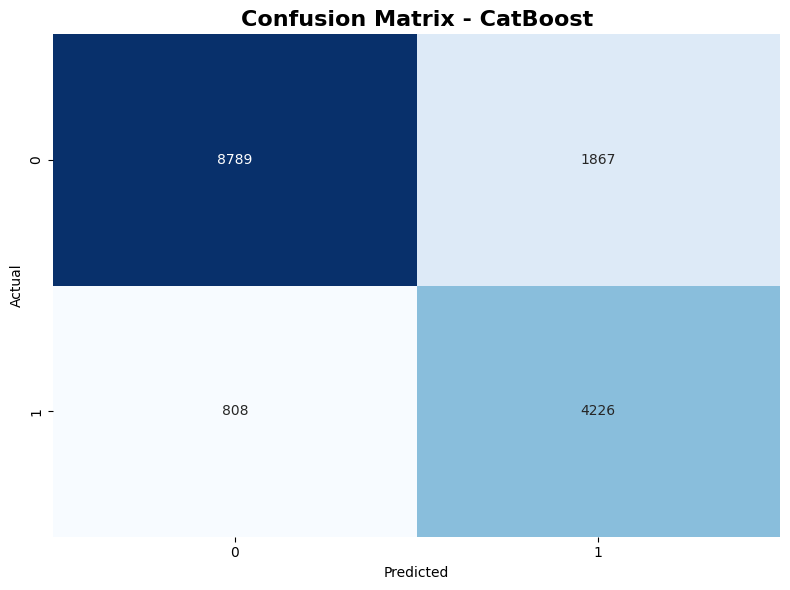

In [46]:
params_optuna = {'learning_rate': 0.1669106789545364, 'depth': 11, 'l2_leaf_reg': 3.6930162306422427, 'random_strength': 0.32625118902083616,
                 "loss_function": "Logloss",
    "task_type": "CPU",
    "random_seed": 0,
    "iterations": 300,
    "verbose": False,}
features_autofeat = [col for col in session_agg.columns if col != 'is_callcenter']

model_cd_autofeat = catboost_train_model(train_df, val_df, test_df, features_autofeat, params_optuna)